$\LARGE \mathbf {Introduction}$

The goal in appointment scheduling is to provide patients with efficienct and timely access to health services. This is hard in general because different patients have different needs, and with limited resources such as available appointment slots and bed capacity, we are unlikely to satisfy the demands of all patients. 
<br>
Many factors affect the performance of appointment systems including arrival and service time variability, patient and provider preferences, available information technology and the experience level of the scheduling staff.
<br>
In this project, we'll focus on how far in advance people usually make appointments, and hopefully this will help improve the scheduling procedure.
To this end, we will cycle through Box's loop (Box, 1976), and focus on the inference part.

$\LARGE \mathbf {Data}$

We will work with the  data that contains the appointments scheduled in the Division of Clinical Genetics
within the Department of Pediatrics at Columbia University Medical
Center (CUMC) from 2010 to 2014. Each entry records the reservation date, the appointment date, the type of the appointment and so on.

In [1]:
import numpy as np
import math
from scipy.special import factorial
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import edward as ed
from edward.models import Dirichlet, Gamma, Normal, ParamMixture, Poisson, Empirical, Categorical, PointMass, Mixture, Multinomial
import tensorflow as tf
import zipfile
from final_utils import EM, info_crit, calc_prob

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Since the dataset is large, and there are a few people that make appointments as far as 1 year in advance, to make the problem easier, we'll focus on the behavior of most people by working on the data for people that make appointments at most 30 days in advance.

In [2]:
# read in the data
zf = zipfile.ZipFile('Appointments.csv.zip')
df = pd.read_csv(zf.open('Appointments.csv'), sep = ',')
appointment_made = [datetime.strptime(x, '%m/%d/%Y') for x in df.values[:, 5]]
appointment_date = [datetime.strptime(x, '%m/%d/%Y') for x in df.values[:, 6]]
delay = np.busday_count(appointment_made, appointment_date, weekmask = '1111111')
delay = [float(x) for x in delay if x >= 0]
delay = [x for x in delay if x <= 30]
N = len(delay)
print(N)

491831


mean: 9.47753801610716
variance: 83.55146707147975


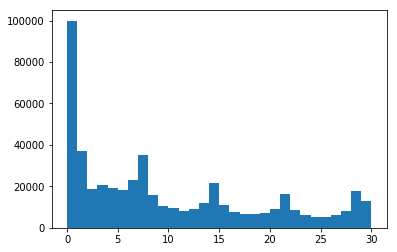

In [3]:
print('mean:', np.mean(delay))
print('variance:', np.var(delay))
plt.hist(delay, bins = range(31))
plt.show()

$\LARGE \mathbf {Model: Mixtures\; of\; Poissons}$

The number of days that people make appointments in advance is a non-negative integer, and we can see from the previous
plot that there several peaks. The data appears to have some periodic patterns. For example, more
appointments are made exactly 1 week, 2 weeks or 3 weeks in advance. 
<br>
Therefore, we'll analyze the data with a Poisson Mixture Model. Specifically, suppose we have $K$ Poisson distributions (components)
with parameters $\lambda_{1},...,\lambda_{K}$ mixed together with
proportions $p_{1},...,p_{K}$. Let $\theta=(\lambda_{1},...,\lambda_{K},p_{1},...,p_{K})$,
then the likelihood is 
$$f(X|\theta)=\prod_{i=1}^{N}\sum_{k=1}^{K}p_{k}e^{-\lambda_{k}}\frac{\lambda_{k}^{X_{i}}}{X_{i}!}.$$

$\LARGE \mathbf {Inference: Frequentist\; and\; Bayesian}$

We'll start from a frequentist's point of view, and try to find the parameters that maximize the likelihood. Since it's hard to directly maximize the log-likelihood function, we'll use the Expectation-Maximization algorithm. After some derivations based on (Dinov, 2008), we can update the parameters as follows:
$$\begin{align*}
q(k,i) & \leftarrow p_{k}Poisson(X_{i},\lambda_{k})\\
p(k|i) & \leftarrow\frac{q(k,i)}{\sum_{k=1}^{K}q(k,i)}\\
z(k) & \leftarrow\sum_{i=1}^{N}p(k|i)\\
p_{k} & \leftarrow\frac{z(k)}{N}\\
\lambda_{k} & \leftarrow\frac{\sum_{i=1}^{N}p(k|i)X_{i}}{z(k)}
\end{align*}$$

In [4]:
pi_EM, lam_EM, q_EM = EM(4, N, delay)
print('mixing proportion: ', pi_EM)
print('cluster mean: ', lam_EM)

mixing proportion:  [0.29077816 0.30589561 0.18488421 0.21844202]
cluster mean:  [ 0.38061447  5.59661077 13.54863022 23.57585386]


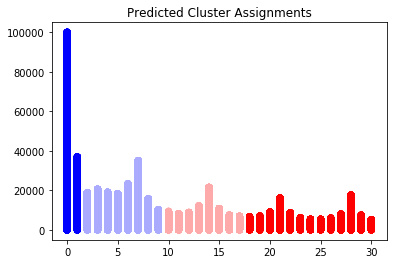

In [5]:
y = np.zeros(N)
for i in range (31):
    indices = [j for j, x in enumerate(delay) if x == i]
    values = [j for j in range (len(indices))]
    y[indices] = values
clusters = np.argmax(q_EM, 0)
plt.scatter(delay, y, c = clusters, cmap = cm.bwr)
plt.title("Predicted Cluster Assignments")
plt.show()

Now, we'll try to make inference from a Bayesian point of view. We'll start with variational inference. By expressing the mixture model in terms of missing data, we'll introduce
indicator parameters $z=(z_{ik};i=1,...,N;k=1,...,K\}$ such that
$z_{ik}=1$ if the $i$-th observation $X_{i}$ belongs to the $k$-th
component of the mixture and $z_{ik}=0$ otherwise. Thus the density
$f(X_{i}|z_{ik}=1)$ is Poisson($\lambda_{k}$) and $f(z_{ik}=1|p)=p_{k}$.
So we can now right the likelihood as 
$$f(X|\theta)=\sum_{z}\prod_{i=1}^{N}\prod_{k=1}^{K}Poisson(X_{i},\lambda_{k})^{z_{ik}}p_{k}^{z_{ik}}.$$
To start, we use a non-informative Dirichlet prior for $p's$, and Gamma priors with mean equal to $10$ for  $\lambda's$. As for the posteriors, we again use Dirichlet for  $p's$, and Gamma for $\lambda's$, and we use Categorical for $z's$.

In [6]:
#variational inference
K = 4
pi = Dirichlet(tf.ones(K))
lam = Gamma(1.0, 0.1, sample_shape = K)
x = ParamMixture(pi, {'rate': lam}, Poisson, sample_shape = N)
z = x.cat

qpi_VI = Dirichlet(tf.nn.softplus(tf.get_variable("qpi_VI/params", [K])))
qlam_VI = Gamma(tf.nn.softplus(tf.get_variable("qlam_VI_concentration/params", [K])),tf.nn.softplus(tf.get_variable("qlam_VI_rate/params", [K])))
qz_VI = Categorical(logits = tf.get_variable("qz_VI/params", [N, K]))

inference = ed.KLqp({lam: qlam_VI, pi: qpi_VI, z: qz_VI}, data = {x: delay})
inference.initialize()

sess = ed.get_session()
tf.global_variables_initializer().run()

for _ in range(50):
    print(inference.update())

{'t': 1, 'loss': 8058932.5}
{'t': 2, 'loss': 4177996.0}
{'t': 3, 'loss': 6494302.0}
{'t': 4, 'loss': 5938568.0}
{'t': 5, 'loss': 3756197.5}
{'t': 6, 'loss': 5454699.0}
{'t': 7, 'loss': 8880864.0}
{'t': 8, 'loss': 4456859.0}
{'t': 9, 'loss': 6212889.5}
{'t': 10, 'loss': 7545900.5}
{'t': 11, 'loss': 13684383.0}
{'t': 12, 'loss': 7415303.0}
{'t': 13, 'loss': 8782032.0}
{'t': 14, 'loss': 6608537.0}
{'t': 15, 'loss': 5921761.5}
{'t': 16, 'loss': 5406594.5}
{'t': 17, 'loss': 5982111.0}
{'t': 18, 'loss': 5870649.0}
{'t': 19, 'loss': 7725811.0}
{'t': 20, 'loss': 6354847.0}
{'t': 21, 'loss': 17384172.0}
{'t': 22, 'loss': 8162987.5}
{'t': 23, 'loss': 6111110.5}
{'t': 24, 'loss': 5821688.0}
{'t': 25, 'loss': 10873605.0}
{'t': 26, 'loss': 3855522.0}
{'t': 27, 'loss': 4108648.2}
{'t': 28, 'loss': 8634036.0}
{'t': 29, 'loss': 5588284.5}
{'t': 30, 'loss': 5105146.0}
{'t': 31, 'loss': 8120862.5}
{'t': 32, 'loss': 7210103.0}
{'t': 33, 'loss': 5564023.0}
{'t': 34, 'loss': 4790324.5}
{'t': 35, 'loss': 42

As we can see, the problem is not as easy, and if we just do a simple variational inference using Edward
, then the loss doesn't converge. This is probably because the variance in BBVI is too large. So we can try to simplify the inference process by marginalizing out $z's$ and focus on inferencing $p's$ and $\lambda's$. But just doing this is not enough for the loss to converge, so we also fix the mixing proportions. Specifically, we fix $p's$ to be the values inferred from the EM algorithm, and we set the Gamma priors of the $\lambda's$ so that the means are the same as what we get from the EM algorithm. 

In [7]:
#variational inference with fixed mixing proportions
pi = tf.constant([0.29077816, 0.30589561, 0.18488421, 0.21844202])
lam = Gamma([0.38061447, 5.59661077, 13.54863022, 23.57585386], [1.0, 1.0, 1.0, 1.0])

x = tf.gather(pi, 0)*Poisson(tf.gather(lam, 0), sample_shape = N)
for i in range (1, K):
    x = x + tf.gather(pi, i) * Poisson(tf.gather(lam, i), sample_shape = N)

qlam_fix = Gamma(tf.nn.softplus(tf.get_variable("qlam_fix_concentration/params", [K])),tf.nn.softplus(tf.get_variable("qlam_fix_rate/params", [K])))

inference = ed.KLqp({lam: qlam_fix}, data = {x: delay})
inference.initialize(optimizer = tf.train.AdamOptimizer(1e-2))

sess = ed.get_session()
tf.global_variables_initializer().run()

for _ in range (25000):
    print(inference.update())

{'t': 1, 'loss': 154.0282}
{'t': 2, 'loss': 113.93637}
{'t': 3, 'loss': 120.048225}
{'t': 4, 'loss': 132.70303}
{'t': 5, 'loss': 300.98032}
{'t': 6, 'loss': 53.935753}
{'t': 7, 'loss': 171.77876}
{'t': 8, 'loss': 61.076385}
{'t': 9, 'loss': 101.83759}
{'t': 10, 'loss': 97.907166}
{'t': 11, 'loss': 123.06553}
{'t': 12, 'loss': 88.40254}
{'t': 13, 'loss': 83.2273}
{'t': 14, 'loss': 137.08727}
{'t': 15, 'loss': 88.93537}
{'t': 16, 'loss': 222.83276}
{'t': 17, 'loss': 86.154236}
{'t': 18, 'loss': 118.39375}
{'t': 19, 'loss': 402.2383}
{'t': 20, 'loss': 145.29015}
{'t': 21, 'loss': 77.40279}
{'t': 22, 'loss': 193.42021}
{'t': 23, 'loss': 93.71266}
{'t': 24, 'loss': 114.16466}
{'t': 25, 'loss': 139.84726}
{'t': 26, 'loss': 95.45038}
{'t': 27, 'loss': 108.3048}
{'t': 28, 'loss': 84.96826}
{'t': 29, 'loss': 162.8923}
{'t': 30, 'loss': 158.39764}
{'t': 31, 'loss': 98.22084}
{'t': 32, 'loss': 121.33122}
{'t': 33, 'loss': 321.26917}
{'t': 34, 'loss': 214.46469}
{'t': 35, 'loss': 109.63306}
{'t': 

{'t': 289, 'loss': 95.53272}
{'t': 290, 'loss': 139.94801}
{'t': 291, 'loss': 82.751015}
{'t': 292, 'loss': 27.445139}
{'t': 293, 'loss': 110.23605}
{'t': 294, 'loss': 68.140755}
{'t': 295, 'loss': 119.89997}
{'t': 296, 'loss': 92.27035}
{'t': 297, 'loss': 64.01932}
{'t': 298, 'loss': 101.41177}
{'t': 299, 'loss': 120.17533}
{'t': 300, 'loss': 123.037315}
{'t': 301, 'loss': 95.59558}
{'t': 302, 'loss': 77.0029}
{'t': 303, 'loss': 68.37242}
{'t': 304, 'loss': 94.02556}
{'t': 305, 'loss': 144.45485}
{'t': 306, 'loss': 58.697598}
{'t': 307, 'loss': 112.45877}
{'t': 308, 'loss': 35.90377}
{'t': 309, 'loss': 169.79233}
{'t': 310, 'loss': 93.28786}
{'t': 311, 'loss': 67.267944}
{'t': 312, 'loss': 98.35911}
{'t': 313, 'loss': 18.625872}
{'t': 314, 'loss': 56.02561}
{'t': 315, 'loss': 116.426125}
{'t': 316, 'loss': 92.492165}
{'t': 317, 'loss': 83.80779}
{'t': 318, 'loss': 71.69397}
{'t': 319, 'loss': 93.60172}
{'t': 320, 'loss': 110.47038}
{'t': 321, 'loss': 112.18005}
{'t': 322, 'loss': 141.

{'t': 798, 'loss': 94.20839}
{'t': 799, 'loss': 36.174297}
{'t': 800, 'loss': 17.671305}
{'t': 801, 'loss': 8.010934}
{'t': 802, 'loss': 46.338314}
{'t': 803, 'loss': 7.7080812}
{'t': 804, 'loss': 13.901867}
{'t': 805, 'loss': 63.643673}
{'t': 806, 'loss': 5.2989836}
{'t': 807, 'loss': 29.30492}
{'t': 808, 'loss': 38.49687}
{'t': 809, 'loss': 24.61793}
{'t': 810, 'loss': 21.36478}
{'t': 811, 'loss': 1.9367485}
{'t': 812, 'loss': 22.541779}
{'t': 813, 'loss': 51.61566}
{'t': 814, 'loss': 3.7452898}
{'t': 815, 'loss': 5.0268545}
{'t': 816, 'loss': 22.076717}
{'t': 817, 'loss': 29.44108}
{'t': 818, 'loss': 19.60419}
{'t': 819, 'loss': 30.462387}
{'t': 820, 'loss': 75.1219}
{'t': 821, 'loss': 53.90649}
{'t': 822, 'loss': 39.93748}
{'t': 823, 'loss': 46.10532}
{'t': 824, 'loss': 22.549503}
{'t': 825, 'loss': 14.004797}
{'t': 826, 'loss': 42.595795}
{'t': 827, 'loss': 20.050705}
{'t': 828, 'loss': 20.61686}
{'t': 829, 'loss': 17.711632}
{'t': 830, 'loss': 60.665077}
{'t': 831, 'loss': 58.847

{'t': 1100, 'loss': 6.7828245}
{'t': 1101, 'loss': 5.198574}
{'t': 1102, 'loss': -1.4145699}
{'t': 1103, 'loss': 12.2875185}
{'t': 1104, 'loss': 3.981779}
{'t': 1105, 'loss': 24.557463}
{'t': 1106, 'loss': 27.191294}
{'t': 1107, 'loss': 27.73684}
{'t': 1108, 'loss': 14.508768}
{'t': 1109, 'loss': 9.273836}
{'t': 1110, 'loss': 9.211731}
{'t': 1111, 'loss': 24.59241}
{'t': 1112, 'loss': 6.016637}
{'t': 1113, 'loss': 11.040871}
{'t': 1114, 'loss': 36.00583}
{'t': 1115, 'loss': 29.01353}
{'t': 1116, 'loss': 21.60281}
{'t': 1117, 'loss': 1.7980566}
{'t': 1118, 'loss': 38.410736}
{'t': 1119, 'loss': 7.629404}
{'t': 1120, 'loss': 46.19956}
{'t': 1121, 'loss': 13.368195}
{'t': 1122, 'loss': 14.900726}
{'t': 1123, 'loss': 8.050867}
{'t': 1124, 'loss': 1.1589537}
{'t': 1125, 'loss': 4.2550793}
{'t': 1126, 'loss': 2.3783798}
{'t': 1127, 'loss': 22.929718}
{'t': 1128, 'loss': 3.7869434}
{'t': 1129, 'loss': 9.057827}
{'t': 1130, 'loss': 93.7285}
{'t': 1131, 'loss': 17.291498}
{'t': 1132, 'loss': 6.

{'t': 1413, 'loss': 18.783852}
{'t': 1414, 'loss': 0.01846695}
{'t': 1415, 'loss': 20.694641}
{'t': 1416, 'loss': 4.4355736}
{'t': 1417, 'loss': 5.5718956}
{'t': 1418, 'loss': 2.620554}
{'t': 1419, 'loss': 8.4898405}
{'t': 1420, 'loss': 140.66473}
{'t': 1421, 'loss': 15.786625}
{'t': 1422, 'loss': 3.0448074}
{'t': 1423, 'loss': 8.242806}
{'t': 1424, 'loss': 15.83949}
{'t': 1425, 'loss': 47.990997}
{'t': 1426, 'loss': 16.417511}
{'t': 1427, 'loss': 6.9771385}
{'t': 1428, 'loss': 5.045185}
{'t': 1429, 'loss': 12.414385}
{'t': 1430, 'loss': 9.985105}
{'t': 1431, 'loss': 45.561886}
{'t': 1432, 'loss': 17.277388}
{'t': 1433, 'loss': 5.588291}
{'t': 1434, 'loss': 1.3118315}
{'t': 1435, 'loss': -1.8595924}
{'t': 1436, 'loss': 19.272932}
{'t': 1437, 'loss': 9.171474}
{'t': 1438, 'loss': 41.848347}
{'t': 1439, 'loss': 40.83784}
{'t': 1440, 'loss': 11.080337}
{'t': 1441, 'loss': 5.672718}
{'t': 1442, 'loss': 27.333675}
{'t': 1443, 'loss': 21.888905}
{'t': 1444, 'loss': 13.666811}
{'t': 1445, 'lo

{'t': 1933, 'loss': 20.947245}
{'t': 1934, 'loss': 19.103645}
{'t': 1935, 'loss': 10.594371}
{'t': 1936, 'loss': 26.838764}
{'t': 1937, 'loss': 18.846844}
{'t': 1938, 'loss': 8.578598}
{'t': 1939, 'loss': -1.4011602}
{'t': 1940, 'loss': 8.357065}
{'t': 1941, 'loss': 4.8892164}
{'t': 1942, 'loss': 38.329304}
{'t': 1943, 'loss': -1.8548832}
{'t': 1944, 'loss': -2.494711}
{'t': 1945, 'loss': 2.4143162}
{'t': 1946, 'loss': 19.596422}
{'t': 1947, 'loss': 41.91268}
{'t': 1948, 'loss': 9.179242}
{'t': 1949, 'loss': -1.9352598}
{'t': 1950, 'loss': 5.815638}
{'t': 1951, 'loss': 15.316058}
{'t': 1952, 'loss': -1.0530396}
{'t': 1953, 'loss': 31.03365}
{'t': 1954, 'loss': 1.7185049}
{'t': 1955, 'loss': 3.7444077}
{'t': 1956, 'loss': 8.156788}
{'t': 1957, 'loss': 20.770922}
{'t': 1958, 'loss': 2.8099995}
{'t': 1959, 'loss': 15.583325}
{'t': 1960, 'loss': -0.36145592}
{'t': 1961, 'loss': 9.698021}
{'t': 1962, 'loss': 9.705899}
{'t': 1963, 'loss': 4.6328}
{'t': 1964, 'loss': 12.340178}
{'t': 1965, 'l

{'t': 2445, 'loss': 5.048959}
{'t': 2446, 'loss': 14.617926}
{'t': 2447, 'loss': 18.605982}
{'t': 2448, 'loss': 5.2214603}
{'t': 2449, 'loss': 12.43726}
{'t': 2450, 'loss': 25.262245}
{'t': 2451, 'loss': 9.843917}
{'t': 2452, 'loss': -1.5596175}
{'t': 2453, 'loss': 11.708805}
{'t': 2454, 'loss': 9.2889805}
{'t': 2455, 'loss': 4.288782}
{'t': 2456, 'loss': 5.3543367}
{'t': 2457, 'loss': 1.5699825}
{'t': 2458, 'loss': 2.1606255}
{'t': 2459, 'loss': 16.361355}
{'t': 2460, 'loss': 25.194572}
{'t': 2461, 'loss': 19.902555}
{'t': 2462, 'loss': 1.4354858}
{'t': 2463, 'loss': 2.7569656}
{'t': 2464, 'loss': 16.89317}
{'t': 2465, 'loss': 13.995591}
{'t': 2466, 'loss': 5.0976458}
{'t': 2467, 'loss': -3.1125455}
{'t': 2468, 'loss': 11.666344}
{'t': 2469, 'loss': 40.081844}
{'t': 2470, 'loss': -0.97347736}
{'t': 2471, 'loss': 5.826668}
{'t': 2472, 'loss': 4.242361}
{'t': 2473, 'loss': 4.4167004}
{'t': 2474, 'loss': 0.26513004}
{'t': 2475, 'loss': 32.598484}
{'t': 2476, 'loss': 3.0097322}
{'t': 2477

{'t': 2864, 'loss': 14.370523}
{'t': 2865, 'loss': 0.27499342}
{'t': 2866, 'loss': 5.175804}
{'t': 2867, 'loss': 19.703842}
{'t': 2868, 'loss': -2.2607317}
{'t': 2869, 'loss': 9.02437}
{'t': 2870, 'loss': 0.7576494}
{'t': 2871, 'loss': 22.875528}
{'t': 2872, 'loss': -0.8773074}
{'t': 2873, 'loss': 12.185764}
{'t': 2874, 'loss': 51.313313}
{'t': 2875, 'loss': 7.162734}
{'t': 2876, 'loss': -1.252058}
{'t': 2877, 'loss': 4.971348}
{'t': 2878, 'loss': 3.1696491}
{'t': 2879, 'loss': 4.5840063}
{'t': 2880, 'loss': 11.165304}
{'t': 2881, 'loss': 8.820869}
{'t': 2882, 'loss': 16.058596}
{'t': 2883, 'loss': 3.9448576}
{'t': 2884, 'loss': 3.624505}
{'t': 2885, 'loss': 0.40013695}
{'t': 2886, 'loss': 10.234056}
{'t': 2887, 'loss': -0.6823473}
{'t': 2888, 'loss': 0.30011654}
{'t': 2889, 'loss': 0.44783688}
{'t': 2890, 'loss': 0.8299446}
{'t': 2891, 'loss': 5.3418217}
{'t': 2892, 'loss': -2.0094109}
{'t': 2893, 'loss': 3.0024042}
{'t': 2894, 'loss': 22.049417}
{'t': 2895, 'loss': 3.3149052}
{'t': 2

{'t': 3336, 'loss': 29.95031}
{'t': 3337, 'loss': 0.4920025}
{'t': 3338, 'loss': 1.5047464}
{'t': 3339, 'loss': 0.018161774}
{'t': 3340, 'loss': -0.2932663}
{'t': 3341, 'loss': 12.382645}
{'t': 3342, 'loss': 4.2287827}
{'t': 3343, 'loss': 11.168628}
{'t': 3344, 'loss': 4.844866}
{'t': 3345, 'loss': -1.289093}
{'t': 3346, 'loss': -1.5688591}
{'t': 3347, 'loss': 4.763215}
{'t': 3348, 'loss': 18.803627}
{'t': 3349, 'loss': 6.2909975}
{'t': 3350, 'loss': 0.9312296}
{'t': 3351, 'loss': 7.2551994}
{'t': 3352, 'loss': -0.9320965}
{'t': 3353, 'loss': 8.660031}
{'t': 3354, 'loss': 2.9931564}
{'t': 3355, 'loss': 11.485086}
{'t': 3356, 'loss': -2.6638222}
{'t': 3357, 'loss': 0.20414829}
{'t': 3358, 'loss': -1.7193365}
{'t': 3359, 'loss': -1.6378736}
{'t': 3360, 'loss': 14.049129}
{'t': 3361, 'loss': 17.504438}
{'t': 3362, 'loss': 20.996504}
{'t': 3363, 'loss': 1.6504402}
{'t': 3364, 'loss': 9.367352}
{'t': 3365, 'loss': 2.2258482}
{'t': 3366, 'loss': 17.172644}
{'t': 3367, 'loss': 4.598181}
{'t':

{'t': 3605, 'loss': 4.3144646}
{'t': 3606, 'loss': 1.8529787}
{'t': 3607, 'loss': 11.997779}
{'t': 3608, 'loss': 4.716916}
{'t': 3609, 'loss': 6.9221}
{'t': 3610, 'loss': 9.199946}
{'t': 3611, 'loss': 6.1686983}
{'t': 3612, 'loss': 4.830126}
{'t': 3613, 'loss': -2.2400322}
{'t': 3614, 'loss': -1.2920837}
{'t': 3615, 'loss': -0.9063406}
{'t': 3616, 'loss': 18.832006}
{'t': 3617, 'loss': 16.180407}
{'t': 3618, 'loss': 2.2492266}
{'t': 3619, 'loss': 12.9240885}
{'t': 3620, 'loss': 14.15264}
{'t': 3621, 'loss': 0.09697056}
{'t': 3622, 'loss': 0.10879612}
{'t': 3623, 'loss': 8.898903}
{'t': 3624, 'loss': 7.357342}
{'t': 3625, 'loss': -0.020513535}
{'t': 3626, 'loss': 5.0897427}
{'t': 3627, 'loss': 0.66367054}
{'t': 3628, 'loss': 3.0038095}
{'t': 3629, 'loss': 1.9382744}
{'t': 3630, 'loss': -0.25989723}
{'t': 3631, 'loss': 4.323353}
{'t': 3632, 'loss': -2.1118245}
{'t': 3633, 'loss': 40.814476}
{'t': 3634, 'loss': -1.2330589}
{'t': 3635, 'loss': 6.4439907}
{'t': 3636, 'loss': 3.063117}
{'t':

{'t': 3877, 'loss': -1.1414433}
{'t': 3878, 'loss': 20.51421}
{'t': 3879, 'loss': 9.656582}
{'t': 3880, 'loss': 2.343296}
{'t': 3881, 'loss': 5.2914143}
{'t': 3882, 'loss': -1.103354}
{'t': 3883, 'loss': 5.69096}
{'t': 3884, 'loss': 15.226881}
{'t': 3885, 'loss': 6.9621334}
{'t': 3886, 'loss': 2.5969667}
{'t': 3887, 'loss': 9.065103}
{'t': 3888, 'loss': 13.539867}
{'t': 3889, 'loss': 20.822083}
{'t': 3890, 'loss': 2.93289}
{'t': 3891, 'loss': -1.6311512}
{'t': 3892, 'loss': 12.41799}
{'t': 3893, 'loss': 10.774247}
{'t': 3894, 'loss': 12.531359}
{'t': 3895, 'loss': -0.32214355}
{'t': 3896, 'loss': 3.1949997}
{'t': 3897, 'loss': 1.1302147}
{'t': 3898, 'loss': 6.579008}
{'t': 3899, 'loss': 7.7689447}
{'t': 3900, 'loss': 1.5222826}
{'t': 3901, 'loss': -1.0164318}
{'t': 3902, 'loss': 19.330484}
{'t': 3903, 'loss': 0.85382986}
{'t': 3904, 'loss': 2.8561487}
{'t': 3905, 'loss': 3.289545}
{'t': 3906, 'loss': -0.2290945}
{'t': 3907, 'loss': 3.7444792}
{'t': 3908, 'loss': -1.3127556}
{'t': 3909,

{'t': 4351, 'loss': 7.7760334}
{'t': 4352, 'loss': 33.578262}
{'t': 4353, 'loss': 8.403587}
{'t': 4354, 'loss': 11.221039}
{'t': 4355, 'loss': 2.4246044}
{'t': 4356, 'loss': 5.9632416}
{'t': 4357, 'loss': -1.2905464}
{'t': 4358, 'loss': 27.753716}
{'t': 4359, 'loss': -2.2251153}
{'t': 4360, 'loss': 13.6222}
{'t': 4361, 'loss': 7.0282907}
{'t': 4362, 'loss': -0.16229153}
{'t': 4363, 'loss': 3.4859982}
{'t': 4364, 'loss': 8.812904}
{'t': 4365, 'loss': -2.4789515}
{'t': 4366, 'loss': 14.946613}
{'t': 4367, 'loss': -0.5849571}
{'t': 4368, 'loss': 3.725934}
{'t': 4369, 'loss': 13.738281}
{'t': 4370, 'loss': 9.407078}
{'t': 4371, 'loss': -0.096663475}
{'t': 4372, 'loss': 6.4479485}
{'t': 4373, 'loss': 7.160404}
{'t': 4374, 'loss': 23.592712}
{'t': 4375, 'loss': 3.3695211}
{'t': 4376, 'loss': 2.695054}
{'t': 4377, 'loss': 1.8861055}
{'t': 4378, 'loss': -0.64405346}
{'t': 4379, 'loss': -0.5888653}
{'t': 4380, 'loss': 3.5180998}
{'t': 4381, 'loss': 0.76466084}
{'t': 4382, 'loss': 11.02172}
{'t'

{'t': 4661, 'loss': 7.142558}
{'t': 4662, 'loss': 1.7894564}
{'t': 4663, 'loss': 14.5651045}
{'t': 4664, 'loss': -0.61230755}
{'t': 4665, 'loss': 0.076135635}
{'t': 4666, 'loss': 5.246763}
{'t': 4667, 'loss': 6.0544605}
{'t': 4668, 'loss': 2.8970547}
{'t': 4669, 'loss': 7.7877846}
{'t': 4670, 'loss': 1.9866962}
{'t': 4671, 'loss': 1.0671921}
{'t': 4672, 'loss': 0.95384216}
{'t': 4673, 'loss': 20.316288}
{'t': 4674, 'loss': -1.1862173}
{'t': 4675, 'loss': -1.391202}
{'t': 4676, 'loss': 3.2549334}
{'t': 4677, 'loss': 2.362979}
{'t': 4678, 'loss': 0.17518044}
{'t': 4679, 'loss': 4.5704346}
{'t': 4680, 'loss': 5.1864996}
{'t': 4681, 'loss': -0.93206453}
{'t': 4682, 'loss': 0.205616}
{'t': 4683, 'loss': 6.486042}
{'t': 4684, 'loss': -0.0045661926}
{'t': 4685, 'loss': 0.6584158}
{'t': 4686, 'loss': -0.7535114}
{'t': 4687, 'loss': 5.1006174}
{'t': 4688, 'loss': -0.7709074}
{'t': 4689, 'loss': 3.0875063}
{'t': 4690, 'loss': 8.286785}
{'t': 4691, 'loss': 11.119516}
{'t': 4692, 'loss': 8.5309925

{'t': 4934, 'loss': 0.62558365}
{'t': 4935, 'loss': 15.343697}
{'t': 4936, 'loss': 1.4056168}
{'t': 4937, 'loss': 0.44929504}
{'t': 4938, 'loss': 2.9641333}
{'t': 4939, 'loss': 1.1628346}
{'t': 4940, 'loss': -1.0974388}
{'t': 4941, 'loss': 0.3061571}
{'t': 4942, 'loss': 2.3693933}
{'t': 4943, 'loss': 1.9597034}
{'t': 4944, 'loss': -0.15933704}
{'t': 4945, 'loss': -0.580832}
{'t': 4946, 'loss': 0.6193962}
{'t': 4947, 'loss': 4.422078}
{'t': 4948, 'loss': 0.98842335}
{'t': 4949, 'loss': -0.7076788}
{'t': 4950, 'loss': -1.0956097}
{'t': 4951, 'loss': 1.0808125}
{'t': 4952, 'loss': 2.4843569}
{'t': 4953, 'loss': 2.3280478}
{'t': 4954, 'loss': 2.359312}
{'t': 4955, 'loss': 17.85826}
{'t': 4956, 'loss': 1.7740269}
{'t': 4957, 'loss': 8.249849}
{'t': 4958, 'loss': 1.5720453}
{'t': 4959, 'loss': 5.4812565}
{'t': 4960, 'loss': -1.507761}
{'t': 4961, 'loss': 5.1448174}
{'t': 4962, 'loss': 11.811996}
{'t': 4963, 'loss': 4.9127364}
{'t': 4964, 'loss': 0.16505623}
{'t': 4965, 'loss': 17.77249}
{'t'

{'t': 5394, 'loss': 1.43771}
{'t': 5395, 'loss': -2.4807115}
{'t': 5396, 'loss': 4.5000854}
{'t': 5397, 'loss': 2.030076}
{'t': 5398, 'loss': -0.77390146}
{'t': 5399, 'loss': -0.77477264}
{'t': 5400, 'loss': -0.67033577}
{'t': 5401, 'loss': 17.095839}
{'t': 5402, 'loss': 4.355648}
{'t': 5403, 'loss': -0.5699167}
{'t': 5404, 'loss': 2.5525126}
{'t': 5405, 'loss': 1.985446}
{'t': 5406, 'loss': -0.8938389}
{'t': 5407, 'loss': 4.5482235}
{'t': 5408, 'loss': 4.486825}
{'t': 5409, 'loss': 14.75079}
{'t': 5410, 'loss': 17.712505}
{'t': 5411, 'loss': -2.164713}
{'t': 5412, 'loss': 4.716205}
{'t': 5413, 'loss': 7.606839}
{'t': 5414, 'loss': 1.7042809}
{'t': 5415, 'loss': -0.99414444}
{'t': 5416, 'loss': 7.8731303}
{'t': 5417, 'loss': 26.425632}
{'t': 5418, 'loss': -1.8752933}
{'t': 5419, 'loss': 1.9623823}
{'t': 5420, 'loss': 2.9678392}
{'t': 5421, 'loss': -1.7315674}
{'t': 5422, 'loss': 0.7957926}
{'t': 5423, 'loss': -1.5966325}
{'t': 5424, 'loss': 1.166604}
{'t': 5425, 'loss': 6.713476}
{'t':

{'t': 5920, 'loss': 8.00318}
{'t': 5921, 'loss': 3.2091746}
{'t': 5922, 'loss': 9.5648775}
{'t': 5923, 'loss': 0.44942093}
{'t': 5924, 'loss': 5.8543243}
{'t': 5925, 'loss': 4.839712}
{'t': 5926, 'loss': 2.4971256}
{'t': 5927, 'loss': 1.9292107}
{'t': 5928, 'loss': 1.4108105}
{'t': 5929, 'loss': 1.0972676}
{'t': 5930, 'loss': 5.093218}
{'t': 5931, 'loss': 1.291398}
{'t': 5932, 'loss': 0.74753284}
{'t': 5933, 'loss': 5.157462}
{'t': 5934, 'loss': 3.0489087}
{'t': 5935, 'loss': 0.7839222}
{'t': 5936, 'loss': 4.2268486}
{'t': 5937, 'loss': -0.2336421}
{'t': 5938, 'loss': 0.4115858}
{'t': 5939, 'loss': 2.6428032}
{'t': 5940, 'loss': -0.082826614}
{'t': 5941, 'loss': 2.2616758}
{'t': 5942, 'loss': 15.195566}
{'t': 5943, 'loss': 4.0755987}
{'t': 5944, 'loss': -1.1443892}
{'t': 5945, 'loss': 3.5700054}
{'t': 5946, 'loss': 1.1961489}
{'t': 5947, 'loss': 10.786011}
{'t': 5948, 'loss': 6.4110737}
{'t': 5949, 'loss': 0.33039093}
{'t': 5950, 'loss': 5.228901}
{'t': 5951, 'loss': 16.130898}
{'t': 5

{'t': 6225, 'loss': -0.28843546}
{'t': 6226, 'loss': -1.030756}
{'t': 6227, 'loss': 4.45322}
{'t': 6228, 'loss': 1.6375599}
{'t': 6229, 'loss': 14.340073}
{'t': 6230, 'loss': -0.20966482}
{'t': 6231, 'loss': -2.1338253}
{'t': 6232, 'loss': 0.45075893}
{'t': 6233, 'loss': 8.060826}
{'t': 6234, 'loss': 5.955619}
{'t': 6235, 'loss': 4.5807047}
{'t': 6236, 'loss': 5.6534357}
{'t': 6237, 'loss': -1.2576675}
{'t': 6238, 'loss': 0.70219135}
{'t': 6239, 'loss': 0.37006378}
{'t': 6240, 'loss': -1.3137288}
{'t': 6241, 'loss': 2.352086}
{'t': 6242, 'loss': 0.7076206}
{'t': 6243, 'loss': -1.573626}
{'t': 6244, 'loss': 8.212646}
{'t': 6245, 'loss': 0.08433533}
{'t': 6246, 'loss': 3.9681377}
{'t': 6247, 'loss': -1.4986162}
{'t': 6248, 'loss': 18.918034}
{'t': 6249, 'loss': 0.968647}
{'t': 6250, 'loss': 6.2190113}
{'t': 6251, 'loss': 1.3822098}
{'t': 6252, 'loss': 2.0234966}
{'t': 6253, 'loss': 24.468891}
{'t': 6254, 'loss': 0.19098282}
{'t': 6255, 'loss': 1.2425241}
{'t': 6256, 'loss': 0.2864704}
{'

{'t': 6519, 'loss': -0.17247963}
{'t': 6520, 'loss': 3.5561032}
{'t': 6521, 'loss': 4.518669}
{'t': 6522, 'loss': 7.489311}
{'t': 6523, 'loss': 6.090225}
{'t': 6524, 'loss': 7.8988256}
{'t': 6525, 'loss': 1.142807}
{'t': 6526, 'loss': 2.3373423}
{'t': 6527, 'loss': -1.1825881}
{'t': 6528, 'loss': 4.335288}
{'t': 6529, 'loss': 6.5336223}
{'t': 6530, 'loss': 1.0257688}
{'t': 6531, 'loss': 6.579315}
{'t': 6532, 'loss': -0.23536587}
{'t': 6533, 'loss': 12.06643}
{'t': 6534, 'loss': -0.2617283}
{'t': 6535, 'loss': 3.3672552}
{'t': 6536, 'loss': 0.2850914}
{'t': 6537, 'loss': 0.9756584}
{'t': 6538, 'loss': 14.209226}
{'t': 6539, 'loss': -1.4478693}
{'t': 6540, 'loss': 0.7883787}
{'t': 6541, 'loss': 6.4395084}
{'t': 6542, 'loss': 1.6646318}
{'t': 6543, 'loss': 0.64167213}
{'t': 6544, 'loss': 3.628685}
{'t': 6545, 'loss': 1.5157108}
{'t': 6546, 'loss': 0.42753506}
{'t': 6547, 'loss': 0.6003485}
{'t': 6548, 'loss': -1.0115204}
{'t': 6549, 'loss': 3.6176438}
{'t': 6550, 'loss': 17.190483}
{'t': 

{'t': 6782, 'loss': 3.193657}
{'t': 6783, 'loss': -0.7709408}
{'t': 6784, 'loss': -1.149147}
{'t': 6785, 'loss': -1.3887568}
{'t': 6786, 'loss': 1.2681351}
{'t': 6787, 'loss': 8.132845}
{'t': 6788, 'loss': 4.663602}
{'t': 6789, 'loss': 2.7590256}
{'t': 6790, 'loss': -1.6961226}
{'t': 6791, 'loss': 2.0239496}
{'t': 6792, 'loss': 0.35145855}
{'t': 6793, 'loss': 0.10956764}
{'t': 6794, 'loss': 12.081993}
{'t': 6795, 'loss': -1.8934445}
{'t': 6796, 'loss': 0.60028267}
{'t': 6797, 'loss': 5.5549755}
{'t': 6798, 'loss': 4.4890003}
{'t': 6799, 'loss': -0.16726303}
{'t': 6800, 'loss': 14.582141}
{'t': 6801, 'loss': 5.568849}
{'t': 6802, 'loss': -1.8599391}
{'t': 6803, 'loss': -0.79521656}
{'t': 6804, 'loss': 1.0431414}
{'t': 6805, 'loss': -1.6900644}
{'t': 6806, 'loss': 0.12316227}
{'t': 6807, 'loss': 4.0944977}
{'t': 6808, 'loss': -0.91262674}
{'t': 6809, 'loss': 2.4783344}
{'t': 6810, 'loss': 5.351475}
{'t': 6811, 'loss': 5.469225}
{'t': 6812, 'loss': -0.97460365}
{'t': 6813, 'loss': -0.1742

{'t': 7059, 'loss': 2.548873}
{'t': 7060, 'loss': 11.137085}
{'t': 7061, 'loss': 9.426935}
{'t': 7062, 'loss': -0.47353458}
{'t': 7063, 'loss': 3.2967634}
{'t': 7064, 'loss': 0.5894871}
{'t': 7065, 'loss': 0.2202797}
{'t': 7066, 'loss': 0.45277977}
{'t': 7067, 'loss': -0.5015898}
{'t': 7068, 'loss': -1.5149837}
{'t': 7069, 'loss': -0.7267227}
{'t': 7070, 'loss': 0.17113781}
{'t': 7071, 'loss': 4.1617947}
{'t': 7072, 'loss': 4.200554}
{'t': 7073, 'loss': 2.0061183}
{'t': 7074, 'loss': 4.7188015}
{'t': 7075, 'loss': 3.798195}
{'t': 7076, 'loss': 3.4153519}
{'t': 7077, 'loss': 5.992176}
{'t': 7078, 'loss': -1.9266033}
{'t': 7079, 'loss': 8.097102}
{'t': 7080, 'loss': -0.72932386}
{'t': 7081, 'loss': -0.21920204}
{'t': 7082, 'loss': -0.03404665}
{'t': 7083, 'loss': 2.547121}
{'t': 7084, 'loss': -1.3497934}
{'t': 7085, 'loss': 6.8701105}
{'t': 7086, 'loss': -1.0513363}
{'t': 7087, 'loss': 1.474905}
{'t': 7088, 'loss': 1.0002413}
{'t': 7089, 'loss': 7.9050446}
{'t': 7090, 'loss': -1.0231581}

{'t': 7342, 'loss': 0.3806696}
{'t': 7343, 'loss': -1.3525238}
{'t': 7344, 'loss': 0.8758993}
{'t': 7345, 'loss': 4.2698746}
{'t': 7346, 'loss': -0.94129705}
{'t': 7347, 'loss': -0.18591595}
{'t': 7348, 'loss': 1.4372654}
{'t': 7349, 'loss': -0.69398403}
{'t': 7350, 'loss': 2.1680784}
{'t': 7351, 'loss': -0.11693096}
{'t': 7352, 'loss': 7.28277}
{'t': 7353, 'loss': -1.1309805}
{'t': 7354, 'loss': 4.9192686}
{'t': 7355, 'loss': 0.7888136}
{'t': 7356, 'loss': -1.2475128}
{'t': 7357, 'loss': 0.6332588}
{'t': 7358, 'loss': 4.713892}
{'t': 7359, 'loss': -1.6921854}
{'t': 7360, 'loss': -1.4836521}
{'t': 7361, 'loss': 3.3325171}
{'t': 7362, 'loss': 2.9178867}
{'t': 7363, 'loss': 0.26315928}
{'t': 7364, 'loss': 5.753024}
{'t': 7365, 'loss': -0.45560503}
{'t': 7366, 'loss': -1.3387585}
{'t': 7367, 'loss': -1.1001616}
{'t': 7368, 'loss': 15.32027}
{'t': 7369, 'loss': 1.3317246}
{'t': 7370, 'loss': -0.32854223}
{'t': 7371, 'loss': 7.027054}
{'t': 7372, 'loss': 2.7566404}
{'t': 7373, 'loss': -0.72

{'t': 7638, 'loss': 9.071814}
{'t': 7639, 'loss': 11.013449}
{'t': 7640, 'loss': 7.622864}
{'t': 7641, 'loss': 6.1351604}
{'t': 7642, 'loss': 4.351715}
{'t': 7643, 'loss': 3.8845396}
{'t': 7644, 'loss': 2.870308}
{'t': 7645, 'loss': 7.552539}
{'t': 7646, 'loss': 2.7559433}
{'t': 7647, 'loss': -0.6554928}
{'t': 7648, 'loss': -1.1664996}
{'t': 7649, 'loss': 2.359672}
{'t': 7650, 'loss': 7.5163913}
{'t': 7651, 'loss': 7.721878}
{'t': 7652, 'loss': -0.76030254}
{'t': 7653, 'loss': -0.7157736}
{'t': 7654, 'loss': 2.4512377}
{'t': 7655, 'loss': -0.2476759}
{'t': 7656, 'loss': 8.7581005}
{'t': 7657, 'loss': 0.3861189}
{'t': 7658, 'loss': 1.4879475}
{'t': 7659, 'loss': -0.79352856}
{'t': 7660, 'loss': 6.3944817}
{'t': 7661, 'loss': -1.5622215}
{'t': 7662, 'loss': 1.3039637}
{'t': 7663, 'loss': 2.2984004}
{'t': 7664, 'loss': -1.3581877}
{'t': 7665, 'loss': 3.1478634}
{'t': 7666, 'loss': 0.52974033}
{'t': 7667, 'loss': 7.1521025}
{'t': 7668, 'loss': 9.948105}
{'t': 7669, 'loss': 0.044115067}
{'t

{'t': 7935, 'loss': -1.5911522}
{'t': 7936, 'loss': 0.21522856}
{'t': 7937, 'loss': 3.763916}
{'t': 7938, 'loss': 0.32785892}
{'t': 7939, 'loss': 13.013212}
{'t': 7940, 'loss': -1.6210203}
{'t': 7941, 'loss': 4.557146}
{'t': 7942, 'loss': -0.7321949}
{'t': 7943, 'loss': 2.1830482}
{'t': 7944, 'loss': 12.402394}
{'t': 7945, 'loss': 0.200037}
{'t': 7946, 'loss': -1.422102}
{'t': 7947, 'loss': 1.692193}
{'t': 7948, 'loss': 3.865728}
{'t': 7949, 'loss': 3.0515213}
{'t': 7950, 'loss': 5.3546324}
{'t': 7951, 'loss': 0.5792618}
{'t': 7952, 'loss': 0.2917409}
{'t': 7953, 'loss': -1.3135271}
{'t': 7954, 'loss': 3.9319134}
{'t': 7955, 'loss': 1.0662403}
{'t': 7956, 'loss': 2.2696724}
{'t': 7957, 'loss': -0.76833725}
{'t': 7958, 'loss': 9.459019}
{'t': 7959, 'loss': -1.8588562}
{'t': 7960, 'loss': -0.14101934}
{'t': 7961, 'loss': 6.6202745}
{'t': 7962, 'loss': 12.042788}
{'t': 7963, 'loss': 5.1462507}
{'t': 7964, 'loss': -0.35102892}
{'t': 7965, 'loss': 0.8473654}
{'t': 7966, 'loss': -1.3692408}


{'t': 8228, 'loss': 2.7455034}
{'t': 8229, 'loss': 4.127018}
{'t': 8230, 'loss': 1.3734484}
{'t': 8231, 'loss': 7.4536295}
{'t': 8232, 'loss': 5.231188}
{'t': 8233, 'loss': -1.5549502}
{'t': 8234, 'loss': 12.597204}
{'t': 8235, 'loss': 0.28988743}
{'t': 8236, 'loss': 6.5969467}
{'t': 8237, 'loss': 5.0413213}
{'t': 8238, 'loss': 3.457775}
{'t': 8239, 'loss': -0.8294301}
{'t': 8240, 'loss': 3.3494072}
{'t': 8241, 'loss': 1.2733335}
{'t': 8242, 'loss': -0.34102058}
{'t': 8243, 'loss': -0.29416847}
{'t': 8244, 'loss': -0.7905636}
{'t': 8245, 'loss': 0.5844927}
{'t': 8246, 'loss': 3.1953125}
{'t': 8247, 'loss': -0.777236}
{'t': 8248, 'loss': 0.92220783}
{'t': 8249, 'loss': 8.562782}
{'t': 8250, 'loss': 13.562317}
{'t': 8251, 'loss': 7.213911}
{'t': 8252, 'loss': 1.2272577}
{'t': 8253, 'loss': -1.2438593}
{'t': 8254, 'loss': 0.85255337}
{'t': 8255, 'loss': 0.71240664}
{'t': 8256, 'loss': -0.3128295}
{'t': 8257, 'loss': 5.7993526}
{'t': 8258, 'loss': 0.7208009}
{'t': 8259, 'loss': 3.365665}
{

{'t': 8512, 'loss': -0.97305346}
{'t': 8513, 'loss': 10.806328}
{'t': 8514, 'loss': -1.0443172}
{'t': 8515, 'loss': 1.141274}
{'t': 8516, 'loss': -1.4502935}
{'t': 8517, 'loss': 3.3661556}
{'t': 8518, 'loss': 3.6835623}
{'t': 8519, 'loss': -1.0046935}
{'t': 8520, 'loss': 0.4881878}
{'t': 8521, 'loss': 0.97867966}
{'t': 8522, 'loss': -0.38562012}
{'t': 8523, 'loss': 1.4975348}
{'t': 8524, 'loss': 4.959326}
{'t': 8525, 'loss': 2.5319314}
{'t': 8526, 'loss': -0.811954}
{'t': 8527, 'loss': 0.14261436}
{'t': 8528, 'loss': 1.7854166}
{'t': 8529, 'loss': -1.5083437}
{'t': 8530, 'loss': 3.9193668}
{'t': 8531, 'loss': 1.7985582}
{'t': 8532, 'loss': 7.429475}
{'t': 8533, 'loss': 1.7404861}
{'t': 8534, 'loss': 0.34310007}
{'t': 8535, 'loss': 4.0050726}
{'t': 8536, 'loss': 0.68521976}
{'t': 8537, 'loss': 3.5504427}
{'t': 8538, 'loss': -0.72250366}
{'t': 8539, 'loss': -0.2282505}
{'t': 8540, 'loss': 0.38045287}
{'t': 8541, 'loss': 0.6010151}
{'t': 8542, 'loss': -0.99901295}
{'t': 8543, 'loss': 0.51

{'t': 9016, 'loss': -0.7789345}
{'t': 9017, 'loss': -1.2720194}
{'t': 9018, 'loss': -0.70075035}
{'t': 9019, 'loss': -1.3890553}
{'t': 9020, 'loss': -1.510416}
{'t': 9021, 'loss': 3.424693}
{'t': 9022, 'loss': 3.1223965}
{'t': 9023, 'loss': 6.061537}
{'t': 9024, 'loss': 0.38549232}
{'t': 9025, 'loss': 0.6468725}
{'t': 9026, 'loss': 0.4189186}
{'t': 9027, 'loss': 2.2792587}
{'t': 9028, 'loss': 1.5558634}
{'t': 9029, 'loss': 1.7249765}
{'t': 9030, 'loss': 0.30345726}
{'t': 9031, 'loss': 1.4259739}
{'t': 9032, 'loss': 1.1426263}
{'t': 9033, 'loss': 2.090948}
{'t': 9034, 'loss': 4.0237093}
{'t': 9035, 'loss': 2.8128395}
{'t': 9036, 'loss': 0.092760086}
{'t': 9037, 'loss': 2.801321}
{'t': 9038, 'loss': 1.75776}
{'t': 9039, 'loss': 3.3540077}
{'t': 9040, 'loss': 0.7098408}
{'t': 9041, 'loss': -1.446465}
{'t': 9042, 'loss': 4.0019274}
{'t': 9043, 'loss': -0.7035365}
{'t': 9044, 'loss': 0.9197264}
{'t': 9045, 'loss': 1.5613613}
{'t': 9046, 'loss': -0.86335754}
{'t': 9047, 'loss': -0.42957687}


{'t': 9304, 'loss': 1.0870876}
{'t': 9305, 'loss': -0.919013}
{'t': 9306, 'loss': 17.034693}
{'t': 9307, 'loss': 0.35087872}
{'t': 9308, 'loss': 2.7091885}
{'t': 9309, 'loss': -0.37181664}
{'t': 9310, 'loss': 0.30196762}
{'t': 9311, 'loss': 8.632234}
{'t': 9312, 'loss': -0.1391406}
{'t': 9313, 'loss': 3.4552717}
{'t': 9314, 'loss': -0.2400856}
{'t': 9315, 'loss': -0.6804228}
{'t': 9316, 'loss': 2.6203213}
{'t': 9317, 'loss': 2.1825914}
{'t': 9318, 'loss': 2.8256135}
{'t': 9319, 'loss': 3.1738634}
{'t': 9320, 'loss': 0.07713413}
{'t': 9321, 'loss': 0.9322481}
{'t': 9322, 'loss': 0.77465916}
{'t': 9323, 'loss': 1.0038805}
{'t': 9324, 'loss': 2.7310848}
{'t': 9325, 'loss': 0.32448196}
{'t': 9326, 'loss': 1.3815975}
{'t': 9327, 'loss': 1.3374615}
{'t': 9328, 'loss': 1.7414198}
{'t': 9329, 'loss': -0.89642906}
{'t': 9330, 'loss': -1.2694206}
{'t': 9331, 'loss': 1.0907545}
{'t': 9332, 'loss': 0.8894062}
{'t': 9333, 'loss': 1.6874924}
{'t': 9334, 'loss': 5.102501}
{'t': 9335, 'loss': -1.01780

{'t': 9604, 'loss': 1.1959496}
{'t': 9605, 'loss': -1.6160407}
{'t': 9606, 'loss': -0.8893323}
{'t': 9607, 'loss': -1.0065384}
{'t': 9608, 'loss': 8.630078}
{'t': 9609, 'loss': 2.971858}
{'t': 9610, 'loss': 3.8166027}
{'t': 9611, 'loss': -0.059910774}
{'t': 9612, 'loss': 8.967699}
{'t': 9613, 'loss': 3.5680723}
{'t': 9614, 'loss': 1.4361906}
{'t': 9615, 'loss': 2.5451822}
{'t': 9616, 'loss': 1.2465391}
{'t': 9617, 'loss': 0.7902937}
{'t': 9618, 'loss': 0.34730148}
{'t': 9619, 'loss': 4.308178}
{'t': 9620, 'loss': 5.0608397}
{'t': 9621, 'loss': 1.3312855}
{'t': 9622, 'loss': -0.86264133}
{'t': 9623, 'loss': 2.421689}
{'t': 9624, 'loss': 3.3593206}
{'t': 9625, 'loss': 0.7687168}
{'t': 9626, 'loss': 6.178505}
{'t': 9627, 'loss': 0.08765364}
{'t': 9628, 'loss': 2.601574}
{'t': 9629, 'loss': 3.638793}
{'t': 9630, 'loss': -1.3700848}
{'t': 9631, 'loss': -0.567564}
{'t': 9632, 'loss': -1.4771066}
{'t': 9633, 'loss': 1.7773151}
{'t': 9634, 'loss': 1.1433353}
{'t': 9635, 'loss': -0.8014488}
{'t

{'t': 9916, 'loss': 5.503577}
{'t': 9917, 'loss': 8.153896}
{'t': 9918, 'loss': 2.7675161}
{'t': 9919, 'loss': -0.24114609}
{'t': 9920, 'loss': 0.329154}
{'t': 9921, 'loss': -0.11995697}
{'t': 9922, 'loss': 1.846158}
{'t': 9923, 'loss': 0.22753811}
{'t': 9924, 'loss': 7.1014767}
{'t': 9925, 'loss': 6.246787}
{'t': 9926, 'loss': -0.67071056}
{'t': 9927, 'loss': 4.344268}
{'t': 9928, 'loss': -0.2245245}
{'t': 9929, 'loss': 3.1448126}
{'t': 9930, 'loss': 4.42826}
{'t': 9931, 'loss': 8.6807995}
{'t': 9932, 'loss': 1.2115769}
{'t': 9933, 'loss': -1.4791055}
{'t': 9934, 'loss': 3.0751839}
{'t': 9935, 'loss': 1.5041876}
{'t': 9936, 'loss': 9.085642}
{'t': 9937, 'loss': 0.66432095}
{'t': 9938, 'loss': 3.1267185}
{'t': 9939, 'loss': 1.7041302}
{'t': 9940, 'loss': 0.18614292}
{'t': 9941, 'loss': -0.73323774}
{'t': 9942, 'loss': 0.14505386}
{'t': 9943, 'loss': 2.3458452}
{'t': 9944, 'loss': 0.5100012}
{'t': 9945, 'loss': 0.10275459}
{'t': 9946, 'loss': -0.9444494}
{'t': 9947, 'loss': 2.5493488}
{

{'t': 10181, 'loss': -0.7608805}
{'t': 10182, 'loss': 6.644847}
{'t': 10183, 'loss': 1.3221865}
{'t': 10184, 'loss': 2.3258939}
{'t': 10185, 'loss': 0.49668884}
{'t': 10186, 'loss': -0.402174}
{'t': 10187, 'loss': -0.36438465}
{'t': 10188, 'loss': 2.0205584}
{'t': 10189, 'loss': -0.84484005}
{'t': 10190, 'loss': -1.4376035}
{'t': 10191, 'loss': -1.076788}
{'t': 10192, 'loss': 1.1566601}
{'t': 10193, 'loss': -0.11376953}
{'t': 10194, 'loss': -0.5302901}
{'t': 10195, 'loss': -0.3675623}
{'t': 10196, 'loss': 2.4478378}
{'t': 10197, 'loss': 0.37732887}
{'t': 10198, 'loss': 11.83382}
{'t': 10199, 'loss': -0.53864574}
{'t': 10200, 'loss': 9.039444}
{'t': 10201, 'loss': 2.3554401}
{'t': 10202, 'loss': -0.26595974}
{'t': 10203, 'loss': 0.34734774}
{'t': 10204, 'loss': 1.3832169}
{'t': 10205, 'loss': -0.4542973}
{'t': 10206, 'loss': 2.1777363}
{'t': 10207, 'loss': -0.90225506}
{'t': 10208, 'loss': -0.6100731}
{'t': 10209, 'loss': 1.3522282}
{'t': 10210, 'loss': -1.5086143}
{'t': 10211, 'loss': 

{'t': 10505, 'loss': -0.1964426}
{'t': 10506, 'loss': 0.077522755}
{'t': 10507, 'loss': -0.6070509}
{'t': 10508, 'loss': 1.3940449}
{'t': 10509, 'loss': 3.9043045}
{'t': 10510, 'loss': -1.2385044}
{'t': 10511, 'loss': 0.12418938}
{'t': 10512, 'loss': 6.18005}
{'t': 10513, 'loss': -0.41251755}
{'t': 10514, 'loss': 3.9692621}
{'t': 10515, 'loss': 4.1417036}
{'t': 10516, 'loss': 2.5223227}
{'t': 10517, 'loss': 1.330616}
{'t': 10518, 'loss': -1.2284384}
{'t': 10519, 'loss': -1.1989636}
{'t': 10520, 'loss': 3.6726637}
{'t': 10521, 'loss': 0.23111248}
{'t': 10522, 'loss': -0.31798553}
{'t': 10523, 'loss': 0.1694088}
{'t': 10524, 'loss': 0.09408188}
{'t': 10525, 'loss': -0.67763615}
{'t': 10526, 'loss': 7.6619453}
{'t': 10527, 'loss': -1.2615314}
{'t': 10528, 'loss': -1.2398238}
{'t': 10529, 'loss': -0.20253754}
{'t': 10530, 'loss': -0.99279547}
{'t': 10531, 'loss': 2.0836687}
{'t': 10532, 'loss': 2.049018}
{'t': 10533, 'loss': 0.23178577}
{'t': 10534, 'loss': 3.2546864}
{'t': 10535, 'loss': 

{'t': 10824, 'loss': -0.645432}
{'t': 10825, 'loss': 0.15668106}
{'t': 10826, 'loss': -0.24952316}
{'t': 10827, 'loss': 1.8056374}
{'t': 10828, 'loss': -0.07958555}
{'t': 10829, 'loss': -0.7040558}
{'t': 10830, 'loss': 2.3488407}
{'t': 10831, 'loss': -0.8139763}
{'t': 10832, 'loss': 2.2854576}
{'t': 10833, 'loss': 1.6697187}
{'t': 10834, 'loss': 5.097809}
{'t': 10835, 'loss': 0.103759766}
{'t': 10836, 'loss': 0.24555922}
{'t': 10837, 'loss': -1.1575415}
{'t': 10838, 'loss': 11.883859}
{'t': 10839, 'loss': 2.9220772}
{'t': 10840, 'loss': 1.3944416}
{'t': 10841, 'loss': -0.059498787}
{'t': 10842, 'loss': 2.4932394}
{'t': 10843, 'loss': -1.4131651}
{'t': 10844, 'loss': 1.9984951}
{'t': 10845, 'loss': 0.46474934}
{'t': 10846, 'loss': -0.15645885}
{'t': 10847, 'loss': 4.237029}
{'t': 10848, 'loss': -1.0649557}
{'t': 10849, 'loss': -0.86688423}
{'t': 10850, 'loss': 0.3093176}
{'t': 10851, 'loss': -0.90433645}
{'t': 10852, 'loss': -0.32419395}
{'t': 10853, 'loss': -0.9360113}
{'t': 10854, 'lo

{'t': 11098, 'loss': 2.8392}
{'t': 11099, 'loss': 0.8194895}
{'t': 11100, 'loss': 1.9748039}
{'t': 11101, 'loss': -0.01613617}
{'t': 11102, 'loss': 1.6510038}
{'t': 11103, 'loss': 0.5090647}
{'t': 11104, 'loss': -1.2697058}
{'t': 11105, 'loss': -0.8905349}
{'t': 11106, 'loss': 0.51261234}
{'t': 11107, 'loss': 0.766922}
{'t': 11108, 'loss': 0.9715376}
{'t': 11109, 'loss': 5.910671}
{'t': 11110, 'loss': -0.25362492}
{'t': 11111, 'loss': 0.78050137}
{'t': 11112, 'loss': -1.2468271}
{'t': 11113, 'loss': -0.030822754}
{'t': 11114, 'loss': -0.52640057}
{'t': 11115, 'loss': -1.3645887}
{'t': 11116, 'loss': 0.61550045}
{'t': 11117, 'loss': 1.6728859}
{'t': 11118, 'loss': 1.1684074}
{'t': 11119, 'loss': 4.6281166}
{'t': 11120, 'loss': 0.65210104}
{'t': 11121, 'loss': 0.852643}
{'t': 11122, 'loss': 1.4741268}
{'t': 11123, 'loss': 0.4689641}
{'t': 11124, 'loss': 3.2255049}
{'t': 11125, 'loss': 1.8169336}
{'t': 11126, 'loss': -0.4204607}
{'t': 11127, 'loss': -0.6041045}
{'t': 11128, 'loss': -0.847

{'t': 11376, 'loss': 1.5471463}
{'t': 11377, 'loss': -0.9783969}
{'t': 11378, 'loss': 3.3476973}
{'t': 11379, 'loss': 3.8151255}
{'t': 11380, 'loss': 1.3032031}
{'t': 11381, 'loss': -0.25374794}
{'t': 11382, 'loss': -0.5134115}
{'t': 11383, 'loss': -0.8804326}
{'t': 11384, 'loss': -0.13913584}
{'t': 11385, 'loss': -0.18953705}
{'t': 11386, 'loss': -0.4922638}
{'t': 11387, 'loss': 1.7219896}
{'t': 11388, 'loss': 2.511282}
{'t': 11389, 'loss': 0.7289827}
{'t': 11390, 'loss': 1.6935234}
{'t': 11391, 'loss': -1.2717423}
{'t': 11392, 'loss': 0.7249279}
{'t': 11393, 'loss': -0.7770572}
{'t': 11394, 'loss': -0.57501173}
{'t': 11395, 'loss': 0.22834587}
{'t': 11396, 'loss': 0.6098194}
{'t': 11397, 'loss': 8.996562}
{'t': 11398, 'loss': -0.5314026}
{'t': 11399, 'loss': -0.20588207}
{'t': 11400, 'loss': -0.84497595}
{'t': 11401, 'loss': 2.7117844}
{'t': 11402, 'loss': -0.39798546}
{'t': 11403, 'loss': 2.194231}
{'t': 11404, 'loss': -0.7137861}
{'t': 11405, 'loss': -0.12912941}
{'t': 11406, 'loss

{'t': 11671, 'loss': 2.2196722}
{'t': 11672, 'loss': 0.049221516}
{'t': 11673, 'loss': 0.4433422}
{'t': 11674, 'loss': -0.33617592}
{'t': 11675, 'loss': -1.1802645}
{'t': 11676, 'loss': 1.3117428}
{'t': 11677, 'loss': -0.977046}
{'t': 11678, 'loss': 1.1720285}
{'t': 11679, 'loss': 0.97728443}
{'t': 11680, 'loss': 1.4336176}
{'t': 11681, 'loss': 1.2531679}
{'t': 11682, 'loss': -1.1647315}
{'t': 11683, 'loss': 0.9515219}
{'t': 11684, 'loss': 1.9257965}
{'t': 11685, 'loss': 0.04605198}
{'t': 11686, 'loss': 0.09402561}
{'t': 11687, 'loss': 0.5524807}
{'t': 11688, 'loss': 1.4668751}
{'t': 11689, 'loss': 1.4040289}
{'t': 11690, 'loss': 2.494306}
{'t': 11691, 'loss': -0.9647517}
{'t': 11692, 'loss': 0.08601856}
{'t': 11693, 'loss': 0.06946659}
{'t': 11694, 'loss': -0.6905689}
{'t': 11695, 'loss': 0.6684661}
{'t': 11696, 'loss': 11.114643}
{'t': 11697, 'loss': 2.788683}
{'t': 11698, 'loss': 0.10751343}
{'t': 11699, 'loss': -0.39931965}
{'t': 11700, 'loss': -1.2261562}
{'t': 11701, 'loss': -0.7

{'t': 11960, 'loss': -0.007200241}
{'t': 11961, 'loss': 4.2473593}
{'t': 11962, 'loss': 1.983057}
{'t': 11963, 'loss': -0.19739819}
{'t': 11964, 'loss': 2.654212}
{'t': 11965, 'loss': -0.9124775}
{'t': 11966, 'loss': 11.216255}
{'t': 11967, 'loss': -0.4142418}
{'t': 11968, 'loss': -0.8706522}
{'t': 11969, 'loss': 0.19870377}
{'t': 11970, 'loss': 0.42067242}
{'t': 11971, 'loss': -0.6205468}
{'t': 11972, 'loss': 3.3183632}
{'t': 11973, 'loss': 2.357852}
{'t': 11974, 'loss': 0.26502705}
{'t': 11975, 'loss': -0.03391838}
{'t': 11976, 'loss': -0.62044334}
{'t': 11977, 'loss': 0.26708508}
{'t': 11978, 'loss': 0.84585285}
{'t': 11979, 'loss': -0.23441029}
{'t': 11980, 'loss': -0.88852406}
{'t': 11981, 'loss': -0.80054283}
{'t': 11982, 'loss': -1.195097}
{'t': 11983, 'loss': -0.732317}
{'t': 11984, 'loss': -0.002286911}
{'t': 11985, 'loss': 0.28770018}
{'t': 11986, 'loss': 4.0511045}
{'t': 11987, 'loss': 3.3649168}
{'t': 11988, 'loss': 2.5241318}
{'t': 11989, 'loss': 2.5958042}
{'t': 11990, 'l

{'t': 12251, 'loss': 4.246854}
{'t': 12252, 'loss': 2.4331675}
{'t': 12253, 'loss': 0.10469246}
{'t': 12254, 'loss': 0.50244}
{'t': 12255, 'loss': -0.18092251}
{'t': 12256, 'loss': 1.8536153}
{'t': 12257, 'loss': 1.9848623}
{'t': 12258, 'loss': 0.089344025}
{'t': 12259, 'loss': 1.0375271}
{'t': 12260, 'loss': 1.7253952}
{'t': 12261, 'loss': -0.019185543}
{'t': 12262, 'loss': -0.017520905}
{'t': 12263, 'loss': -0.9618063}
{'t': 12264, 'loss': -1.0014362}
{'t': 12265, 'loss': 0.40354776}
{'t': 12266, 'loss': 1.026825}
{'t': 12267, 'loss': -0.21902418}
{'t': 12268, 'loss': 0.4736786}
{'t': 12269, 'loss': 0.02511406}
{'t': 12270, 'loss': -1.2297754}
{'t': 12271, 'loss': 0.40038967}
{'t': 12272, 'loss': 0.86857605}
{'t': 12273, 'loss': 7.318329}
{'t': 12274, 'loss': 1.0983753}
{'t': 12275, 'loss': -1.0274878}
{'t': 12276, 'loss': -0.0751524}
{'t': 12277, 'loss': -0.9281802}
{'t': 12278, 'loss': 0.6969023}
{'t': 12279, 'loss': 0.55551815}
{'t': 12280, 'loss': -1.1881595}
{'t': 12281, 'loss':

{'t': 12538, 'loss': -0.002289772}
{'t': 12539, 'loss': -0.5322614}
{'t': 12540, 'loss': 2.4549818}
{'t': 12541, 'loss': 0.63299847}
{'t': 12542, 'loss': 5.009611}
{'t': 12543, 'loss': 0.70053864}
{'t': 12544, 'loss': 2.5352297}
{'t': 12545, 'loss': 1.9305067}
{'t': 12546, 'loss': 3.0126724}
{'t': 12547, 'loss': 1.5383902}
{'t': 12548, 'loss': 0.7583871}
{'t': 12549, 'loss': 0.94002247}
{'t': 12550, 'loss': 2.2174432}
{'t': 12551, 'loss': 2.1731834}
{'t': 12552, 'loss': 0.5869999}
{'t': 12553, 'loss': 1.0192509}
{'t': 12554, 'loss': 1.8659701}
{'t': 12555, 'loss': -0.676857}
{'t': 12556, 'loss': 0.20743561}
{'t': 12557, 'loss': -1.0381775}
{'t': 12558, 'loss': -0.5495682}
{'t': 12559, 'loss': -0.7683351}
{'t': 12560, 'loss': 6.734131}
{'t': 12561, 'loss': -0.5049119}
{'t': 12562, 'loss': -0.8328762}
{'t': 12563, 'loss': -0.7754779}
{'t': 12564, 'loss': 0.38327217}
{'t': 12565, 'loss': -0.82269526}
{'t': 12566, 'loss': 1.856391}
{'t': 12567, 'loss': 0.6656685}
{'t': 12568, 'loss': -0.18

{'t': 12828, 'loss': 2.435627}
{'t': 12829, 'loss': -0.78776073}
{'t': 12830, 'loss': 0.89204884}
{'t': 12831, 'loss': 2.4849787}
{'t': 12832, 'loss': -0.9219222}
{'t': 12833, 'loss': 1.3950596}
{'t': 12834, 'loss': -1.0042579}
{'t': 12835, 'loss': -0.416646}
{'t': 12836, 'loss': -0.10727739}
{'t': 12837, 'loss': -0.6222482}
{'t': 12838, 'loss': 4.505788}
{'t': 12839, 'loss': 2.2492886}
{'t': 12840, 'loss': 0.11496258}
{'t': 12841, 'loss': -0.80447054}
{'t': 12842, 'loss': 0.5557909}
{'t': 12843, 'loss': 0.2978425}
{'t': 12844, 'loss': 2.4723253}
{'t': 12845, 'loss': 4.722946}
{'t': 12846, 'loss': 1.2093983}
{'t': 12847, 'loss': -0.5427971}
{'t': 12848, 'loss': 0.30843592}
{'t': 12849, 'loss': 0.4479761}
{'t': 12850, 'loss': 0.5364828}
{'t': 12851, 'loss': -0.48300838}
{'t': 12852, 'loss': -0.2326622}
{'t': 12853, 'loss': 1.8544378}
{'t': 12854, 'loss': -0.43944693}
{'t': 12855, 'loss': 0.97025347}
{'t': 12856, 'loss': -0.29581165}
{'t': 12857, 'loss': -1.0994267}
{'t': 12858, 'loss': 

{'t': 13121, 'loss': -0.9022269}
{'t': 13122, 'loss': -0.5515299}
{'t': 13123, 'loss': 1.2699308}
{'t': 13124, 'loss': -0.5492468}
{'t': 13125, 'loss': 0.49101925}
{'t': 13126, 'loss': 13.799297}
{'t': 13127, 'loss': -0.40408802}
{'t': 13128, 'loss': -0.65705013}
{'t': 13129, 'loss': 4.273055}
{'t': 13130, 'loss': -0.31437826}
{'t': 13131, 'loss': 0.7658529}
{'t': 13132, 'loss': 0.23968506}
{'t': 13133, 'loss': 0.08322525}
{'t': 13134, 'loss': 1.273323}
{'t': 13135, 'loss': -0.55697536}
{'t': 13136, 'loss': 0.9642067}
{'t': 13137, 'loss': -0.052438736}
{'t': 13138, 'loss': -0.63165}
{'t': 13139, 'loss': 0.08116913}
{'t': 13140, 'loss': 1.3977165}
{'t': 13141, 'loss': 1.389061}
{'t': 13142, 'loss': -0.77746534}
{'t': 13143, 'loss': 0.44932652}
{'t': 13144, 'loss': 2.5287876}
{'t': 13145, 'loss': -1.1620846}
{'t': 13146, 'loss': 1.6470861}
{'t': 13147, 'loss': -0.582963}
{'t': 13148, 'loss': 1.1951027}
{'t': 13149, 'loss': 0.6650543}
{'t': 13150, 'loss': 0.3620205}
{'t': 13151, 'loss': 2

{'t': 13415, 'loss': 2.5484848}
{'t': 13416, 'loss': -0.7693231}
{'t': 13417, 'loss': -0.74051666}
{'t': 13418, 'loss': 0.9436693}
{'t': 13419, 'loss': -0.38739586}
{'t': 13420, 'loss': 0.9379568}
{'t': 13421, 'loss': -0.5669427}
{'t': 13422, 'loss': 0.29013824}
{'t': 13423, 'loss': 2.1820526}
{'t': 13424, 'loss': 2.4689574}
{'t': 13425, 'loss': 0.57547855}
{'t': 13426, 'loss': 0.75770473}
{'t': 13427, 'loss': -0.5838485}
{'t': 13428, 'loss': 0.1600256}
{'t': 13429, 'loss': 4.514784}
{'t': 13430, 'loss': 4.8639073}
{'t': 13431, 'loss': 0.09496975}
{'t': 13432, 'loss': -0.6507311}
{'t': 13433, 'loss': -0.38535786}
{'t': 13434, 'loss': 0.953269}
{'t': 13435, 'loss': 1.3427124}
{'t': 13436, 'loss': 1.1380453}
{'t': 13437, 'loss': 3.2526827}
{'t': 13438, 'loss': -0.5235796}
{'t': 13439, 'loss': 3.9756641}
{'t': 13440, 'loss': -0.6529641}
{'t': 13441, 'loss': 1.4540539}
{'t': 13442, 'loss': 1.7394552}
{'t': 13443, 'loss': 1.3103418}
{'t': 13444, 'loss': -0.51097775}
{'t': 13445, 'loss': 0.3

{'t': 13707, 'loss': 1.4851446}
{'t': 13708, 'loss': 0.40791988}
{'t': 13709, 'loss': 1.2831383}
{'t': 13710, 'loss': 1.3513861}
{'t': 13711, 'loss': -0.3613329}
{'t': 13712, 'loss': 1.8709807}
{'t': 13713, 'loss': -0.71265316}
{'t': 13714, 'loss': -0.22409248}
{'t': 13715, 'loss': 0.46037388}
{'t': 13716, 'loss': -0.6331496}
{'t': 13717, 'loss': 0.2626953}
{'t': 13718, 'loss': 0.9566002}
{'t': 13719, 'loss': 3.4343128}
{'t': 13720, 'loss': 0.2246933}
{'t': 13721, 'loss': 2.2690058}
{'t': 13722, 'loss': -0.49991417}
{'t': 13723, 'loss': 0.04912758}
{'t': 13724, 'loss': -0.1661644}
{'t': 13725, 'loss': -0.8253436}
{'t': 13726, 'loss': -0.63033104}
{'t': 13727, 'loss': 3.3135805}
{'t': 13728, 'loss': 1.29775}
{'t': 13729, 'loss': -0.43378592}
{'t': 13730, 'loss': -0.45113802}
{'t': 13731, 'loss': -0.78172684}
{'t': 13732, 'loss': -0.16021347}
{'t': 13733, 'loss': 4.822529}
{'t': 13734, 'loss': -0.042263985}
{'t': 13735, 'loss': -0.09884262}
{'t': 13736, 'loss': 0.45650864}
{'t': 13737, '

{'t': 14003, 'loss': -0.38848877}
{'t': 14004, 'loss': -0.064651966}
{'t': 14005, 'loss': 2.624122}
{'t': 14006, 'loss': -0.11495876}
{'t': 14007, 'loss': 6.1702547}
{'t': 14008, 'loss': 1.6223764}
{'t': 14009, 'loss': -1.1938381}
{'t': 14010, 'loss': -0.31031895}
{'t': 14011, 'loss': 1.6814985}
{'t': 14012, 'loss': 1.4552364}
{'t': 14013, 'loss': -0.26203537}
{'t': 14014, 'loss': 0.31890297}
{'t': 14015, 'loss': 0.96160316}
{'t': 14016, 'loss': -0.27180338}
{'t': 14017, 'loss': -0.6691408}
{'t': 14018, 'loss': 0.17225313}
{'t': 14019, 'loss': 1.539648}
{'t': 14020, 'loss': 0.0041236877}
{'t': 14021, 'loss': -0.7854481}
{'t': 14022, 'loss': -0.7947402}
{'t': 14023, 'loss': -0.55558443}
{'t': 14024, 'loss': -0.7934141}
{'t': 14025, 'loss': -0.12718391}
{'t': 14026, 'loss': -0.17425442}
{'t': 14027, 'loss': 0.7008257}
{'t': 14028, 'loss': -0.30865097}
{'t': 14029, 'loss': -0.12921143}
{'t': 14030, 'loss': 1.4755516}
{'t': 14031, 'loss': 0.039313316}
{'t': 14032, 'loss': -1.1101542}
{'t':

{'t': 14296, 'loss': 0.09759045}
{'t': 14297, 'loss': 2.8284473}
{'t': 14298, 'loss': -1.0564761}
{'t': 14299, 'loss': 4.427637}
{'t': 14300, 'loss': 4.241577}
{'t': 14301, 'loss': -1.0611839}
{'t': 14302, 'loss': 1.9131126}
{'t': 14303, 'loss': 12.601258}
{'t': 14304, 'loss': 0.17585659}
{'t': 14305, 'loss': -0.07642841}
{'t': 14306, 'loss': -0.88250875}
{'t': 14307, 'loss': -0.7907963}
{'t': 14308, 'loss': 0.11345863}
{'t': 14309, 'loss': 0.35959387}
{'t': 14310, 'loss': 1.0924039}
{'t': 14311, 'loss': 0.6312914}
{'t': 14312, 'loss': -0.0925622}
{'t': 14313, 'loss': -0.24369717}
{'t': 14314, 'loss': 0.009567261}
{'t': 14315, 'loss': -0.6600895}
{'t': 14316, 'loss': -0.8592205}
{'t': 14317, 'loss': -1.0278578}
{'t': 14318, 'loss': 0.82298183}
{'t': 14319, 'loss': 1.7147408}
{'t': 14320, 'loss': -0.6432028}
{'t': 14321, 'loss': 1.7856712}
{'t': 14322, 'loss': -0.51436186}
{'t': 14323, 'loss': 3.5440664}
{'t': 14324, 'loss': -1.0065513}
{'t': 14325, 'loss': -1.1004696}
{'t': 14326, 'los

{'t': 14589, 'loss': -0.11395073}
{'t': 14590, 'loss': 3.0099897}
{'t': 14591, 'loss': 0.55189514}
{'t': 14592, 'loss': 0.36785316}
{'t': 14593, 'loss': 1.1250277}
{'t': 14594, 'loss': -0.27821732}
{'t': 14595, 'loss': -0.59535456}
{'t': 14596, 'loss': -0.26350856}
{'t': 14597, 'loss': -0.4143629}
{'t': 14598, 'loss': -0.59507656}
{'t': 14599, 'loss': -0.44552422}
{'t': 14600, 'loss': -0.16558313}
{'t': 14601, 'loss': -0.7312226}
{'t': 14602, 'loss': -0.13439798}
{'t': 14603, 'loss': 0.32024002}
{'t': 14604, 'loss': -0.8921881}
{'t': 14605, 'loss': 0.6795225}
{'t': 14606, 'loss': 1.0973864}
{'t': 14607, 'loss': -0.7390652}
{'t': 14608, 'loss': -0.10292959}
{'t': 14609, 'loss': 2.0901308}
{'t': 14610, 'loss': -0.9294853}
{'t': 14611, 'loss': 0.10868454}
{'t': 14612, 'loss': -0.44697237}
{'t': 14613, 'loss': -0.27471256}
{'t': 14614, 'loss': 2.330451}
{'t': 14615, 'loss': 0.91698647}
{'t': 14616, 'loss': 1.1849804}
{'t': 14617, 'loss': -0.080153465}
{'t': 14618, 'loss': 2.3683128}
{'t': 

{'t': 14912, 'loss': -0.16204643}
{'t': 14913, 'loss': 0.48161364}
{'t': 14914, 'loss': 0.37273884}
{'t': 14915, 'loss': 0.49829197}
{'t': 14916, 'loss': 5.4956827}
{'t': 14917, 'loss': 4.081321}
{'t': 14918, 'loss': 3.2983265}
{'t': 14919, 'loss': 0.8095932}
{'t': 14920, 'loss': -0.71729994}
{'t': 14921, 'loss': -0.29796124}
{'t': 14922, 'loss': 1.4548502}
{'t': 14923, 'loss': -0.08246851}
{'t': 14924, 'loss': -0.53348637}
{'t': 14925, 'loss': -0.25973225}
{'t': 14926, 'loss': 0.14377308}
{'t': 14927, 'loss': 4.3144836}
{'t': 14928, 'loss': -0.3091011}
{'t': 14929, 'loss': -0.8969164}
{'t': 14930, 'loss': -0.40789032}
{'t': 14931, 'loss': 0.67656803}
{'t': 14932, 'loss': 1.830759}
{'t': 14933, 'loss': -0.6969042}
{'t': 14934, 'loss': -0.7325411}
{'t': 14935, 'loss': 0.892313}
{'t': 14936, 'loss': -0.35972548}
{'t': 14937, 'loss': -0.30760765}
{'t': 14938, 'loss': 5.810541}
{'t': 14939, 'loss': -0.42364645}
{'t': 14940, 'loss': 0.05968666}
{'t': 14941, 'loss': -0.6872525}
{'t': 14942, 

{'t': 15193, 'loss': -0.7799678}
{'t': 15194, 'loss': -0.0686903}
{'t': 15195, 'loss': -0.7484989}
{'t': 15196, 'loss': -0.030023575}
{'t': 15197, 'loss': 0.6869297}
{'t': 15198, 'loss': -0.4126172}
{'t': 15199, 'loss': 1.5585604}
{'t': 15200, 'loss': -0.38941145}
{'t': 15201, 'loss': -0.5138564}
{'t': 15202, 'loss': 1.8032742}
{'t': 15203, 'loss': -0.51507187}
{'t': 15204, 'loss': -0.50416756}
{'t': 15205, 'loss': 0.7245674}
{'t': 15206, 'loss': -0.9212408}
{'t': 15207, 'loss': 4.4753}
{'t': 15208, 'loss': -0.28744125}
{'t': 15209, 'loss': 1.7388678}
{'t': 15210, 'loss': 0.12159538}
{'t': 15211, 'loss': 2.8943586}
{'t': 15212, 'loss': 2.6377525}
{'t': 15213, 'loss': 2.390936}
{'t': 15214, 'loss': -0.40305233}
{'t': 15215, 'loss': -0.8748441}
{'t': 15216, 'loss': 0.45668793}
{'t': 15217, 'loss': 0.8184061}
{'t': 15218, 'loss': 0.5140629}
{'t': 15219, 'loss': 0.44104195}
{'t': 15220, 'loss': -0.0960722}
{'t': 15221, 'loss': 0.2548399}
{'t': 15222, 'loss': -0.3748188}
{'t': 15223, 'loss'

{'t': 15489, 'loss': 1.8343506}
{'t': 15490, 'loss': 1.7450409}
{'t': 15491, 'loss': 0.34893703}
{'t': 15492, 'loss': -0.7632742}
{'t': 15493, 'loss': -0.9346552}
{'t': 15494, 'loss': 1.5550995}
{'t': 15495, 'loss': -0.71656275}
{'t': 15496, 'loss': -0.4525261}
{'t': 15497, 'loss': -0.052921772}
{'t': 15498, 'loss': 1.9551029}
{'t': 15499, 'loss': 1.1508484}
{'t': 15500, 'loss': 0.6485462}
{'t': 15501, 'loss': -0.58924866}
{'t': 15502, 'loss': 0.9005432}
{'t': 15503, 'loss': -0.8804245}
{'t': 15504, 'loss': -0.85656166}
{'t': 15505, 'loss': -0.3248601}
{'t': 15506, 'loss': -0.80238914}
{'t': 15507, 'loss': 1.2979481}
{'t': 15508, 'loss': 1.2084866}
{'t': 15509, 'loss': -0.4863186}
{'t': 15510, 'loss': -0.16548634}
{'t': 15511, 'loss': -0.3208065}
{'t': 15512, 'loss': 2.435135}
{'t': 15513, 'loss': 0.2337246}
{'t': 15514, 'loss': 1.3755932}
{'t': 15515, 'loss': -0.23476171}
{'t': 15516, 'loss': 0.39888096}
{'t': 15517, 'loss': 1.1268835}
{'t': 15518, 'loss': 1.5196905}
{'t': 15519, 'los

{'t': 15810, 'loss': -0.3798542}
{'t': 15811, 'loss': -0.19217253}
{'t': 15812, 'loss': -0.54103637}
{'t': 15813, 'loss': -0.4943614}
{'t': 15814, 'loss': 0.25076008}
{'t': 15815, 'loss': -0.8066306}
{'t': 15816, 'loss': -0.6084461}
{'t': 15817, 'loss': -0.37522984}
{'t': 15818, 'loss': -0.17049122}
{'t': 15819, 'loss': 1.1308937}
{'t': 15820, 'loss': 0.6450062}
{'t': 15821, 'loss': -0.7139387}
{'t': 15822, 'loss': 0.33218384}
{'t': 15823, 'loss': 0.86322737}
{'t': 15824, 'loss': -0.26088428}
{'t': 15825, 'loss': -0.4654212}
{'t': 15826, 'loss': -0.7862921}
{'t': 15827, 'loss': 1.9654217}
{'t': 15828, 'loss': 0.43742037}
{'t': 15829, 'loss': -0.10072374}
{'t': 15830, 'loss': 0.017979622}
{'t': 15831, 'loss': -0.62861633}
{'t': 15832, 'loss': -0.6145077}
{'t': 15833, 'loss': -0.646328}
{'t': 15834, 'loss': 1.3155642}
{'t': 15835, 'loss': 4.88385}
{'t': 15836, 'loss': 3.1276035}
{'t': 15837, 'loss': -0.7326069}
{'t': 15838, 'loss': 0.10447073}
{'t': 15839, 'loss': -0.83483505}
{'t': 1584

{'t': 16128, 'loss': -0.21634197}
{'t': 16129, 'loss': -0.49891663}
{'t': 16130, 'loss': 4.177909}
{'t': 16131, 'loss': 0.39955807}
{'t': 16132, 'loss': 0.8611641}
{'t': 16133, 'loss': -0.4139452}
{'t': 16134, 'loss': -0.29897785}
{'t': 16135, 'loss': -0.58821344}
{'t': 16136, 'loss': -0.59599113}
{'t': 16137, 'loss': -0.4969902}
{'t': 16138, 'loss': -0.8089199}
{'t': 16139, 'loss': -0.55281496}
{'t': 16140, 'loss': -0.40548277}
{'t': 16141, 'loss': 2.242259}
{'t': 16142, 'loss': 0.90237045}
{'t': 16143, 'loss': -0.80206966}
{'t': 16144, 'loss': 1.7132559}
{'t': 16145, 'loss': 3.9464874}
{'t': 16146, 'loss': 1.3453598}
{'t': 16147, 'loss': 0.91426563}
{'t': 16148, 'loss': 0.62393475}
{'t': 16149, 'loss': 0.6846123}
{'t': 16150, 'loss': -0.7257676}
{'t': 16151, 'loss': 0.31637478}
{'t': 16152, 'loss': -0.6087141}
{'t': 16153, 'loss': 0.25737}
{'t': 16154, 'loss': 1.8448372}
{'t': 16155, 'loss': 2.5641994}
{'t': 16156, 'loss': 0.83438873}
{'t': 16157, 'loss': -0.43791676}
{'t': 16158, 'l

{'t': 16450, 'loss': 1.94733}
{'t': 16451, 'loss': -0.69006777}
{'t': 16452, 'loss': -0.1925807}
{'t': 16453, 'loss': 0.19550419}
{'t': 16454, 'loss': -0.04328537}
{'t': 16455, 'loss': 2.823578}
{'t': 16456, 'loss': -0.87628365}
{'t': 16457, 'loss': -0.25708294}
{'t': 16458, 'loss': 0.6305027}
{'t': 16459, 'loss': 0.6085415}
{'t': 16460, 'loss': -0.42043495}
{'t': 16461, 'loss': 0.8275566}
{'t': 16462, 'loss': 0.75416946}
{'t': 16463, 'loss': 0.11508465}
{'t': 16464, 'loss': 0.15568352}
{'t': 16465, 'loss': -0.61016464}
{'t': 16466, 'loss': -0.34734058}
{'t': 16467, 'loss': -0.46030426}
{'t': 16468, 'loss': -0.18194962}
{'t': 16469, 'loss': -0.27470827}
{'t': 16470, 'loss': 0.42685032}
{'t': 16471, 'loss': 3.8083348}
{'t': 16472, 'loss': 1.7927837}
{'t': 16473, 'loss': -0.40371418}
{'t': 16474, 'loss': -0.4093399}
{'t': 16475, 'loss': -0.36821318}
{'t': 16476, 'loss': -0.6840439}
{'t': 16477, 'loss': -0.44380856}
{'t': 16478, 'loss': 0.23321724}
{'t': 16479, 'loss': -0.19398594}
{'t': 

{'t': 16761, 'loss': 0.2617874}
{'t': 16762, 'loss': -0.4800589}
{'t': 16763, 'loss': -0.99533176}
{'t': 16764, 'loss': -0.4071133}
{'t': 16765, 'loss': -0.5316496}
{'t': 16766, 'loss': 0.96029663}
{'t': 16767, 'loss': 0.57883644}
{'t': 16768, 'loss': -0.18357444}
{'t': 16769, 'loss': 0.5247326}
{'t': 16770, 'loss': 0.05756855}
{'t': 16771, 'loss': 1.6397552}
{'t': 16772, 'loss': -0.58368397}
{'t': 16773, 'loss': -0.63134146}
{'t': 16774, 'loss': 0.10760832}
{'t': 16775, 'loss': 0.3491125}
{'t': 16776, 'loss': 0.24731636}
{'t': 16777, 'loss': -0.06981325}
{'t': 16778, 'loss': 2.5043173}
{'t': 16779, 'loss': -0.60823536}
{'t': 16780, 'loss': -0.587029}
{'t': 16781, 'loss': 1.6123729}
{'t': 16782, 'loss': -0.10131836}
{'t': 16783, 'loss': -0.86506367}
{'t': 16784, 'loss': -0.6628275}
{'t': 16785, 'loss': -0.569396}
{'t': 16786, 'loss': 1.5394087}
{'t': 16787, 'loss': 0.09404659}
{'t': 16788, 'loss': 0.6289587}
{'t': 16789, 'loss': -0.29557753}
{'t': 16790, 'loss': -0.32727242}
{'t': 1679

{'t': 17035, 'loss': 0.14587307}
{'t': 17036, 'loss': 1.0638084}
{'t': 17037, 'loss': -0.15078735}
{'t': 17038, 'loss': 3.909813}
{'t': 17039, 'loss': -0.13884878}
{'t': 17040, 'loss': 1.1364374}
{'t': 17041, 'loss': -0.30486202}
{'t': 17042, 'loss': 0.74371815}
{'t': 17043, 'loss': 1.2658482}
{'t': 17044, 'loss': 0.120368004}
{'t': 17045, 'loss': 0.27820015}
{'t': 17046, 'loss': 0.2932005}
{'t': 17047, 'loss': -0.5885048}
{'t': 17048, 'loss': -0.09217644}
{'t': 17049, 'loss': -0.25828314}
{'t': 17050, 'loss': -0.42120218}
{'t': 17051, 'loss': 2.720439}
{'t': 17052, 'loss': 1.143642}
{'t': 17053, 'loss': -0.4599104}
{'t': 17054, 'loss': -0.48160124}
{'t': 17055, 'loss': -0.29394436}
{'t': 17056, 'loss': 0.942955}
{'t': 17057, 'loss': 0.87347317}
{'t': 17058, 'loss': 1.4483099}
{'t': 17059, 'loss': 0.4262433}
{'t': 17060, 'loss': -0.24178886}
{'t': 17061, 'loss': 2.2861757}
{'t': 17062, 'loss': -0.58370686}
{'t': 17063, 'loss': -0.10626364}
{'t': 17064, 'loss': 3.9381075}
{'t': 17065, '

{'t': 17358, 'loss': 0.0022087097}
{'t': 17359, 'loss': -0.12112427}
{'t': 17360, 'loss': -0.585629}
{'t': 17361, 'loss': -0.474288}
{'t': 17362, 'loss': -0.31659985}
{'t': 17363, 'loss': 1.6903791}
{'t': 17364, 'loss': 0.1463275}
{'t': 17365, 'loss': 2.533763}
{'t': 17366, 'loss': -0.54133654}
{'t': 17367, 'loss': -0.42581272}
{'t': 17368, 'loss': -0.15894866}
{'t': 17369, 'loss': 0.3106947}
{'t': 17370, 'loss': -0.8064327}
{'t': 17371, 'loss': 1.0143166}
{'t': 17372, 'loss': -0.15574932}
{'t': 17373, 'loss': -0.47535753}
{'t': 17374, 'loss': -0.79101753}
{'t': 17375, 'loss': -0.5576811}
{'t': 17376, 'loss': 0.088270664}
{'t': 17377, 'loss': 0.4689436}
{'t': 17378, 'loss': -0.50908804}
{'t': 17379, 'loss': 0.21982145}
{'t': 17380, 'loss': 1.4407716}
{'t': 17381, 'loss': 1.7059565}
{'t': 17382, 'loss': -0.3810463}
{'t': 17383, 'loss': 0.5554514}
{'t': 17384, 'loss': 0.114094734}
{'t': 17385, 'loss': 1.1771812}
{'t': 17386, 'loss': -0.73216057}
{'t': 17387, 'loss': 0.743865}
{'t': 17388

{'t': 17679, 'loss': -0.2882514}
{'t': 17680, 'loss': 0.8525343}
{'t': 17681, 'loss': -0.4175024}
{'t': 17682, 'loss': 0.2600546}
{'t': 17683, 'loss': 0.5654917}
{'t': 17684, 'loss': -0.4521284}
{'t': 17685, 'loss': 0.004122734}
{'t': 17686, 'loss': -0.5656862}
{'t': 17687, 'loss': -0.47514153}
{'t': 17688, 'loss': 0.4637022}
{'t': 17689, 'loss': 0.22059345}
{'t': 17690, 'loss': -0.54256916}
{'t': 17691, 'loss': -0.23920345}
{'t': 17692, 'loss': -0.635005}
{'t': 17693, 'loss': -0.42502975}
{'t': 17694, 'loss': -0.4540825}
{'t': 17695, 'loss': -0.23742962}
{'t': 17696, 'loss': -0.59887886}
{'t': 17697, 'loss': 0.23078346}
{'t': 17698, 'loss': -0.3493142}
{'t': 17699, 'loss': -0.22850084}
{'t': 17700, 'loss': -0.28185177}
{'t': 17701, 'loss': 0.29574013}
{'t': 17702, 'loss': -0.31518745}
{'t': 17703, 'loss': 1.9147882}
{'t': 17704, 'loss': -0.4865961}
{'t': 17705, 'loss': 2.348505}
{'t': 17706, 'loss': 0.6442919}
{'t': 17707, 'loss': -0.5676768}
{'t': 17708, 'loss': 0.6663532}
{'t': 1770

{'t': 17980, 'loss': -0.4772501}
{'t': 17981, 'loss': 1.1714735}
{'t': 17982, 'loss': 0.1404829}
{'t': 17983, 'loss': 0.87057304}
{'t': 17984, 'loss': 0.6009474}
{'t': 17985, 'loss': 2.4798765}
{'t': 17986, 'loss': -0.6899576}
{'t': 17987, 'loss': 0.06799507}
{'t': 17988, 'loss': 0.16802406}
{'t': 17989, 'loss': 1.2189093}
{'t': 17990, 'loss': 3.327508}
{'t': 17991, 'loss': -0.15083027}
{'t': 17992, 'loss': -0.5901847}
{'t': 17993, 'loss': 0.5664511}
{'t': 17994, 'loss': -0.4727249}
{'t': 17995, 'loss': -0.31296444}
{'t': 17996, 'loss': -0.5722408}
{'t': 17997, 'loss': -0.014131546}
{'t': 17998, 'loss': 0.43587112}
{'t': 17999, 'loss': 2.3701582}
{'t': 18000, 'loss': 0.6017027}
{'t': 18001, 'loss': -0.395566}
{'t': 18002, 'loss': -0.3547325}
{'t': 18003, 'loss': -0.19449234}
{'t': 18004, 'loss': -0.21706629}
{'t': 18005, 'loss': 0.848547}
{'t': 18006, 'loss': 0.07069397}
{'t': 18007, 'loss': -0.30001593}
{'t': 18008, 'loss': -0.5102143}
{'t': 18009, 'loss': -0.57301235}
{'t': 18010, 'l

{'t': 18251, 'loss': 1.1551428}
{'t': 18252, 'loss': 0.6752963}
{'t': 18253, 'loss': 0.031725883}
{'t': 18254, 'loss': -0.09351158}
{'t': 18255, 'loss': -0.48448563}
{'t': 18256, 'loss': 0.13008356}
{'t': 18257, 'loss': -0.2486105}
{'t': 18258, 'loss': -0.4093585}
{'t': 18259, 'loss': 0.066161156}
{'t': 18260, 'loss': -0.6139078}
{'t': 18261, 'loss': 1.4250803}
{'t': 18262, 'loss': -0.058764935}
{'t': 18263, 'loss': -0.1442008}
{'t': 18264, 'loss': 0.53472805}
{'t': 18265, 'loss': -0.29303598}
{'t': 18266, 'loss': -0.6232281}
{'t': 18267, 'loss': -0.30611038}
{'t': 18268, 'loss': 0.74133015}
{'t': 18269, 'loss': -0.2251854}
{'t': 18270, 'loss': 0.27473736}
{'t': 18271, 'loss': -0.06446028}
{'t': 18272, 'loss': -0.22430325}
{'t': 18273, 'loss': 2.258298}
{'t': 18274, 'loss': -0.5599613}
{'t': 18275, 'loss': 0.32053947}
{'t': 18276, 'loss': -0.1801467}
{'t': 18277, 'loss': 0.40360355}
{'t': 18278, 'loss': 0.8624234}
{'t': 18279, 'loss': -0.22166014}
{'t': 18280, 'loss': -0.33916998}
{'t'

{'t': 18526, 'loss': 0.27057457}
{'t': 18527, 'loss': 0.12408924}
{'t': 18528, 'loss': -0.85695934}
{'t': 18529, 'loss': -0.027498245}
{'t': 18530, 'loss': -0.49665928}
{'t': 18531, 'loss': -0.6942067}
{'t': 18532, 'loss': -0.58925486}
{'t': 18533, 'loss': -0.85157585}
{'t': 18534, 'loss': 0.024209976}
{'t': 18535, 'loss': -0.10440731}
{'t': 18536, 'loss': 0.47176933}
{'t': 18537, 'loss': 0.52893543}
{'t': 18538, 'loss': 0.6614971}
{'t': 18539, 'loss': -0.67012453}
{'t': 18540, 'loss': 0.36925697}
{'t': 18541, 'loss': -0.61570644}
{'t': 18542, 'loss': 0.5493493}
{'t': 18543, 'loss': 0.8031149}
{'t': 18544, 'loss': -0.3706193}
{'t': 18545, 'loss': 0.12108135}
{'t': 18546, 'loss': 0.19265175}
{'t': 18547, 'loss': 0.7546897}
{'t': 18548, 'loss': 0.7788601}
{'t': 18549, 'loss': -0.13482761}
{'t': 18550, 'loss': -0.13080883}
{'t': 18551, 'loss': -0.46595478}
{'t': 18552, 'loss': -0.49547005}
{'t': 18553, 'loss': 0.46362305}
{'t': 18554, 'loss': 0.36106873}
{'t': 18555, 'loss': -0.0998621}
{

{'t': 18831, 'loss': 0.9858341}
{'t': 18832, 'loss': -0.5128174}
{'t': 18833, 'loss': -0.3711729}
{'t': 18834, 'loss': -0.2986064}
{'t': 18835, 'loss': 0.2456522}
{'t': 18836, 'loss': -0.39597893}
{'t': 18837, 'loss': -0.39621544}
{'t': 18838, 'loss': -0.3687539}
{'t': 18839, 'loss': 0.67606544}
{'t': 18840, 'loss': 0.3907566}
{'t': 18841, 'loss': -0.33135748}
{'t': 18842, 'loss': 0.114640236}
{'t': 18843, 'loss': -0.48566484}
{'t': 18844, 'loss': 0.69004726}
{'t': 18845, 'loss': -0.45067692}
{'t': 18846, 'loss': -0.34014702}
{'t': 18847, 'loss': -0.43972778}
{'t': 18848, 'loss': -0.1524458}
{'t': 18849, 'loss': 1.3887224}
{'t': 18850, 'loss': -0.134552}
{'t': 18851, 'loss': 0.6924267}
{'t': 18852, 'loss': 1.3593082}
{'t': 18853, 'loss': 0.23530579}
{'t': 18854, 'loss': -0.5631361}
{'t': 18855, 'loss': -0.60547876}
{'t': 18856, 'loss': -0.4219923}
{'t': 18857, 'loss': 0.8099508}
{'t': 18858, 'loss': -0.30865717}
{'t': 18859, 'loss': 0.1001482}
{'t': 18860, 'loss': 0.007382393}
{'t': 18

{'t': 19153, 'loss': -0.107325554}
{'t': 19154, 'loss': 0.22352839}
{'t': 19155, 'loss': 0.7799468}
{'t': 19156, 'loss': 0.27096272}
{'t': 19157, 'loss': 2.6501637}
{'t': 19158, 'loss': 2.751916}
{'t': 19159, 'loss': -0.08460522}
{'t': 19160, 'loss': -0.21916294}
{'t': 19161, 'loss': 0.47671604}
{'t': 19162, 'loss': -0.33054495}
{'t': 19163, 'loss': 0.78255844}
{'t': 19164, 'loss': -0.19000864}
{'t': 19165, 'loss': 0.75887394}
{'t': 19166, 'loss': -0.5472512}
{'t': 19167, 'loss': -0.47585154}
{'t': 19168, 'loss': 0.79320526}
{'t': 19169, 'loss': 0.64764786}
{'t': 19170, 'loss': -0.20414114}
{'t': 19171, 'loss': 1.1143198}
{'t': 19172, 'loss': -0.5683689}
{'t': 19173, 'loss': -0.47191906}
{'t': 19174, 'loss': 2.3194666}
{'t': 19175, 'loss': -0.018949509}
{'t': 19176, 'loss': -0.2070303}
{'t': 19177, 'loss': -0.23514366}
{'t': 19178, 'loss': -0.3187065}
{'t': 19179, 'loss': -0.53681564}
{'t': 19180, 'loss': 2.0732527}
{'t': 19181, 'loss': -0.5769539}
{'t': 19182, 'loss': -0.33639765}
{'t

{'t': 19425, 'loss': -0.44679165}
{'t': 19426, 'loss': -0.33896685}
{'t': 19427, 'loss': -0.22643328}
{'t': 19428, 'loss': 0.7413759}
{'t': 19429, 'loss': 0.8249059}
{'t': 19430, 'loss': -0.27311897}
{'t': 19431, 'loss': 0.5604725}
{'t': 19432, 'loss': 0.3526926}
{'t': 19433, 'loss': 0.20449209}
{'t': 19434, 'loss': -0.39831114}
{'t': 19435, 'loss': 0.056051254}
{'t': 19436, 'loss': -0.3926921}
{'t': 19437, 'loss': 0.9215183}
{'t': 19438, 'loss': 2.6748753}
{'t': 19439, 'loss': -0.40159702}
{'t': 19440, 'loss': -0.029782295}
{'t': 19441, 'loss': -0.3752637}
{'t': 19442, 'loss': 0.6995344}
{'t': 19443, 'loss': 0.95002985}
{'t': 19444, 'loss': 0.26018906}
{'t': 19445, 'loss': 0.11441326}
{'t': 19446, 'loss': 0.03704691}
{'t': 19447, 'loss': 0.15920353}
{'t': 19448, 'loss': 0.74244595}
{'t': 19449, 'loss': 2.070732}
{'t': 19450, 'loss': 1.8552198}
{'t': 19451, 'loss': 1.8926411}
{'t': 19452, 'loss': -0.4829569}
{'t': 19453, 'loss': 1.5299339}
{'t': 19454, 'loss': 0.18462038}
{'t': 19455, 

{'t': 19715, 'loss': -0.30503273}
{'t': 19716, 'loss': 0.4130783}
{'t': 19717, 'loss': -0.22079372}
{'t': 19718, 'loss': 0.42193794}
{'t': 19719, 'loss': -0.07061863}
{'t': 19720, 'loss': -0.49951363}
{'t': 19721, 'loss': 1.1506472}
{'t': 19722, 'loss': -0.107153416}
{'t': 19723, 'loss': -0.48227787}
{'t': 19724, 'loss': -0.20271397}
{'t': 19725, 'loss': 0.21150589}
{'t': 19726, 'loss': 0.05945635}
{'t': 19727, 'loss': 1.1471252}
{'t': 19728, 'loss': 0.35681534}
{'t': 19729, 'loss': 0.008249283}
{'t': 19730, 'loss': -0.52108765}
{'t': 19731, 'loss': -0.28622818}
{'t': 19732, 'loss': 0.4531207}
{'t': 19733, 'loss': -0.026468277}
{'t': 19734, 'loss': -0.1306305}
{'t': 19735, 'loss': 0.20852947}
{'t': 19736, 'loss': -0.28703117}
{'t': 19737, 'loss': -0.34742165}
{'t': 19738, 'loss': 3.6948338}
{'t': 19739, 'loss': -0.41320992}
{'t': 19740, 'loss': -0.27343273}
{'t': 19741, 'loss': 0.13012886}
{'t': 19742, 'loss': 0.058044434}
{'t': 19743, 'loss': -0.006424427}
{'t': 19744, 'loss': -0.3881

{'t': 20008, 'loss': 0.4155202}
{'t': 20009, 'loss': 0.6336403}
{'t': 20010, 'loss': 1.019887}
{'t': 20011, 'loss': -0.32581806}
{'t': 20012, 'loss': 0.11605263}
{'t': 20013, 'loss': -0.25305176}
{'t': 20014, 'loss': -0.41134357}
{'t': 20015, 'loss': 0.32975197}
{'t': 20016, 'loss': -0.36989594}
{'t': 20017, 'loss': 1.682745}
{'t': 20018, 'loss': 0.6444068}
{'t': 20019, 'loss': -0.10593176}
{'t': 20020, 'loss': 0.07170868}
{'t': 20021, 'loss': 0.44814157}
{'t': 20022, 'loss': 0.07379246}
{'t': 20023, 'loss': -0.6634879}
{'t': 20024, 'loss': -0.4872203}
{'t': 20025, 'loss': 0.15118122}
{'t': 20026, 'loss': -0.47450972}
{'t': 20027, 'loss': -0.180655}
{'t': 20028, 'loss': 1.4975157}
{'t': 20029, 'loss': -0.35235643}
{'t': 20030, 'loss': -0.0023875237}
{'t': 20031, 'loss': -0.13530302}
{'t': 20032, 'loss': -0.10526371}
{'t': 20033, 'loss': -0.13576889}
{'t': 20034, 'loss': -0.04711008}
{'t': 20035, 'loss': -0.34447432}
{'t': 20036, 'loss': -0.006626129}
{'t': 20037, 'loss': -0.22385502}
{

{'t': 20315, 'loss': 1.6815338}
{'t': 20316, 'loss': 0.07198715}
{'t': 20317, 'loss': 0.13400269}
{'t': 20318, 'loss': -0.2052784}
{'t': 20319, 'loss': -0.36054182}
{'t': 20320, 'loss': -0.29098368}
{'t': 20321, 'loss': -0.37357283}
{'t': 20322, 'loss': -0.2097168}
{'t': 20323, 'loss': 0.22075081}
{'t': 20324, 'loss': 0.562778}
{'t': 20325, 'loss': -0.2317648}
{'t': 20326, 'loss': 2.230259}
{'t': 20327, 'loss': -0.29628325}
{'t': 20328, 'loss': 0.8670187}
{'t': 20329, 'loss': -0.21817589}
{'t': 20330, 'loss': 0.7861414}
{'t': 20331, 'loss': -0.31775284}
{'t': 20332, 'loss': 0.3699994}
{'t': 20333, 'loss': 0.38022232}
{'t': 20334, 'loss': -0.18501186}
{'t': 20335, 'loss': -0.5769396}
{'t': 20336, 'loss': -0.3942418}
{'t': 20337, 'loss': 1.4656029}
{'t': 20338, 'loss': -0.30661488}
{'t': 20339, 'loss': -0.11222887}
{'t': 20340, 'loss': -0.1985817}
{'t': 20341, 'loss': -0.18615627}
{'t': 20342, 'loss': 0.36466217}
{'t': 20343, 'loss': 0.31960392}
{'t': 20344, 'loss': 0.08488083}
{'t': 203

{'t': 20630, 'loss': 2.0024023}
{'t': 20631, 'loss': 1.1828194}
{'t': 20632, 'loss': -0.059381485}
{'t': 20633, 'loss': 0.10546875}
{'t': 20634, 'loss': -0.008811951}
{'t': 20635, 'loss': -0.031457424}
{'t': 20636, 'loss': 0.6244478}
{'t': 20637, 'loss': 0.23469114}
{'t': 20638, 'loss': 0.31434774}
{'t': 20639, 'loss': -0.37143898}
{'t': 20640, 'loss': -0.30176497}
{'t': 20641, 'loss': 0.010450363}
{'t': 20642, 'loss': 1.3225584}
{'t': 20643, 'loss': -0.18970108}
{'t': 20644, 'loss': -0.13186026}
{'t': 20645, 'loss': -0.23086452}
{'t': 20646, 'loss': -0.5197849}
{'t': 20647, 'loss': 1.1532698}
{'t': 20648, 'loss': 0.6586447}
{'t': 20649, 'loss': 0.53159523}
{'t': 20650, 'loss': 0.7677045}
{'t': 20651, 'loss': -0.28360844}
{'t': 20652, 'loss': 1.1441984}
{'t': 20653, 'loss': -0.08698845}
{'t': 20654, 'loss': 0.9076624}
{'t': 20655, 'loss': -0.4245491}
{'t': 20656, 'loss': 0.79803276}
{'t': 20657, 'loss': -0.28591537}
{'t': 20658, 'loss': -0.4712391}
{'t': 20659, 'loss': -0.3775139}
{'t'

{'t': 20904, 'loss': -0.0069179535}
{'t': 20905, 'loss': 0.9810195}
{'t': 20906, 'loss': -0.11240482}
{'t': 20907, 'loss': 0.24965191}
{'t': 20908, 'loss': 0.7849455}
{'t': 20909, 'loss': -0.06670618}
{'t': 20910, 'loss': -0.53779936}
{'t': 20911, 'loss': -0.00037050247}
{'t': 20912, 'loss': -0.36882973}
{'t': 20913, 'loss': -0.2807455}
{'t': 20914, 'loss': 0.21911335}
{'t': 20915, 'loss': 1.1415129}
{'t': 20916, 'loss': -0.62765884}
{'t': 20917, 'loss': 0.47768974}
{'t': 20918, 'loss': -0.41065502}
{'t': 20919, 'loss': 2.5513077}
{'t': 20920, 'loss': -0.028817177}
{'t': 20921, 'loss': 3.520278}
{'t': 20922, 'loss': 0.76087284}
{'t': 20923, 'loss': -0.19532585}
{'t': 20924, 'loss': 0.60103035}
{'t': 20925, 'loss': -0.1932416}
{'t': 20926, 'loss': -0.09407854}
{'t': 20927, 'loss': 0.1457758}
{'t': 20928, 'loss': -0.02670002}
{'t': 20929, 'loss': -0.4106617}
{'t': 20930, 'loss': 0.12706184}
{'t': 20931, 'loss': -0.304924}
{'t': 20932, 'loss': -0.46877694}
{'t': 20933, 'loss': 1.2692795}


{'t': 21191, 'loss': 0.53131104}
{'t': 21192, 'loss': 0.44448566}
{'t': 21193, 'loss': -0.12698174}
{'t': 21194, 'loss': -0.5548148}
{'t': 21195, 'loss': -0.19799519}
{'t': 21196, 'loss': 0.08501053}
{'t': 21197, 'loss': 0.68574333}
{'t': 21198, 'loss': -0.108189106}
{'t': 21199, 'loss': -0.32513905}
{'t': 21200, 'loss': 0.7795105}
{'t': 21201, 'loss': -0.5589628}
{'t': 21202, 'loss': -0.39626217}
{'t': 21203, 'loss': -0.41295528}
{'t': 21204, 'loss': -0.40956783}
{'t': 21205, 'loss': -0.46207523}
{'t': 21206, 'loss': -0.40008926}
{'t': 21207, 'loss': 0.6594534}
{'t': 21208, 'loss': -0.3932705}
{'t': 21209, 'loss': -0.06707096}
{'t': 21210, 'loss': -0.0076971054}
{'t': 21211, 'loss': 0.06162882}
{'t': 21212, 'loss': 0.20206833}
{'t': 21213, 'loss': 0.055882454}
{'t': 21214, 'loss': 0.5408611}
{'t': 21215, 'loss': -0.38925982}
{'t': 21216, 'loss': 0.046643257}
{'t': 21217, 'loss': -0.23144388}
{'t': 21218, 'loss': -0.040465355}
{'t': 21219, 'loss': 0.35265923}
{'t': 21220, 'loss': -0.07

{'t': 21482, 'loss': -0.54836273}
{'t': 21483, 'loss': 0.2936716}
{'t': 21484, 'loss': -0.28312874}
{'t': 21485, 'loss': -0.25632524}
{'t': 21486, 'loss': -0.4168377}
{'t': 21487, 'loss': -0.20609474}
{'t': 21488, 'loss': -0.15468311}
{'t': 21489, 'loss': 0.34361458}
{'t': 21490, 'loss': -0.44579935}
{'t': 21491, 'loss': -0.15646362}
{'t': 21492, 'loss': -0.093167305}
{'t': 21493, 'loss': -0.26187563}
{'t': 21494, 'loss': -0.1738224}
{'t': 21495, 'loss': 1.1002913}
{'t': 21496, 'loss': -0.41439915}
{'t': 21497, 'loss': -0.1448183}
{'t': 21498, 'loss': 1.1459951}
{'t': 21499, 'loss': 1.5458422}
{'t': 21500, 'loss': 0.8547373}
{'t': 21501, 'loss': -0.535995}
{'t': 21502, 'loss': 0.20142365}
{'t': 21503, 'loss': 1.1718702}
{'t': 21504, 'loss': 1.7866554}
{'t': 21505, 'loss': -0.10101032}
{'t': 21506, 'loss': -0.05906391}
{'t': 21507, 'loss': -0.19851303}
{'t': 21508, 'loss': -0.088521}
{'t': 21509, 'loss': 0.60667896}
{'t': 21510, 'loss': -0.40084743}
{'t': 21511, 'loss': 0.044311047}
{'t

{'t': 21777, 'loss': -0.40013695}
{'t': 21778, 'loss': 1.2482061}
{'t': 21779, 'loss': 0.28108215}
{'t': 21780, 'loss': 0.66618633}
{'t': 21781, 'loss': 1.410758}
{'t': 21782, 'loss': -0.24783993}
{'t': 21783, 'loss': -0.26480103}
{'t': 21784, 'loss': -0.4046936}
{'t': 21785, 'loss': -0.07924461}
{'t': 21786, 'loss': 0.040301323}
{'t': 21787, 'loss': -0.4360242}
{'t': 21788, 'loss': -0.29528928}
{'t': 21789, 'loss': -0.3538642}
{'t': 21790, 'loss': 0.23949623}
{'t': 21791, 'loss': -0.44409752}
{'t': 21792, 'loss': 0.11746216}
{'t': 21793, 'loss': 0.08767414}
{'t': 21794, 'loss': 0.89160633}
{'t': 21795, 'loss': 1.1312542}
{'t': 21796, 'loss': -0.030237675}
{'t': 21797, 'loss': 1.2327108}
{'t': 21798, 'loss': -0.42403793}
{'t': 21799, 'loss': 1.2583246}
{'t': 21800, 'loss': 0.030086517}
{'t': 21801, 'loss': -0.03181219}
{'t': 21802, 'loss': -0.33136415}
{'t': 21803, 'loss': -0.42928553}
{'t': 21804, 'loss': 0.11908054}
{'t': 21805, 'loss': -0.47799158}
{'t': 21806, 'loss': -0.35854912}


{'t': 22096, 'loss': 0.4665203}
{'t': 22097, 'loss': -0.003789425}
{'t': 22098, 'loss': 0.33989573}
{'t': 22099, 'loss': -0.22272587}
{'t': 22100, 'loss': 0.23838568}
{'t': 22101, 'loss': 0.14805508}
{'t': 22102, 'loss': -0.44202805}
{'t': 22103, 'loss': -0.45080328}
{'t': 22104, 'loss': 1.2430105}
{'t': 22105, 'loss': 0.028212547}
{'t': 22106, 'loss': -0.28164005}
{'t': 22107, 'loss': 0.013462067}
{'t': 22108, 'loss': 0.8406415}
{'t': 22109, 'loss': -0.32189178}
{'t': 22110, 'loss': -0.34780598}
{'t': 22111, 'loss': -0.6137533}
{'t': 22112, 'loss': -0.031488895}
{'t': 22113, 'loss': 0.09296179}
{'t': 22114, 'loss': -0.22349119}
{'t': 22115, 'loss': 0.30719185}
{'t': 22116, 'loss': 1.2233601}
{'t': 22117, 'loss': 0.041952133}
{'t': 22118, 'loss': 1.4985113}
{'t': 22119, 'loss': -0.30433512}
{'t': 22120, 'loss': -0.25509214}
{'t': 22121, 'loss': -0.36147308}
{'t': 22122, 'loss': -0.3730688}
{'t': 22123, 'loss': 0.3552518}
{'t': 22124, 'loss': 0.02809906}
{'t': 22125, 'loss': 0.045806885

{'t': 22415, 'loss': 0.18928528}
{'t': 22416, 'loss': 0.75247097}
{'t': 22417, 'loss': 3.0513134}
{'t': 22418, 'loss': -0.47709513}
{'t': 22419, 'loss': 0.14181519}
{'t': 22420, 'loss': -0.37067032}
{'t': 22421, 'loss': -0.23555136}
{'t': 22422, 'loss': -0.49567032}
{'t': 22423, 'loss': 0.38361454}
{'t': 22424, 'loss': -0.44177008}
{'t': 22425, 'loss': -0.31188583}
{'t': 22426, 'loss': -0.46321678}
{'t': 22427, 'loss': -0.2636795}
{'t': 22428, 'loss': -0.29834557}
{'t': 22429, 'loss': -0.4178157}
{'t': 22430, 'loss': -0.32893133}
{'t': 22431, 'loss': -0.32972336}
{'t': 22432, 'loss': -0.22763252}
{'t': 22433, 'loss': -0.029544353}
{'t': 22434, 'loss': 0.037064314}
{'t': 22435, 'loss': 1.325079}
{'t': 22436, 'loss': 0.023204803}
{'t': 22437, 'loss': -0.3516307}
{'t': 22438, 'loss': 0.32670784}
{'t': 22439, 'loss': 1.0567226}
{'t': 22440, 'loss': 2.6071057}
{'t': 22441, 'loss': 1.9980154}
{'t': 22442, 'loss': -0.10241318}
{'t': 22443, 'loss': 0.23740816}
{'t': 22444, 'loss': 0.09464073}


{'t': 22695, 'loss': -0.13643503}
{'t': 22696, 'loss': -0.14389515}
{'t': 22697, 'loss': 1.2534952}
{'t': 22698, 'loss': 0.48918247}
{'t': 22699, 'loss': 1.0211115}
{'t': 22700, 'loss': 0.03481579}
{'t': 22701, 'loss': 0.17560291}
{'t': 22702, 'loss': 0.09618759}
{'t': 22703, 'loss': -0.25204563}
{'t': 22704, 'loss': -0.3180852}
{'t': 22705, 'loss': 0.017402649}
{'t': 22706, 'loss': 0.07160854}
{'t': 22707, 'loss': 1.669177}
{'t': 22708, 'loss': 0.058374405}
{'t': 22709, 'loss': -0.3017435}
{'t': 22710, 'loss': -0.22164297}
{'t': 22711, 'loss': -0.22245407}
{'t': 22712, 'loss': -0.3806734}
{'t': 22713, 'loss': -0.33224583}
{'t': 22714, 'loss': 0.054579735}
{'t': 22715, 'loss': -0.17834663}
{'t': 22716, 'loss': -0.09361029}
{'t': 22717, 'loss': 3.2697878}
{'t': 22718, 'loss': -0.058860302}
{'t': 22719, 'loss': 1.1263924}
{'t': 22720, 'loss': -0.15515518}
{'t': 22721, 'loss': 0.34560204}
{'t': 22722, 'loss': 0.9424696}
{'t': 22723, 'loss': -0.13355637}
{'t': 22724, 'loss': 0.06618357}
{'

{'t': 22967, 'loss': -0.0033836365}
{'t': 22968, 'loss': -0.31544352}
{'t': 22969, 'loss': 2.4999676}
{'t': 22970, 'loss': 1.5689988}
{'t': 22971, 'loss': 0.2858038}
{'t': 22972, 'loss': 0.47377682}
{'t': 22973, 'loss': -0.328264}
{'t': 22974, 'loss': 0.71321106}
{'t': 22975, 'loss': -0.049458504}
{'t': 22976, 'loss': 0.13937855}
{'t': 22977, 'loss': 1.0069046}
{'t': 22978, 'loss': -0.26100254}
{'t': 22979, 'loss': -0.02270317}
{'t': 22980, 'loss': -0.3284726}
{'t': 22981, 'loss': -0.22035408}
{'t': 22982, 'loss': 0.8208771}
{'t': 22983, 'loss': -0.42827702}
{'t': 22984, 'loss': 0.96048164}
{'t': 22985, 'loss': -0.2479496}
{'t': 22986, 'loss': -0.15058327}
{'t': 22987, 'loss': -0.28326797}
{'t': 22988, 'loss': 0.10142708}
{'t': 22989, 'loss': -0.26703262}
{'t': 22990, 'loss': -0.1902113}
{'t': 22991, 'loss': 1.4406743}
{'t': 22992, 'loss': 0.8303442}
{'t': 22993, 'loss': -0.37878847}
{'t': 22994, 'loss': 0.10916519}
{'t': 22995, 'loss': -0.51788425}
{'t': 22996, 'loss': 0.085383415}
{'

{'t': 23249, 'loss': -0.3412094}
{'t': 23250, 'loss': 0.72304916}
{'t': 23251, 'loss': 0.5480752}
{'t': 23252, 'loss': 0.027659416}
{'t': 23253, 'loss': 1.7706184}
{'t': 23254, 'loss': 1.0248203}
{'t': 23255, 'loss': 0.35496616}
{'t': 23256, 'loss': -0.2863655}
{'t': 23257, 'loss': 0.3055277}
{'t': 23258, 'loss': 0.22408676}
{'t': 23259, 'loss': -0.44131088}
{'t': 23260, 'loss': -0.39277554}
{'t': 23261, 'loss': -0.08518982}
{'t': 23262, 'loss': -0.12677908}
{'t': 23263, 'loss': -0.2372365}
{'t': 23264, 'loss': 0.26293755}
{'t': 23265, 'loss': 0.05507946}
{'t': 23266, 'loss': 0.112882614}
{'t': 23267, 'loss': 0.26918316}
{'t': 23268, 'loss': -0.24933577}
{'t': 23269, 'loss': 1.0100536}
{'t': 23270, 'loss': -0.2638836}
{'t': 23271, 'loss': 0.5963268}
{'t': 23272, 'loss': -0.018609047}
{'t': 23273, 'loss': 1.5570631}
{'t': 23274, 'loss': -0.13133812}
{'t': 23275, 'loss': 0.22630692}
{'t': 23276, 'loss': -0.16034889}
{'t': 23277, 'loss': 0.14612389}
{'t': 23278, 'loss': -0.17911291}
{'t':

{'t': 23531, 'loss': -0.20240021}
{'t': 23532, 'loss': 0.015419006}
{'t': 23533, 'loss': 0.6411629}
{'t': 23534, 'loss': 0.2035675}
{'t': 23535, 'loss': -0.6335182}
{'t': 23536, 'loss': -0.33940125}
{'t': 23537, 'loss': -0.038928986}
{'t': 23538, 'loss': -0.4200344}
{'t': 23539, 'loss': 0.07715702}
{'t': 23540, 'loss': -0.30352306}
{'t': 23541, 'loss': 0.06851387}
{'t': 23542, 'loss': 0.2754593}
{'t': 23543, 'loss': -0.2316699}
{'t': 23544, 'loss': 0.21033573}
{'t': 23545, 'loss': 1.1940298}
{'t': 23546, 'loss': 1.0392289}
{'t': 23547, 'loss': -0.34638643}
{'t': 23548, 'loss': 0.16178131}
{'t': 23549, 'loss': -0.13888884}
{'t': 23550, 'loss': 0.068629265}
{'t': 23551, 'loss': -0.29152298}
{'t': 23552, 'loss': 0.12543774}
{'t': 23553, 'loss': -0.12435627}
{'t': 23554, 'loss': 0.1420021}
{'t': 23555, 'loss': -0.2914896}
{'t': 23556, 'loss': -0.3768797}
{'t': 23557, 'loss': 0.6843548}
{'t': 23558, 'loss': 0.033689976}
{'t': 23559, 'loss': -0.19022083}
{'t': 23560, 'loss': -0.24226189}
{'t

{'t': 23842, 'loss': -0.15332222}
{'t': 23843, 'loss': -0.35737324}
{'t': 23844, 'loss': -0.28628016}
{'t': 23845, 'loss': 0.6810732}
{'t': 23846, 'loss': -0.13439369}
{'t': 23847, 'loss': -0.161829}
{'t': 23848, 'loss': 0.018156052}
{'t': 23849, 'loss': -0.23462677}
{'t': 23850, 'loss': 0.08402729}
{'t': 23851, 'loss': 0.26700115}
{'t': 23852, 'loss': -0.26085854}
{'t': 23853, 'loss': 0.4189787}
{'t': 23854, 'loss': -0.27702713}
{'t': 23855, 'loss': 1.1037326}
{'t': 23856, 'loss': -0.30772924}
{'t': 23857, 'loss': 0.10880947}
{'t': 23858, 'loss': -0.17393684}
{'t': 23859, 'loss': -0.41894054}
{'t': 23860, 'loss': 1.668994}
{'t': 23861, 'loss': -0.4454975}
{'t': 23862, 'loss': -0.1137805}
{'t': 23863, 'loss': -0.29795694}
{'t': 23864, 'loss': -0.20415878}
{'t': 23865, 'loss': 1.0216694}
{'t': 23866, 'loss': 0.35022974}
{'t': 23867, 'loss': 0.6126385}
{'t': 23868, 'loss': -0.07959175}
{'t': 23869, 'loss': -0.18429852}
{'t': 23870, 'loss': -0.28602076}
{'t': 23871, 'loss': -0.21207047}
{

{'t': 24142, 'loss': 0.266325}
{'t': 24143, 'loss': -0.31552315}
{'t': 24144, 'loss': -0.43532944}
{'t': 24145, 'loss': 1.9086132}
{'t': 24146, 'loss': 0.5160103}
{'t': 24147, 'loss': -0.33907413}
{'t': 24148, 'loss': -0.06190777}
{'t': 24149, 'loss': -0.059493065}
{'t': 24150, 'loss': 0.9423561}
{'t': 24151, 'loss': -0.16557646}
{'t': 24152, 'loss': 2.6995783}
{'t': 24153, 'loss': -0.35717297}
{'t': 24154, 'loss': -0.091427326}
{'t': 24155, 'loss': 0.044737816}
{'t': 24156, 'loss': 0.32153893}
{'t': 24157, 'loss': -0.07921696}
{'t': 24158, 'loss': -0.30483913}
{'t': 24159, 'loss': 0.07777643}
{'t': 24160, 'loss': 1.6086178}
{'t': 24161, 'loss': 0.69739723}
{'t': 24162, 'loss': -0.25473785}
{'t': 24163, 'loss': 0.14733887}
{'t': 24164, 'loss': 0.6483979}
{'t': 24165, 'loss': 0.07584381}
{'t': 24166, 'loss': -0.19477654}
{'t': 24167, 'loss': -0.068434715}
{'t': 24168, 'loss': -0.14196396}
{'t': 24169, 'loss': -0.33086634}
{'t': 24170, 'loss': -0.20984268}
{'t': 24171, 'loss': 0.41443443

{'t': 24420, 'loss': 0.03962183}
{'t': 24421, 'loss': -0.16531372}
{'t': 24422, 'loss': -0.3179369}
{'t': 24423, 'loss': -0.20785427}
{'t': 24424, 'loss': -0.17533445}
{'t': 24425, 'loss': -0.34135962}
{'t': 24426, 'loss': 1.4652996}
{'t': 24427, 'loss': -0.04075241}
{'t': 24428, 'loss': 0.36931038}
{'t': 24429, 'loss': 0.41756344}
{'t': 24430, 'loss': 0.14386034}
{'t': 24431, 'loss': 1.3327665}
{'t': 24432, 'loss': 0.3496456}
{'t': 24433, 'loss': -0.30633497}
{'t': 24434, 'loss': 0.505723}
{'t': 24435, 'loss': 1.1622057}
{'t': 24436, 'loss': -0.17924786}
{'t': 24437, 'loss': -0.26024914}
{'t': 24438, 'loss': -0.33051014}
{'t': 24439, 'loss': -0.22809649}
{'t': 24440, 'loss': 1.353282}
{'t': 24441, 'loss': -0.18988991}
{'t': 24442, 'loss': -0.21563339}
{'t': 24443, 'loss': -0.2950821}
{'t': 24444, 'loss': -0.26881695}
{'t': 24445, 'loss': -0.103197575}
{'t': 24446, 'loss': 0.063653946}
{'t': 24447, 'loss': -0.28503036}
{'t': 24448, 'loss': 0.09169197}
{'t': 24449, 'loss': 0.9090338}
{'

{'t': 24710, 'loss': 1.7387104}
{'t': 24711, 'loss': -0.045726776}
{'t': 24712, 'loss': -0.42850018}
{'t': 24713, 'loss': -0.35836792}
{'t': 24714, 'loss': -0.13521242}
{'t': 24715, 'loss': -0.2623024}
{'t': 24716, 'loss': 0.47232437}
{'t': 24717, 'loss': -0.020895004}
{'t': 24718, 'loss': -0.21066046}
{'t': 24719, 'loss': 0.62780094}
{'t': 24720, 'loss': 0.3333912}
{'t': 24721, 'loss': -0.13142014}
{'t': 24722, 'loss': -0.08507156}
{'t': 24723, 'loss': 0.2844448}
{'t': 24724, 'loss': 0.49666595}
{'t': 24725, 'loss': 0.06965828}
{'t': 24726, 'loss': 1.100955}
{'t': 24727, 'loss': -0.06616831}
{'t': 24728, 'loss': -0.16884041}
{'t': 24729, 'loss': -0.30778646}
{'t': 24730, 'loss': 0.39111042}
{'t': 24731, 'loss': -0.29324102}
{'t': 24732, 'loss': 0.16327477}
{'t': 24733, 'loss': -0.094257355}
{'t': 24734, 'loss': -0.08304405}
{'t': 24735, 'loss': 0.092580795}
{'t': 24736, 'loss': -0.16838789}
{'t': 24737, 'loss': 0.27466583}
{'t': 24738, 'loss': -0.31318378}
{'t': 24739, 'loss': -0.0593

For this to work, we have to  explicitly specify an optimer so that we can tune the parameters. We use the Adam optimizer, and after some careful tuning of the learning rate and the number of training iterations, we see that the posteriors for $\lambda's$ again have approximately the same means, but the $\alpha's$ and $\beta's$ have changed a lot from the priors.

In [8]:
print('alpha: ', qlam_fix.concentration.eval())
print('beta: ', qlam_fix.rate.eval())
print('mean: ', qlam_fix.mean().eval())

alpha:  [ 0.38566035  5.6450934  11.602262   15.057418  ]
beta:  [1.0619515  1.0030235  0.83744377 0.6496628 ]
mean:  [ 0.36316192  5.628077   13.854377   23.177282  ]


We can also fix $\lambda's$ to be the values inferred from the EM algorithm, and make inference for $p's$. We set the Dirichlet prior of the  $p's$
  so that the means are the same as what we get from the EM algorithm.

In [9]:
#variational inference with fixed lambda's
pi = Dirichlet([0.29077816, 0.30589561, 0.18488421, 0.21844202])
lam = tf.constant([0.38061447, 5.59661077, 13.54863022, 23.57585386])

x = tf.gather(pi, 0) * Poisson(tf.gather(lam, 0), sample_shape = N)
for i in range (1, K):
    x = x + tf.gather(pi, i) * Poisson(tf.gather(lam, i), sample_shape = N)

qpi_fix = Dirichlet(tf.nn.softplus(tf.get_variable("qpi_fix/params", [K])))

inference = ed.KLqp({pi: qpi_fix}, data = {x: delay})
inference.initialize(optimizer = tf.train.AdamOptimizer(1e-3))

sess = ed.get_session()
tf.global_variables_initializer().run()

for _ in range (7000):
    print(inference.update())

{'t': 1, 'loss': 1.0912874}
{'t': 2, 'loss': 2.004549}
{'t': 3, 'loss': 2.2435622}
{'t': 4, 'loss': 0.2039485}
{'t': 5, 'loss': 1.642905}
{'t': 6, 'loss': 1.4339287}
{'t': 7, 'loss': 2.22569}
{'t': 8, 'loss': 1.0587083}
{'t': 9, 'loss': 0.5271828}
{'t': 10, 'loss': 1.5260663}
{'t': 11, 'loss': 1.0070357}
{'t': 12, 'loss': 1.722024}
{'t': 13, 'loss': 1.922676}
{'t': 14, 'loss': 2.3888159}
{'t': 15, 'loss': 2.167108}
{'t': 16, 'loss': 1.4227214}
{'t': 17, 'loss': 1.0498581}
{'t': 18, 'loss': 1.9786988}
{'t': 19, 'loss': 1.5971699}
{'t': 20, 'loss': 2.2795315}
{'t': 21, 'loss': 1.9775453}
{'t': 22, 'loss': 0.7549069}
{'t': 23, 'loss': -3.181984}
{'t': 24, 'loss': -0.23954606}
{'t': 25, 'loss': 0.4668883}
{'t': 26, 'loss': 1.6485032}
{'t': 27, 'loss': 1.1410624}
{'t': 28, 'loss': 2.2255256}
{'t': 29, 'loss': 2.0550292}
{'t': 30, 'loss': 1.5204513}
{'t': 31, 'loss': 1.8564916}
{'t': 32, 'loss': 1.3599555}
{'t': 33, 'loss': 1.6114705}
{'t': 34, 'loss': 0.5080719}
{'t': 35, 'loss': 2.0169802}

{'t': 502, 'loss': 1.4633197}
{'t': 503, 'loss': 1.3580434}
{'t': 504, 'loss': 0.41609716}
{'t': 505, 'loss': 1.8550711}
{'t': 506, 'loss': 0.9327376}
{'t': 507, 'loss': 2.1496086}
{'t': 508, 'loss': 2.0401816}
{'t': 509, 'loss': 1.7251375}
{'t': 510, 'loss': 1.2621272}
{'t': 511, 'loss': -0.18024921}
{'t': 512, 'loss': 1.0985489}
{'t': 513, 'loss': 1.7072124}
{'t': 514, 'loss': -1.1149893}
{'t': 515, 'loss': 1.4693776}
{'t': 516, 'loss': 0.45597315}
{'t': 517, 'loss': 1.651805}
{'t': 518, 'loss': 1.5866451}
{'t': 519, 'loss': 1.5629929}
{'t': 520, 'loss': 2.240524}
{'t': 521, 'loss': 1.2924566}
{'t': 522, 'loss': 0.96539736}
{'t': 523, 'loss': -0.115569115}
{'t': 524, 'loss': 0.82289445}
{'t': 525, 'loss': 1.352464}
{'t': 526, 'loss': 0.6493747}
{'t': 527, 'loss': 1.4604554}
{'t': 528, 'loss': 1.0856183}
{'t': 529, 'loss': 1.8241084}
{'t': 530, 'loss': 1.7345092}
{'t': 531, 'loss': 1.7696748}
{'t': 532, 'loss': 0.40009522}
{'t': 533, 'loss': -0.4916849}
{'t': 534, 'loss': 0.14944744}


{'t': 954, 'loss': -0.88994527}
{'t': 955, 'loss': 1.5967174}
{'t': 956, 'loss': 1.7312661}
{'t': 957, 'loss': 1.9603932}
{'t': 958, 'loss': 1.7063291}
{'t': 959, 'loss': 1.5985789}
{'t': 960, 'loss': 0.04183936}
{'t': 961, 'loss': 1.5947068}
{'t': 962, 'loss': 0.90198994}
{'t': 963, 'loss': 1.6042063}
{'t': 964, 'loss': 1.9693878}
{'t': 965, 'loss': 1.8168206}
{'t': 966, 'loss': 0.5052724}
{'t': 967, 'loss': 0.65810966}
{'t': 968, 'loss': -0.40141678}
{'t': 969, 'loss': -0.5201106}
{'t': 970, 'loss': 1.5735403}
{'t': 971, 'loss': 1.4536963}
{'t': 972, 'loss': 0.4895649}
{'t': 973, 'loss': 1.9107726}
{'t': 974, 'loss': 1.1419804}
{'t': 975, 'loss': 1.7854497}
{'t': 976, 'loss': -0.08542538}
{'t': 977, 'loss': 1.1821898}
{'t': 978, 'loss': 1.9770225}
{'t': 979, 'loss': 2.0566273}
{'t': 980, 'loss': 1.4225978}
{'t': 981, 'loss': 0.7914001}
{'t': 982, 'loss': 1.0655499}
{'t': 983, 'loss': 1.4442673}
{'t': 984, 'loss': 2.0051613}
{'t': 985, 'loss': 1.2747918}
{'t': 986, 'loss': 1.1995478}


{'t': 1271, 'loss': 0.94709206}
{'t': 1272, 'loss': -0.15105033}
{'t': 1273, 'loss': 1.9120338}
{'t': 1274, 'loss': -0.9945402}
{'t': 1275, 'loss': 1.0746531}
{'t': 1276, 'loss': 1.2688931}
{'t': 1277, 'loss': 0.4149742}
{'t': 1278, 'loss': 1.4468726}
{'t': 1279, 'loss': 1.6724662}
{'t': 1280, 'loss': 1.7384074}
{'t': 1281, 'loss': 0.5000186}
{'t': 1282, 'loss': -1.2790546}
{'t': 1283, 'loss': 1.1568037}
{'t': 1284, 'loss': 0.7327895}
{'t': 1285, 'loss': -1.0369277}
{'t': 1286, 'loss': 0.009509087}
{'t': 1287, 'loss': 0.17703533}
{'t': 1288, 'loss': -0.12014866}
{'t': 1289, 'loss': 1.7067513}
{'t': 1290, 'loss': -0.5691099}
{'t': 1291, 'loss': 1.8470678}
{'t': 1292, 'loss': -0.16957521}
{'t': 1293, 'loss': 1.1282256}
{'t': 1294, 'loss': 0.36382437}
{'t': 1295, 'loss': 0.76852345}
{'t': 1296, 'loss': 0.23894262}
{'t': 1297, 'loss': 0.7093396}
{'t': 1298, 'loss': 0.87145984}
{'t': 1299, 'loss': 0.5261061}
{'t': 1300, 'loss': -0.26887083}
{'t': 1301, 'loss': 0.76358366}
{'t': 1302, 'loss'

{'t': 1559, 'loss': -1.8696568}
{'t': 1560, 'loss': 1.3580667}
{'t': 1561, 'loss': 0.25090098}
{'t': 1562, 'loss': 1.3470998}
{'t': 1563, 'loss': 0.4465537}
{'t': 1564, 'loss': 0.14820433}
{'t': 1565, 'loss': 1.6288934}
{'t': 1566, 'loss': 1.8428288}
{'t': 1567, 'loss': 1.8490064}
{'t': 1568, 'loss': 0.6722566}
{'t': 1569, 'loss': 1.8912058}
{'t': 1570, 'loss': 0.694119}
{'t': 1571, 'loss': 1.3320435}
{'t': 1572, 'loss': 0.35020924}
{'t': 1573, 'loss': 1.7106173}
{'t': 1574, 'loss': 1.5047181}
{'t': 1575, 'loss': 0.5371995}
{'t': 1576, 'loss': 0.13760996}
{'t': 1577, 'loss': 1.76623}
{'t': 1578, 'loss': 1.6017499}
{'t': 1579, 'loss': 0.90398836}
{'t': 1580, 'loss': 1.418727}
{'t': 1581, 'loss': 0.7731235}
{'t': 1582, 'loss': 1.427047}
{'t': 1583, 'loss': -0.14987755}
{'t': 1584, 'loss': -0.026186943}
{'t': 1585, 'loss': -0.058701754}
{'t': 1586, 'loss': 1.2204192}
{'t': 1587, 'loss': 1.8296989}
{'t': 1588, 'loss': -0.56902075}
{'t': 1589, 'loss': -0.107593775}
{'t': 1590, 'loss': 1.320

{'t': 1857, 'loss': 0.4975834}
{'t': 1858, 'loss': -0.63064456}
{'t': 1859, 'loss': 1.5387107}
{'t': 1860, 'loss': -1.0353584}
{'t': 1861, 'loss': 0.0066723824}
{'t': 1862, 'loss': -0.04323244}
{'t': 1863, 'loss': -0.8988147}
{'t': 1864, 'loss': 1.7331814}
{'t': 1865, 'loss': 1.3300269}
{'t': 1866, 'loss': 1.643559}
{'t': 1867, 'loss': -0.025332928}
{'t': 1868, 'loss': 1.449741}
{'t': 1869, 'loss': -1.4728293}
{'t': 1870, 'loss': 0.3564856}
{'t': 1871, 'loss': 0.16899419}
{'t': 1872, 'loss': 0.45539403}
{'t': 1873, 'loss': 0.865191}
{'t': 1874, 'loss': 1.6402879}
{'t': 1875, 'loss': 1.2153113}
{'t': 1876, 'loss': -2.3313923}
{'t': 1877, 'loss': 1.6880578}
{'t': 1878, 'loss': 1.2364037}
{'t': 1879, 'loss': 1.1724008}
{'t': 1880, 'loss': 1.255446}
{'t': 1881, 'loss': 1.2848865}
{'t': 1882, 'loss': -0.71691084}
{'t': 1883, 'loss': 0.57676005}
{'t': 1884, 'loss': 0.75892925}
{'t': 1885, 'loss': 0.4871652}
{'t': 1886, 'loss': 1.6370517}
{'t': 1887, 'loss': 0.71350324}
{'t': 1888, 'loss': 1.

{'t': 2148, 'loss': 1.6378319}
{'t': 2149, 'loss': -0.20737743}
{'t': 2150, 'loss': 1.3747824}
{'t': 2151, 'loss': -0.78450966}
{'t': 2152, 'loss': 1.7026057}
{'t': 2153, 'loss': 1.6401223}
{'t': 2154, 'loss': 0.69709325}
{'t': 2155, 'loss': 1.6882086}
{'t': 2156, 'loss': 0.19515753}
{'t': 2157, 'loss': 1.1207784}
{'t': 2158, 'loss': 1.6876913}
{'t': 2159, 'loss': 1.1326973}
{'t': 2160, 'loss': -0.28627062}
{'t': 2161, 'loss': 1.311062}
{'t': 2162, 'loss': 0.15018892}
{'t': 2163, 'loss': -1.2486238}
{'t': 2164, 'loss': 0.38925552}
{'t': 2165, 'loss': 1.2713468}
{'t': 2166, 'loss': 1.5030997}
{'t': 2167, 'loss': 0.039723396}
{'t': 2168, 'loss': 0.7912978}
{'t': 2169, 'loss': 0.45339727}
{'t': 2170, 'loss': 0.879539}
{'t': 2171, 'loss': 1.1646996}
{'t': 2172, 'loss': 0.43333864}
{'t': 2173, 'loss': 0.94915867}
{'t': 2174, 'loss': 1.6837611}
{'t': 2175, 'loss': 0.15868807}
{'t': 2176, 'loss': -2.0550323}
{'t': 2177, 'loss': 1.3887118}
{'t': 2178, 'loss': 0.9804809}
{'t': 2179, 'loss': 1.3

{'t': 2452, 'loss': 1.5084181}
{'t': 2453, 'loss': -1.3093061}
{'t': 2454, 'loss': 0.3980732}
{'t': 2455, 'loss': 1.3471832}
{'t': 2456, 'loss': 1.3569789}
{'t': 2457, 'loss': 1.3536935}
{'t': 2458, 'loss': 1.4391367}
{'t': 2459, 'loss': 0.74299383}
{'t': 2460, 'loss': -6.6420794}
{'t': 2461, 'loss': 0.051213026}
{'t': 2462, 'loss': -0.36937618}
{'t': 2463, 'loss': 0.6893611}
{'t': 2464, 'loss': 0.6448264}
{'t': 2465, 'loss': -0.7457812}
{'t': 2466, 'loss': -0.015009642}
{'t': 2467, 'loss': 0.3121457}
{'t': 2468, 'loss': 1.3918602}
{'t': 2469, 'loss': 1.2072971}
{'t': 2470, 'loss': 0.28999257}
{'t': 2471, 'loss': -1.3586903}
{'t': 2472, 'loss': 0.9742236}
{'t': 2473, 'loss': 1.0585256}
{'t': 2474, 'loss': 0.35821748}
{'t': 2475, 'loss': -1.0363932}
{'t': 2476, 'loss': 0.9548857}
{'t': 2477, 'loss': -1.1811957}
{'t': 2478, 'loss': 0.8831706}
{'t': 2479, 'loss': 1.2232127}
{'t': 2480, 'loss': 1.3809953}
{'t': 2481, 'loss': 0.6025772}
{'t': 2482, 'loss': 1.1554027}
{'t': 2483, 'loss': 0.8

{'t': 2737, 'loss': -0.33910513}
{'t': 2738, 'loss': 0.3835373}
{'t': 2739, 'loss': 0.73127127}
{'t': 2740, 'loss': 0.3097508}
{'t': 2741, 'loss': -0.07563877}
{'t': 2742, 'loss': 0.9064355}
{'t': 2743, 'loss': 0.52470183}
{'t': 2744, 'loss': 0.46905828}
{'t': 2745, 'loss': 0.7744992}
{'t': 2746, 'loss': 0.8916769}
{'t': 2747, 'loss': 1.5133433}
{'t': 2748, 'loss': 1.2132905}
{'t': 2749, 'loss': 0.61246204}
{'t': 2750, 'loss': 0.17080307}
{'t': 2751, 'loss': 0.6520102}
{'t': 2752, 'loss': 0.8278897}
{'t': 2753, 'loss': 0.518708}
{'t': 2754, 'loss': 1.1588418}
{'t': 2755, 'loss': 0.5496669}
{'t': 2756, 'loss': 0.8631208}
{'t': 2757, 'loss': -0.74623203}
{'t': 2758, 'loss': 0.7570393}
{'t': 2759, 'loss': 0.7484124}
{'t': 2760, 'loss': -0.31195784}
{'t': 2761, 'loss': 0.8067694}
{'t': 2762, 'loss': 0.04136157}
{'t': 2763, 'loss': 0.7132845}
{'t': 2764, 'loss': 1.0710373}
{'t': 2765, 'loss': 0.44415474}
{'t': 2766, 'loss': 0.7324085}
{'t': 2767, 'loss': 1.2534084}
{'t': 2768, 'loss': 0.177

{'t': 3018, 'loss': 0.48527527}
{'t': 3019, 'loss': 1.2361362}
{'t': 3020, 'loss': 0.5766177}
{'t': 3021, 'loss': 1.2350361}
{'t': 3022, 'loss': 0.8913734}
{'t': 3023, 'loss': 0.7019248}
{'t': 3024, 'loss': 1.2599382}
{'t': 3025, 'loss': 0.4001646}
{'t': 3026, 'loss': 0.18396854}
{'t': 3027, 'loss': -0.8292718}
{'t': 3028, 'loss': -0.30857658}
{'t': 3029, 'loss': 1.4102659}
{'t': 3030, 'loss': 1.3106298}
{'t': 3031, 'loss': 1.016226}
{'t': 3032, 'loss': 1.08361}
{'t': 3033, 'loss': 0.531131}
{'t': 3034, 'loss': 0.36730838}
{'t': 3035, 'loss': 1.1891656}
{'t': 3036, 'loss': -0.12393999}
{'t': 3037, 'loss': 1.0110586}
{'t': 3038, 'loss': -1.0284057}
{'t': 3039, 'loss': 1.1377833}
{'t': 3040, 'loss': 0.5699594}
{'t': 3041, 'loss': -0.6064582}
{'t': 3042, 'loss': 1.3827648}
{'t': 3043, 'loss': 0.6611042}
{'t': 3044, 'loss': 0.74752235}
{'t': 3045, 'loss': 0.6908221}
{'t': 3046, 'loss': 0.62393427}
{'t': 3047, 'loss': 0.81817174}
{'t': 3048, 'loss': 1.2856338}
{'t': 3049, 'loss': -0.3114533

{'t': 3324, 'loss': 1.360508}
{'t': 3325, 'loss': 1.0126028}
{'t': 3326, 'loss': 0.5207474}
{'t': 3327, 'loss': 1.2917986}
{'t': 3328, 'loss': 0.4723692}
{'t': 3329, 'loss': 0.32063293}
{'t': 3330, 'loss': 0.5284152}
{'t': 3331, 'loss': 0.99485683}
{'t': 3332, 'loss': 0.52018666}
{'t': 3333, 'loss': 1.0901821}
{'t': 3334, 'loss': 0.59016895}
{'t': 3335, 'loss': 0.96247816}
{'t': 3336, 'loss': 0.43878293}
{'t': 3337, 'loss': 1.335885}
{'t': 3338, 'loss': 1.2762403}
{'t': 3339, 'loss': -0.1896317}
{'t': 3340, 'loss': 0.9332037}
{'t': 3341, 'loss': -0.002401352}
{'t': 3342, 'loss': 0.95690966}
{'t': 3343, 'loss': 0.6822128}
{'t': 3344, 'loss': 0.54764485}
{'t': 3345, 'loss': 0.46984076}
{'t': 3346, 'loss': 0.23120546}
{'t': 3347, 'loss': 1.257761}
{'t': 3348, 'loss': 0.85169935}
{'t': 3349, 'loss': 0.86691785}
{'t': 3350, 'loss': -0.9925966}
{'t': 3351, 'loss': -0.22441387}
{'t': 3352, 'loss': 0.8917692}
{'t': 3353, 'loss': 0.7518766}
{'t': 3354, 'loss': 0.4714012}
{'t': 3355, 'loss': 1.3

{'t': 3629, 'loss': -0.19058895}
{'t': 3630, 'loss': 0.6216943}
{'t': 3631, 'loss': 0.5306945}
{'t': 3632, 'loss': 0.9203248}
{'t': 3633, 'loss': 0.4850793}
{'t': 3634, 'loss': 1.1643019}
{'t': 3635, 'loss': -0.11426115}
{'t': 3636, 'loss': -0.3412714}
{'t': 3637, 'loss': 1.1535344}
{'t': 3638, 'loss': 0.9830463}
{'t': 3639, 'loss': 1.113903}
{'t': 3640, 'loss': -0.09531045}
{'t': 3641, 'loss': 0.63141155}
{'t': 3642, 'loss': -1.0579281}
{'t': 3643, 'loss': 0.9111695}
{'t': 3644, 'loss': 0.59800506}
{'t': 3645, 'loss': 0.22275114}
{'t': 3646, 'loss': 1.0654571}
{'t': 3647, 'loss': -1.1487799}
{'t': 3648, 'loss': 0.8119798}
{'t': 3649, 'loss': 0.7329893}
{'t': 3650, 'loss': 0.6579621}
{'t': 3651, 'loss': 1.0014377}
{'t': 3652, 'loss': 0.86003304}
{'t': 3653, 'loss': 0.6157806}
{'t': 3654, 'loss': -0.65873146}
{'t': 3655, 'loss': -0.34911013}
{'t': 3656, 'loss': 0.61783576}
{'t': 3657, 'loss': 0.6526649}
{'t': 3658, 'loss': 0.77782106}
{'t': 3659, 'loss': 0.43183327}
{'t': 3660, 'loss': 

{'t': 3932, 'loss': 0.81336665}
{'t': 3933, 'loss': 0.53407216}
{'t': 3934, 'loss': 0.6656716}
{'t': 3935, 'loss': 1.0402074}
{'t': 3936, 'loss': 0.49731946}
{'t': 3937, 'loss': -0.6528263}
{'t': 3938, 'loss': -0.44430256}
{'t': 3939, 'loss': 0.5982373}
{'t': 3940, 'loss': 0.47469473}
{'t': 3941, 'loss': 1.0735791}
{'t': 3942, 'loss': 0.99637294}
{'t': 3943, 'loss': 1.1118283}
{'t': 3944, 'loss': -0.13363934}
{'t': 3945, 'loss': 0.41033363}
{'t': 3946, 'loss': 0.677521}
{'t': 3947, 'loss': 1.023938}
{'t': 3948, 'loss': -0.11089039}
{'t': 3949, 'loss': 0.90772843}
{'t': 3950, 'loss': 0.11293125}
{'t': 3951, 'loss': 0.33636475}
{'t': 3952, 'loss': 0.8125973}
{'t': 3953, 'loss': 0.57082963}
{'t': 3954, 'loss': 0.11020827}
{'t': 3955, 'loss': 0.061437607}
{'t': 3956, 'loss': -0.6883869}
{'t': 3957, 'loss': -0.048675537}
{'t': 3958, 'loss': 0.7897787}
{'t': 3959, 'loss': -0.72282314}
{'t': 3960, 'loss': -0.054658413}
{'t': 3961, 'loss': 0.3821764}
{'t': 3962, 'loss': -0.12704086}
{'t': 3963

{'t': 4247, 'loss': 0.9951103}
{'t': 4248, 'loss': 0.66696644}
{'t': 4249, 'loss': 0.8794944}
{'t': 4250, 'loss': 0.3112085}
{'t': 4251, 'loss': -1.8973055}
{'t': 4252, 'loss': 0.72275186}
{'t': 4253, 'loss': 0.89314246}
{'t': 4254, 'loss': 0.29345036}
{'t': 4255, 'loss': -0.41999245}
{'t': 4256, 'loss': 0.038674355}
{'t': 4257, 'loss': 0.113298416}
{'t': 4258, 'loss': -1.22328}
{'t': 4259, 'loss': 0.63115907}
{'t': 4260, 'loss': 0.7687087}
{'t': 4261, 'loss': -0.099948406}
{'t': 4262, 'loss': 0.12722945}
{'t': 4263, 'loss': -0.36737204}
{'t': 4264, 'loss': 0.9893899}
{'t': 4265, 'loss': 0.8922982}
{'t': 4266, 'loss': -0.36923885}
{'t': 4267, 'loss': 0.85414505}
{'t': 4268, 'loss': 0.88202596}
{'t': 4269, 'loss': 0.505347}
{'t': 4270, 'loss': 0.5208192}
{'t': 4271, 'loss': -0.28910065}
{'t': 4272, 'loss': -0.14168072}
{'t': 4273, 'loss': 0.7555289}
{'t': 4274, 'loss': 0.4027059}
{'t': 4275, 'loss': 0.8577945}
{'t': 4276, 'loss': 0.42726898}
{'t': 4277, 'loss': -0.54169464}
{'t': 4278, 

{'t': 4569, 'loss': 0.26805925}
{'t': 4570, 'loss': -0.3770857}
{'t': 4571, 'loss': -0.8074522}
{'t': 4572, 'loss': -0.43759012}
{'t': 4573, 'loss': 0.73115444}
{'t': 4574, 'loss': -0.2049532}
{'t': 4575, 'loss': 0.3443737}
{'t': 4576, 'loss': 0.3667028}
{'t': 4577, 'loss': -0.6671734}
{'t': 4578, 'loss': -1.2107525}
{'t': 4579, 'loss': 0.8684635}
{'t': 4580, 'loss': -0.29024315}
{'t': 4581, 'loss': 0.17391157}
{'t': 4582, 'loss': 0.6715381}
{'t': 4583, 'loss': 0.8824785}
{'t': 4584, 'loss': 0.3058362}
{'t': 4585, 'loss': -1.9191704}
{'t': 4586, 'loss': 0.1325376}
{'t': 4587, 'loss': 0.31247067}
{'t': 4588, 'loss': 0.11811924}
{'t': 4589, 'loss': 0.4465084}
{'t': 4590, 'loss': 0.7385397}
{'t': 4591, 'loss': 0.6328893}
{'t': 4592, 'loss': 0.59671545}
{'t': 4593, 'loss': 0.7215309}
{'t': 4594, 'loss': 0.23185349}
{'t': 4595, 'loss': -0.42489815}
{'t': 4596, 'loss': 0.52769375}
{'t': 4597, 'loss': 0.31126285}
{'t': 4598, 'loss': -0.48959398}
{'t': 4599, 'loss': 0.37498426}
{'t': 4600, 'lo

{'t': 4858, 'loss': 0.36182642}
{'t': 4859, 'loss': -0.102074146}
{'t': 4860, 'loss': 0.44421816}
{'t': 4861, 'loss': -0.7876444}
{'t': 4862, 'loss': -0.12290764}
{'t': 4863, 'loss': -1.7857847}
{'t': 4864, 'loss': 0.4451313}
{'t': 4865, 'loss': 0.44834375}
{'t': 4866, 'loss': -0.23098469}
{'t': 4867, 'loss': -0.069429874}
{'t': 4868, 'loss': 0.1649282}
{'t': 4869, 'loss': 0.28548408}
{'t': 4870, 'loss': -0.31530476}
{'t': 4871, 'loss': 0.39657855}
{'t': 4872, 'loss': 0.5456126}
{'t': 4873, 'loss': 0.048267365}
{'t': 4874, 'loss': 0.036577225}
{'t': 4875, 'loss': 0.5245788}
{'t': 4876, 'loss': -0.44336462}
{'t': 4877, 'loss': 0.57989025}
{'t': 4878, 'loss': -0.39600754}
{'t': 4879, 'loss': 0.2687738}
{'t': 4880, 'loss': -0.52570534}
{'t': 4881, 'loss': 0.7334266}
{'t': 4882, 'loss': 0.5999706}
{'t': 4883, 'loss': 0.35124946}
{'t': 4884, 'loss': 0.78948045}
{'t': 4885, 'loss': 0.40742826}
{'t': 4886, 'loss': 0.32306457}
{'t': 4887, 'loss': -0.73689747}
{'t': 4888, 'loss': 0.5381267}
{'t

{'t': 5162, 'loss': 0.07518768}
{'t': 5163, 'loss': 0.30306625}
{'t': 5164, 'loss': 0.027534485}
{'t': 5165, 'loss': -0.26299}
{'t': 5166, 'loss': -0.55312634}
{'t': 5167, 'loss': 0.114066124}
{'t': 5168, 'loss': 0.11562157}
{'t': 5169, 'loss': 0.2849872}
{'t': 5170, 'loss': 0.5745659}
{'t': 5171, 'loss': -0.011325836}
{'t': 5172, 'loss': 0.51347923}
{'t': 5173, 'loss': 0.057839394}
{'t': 5174, 'loss': 0.19230533}
{'t': 5175, 'loss': 0.6239779}
{'t': 5176, 'loss': 0.56368804}
{'t': 5177, 'loss': -0.38214493}
{'t': 5178, 'loss': -0.01228714}
{'t': 5179, 'loss': -0.041767597}
{'t': 5180, 'loss': 0.31595778}
{'t': 5181, 'loss': -1.154542}
{'t': 5182, 'loss': 0.49094725}
{'t': 5183, 'loss': -0.3239379}
{'t': 5184, 'loss': 0.25307417}
{'t': 5185, 'loss': 0.022481918}
{'t': 5186, 'loss': -0.12943411}
{'t': 5187, 'loss': 0.005015373}
{'t': 5188, 'loss': 0.5653782}
{'t': 5189, 'loss': 0.6001997}
{'t': 5190, 'loss': 0.48930168}
{'t': 5191, 'loss': -0.711565}
{'t': 5192, 'loss': 0.36240864}
{'t'

{'t': 5465, 'loss': -0.20164633}
{'t': 5466, 'loss': 0.5505686}
{'t': 5467, 'loss': -0.22971821}
{'t': 5468, 'loss': -0.28986406}
{'t': 5469, 'loss': -0.29291153}
{'t': 5470, 'loss': -0.7062416}
{'t': 5471, 'loss': 0.14577246}
{'t': 5472, 'loss': 0.47757053}
{'t': 5473, 'loss': 0.1311965}
{'t': 5474, 'loss': -1.365448}
{'t': 5475, 'loss': -0.31592083}
{'t': 5476, 'loss': -0.5198059}
{'t': 5477, 'loss': 0.55776405}
{'t': 5478, 'loss': 0.21209335}
{'t': 5479, 'loss': -0.23764801}
{'t': 5480, 'loss': 0.15876341}
{'t': 5481, 'loss': 0.29516506}
{'t': 5482, 'loss': 0.26234818}
{'t': 5483, 'loss': 0.51990557}
{'t': 5484, 'loss': -2.4239426}
{'t': 5485, 'loss': 0.49676704}
{'t': 5486, 'loss': 0.057669163}
{'t': 5487, 'loss': 0.316854}
{'t': 5488, 'loss': 0.030815601}
{'t': 5489, 'loss': 0.51320267}
{'t': 5490, 'loss': 0.58492756}
{'t': 5491, 'loss': -0.04563856}
{'t': 5492, 'loss': 0.40962124}
{'t': 5493, 'loss': -0.1459217}
{'t': 5494, 'loss': 0.35414553}
{'t': 5495, 'loss': 0.57511616}
{'t'

{'t': 5777, 'loss': 0.17000866}
{'t': 5778, 'loss': 0.3666458}
{'t': 5779, 'loss': 0.2904992}
{'t': 5780, 'loss': 0.49522734}
{'t': 5781, 'loss': 0.4431653}
{'t': 5782, 'loss': -0.06526756}
{'t': 5783, 'loss': 0.37453985}
{'t': 5784, 'loss': 0.08141899}
{'t': 5785, 'loss': 0.3080287}
{'t': 5786, 'loss': -0.003358364}
{'t': 5787, 'loss': 0.21099186}
{'t': 5788, 'loss': 0.026294708}
{'t': 5789, 'loss': -0.00068092346}
{'t': 5790, 'loss': 0.11086035}
{'t': 5791, 'loss': 0.3639164}
{'t': 5792, 'loss': 0.4366293}
{'t': 5793, 'loss': -0.060667038}
{'t': 5794, 'loss': 0.09332895}
{'t': 5795, 'loss': 0.34882212}
{'t': 5796, 'loss': 0.07823753}
{'t': 5797, 'loss': -0.22400618}
{'t': 5798, 'loss': 0.40893173}
{'t': 5799, 'loss': -0.40118694}
{'t': 5800, 'loss': 0.13071966}
{'t': 5801, 'loss': 0.16228342}
{'t': 5802, 'loss': 0.11549759}
{'t': 5803, 'loss': -0.27946424}
{'t': 5804, 'loss': 0.110664845}
{'t': 5805, 'loss': 0.055599213}
{'t': 5806, 'loss': -0.33801842}
{'t': 5807, 'loss': 0.02713012

{'t': 6067, 'loss': 0.19988108}
{'t': 6068, 'loss': 0.07007837}
{'t': 6069, 'loss': 0.29421473}
{'t': 6070, 'loss': -0.03302765}
{'t': 6071, 'loss': -0.20845795}
{'t': 6072, 'loss': 0.21546078}
{'t': 6073, 'loss': 0.031482697}
{'t': 6074, 'loss': -0.22240067}
{'t': 6075, 'loss': -0.031499386}
{'t': 6076, 'loss': 0.20279121}
{'t': 6077, 'loss': 0.2999382}
{'t': 6078, 'loss': 0.09133053}
{'t': 6079, 'loss': -0.27359962}
{'t': 6080, 'loss': 0.3550067}
{'t': 6081, 'loss': 0.07789135}
{'t': 6082, 'loss': 0.15753412}
{'t': 6083, 'loss': 0.32315588}
{'t': 6084, 'loss': -0.03255987}
{'t': 6085, 'loss': 0.20526886}
{'t': 6086, 'loss': 0.07019138}
{'t': 6087, 'loss': 0.32017136}
{'t': 6088, 'loss': 0.37641096}
{'t': 6089, 'loss': 0.23414707}
{'t': 6090, 'loss': 0.25983334}
{'t': 6091, 'loss': -0.09960747}
{'t': 6092, 'loss': 0.17867184}
{'t': 6093, 'loss': 0.17101622}
{'t': 6094, 'loss': 0.21766663}
{'t': 6095, 'loss': 0.10666561}
{'t': 6096, 'loss': 0.21531868}
{'t': 6097, 'loss': 0.06866455}
{

{'t': 6349, 'loss': 0.05158615}
{'t': 6350, 'loss': -0.6124029}
{'t': 6351, 'loss': -0.22809792}
{'t': 6352, 'loss': 0.23838091}
{'t': 6353, 'loss': 0.11219978}
{'t': 6354, 'loss': 0.11936426}
{'t': 6355, 'loss': -0.057556152}
{'t': 6356, 'loss': 0.28532696}
{'t': 6357, 'loss': 0.07801294}
{'t': 6358, 'loss': -0.12881613}
{'t': 6359, 'loss': 0.31860304}
{'t': 6360, 'loss': -0.16770554}
{'t': 6361, 'loss': -0.21493149}
{'t': 6362, 'loss': 0.026931286}
{'t': 6363, 'loss': 0.2736807}
{'t': 6364, 'loss': -0.07253456}
{'t': 6365, 'loss': -0.26485443}
{'t': 6366, 'loss': -0.74993706}
{'t': 6367, 'loss': 0.15758514}
{'t': 6368, 'loss': 0.15708923}
{'t': 6369, 'loss': 0.2153058}
{'t': 6370, 'loss': 0.018330574}
{'t': 6371, 'loss': 0.15183258}
{'t': 6372, 'loss': -0.19542313}
{'t': 6373, 'loss': -0.08627415}
{'t': 6374, 'loss': 0.17041254}
{'t': 6375, 'loss': -0.074496746}
{'t': 6376, 'loss': -0.14980268}
{'t': 6377, 'loss': -0.9188137}
{'t': 6378, 'loss': 0.21710205}
{'t': 6379, 'loss': 0.1834

{'t': 6641, 'loss': 0.012937069}
{'t': 6642, 'loss': 0.17017365}
{'t': 6643, 'loss': 0.20215702}
{'t': 6644, 'loss': 0.18105268}
{'t': 6645, 'loss': -0.13736153}
{'t': 6646, 'loss': 0.14245844}
{'t': 6647, 'loss': -0.17795372}
{'t': 6648, 'loss': -0.262105}
{'t': 6649, 'loss': -0.1717987}
{'t': 6650, 'loss': 0.037494183}
{'t': 6651, 'loss': 0.14019728}
{'t': 6652, 'loss': 0.14822054}
{'t': 6653, 'loss': 0.22055912}
{'t': 6654, 'loss': 0.11535883}
{'t': 6655, 'loss': -0.14515686}
{'t': 6656, 'loss': 0.124230385}
{'t': 6657, 'loss': -0.33393002}
{'t': 6658, 'loss': 0.2547698}
{'t': 6659, 'loss': 0.16072464}
{'t': 6660, 'loss': 0.15560055}
{'t': 6661, 'loss': 0.22862196}
{'t': 6662, 'loss': 0.10658169}
{'t': 6663, 'loss': 0.029771328}
{'t': 6664, 'loss': 0.05636692}
{'t': 6665, 'loss': -0.0031371117}
{'t': 6666, 'loss': 0.22563457}
{'t': 6667, 'loss': 0.18945551}
{'t': 6668, 'loss': -0.14434052}
{'t': 6669, 'loss': 0.13392591}
{'t': 6670, 'loss': 0.19592571}
{'t': 6671, 'loss': -0.1059179

{'t': 6934, 'loss': -0.11985016}
{'t': 6935, 'loss': 0.19602251}
{'t': 6936, 'loss': 0.13267946}
{'t': 6937, 'loss': 0.024466991}
{'t': 6938, 'loss': -0.23469353}
{'t': 6939, 'loss': 0.024322033}
{'t': 6940, 'loss': 0.15426159}
{'t': 6941, 'loss': -0.12520981}
{'t': 6942, 'loss': 0.026490688}
{'t': 6943, 'loss': 0.1350069}
{'t': 6944, 'loss': -0.22412682}
{'t': 6945, 'loss': 0.2005682}
{'t': 6946, 'loss': -0.025269032}
{'t': 6947, 'loss': 0.15679836}
{'t': 6948, 'loss': 0.1654768}
{'t': 6949, 'loss': 0.15121269}
{'t': 6950, 'loss': 0.18921947}
{'t': 6951, 'loss': 0.002049923}
{'t': 6952, 'loss': -0.06755304}
{'t': 6953, 'loss': 0.013263702}
{'t': 6954, 'loss': -0.054888725}
{'t': 6955, 'loss': 0.09582996}
{'t': 6956, 'loss': 0.05073881}
{'t': 6957, 'loss': -0.19786644}
{'t': 6958, 'loss': 0.18950558}
{'t': 6959, 'loss': 0.1330185}
{'t': 6960, 'loss': -0.135952}
{'t': 6961, 'loss': 0.07339382}
{'t': 6962, 'loss': 0.16693497}
{'t': 6963, 'loss': -0.06991291}
{'t': 6964, 'loss': -0.024232

Again we have to tune the parameters for the algorithm to converge, but it's harder now because the initial loss is quite small, so the prior is quite strong. After some experimentations, we see that the means of the Dirichlet posterior are close to that of the prior, but the parameters have changed.

In [10]:
print('concentration: ', qpi_fix.concentration.eval())
print('mean: ', qpi_fix.mean().eval())

concentration:  [0.31663376 0.3279155  0.20151469 0.24403724]
mean:  [0.2904627  0.30081195 0.1848587  0.22386658]


Building on the above two cases, we can try to run an EM version of variational inference by alternatively updating $p's$ and $\lambda's$. So we first fix $p's$ and approximate $\lambda's$, and then we fix $\lambda's$ and approximate $p's$. We again use Dirichlet and Gamma priors for $p's$ and $\lambda's$ with mean values equal to what we get from the EM algorithm. For the loss to converge, in each iteration, we update $p's$ once and then update $\lambda's$ ten times.

In [11]:
#variational inference with alternating updates
pi = Dirichlet([0.29077816, 0.30589561, 0.18488421, 0.21844202])
lam = Gamma([0.38061447, 5.59661077, 13.54863022, 23.57585386], [1.0,1.0,1.0,1.0])

x = tf.gather(pi, 0) * Poisson(tf.gather(lam, 0), sample_shape = N)
for i in range (1, K):
    x = x + tf.gather(pi, i) * Poisson(tf.gather(lam, i), sample_shape = N)

qpi = Dirichlet(tf.nn.softplus(tf.get_variable("qpi/params", [K])))
qlam = Gamma(tf.nn.softplus(tf.get_variable("qlam_concentration/params", [K])),tf.nn.softplus(tf.get_variable("qlam_rate/params", [K])))

inference_e = ed.KLqp({pi: qpi}, data = {x: delay})
inference_m = ed.KLqp({lam: qlam}, data = {x: delay})
inference_e.initialize(optimizer = tf.train.AdamOptimizer(1e-3))
inference_m.initialize(optimizer = tf.train.AdamOptimizer(1e-3))

sess = ed.get_session()
tf.global_variables_initializer().run()

for _ in range (6000):
    print(inference_e.update())
    for _ in range (10):
        print(inference_m.update())

{'t': 1, 'loss': 0.9539509}
{'t': 1, 'loss': 145.10443}
{'t': 2, 'loss': 119.34917}
{'t': 3, 'loss': 82.09154}
{'t': 4, 'loss': 155.36339}
{'t': 5, 'loss': 82.59685}
{'t': 6, 'loss': 87.049034}
{'t': 7, 'loss': 182.35312}
{'t': 8, 'loss': 79.72614}
{'t': 9, 'loss': 109.25422}
{'t': 10, 'loss': 120.5957}
{'t': 2, 'loss': 0.7603035}
{'t': 11, 'loss': 65.345024}
{'t': 12, 'loss': 172.29675}
{'t': 13, 'loss': 119.3643}
{'t': 14, 'loss': 119.48193}
{'t': 15, 'loss': 104.190056}
{'t': 16, 'loss': 168.98787}
{'t': 17, 'loss': 103.401245}
{'t': 18, 'loss': 131.55318}
{'t': 19, 'loss': 61.691715}
{'t': 20, 'loss': 103.809746}
{'t': 3, 'loss': 0.3071711}
{'t': 21, 'loss': 146.86333}
{'t': 22, 'loss': 212.45248}
{'t': 23, 'loss': 90.4724}
{'t': 24, 'loss': 95.88362}
{'t': 25, 'loss': 153.07376}
{'t': 26, 'loss': 153.51683}
{'t': 27, 'loss': 72.1593}
{'t': 28, 'loss': 68.379585}
{'t': 29, 'loss': 68.21556}
{'t': 30, 'loss': 137.80191}
{'t': 4, 'loss': 1.3150573}
{'t': 31, 'loss': 79.269684}
{'t': 

{'t': 462, 'loss': 49.52966}
{'t': 463, 'loss': 88.28989}
{'t': 464, 'loss': 112.61984}
{'t': 465, 'loss': 62.130238}
{'t': 466, 'loss': 47.91095}
{'t': 467, 'loss': 73.49957}
{'t': 468, 'loss': 98.20931}
{'t': 469, 'loss': 125.72074}
{'t': 470, 'loss': 132.90509}
{'t': 48, 'loss': -0.20393872}
{'t': 471, 'loss': 98.50275}
{'t': 472, 'loss': 101.2156}
{'t': 473, 'loss': 88.76526}
{'t': 474, 'loss': 107.23028}
{'t': 475, 'loss': 145.63953}
{'t': 476, 'loss': 42.249474}
{'t': 477, 'loss': 95.59544}
{'t': 478, 'loss': 77.19002}
{'t': 479, 'loss': 143.4595}
{'t': 480, 'loss': 136.12448}
{'t': 49, 'loss': 1.7643383}
{'t': 481, 'loss': 64.31167}
{'t': 482, 'loss': 127.54391}
{'t': 483, 'loss': 132.92891}
{'t': 484, 'loss': 60.1068}
{'t': 485, 'loss': 57.105053}
{'t': 486, 'loss': 100.34012}
{'t': 487, 'loss': 53.31289}
{'t': 488, 'loss': 86.104294}
{'t': 489, 'loss': 42.464478}
{'t': 490, 'loss': 55.428192}
{'t': 50, 'loss': 0.4355017}
{'t': 491, 'loss': 200.72658}
{'t': 492, 'loss': 95.0899

{'t': 73, 'loss': -0.061420918}
{'t': 721, 'loss': 93.70582}
{'t': 722, 'loss': 107.54507}
{'t': 723, 'loss': 119.50712}
{'t': 724, 'loss': 79.85001}
{'t': 725, 'loss': 102.796196}
{'t': 726, 'loss': 54.753014}
{'t': 727, 'loss': 42.992638}
{'t': 728, 'loss': 141.10222}
{'t': 729, 'loss': 56.991203}
{'t': 730, 'loss': 118.70215}
{'t': 74, 'loss': 0.038363934}
{'t': 731, 'loss': 83.35535}
{'t': 732, 'loss': 138.99713}
{'t': 733, 'loss': 82.78184}
{'t': 734, 'loss': 95.11159}
{'t': 735, 'loss': 90.133675}
{'t': 736, 'loss': 60.086704}
{'t': 737, 'loss': 36.89628}
{'t': 738, 'loss': 98.757965}
{'t': 739, 'loss': 116.695885}
{'t': 740, 'loss': 81.3681}
{'t': 75, 'loss': 1.7835789}
{'t': 741, 'loss': 67.20123}
{'t': 742, 'loss': 112.35681}
{'t': 743, 'loss': 82.862564}
{'t': 744, 'loss': 87.472305}
{'t': 745, 'loss': 85.82286}
{'t': 746, 'loss': 97.158104}
{'t': 747, 'loss': 113.75427}
{'t': 748, 'loss': 129.33719}
{'t': 749, 'loss': 132.90445}
{'t': 750, 'loss': 110.79221}
{'t': 76, 'loss'

{'t': 986, 'loss': 157.65309}
{'t': 987, 'loss': 102.073975}
{'t': 988, 'loss': 92.3152}
{'t': 989, 'loss': 71.50685}
{'t': 990, 'loss': 133.3329}
{'t': 100, 'loss': 1.6777476}
{'t': 991, 'loss': 60.408497}
{'t': 992, 'loss': 148.46666}
{'t': 993, 'loss': 55.633904}
{'t': 994, 'loss': 88.81232}
{'t': 995, 'loss': 79.25431}
{'t': 996, 'loss': 41.778778}
{'t': 997, 'loss': 53.530945}
{'t': 998, 'loss': 118.18483}
{'t': 999, 'loss': 143.46176}
{'t': 1000, 'loss': 70.06955}
{'t': 101, 'loss': 1.1015418}
{'t': 1001, 'loss': 140.81873}
{'t': 1002, 'loss': 94.338}
{'t': 1003, 'loss': 176.7773}
{'t': 1004, 'loss': 55.899994}
{'t': 1005, 'loss': 191.09915}
{'t': 1006, 'loss': 107.4946}
{'t': 1007, 'loss': 45.106033}
{'t': 1008, 'loss': 105.40841}
{'t': 1009, 'loss': 103.580475}
{'t': 1010, 'loss': 96.26703}
{'t': 102, 'loss': 2.1005483}
{'t': 1011, 'loss': 117.13959}
{'t': 1012, 'loss': 116.879196}
{'t': 1013, 'loss': 132.30064}
{'t': 1014, 'loss': 66.99614}
{'t': 1015, 'loss': 118.68927}
{'t':

{'t': 1252, 'loss': 99.49556}
{'t': 1253, 'loss': 103.74491}
{'t': 1254, 'loss': 168.9736}
{'t': 1255, 'loss': 182.1634}
{'t': 1256, 'loss': 88.71109}
{'t': 1257, 'loss': 112.96866}
{'t': 1258, 'loss': 76.41496}
{'t': 1259, 'loss': 105.2374}
{'t': 1260, 'loss': 85.67321}
{'t': 127, 'loss': 0.38819194}
{'t': 1261, 'loss': 56.445316}
{'t': 1262, 'loss': 70.7427}
{'t': 1263, 'loss': 87.859184}
{'t': 1264, 'loss': 149.35701}
{'t': 1265, 'loss': 54.902542}
{'t': 1266, 'loss': 156.65173}
{'t': 1267, 'loss': 55.633957}
{'t': 1268, 'loss': 130.2362}
{'t': 1269, 'loss': 161.2326}
{'t': 1270, 'loss': 85.1143}
{'t': 128, 'loss': 2.0168757}
{'t': 1271, 'loss': 52.018997}
{'t': 1272, 'loss': 98.36935}
{'t': 1273, 'loss': 62.757416}
{'t': 1274, 'loss': 93.72708}
{'t': 1275, 'loss': 110.06237}
{'t': 1276, 'loss': 90.87807}
{'t': 1277, 'loss': 68.830086}
{'t': 1278, 'loss': 44.328747}
{'t': 1279, 'loss': 69.61872}
{'t': 1280, 'loss': 63.240196}
{'t': 129, 'loss': 1.6136808}
{'t': 1281, 'loss': 160.975

{'t': 1523, 'loss': 108.06263}
{'t': 1524, 'loss': 122.01092}
{'t': 1525, 'loss': 111.35313}
{'t': 1526, 'loss': 130.46832}
{'t': 1527, 'loss': 67.50557}
{'t': 1528, 'loss': 53.629227}
{'t': 1529, 'loss': 83.57793}
{'t': 1530, 'loss': 76.16914}
{'t': 154, 'loss': 0.06634331}
{'t': 1531, 'loss': 50.504585}
{'t': 1532, 'loss': 93.092285}
{'t': 1533, 'loss': 56.604874}
{'t': 1534, 'loss': 46.529953}
{'t': 1535, 'loss': 100.30156}
{'t': 1536, 'loss': 72.90248}
{'t': 1537, 'loss': 109.92638}
{'t': 1538, 'loss': 89.08197}
{'t': 1539, 'loss': 66.38461}
{'t': 1540, 'loss': 135.79648}
{'t': 155, 'loss': 1.0780642}
{'t': 1541, 'loss': 77.18097}
{'t': 1542, 'loss': 70.813484}
{'t': 1543, 'loss': 116.20258}
{'t': 1544, 'loss': 66.23475}
{'t': 1545, 'loss': 63.108795}
{'t': 1546, 'loss': 35.487816}
{'t': 1547, 'loss': 82.33261}
{'t': 1548, 'loss': 67.670105}
{'t': 1549, 'loss': 46.6037}
{'t': 1550, 'loss': 68.010216}
{'t': 156, 'loss': 1.5690386}
{'t': 1551, 'loss': 83.75976}
{'t': 1552, 'loss': 10

{'t': 1818, 'loss': 87.88788}
{'t': 1819, 'loss': 80.10451}
{'t': 1820, 'loss': 151.7054}
{'t': 183, 'loss': 1.1379354}
{'t': 1821, 'loss': 69.341736}
{'t': 1822, 'loss': 69.73951}
{'t': 1823, 'loss': 38.009468}
{'t': 1824, 'loss': 48.615208}
{'t': 1825, 'loss': 88.52288}
{'t': 1826, 'loss': 47.852978}
{'t': 1827, 'loss': 73.330795}
{'t': 1828, 'loss': 59.723778}
{'t': 1829, 'loss': 70.34018}
{'t': 1830, 'loss': 108.64782}
{'t': 184, 'loss': 1.5227611}
{'t': 1831, 'loss': 145.16328}
{'t': 1832, 'loss': 74.41513}
{'t': 1833, 'loss': 84.225555}
{'t': 1834, 'loss': 76.47542}
{'t': 1835, 'loss': 69.86398}
{'t': 1836, 'loss': 104.88698}
{'t': 1837, 'loss': 87.25661}
{'t': 1838, 'loss': 39.966583}
{'t': 1839, 'loss': 59.40884}
{'t': 1840, 'loss': 56.483253}
{'t': 185, 'loss': 2.0482068}
{'t': 1841, 'loss': 64.58202}
{'t': 1842, 'loss': 90.494446}
{'t': 1843, 'loss': 36.5941}
{'t': 1844, 'loss': 120.565186}
{'t': 1845, 'loss': 85.84191}
{'t': 1846, 'loss': 59.015636}
{'t': 1847, 'loss': 38.68

{'t': 2084, 'loss': 86.1768}
{'t': 2085, 'loss': 62.064632}
{'t': 2086, 'loss': 59.690254}
{'t': 2087, 'loss': 87.225525}
{'t': 2088, 'loss': 114.632614}
{'t': 2089, 'loss': 58.841553}
{'t': 2090, 'loss': 118.87182}
{'t': 210, 'loss': 0.27234602}
{'t': 2091, 'loss': 100.62539}
{'t': 2092, 'loss': 94.10327}
{'t': 2093, 'loss': 67.52588}
{'t': 2094, 'loss': 116.07837}
{'t': 2095, 'loss': 93.84501}
{'t': 2096, 'loss': 111.027565}
{'t': 2097, 'loss': 133.13118}
{'t': 2098, 'loss': 132.03479}
{'t': 2099, 'loss': 72.20962}
{'t': 2100, 'loss': 60.91831}
{'t': 211, 'loss': 0.9968636}
{'t': 2101, 'loss': 113.727325}
{'t': 2102, 'loss': 53.102882}
{'t': 2103, 'loss': 32.266045}
{'t': 2104, 'loss': 134.85938}
{'t': 2105, 'loss': 37.199467}
{'t': 2106, 'loss': 54.42804}
{'t': 2107, 'loss': 53.82099}
{'t': 2108, 'loss': 69.667534}
{'t': 2109, 'loss': 51.767612}
{'t': 2110, 'loss': 97.641754}
{'t': 212, 'loss': 1.1885619}
{'t': 2111, 'loss': 101.37253}
{'t': 2112, 'loss': 154.83054}
{'t': 2113, 'los

{'t': 2378, 'loss': 79.884674}
{'t': 2379, 'loss': 62.550068}
{'t': 2380, 'loss': 61.118443}
{'t': 239, 'loss': -0.119030476}
{'t': 2381, 'loss': 80.367805}
{'t': 2382, 'loss': 87.39536}
{'t': 2383, 'loss': 88.70411}
{'t': 2384, 'loss': 68.094604}
{'t': 2385, 'loss': 99.82536}
{'t': 2386, 'loss': 38.949936}
{'t': 2387, 'loss': 102.45499}
{'t': 2388, 'loss': 79.691986}
{'t': 2389, 'loss': 70.56549}
{'t': 2390, 'loss': 109.188126}
{'t': 240, 'loss': 1.2494295}
{'t': 2391, 'loss': 98.45399}
{'t': 2392, 'loss': 97.529755}
{'t': 2393, 'loss': 74.060196}
{'t': 2394, 'loss': 66.61083}
{'t': 2395, 'loss': 44.394035}
{'t': 2396, 'loss': 121.75627}
{'t': 2397, 'loss': 105.17621}
{'t': 2398, 'loss': 82.352066}
{'t': 2399, 'loss': 61.218613}
{'t': 2400, 'loss': 41.213284}
{'t': 241, 'loss': 1.9231808}
{'t': 2401, 'loss': 67.34477}
{'t': 2402, 'loss': 71.81179}
{'t': 2403, 'loss': 66.563034}
{'t': 2404, 'loss': 54.235123}
{'t': 2405, 'loss': 110.828514}
{'t': 2406, 'loss': 76.84628}
{'t': 2407, 'lo

{'t': 2648, 'loss': 99.0318}
{'t': 2649, 'loss': 57.461357}
{'t': 2650, 'loss': 70.778}
{'t': 266, 'loss': 1.3373127}
{'t': 2651, 'loss': 100.50858}
{'t': 2652, 'loss': 91.07574}
{'t': 2653, 'loss': 133.96599}
{'t': 2654, 'loss': 136.44858}
{'t': 2655, 'loss': 78.34574}
{'t': 2656, 'loss': 165.13826}
{'t': 2657, 'loss': 86.571884}
{'t': 2658, 'loss': 98.583336}
{'t': 2659, 'loss': 79.789055}
{'t': 2660, 'loss': 207.66273}
{'t': 267, 'loss': 1.1916971}
{'t': 2661, 'loss': 91.34079}
{'t': 2662, 'loss': 67.01092}
{'t': 2663, 'loss': 33.855377}
{'t': 2664, 'loss': 36.201927}
{'t': 2665, 'loss': 80.9643}
{'t': 2666, 'loss': 63.267868}
{'t': 2667, 'loss': 94.59282}
{'t': 2668, 'loss': 49.425102}
{'t': 2669, 'loss': 95.82048}
{'t': 2670, 'loss': 123.208725}
{'t': 268, 'loss': -0.4465289}
{'t': 2671, 'loss': 83.729195}
{'t': 2672, 'loss': 50.853024}
{'t': 2673, 'loss': 145.02824}
{'t': 2674, 'loss': 53.380623}
{'t': 2675, 'loss': 118.99378}
{'t': 2676, 'loss': 60.33586}
{'t': 2677, 'loss': 83.

{'t': 2904, 'loss': 57.137333}
{'t': 2905, 'loss': 132.99686}
{'t': 2906, 'loss': 114.61384}
{'t': 2907, 'loss': 110.23989}
{'t': 2908, 'loss': 69.27112}
{'t': 2909, 'loss': 61.8721}
{'t': 2910, 'loss': 90.15486}
{'t': 292, 'loss': 1.8207679}
{'t': 2911, 'loss': 47.149887}
{'t': 2912, 'loss': 82.553925}
{'t': 2913, 'loss': 61.121124}
{'t': 2914, 'loss': 108.99387}
{'t': 2915, 'loss': 101.33257}
{'t': 2916, 'loss': 82.19634}
{'t': 2917, 'loss': 116.91602}
{'t': 2918, 'loss': 74.24604}
{'t': 2919, 'loss': 67.18635}
{'t': 2920, 'loss': 121.49938}
{'t': 293, 'loss': 1.6388816}
{'t': 2921, 'loss': 79.61196}
{'t': 2922, 'loss': 47.44722}
{'t': 2923, 'loss': 60.67526}
{'t': 2924, 'loss': 72.22449}
{'t': 2925, 'loss': 116.11938}
{'t': 2926, 'loss': 65.12729}
{'t': 2927, 'loss': 74.10348}
{'t': 2928, 'loss': 41.820072}
{'t': 2929, 'loss': 58.596767}
{'t': 2930, 'loss': 74.41945}
{'t': 294, 'loss': 0.39216232}
{'t': 2931, 'loss': 61.33751}
{'t': 2932, 'loss': 81.95322}
{'t': 2933, 'loss': 40.259

{'t': 3169, 'loss': 64.78369}
{'t': 3170, 'loss': 31.135157}
{'t': 318, 'loss': 1.4989004}
{'t': 3171, 'loss': 25.851072}
{'t': 3172, 'loss': 46.1844}
{'t': 3173, 'loss': 64.475334}
{'t': 3174, 'loss': 76.03345}
{'t': 3175, 'loss': 113.64783}
{'t': 3176, 'loss': 121.94817}
{'t': 3177, 'loss': 46.666664}
{'t': 3178, 'loss': 45.42405}
{'t': 3179, 'loss': 96.65999}
{'t': 3180, 'loss': 53.326534}
{'t': 319, 'loss': 1.7697475}
{'t': 3181, 'loss': 79.88889}
{'t': 3182, 'loss': 59.741703}
{'t': 3183, 'loss': 37.84235}
{'t': 3184, 'loss': 64.25311}
{'t': 3185, 'loss': 64.57052}
{'t': 3186, 'loss': 33.869564}
{'t': 3187, 'loss': 67.927986}
{'t': 3188, 'loss': 53.670467}
{'t': 3189, 'loss': 94.73899}
{'t': 3190, 'loss': 47.05167}
{'t': 320, 'loss': 1.2019405}
{'t': 3191, 'loss': 101.62716}
{'t': 3192, 'loss': 24.60367}
{'t': 3193, 'loss': 49.402008}
{'t': 3194, 'loss': 89.67082}
{'t': 3195, 'loss': 47.218803}
{'t': 3196, 'loss': 91.46231}
{'t': 3197, 'loss': 61.21364}
{'t': 3198, 'loss': 97.4467

{'t': 3433, 'loss': 39.50642}
{'t': 3434, 'loss': 52.428833}
{'t': 3435, 'loss': 82.31622}
{'t': 3436, 'loss': 24.060167}
{'t': 3437, 'loss': 61.545155}
{'t': 3438, 'loss': 87.95906}
{'t': 3439, 'loss': 52.35605}
{'t': 3440, 'loss': 59.45426}
{'t': 345, 'loss': -1.3265328}
{'t': 3441, 'loss': 141.4151}
{'t': 3442, 'loss': 62.42958}
{'t': 3443, 'loss': 99.4793}
{'t': 3444, 'loss': 93.96681}
{'t': 3445, 'loss': 67.42959}
{'t': 3446, 'loss': 80.76647}
{'t': 3447, 'loss': 41.768852}
{'t': 3448, 'loss': 28.554432}
{'t': 3449, 'loss': 90.08715}
{'t': 3450, 'loss': 45.451134}
{'t': 346, 'loss': 0.8370342}
{'t': 3451, 'loss': 86.91207}
{'t': 3452, 'loss': 77.95624}
{'t': 3453, 'loss': 160.49422}
{'t': 3454, 'loss': 99.038376}
{'t': 3455, 'loss': 68.1736}
{'t': 3456, 'loss': 59.340794}
{'t': 3457, 'loss': 80.18702}
{'t': 3458, 'loss': 142.46053}
{'t': 3459, 'loss': 92.93175}
{'t': 3460, 'loss': 58.570244}
{'t': 347, 'loss': 1.6706729}
{'t': 3461, 'loss': 114.78179}
{'t': 3462, 'loss': 107.02248

{'t': 3701, 'loss': 91.941124}
{'t': 3702, 'loss': 60.463768}
{'t': 3703, 'loss': 71.84926}
{'t': 3704, 'loss': 72.42287}
{'t': 3705, 'loss': 62.452633}
{'t': 3706, 'loss': 82.98609}
{'t': 3707, 'loss': 40.023415}
{'t': 3708, 'loss': 63.237267}
{'t': 3709, 'loss': 65.74035}
{'t': 3710, 'loss': 65.56051}
{'t': 372, 'loss': 2.167797}
{'t': 3711, 'loss': 62.480556}
{'t': 3712, 'loss': 21.747866}
{'t': 3713, 'loss': 43.25747}
{'t': 3714, 'loss': 17.963657}
{'t': 3715, 'loss': 52.002518}
{'t': 3716, 'loss': 15.8511715}
{'t': 3717, 'loss': 65.53688}
{'t': 3718, 'loss': 80.193275}
{'t': 3719, 'loss': 83.13548}
{'t': 3720, 'loss': 38.01449}
{'t': 373, 'loss': 0.86440563}
{'t': 3721, 'loss': 100.12546}
{'t': 3722, 'loss': 46.40117}
{'t': 3723, 'loss': 18.260809}
{'t': 3724, 'loss': 111.59673}
{'t': 3725, 'loss': 50.765812}
{'t': 3726, 'loss': 86.864235}
{'t': 3727, 'loss': 65.48916}
{'t': 3728, 'loss': 72.39384}
{'t': 3729, 'loss': 42.021976}
{'t': 3730, 'loss': 31.161774}
{'t': 374, 'loss': 1.

{'t': 3966, 'loss': 93.42472}
{'t': 3967, 'loss': 50.820583}
{'t': 3968, 'loss': 78.59503}
{'t': 3969, 'loss': 44.10383}
{'t': 3970, 'loss': 53.78202}
{'t': 398, 'loss': 1.2004814}
{'t': 3971, 'loss': 42.744286}
{'t': 3972, 'loss': 70.468994}
{'t': 3973, 'loss': 64.57172}
{'t': 3974, 'loss': 68.91287}
{'t': 3975, 'loss': 67.44142}
{'t': 3976, 'loss': 106.867134}
{'t': 3977, 'loss': 48.431137}
{'t': 3978, 'loss': 38.071083}
{'t': 3979, 'loss': 63.480537}
{'t': 3980, 'loss': 121.7803}
{'t': 399, 'loss': -1.7410085}
{'t': 3981, 'loss': 75.97665}
{'t': 3982, 'loss': 48.257904}
{'t': 3983, 'loss': 39.102654}
{'t': 3984, 'loss': 50.1444}
{'t': 3985, 'loss': 90.19342}
{'t': 3986, 'loss': 97.224655}
{'t': 3987, 'loss': 62.138992}
{'t': 3988, 'loss': 90.029274}
{'t': 3989, 'loss': 85.030334}
{'t': 3990, 'loss': 92.880196}
{'t': 400, 'loss': 1.6079359}
{'t': 3991, 'loss': 59.40395}
{'t': 3992, 'loss': 79.20579}
{'t': 3993, 'loss': 121.69977}
{'t': 3994, 'loss': 58.465652}
{'t': 3995, 'loss': 29.

{'t': 4230, 'loss': 64.66188}
{'t': 424, 'loss': 1.9424596}
{'t': 4231, 'loss': 30.41935}
{'t': 4232, 'loss': 21.510138}
{'t': 4233, 'loss': 73.27629}
{'t': 4234, 'loss': 93.0902}
{'t': 4235, 'loss': 75.129395}
{'t': 4236, 'loss': 72.39659}
{'t': 4237, 'loss': 82.00398}
{'t': 4238, 'loss': 32.270477}
{'t': 4239, 'loss': 72.46107}
{'t': 4240, 'loss': 62.537834}
{'t': 425, 'loss': 1.2776031}
{'t': 4241, 'loss': 78.04422}
{'t': 4242, 'loss': 56.565968}
{'t': 4243, 'loss': 52.95655}
{'t': 4244, 'loss': 51.991463}
{'t': 4245, 'loss': 68.479095}
{'t': 4246, 'loss': 33.965633}
{'t': 4247, 'loss': 45.278305}
{'t': 4248, 'loss': 22.207035}
{'t': 4249, 'loss': 68.447655}
{'t': 4250, 'loss': 44.20532}
{'t': 426, 'loss': 0.20818567}
{'t': 4251, 'loss': 76.15975}
{'t': 4252, 'loss': 65.16497}
{'t': 4253, 'loss': 47.23083}
{'t': 4254, 'loss': 39.297462}
{'t': 4255, 'loss': 65.19889}
{'t': 4256, 'loss': 121.542274}
{'t': 4257, 'loss': 57.164307}
{'t': 4258, 'loss': 75.930374}
{'t': 4259, 'loss': 49.3

{'t': 4492, 'loss': 33.562077}
{'t': 4493, 'loss': 47.72996}
{'t': 4494, 'loss': 89.51741}
{'t': 4495, 'loss': 76.0869}
{'t': 4496, 'loss': 62.493362}
{'t': 4497, 'loss': 82.67698}
{'t': 4498, 'loss': 32.933308}
{'t': 4499, 'loss': 47.34964}
{'t': 4500, 'loss': 63.073307}
{'t': 451, 'loss': 0.7852571}
{'t': 4501, 'loss': 44.66473}
{'t': 4502, 'loss': 26.437304}
{'t': 4503, 'loss': 41.692764}
{'t': 4504, 'loss': 90.058365}
{'t': 4505, 'loss': 64.12917}
{'t': 4506, 'loss': 51.679375}
{'t': 4507, 'loss': 74.41169}
{'t': 4508, 'loss': 52.8997}
{'t': 4509, 'loss': 48.16462}
{'t': 4510, 'loss': 38.39657}
{'t': 452, 'loss': 1.5638328}
{'t': 4511, 'loss': 31.256899}
{'t': 4512, 'loss': 56.48103}
{'t': 4513, 'loss': 76.37989}
{'t': 4514, 'loss': 74.89155}
{'t': 4515, 'loss': 83.177315}
{'t': 4516, 'loss': 49.39438}
{'t': 4517, 'loss': 51.29149}
{'t': 4518, 'loss': 69.36484}
{'t': 4519, 'loss': 78.84689}
{'t': 4520, 'loss': 15.709791}
{'t': 453, 'loss': 1.5185256}
{'t': 4521, 'loss': 93.71275}
{

{'t': 4758, 'loss': 31.954407}
{'t': 4759, 'loss': 26.136688}
{'t': 4760, 'loss': 47.67051}
{'t': 477, 'loss': 0.52198124}
{'t': 4761, 'loss': 52.528454}
{'t': 4762, 'loss': 90.61699}
{'t': 4763, 'loss': 67.4653}
{'t': 4764, 'loss': 40.58861}
{'t': 4765, 'loss': 38.65217}
{'t': 4766, 'loss': 26.222778}
{'t': 4767, 'loss': 64.49934}
{'t': 4768, 'loss': 57.339325}
{'t': 4769, 'loss': 45.00297}
{'t': 4770, 'loss': 32.17837}
{'t': 478, 'loss': 2.000591}
{'t': 4771, 'loss': 52.231102}
{'t': 4772, 'loss': 51.106255}
{'t': 4773, 'loss': 86.39123}
{'t': 4774, 'loss': 56.416317}
{'t': 4775, 'loss': 31.57357}
{'t': 4776, 'loss': 44.103252}
{'t': 4777, 'loss': 52.92055}
{'t': 4778, 'loss': 41.587368}
{'t': 4779, 'loss': 34.471565}
{'t': 4780, 'loss': 78.20959}
{'t': 479, 'loss': 2.013733}
{'t': 4781, 'loss': 19.965837}
{'t': 4782, 'loss': 30.63192}
{'t': 4783, 'loss': 38.377087}
{'t': 4784, 'loss': 50.913525}
{'t': 4785, 'loss': 67.78746}
{'t': 4786, 'loss': 44.652924}
{'t': 4787, 'loss': 52.5148

{'t': 503, 'loss': 0.7752991}
{'t': 5021, 'loss': 61.103687}
{'t': 5022, 'loss': 57.92762}
{'t': 5023, 'loss': 42.269306}
{'t': 5024, 'loss': 39.63218}
{'t': 5025, 'loss': 38.054836}
{'t': 5026, 'loss': 41.925358}
{'t': 5027, 'loss': 104.52974}
{'t': 5028, 'loss': 24.904495}
{'t': 5029, 'loss': 25.17477}
{'t': 5030, 'loss': 58.7069}
{'t': 504, 'loss': 0.5818728}
{'t': 5031, 'loss': 33.1646}
{'t': 5032, 'loss': 98.988716}
{'t': 5033, 'loss': 45.8254}
{'t': 5034, 'loss': 29.59186}
{'t': 5035, 'loss': 41.5955}
{'t': 5036, 'loss': 98.51848}
{'t': 5037, 'loss': 22.804653}
{'t': 5038, 'loss': 45.17364}
{'t': 5039, 'loss': 56.622765}
{'t': 5040, 'loss': 24.946638}
{'t': 505, 'loss': 1.1941838}
{'t': 5041, 'loss': 39.412506}
{'t': 5042, 'loss': 61.576992}
{'t': 5043, 'loss': 50.35324}
{'t': 5044, 'loss': 165.12256}
{'t': 5045, 'loss': 95.24813}
{'t': 5046, 'loss': 9.1751375}
{'t': 5047, 'loss': 59.994495}
{'t': 5048, 'loss': 48.12909}
{'t': 5049, 'loss': 21.11267}
{'t': 5050, 'loss': 75.5599}


{'t': 5285, 'loss': 30.487408}
{'t': 5286, 'loss': 80.973976}
{'t': 5287, 'loss': 58.94935}
{'t': 5288, 'loss': 35.303932}
{'t': 5289, 'loss': 38.152767}
{'t': 5290, 'loss': 36.11992}
{'t': 530, 'loss': 0.7651973}
{'t': 5291, 'loss': 28.947872}
{'t': 5292, 'loss': 46.634056}
{'t': 5293, 'loss': 31.4783}
{'t': 5294, 'loss': 51.817917}
{'t': 5295, 'loss': 26.258587}
{'t': 5296, 'loss': 71.72415}
{'t': 5297, 'loss': 40.71575}
{'t': 5298, 'loss': 48.75237}
{'t': 5299, 'loss': 62.656914}
{'t': 5300, 'loss': 62.922493}
{'t': 531, 'loss': 1.6061991}
{'t': 5301, 'loss': 48.323334}
{'t': 5302, 'loss': 23.738762}
{'t': 5303, 'loss': 34.592842}
{'t': 5304, 'loss': 30.083645}
{'t': 5305, 'loss': 48.83197}
{'t': 5306, 'loss': 66.31076}
{'t': 5307, 'loss': 14.731265}
{'t': 5308, 'loss': 40.988018}
{'t': 5309, 'loss': 68.75301}
{'t': 5310, 'loss': 88.78412}
{'t': 532, 'loss': 1.3569188}
{'t': 5311, 'loss': 27.70428}
{'t': 5312, 'loss': 36.776276}
{'t': 5313, 'loss': 89.455956}
{'t': 5314, 'loss': 45.

{'t': 5552, 'loss': 23.201946}
{'t': 5553, 'loss': 55.138916}
{'t': 5554, 'loss': 80.982605}
{'t': 5555, 'loss': 53.228046}
{'t': 5556, 'loss': 31.311031}
{'t': 5557, 'loss': 52.128765}
{'t': 5558, 'loss': 40.400158}
{'t': 5559, 'loss': 100.25818}
{'t': 5560, 'loss': 64.89706}
{'t': 557, 'loss': 0.6922598}
{'t': 5561, 'loss': 47.419106}
{'t': 5562, 'loss': 37.32078}
{'t': 5563, 'loss': 72.03329}
{'t': 5564, 'loss': 78.062004}
{'t': 5565, 'loss': 48.463696}
{'t': 5566, 'loss': 33.52964}
{'t': 5567, 'loss': 8.575642}
{'t': 5568, 'loss': 13.706221}
{'t': 5569, 'loss': 101.13726}
{'t': 5570, 'loss': 4.8446655}
{'t': 558, 'loss': 1.8638351}
{'t': 5571, 'loss': 37.66238}
{'t': 5572, 'loss': 16.81103}
{'t': 5573, 'loss': 12.829447}
{'t': 5574, 'loss': 68.41912}
{'t': 5575, 'loss': 34.997498}
{'t': 5576, 'loss': 42.392803}
{'t': 5577, 'loss': 22.911434}
{'t': 5578, 'loss': 58.329517}
{'t': 5579, 'loss': 54.003304}
{'t': 5580, 'loss': 35.837097}
{'t': 559, 'loss': 0.42513156}
{'t': 5581, 'loss'

{'t': 5815, 'loss': 19.49918}
{'t': 5816, 'loss': 50.7049}
{'t': 5817, 'loss': 42.704655}
{'t': 5818, 'loss': 20.008942}
{'t': 5819, 'loss': 32.637547}
{'t': 5820, 'loss': 28.339256}
{'t': 583, 'loss': 0.30751085}
{'t': 5821, 'loss': 33.3072}
{'t': 5822, 'loss': 9.38233}
{'t': 5823, 'loss': 20.13789}
{'t': 5824, 'loss': 49.91771}
{'t': 5825, 'loss': 75.50178}
{'t': 5826, 'loss': 27.744516}
{'t': 5827, 'loss': 38.977463}
{'t': 5828, 'loss': 26.76567}
{'t': 5829, 'loss': 29.51117}
{'t': 5830, 'loss': 92.35717}
{'t': 584, 'loss': 1.8080628}
{'t': 5831, 'loss': 45.470234}
{'t': 5832, 'loss': 31.69921}
{'t': 5833, 'loss': 28.447533}
{'t': 5834, 'loss': 32.76713}
{'t': 5835, 'loss': 60.850563}
{'t': 5836, 'loss': 27.976162}
{'t': 5837, 'loss': 33.470688}
{'t': 5838, 'loss': 35.478462}
{'t': 5839, 'loss': 62.299496}
{'t': 5840, 'loss': 40.541145}
{'t': 585, 'loss': 1.8291204}
{'t': 5841, 'loss': 96.06038}
{'t': 5842, 'loss': 26.169983}
{'t': 5843, 'loss': 27.424154}
{'t': 5844, 'loss': -6.647

{'t': 6082, 'loss': 13.635036}
{'t': 6083, 'loss': 26.623991}
{'t': 6084, 'loss': 72.143005}
{'t': 6085, 'loss': 18.291832}
{'t': 6086, 'loss': 46.55903}
{'t': 6087, 'loss': 14.123528}
{'t': 6088, 'loss': 22.821064}
{'t': 6089, 'loss': 40.017357}
{'t': 6090, 'loss': 61.289543}
{'t': 610, 'loss': 1.4334834}
{'t': 6091, 'loss': 39.314384}
{'t': 6092, 'loss': 38.338768}
{'t': 6093, 'loss': 60.222816}
{'t': 6094, 'loss': 12.672712}
{'t': 6095, 'loss': 23.684437}
{'t': 6096, 'loss': 89.73666}
{'t': 6097, 'loss': 111.696976}
{'t': 6098, 'loss': 45.644833}
{'t': 6099, 'loss': 33.93531}
{'t': 6100, 'loss': 31.6621}
{'t': 611, 'loss': 1.9722221}
{'t': 6101, 'loss': 38.959953}
{'t': 6102, 'loss': 30.04931}
{'t': 6103, 'loss': 28.53092}
{'t': 6104, 'loss': 15.826693}
{'t': 6105, 'loss': 42.817734}
{'t': 6106, 'loss': 64.66182}
{'t': 6107, 'loss': 24.942398}
{'t': 6108, 'loss': 92.22318}
{'t': 6109, 'loss': 32.455654}
{'t': 6110, 'loss': 45.866623}
{'t': 612, 'loss': 0.78711677}
{'t': 6111, 'loss'

{'t': 6349, 'loss': 21.311773}
{'t': 6350, 'loss': 48.536827}
{'t': 636, 'loss': -0.45673084}
{'t': 6351, 'loss': 53.61879}
{'t': 6352, 'loss': 100.46247}
{'t': 6353, 'loss': 84.85843}
{'t': 6354, 'loss': 22.61504}
{'t': 6355, 'loss': 45.86855}
{'t': 6356, 'loss': 37.896038}
{'t': 6357, 'loss': 48.22001}
{'t': 6358, 'loss': 10.929424}
{'t': 6359, 'loss': 62.605644}
{'t': 6360, 'loss': 26.818544}
{'t': 637, 'loss': 0.6407552}
{'t': 6361, 'loss': 39.771458}
{'t': 6362, 'loss': 42.493446}
{'t': 6363, 'loss': 20.434065}
{'t': 6364, 'loss': 42.291542}
{'t': 6365, 'loss': 26.23293}
{'t': 6366, 'loss': 55.523983}
{'t': 6367, 'loss': 28.598618}
{'t': 6368, 'loss': 24.008442}
{'t': 6369, 'loss': 33.53419}
{'t': 6370, 'loss': 18.66207}
{'t': 638, 'loss': 0.5363369}
{'t': 6371, 'loss': 49.477467}
{'t': 6372, 'loss': 6.194271}
{'t': 6373, 'loss': 51.216248}
{'t': 6374, 'loss': 8.464012}
{'t': 6375, 'loss': 38.923187}
{'t': 6376, 'loss': 60.297386}
{'t': 6377, 'loss': 60.559837}
{'t': 6378, 'loss':

{'t': 6612, 'loss': 38.154045}
{'t': 6613, 'loss': 30.439556}
{'t': 6614, 'loss': 15.997492}
{'t': 6615, 'loss': 40.116573}
{'t': 6616, 'loss': 28.405487}
{'t': 6617, 'loss': 46.9121}
{'t': 6618, 'loss': 54.636406}
{'t': 6619, 'loss': 31.89374}
{'t': 6620, 'loss': 27.257933}
{'t': 663, 'loss': 1.6872435}
{'t': 6621, 'loss': 22.720955}
{'t': 6622, 'loss': 84.29253}
{'t': 6623, 'loss': -0.46155357}
{'t': 6624, 'loss': 42.83361}
{'t': 6625, 'loss': 48.07601}
{'t': 6626, 'loss': 31.81744}
{'t': 6627, 'loss': 13.977125}
{'t': 6628, 'loss': 24.726374}
{'t': 6629, 'loss': 56.174366}
{'t': 6630, 'loss': 71.45983}
{'t': 664, 'loss': 1.8770566}
{'t': 6631, 'loss': 46.520626}
{'t': 6632, 'loss': 35.198254}
{'t': 6633, 'loss': 40.83002}
{'t': 6634, 'loss': 43.25048}
{'t': 6635, 'loss': 40.74726}
{'t': 6636, 'loss': 33.42607}
{'t': 6637, 'loss': 33.32956}
{'t': 6638, 'loss': 19.034975}
{'t': 6639, 'loss': 50.65134}
{'t': 6640, 'loss': 21.89587}
{'t': 665, 'loss': -0.18558931}
{'t': 6641, 'loss': 13

{'t': 6877, 'loss': 26.428871}
{'t': 6878, 'loss': 34.26683}
{'t': 6879, 'loss': 36.39931}
{'t': 6880, 'loss': 22.120893}
{'t': 689, 'loss': 0.7713337}
{'t': 6881, 'loss': 24.676105}
{'t': 6882, 'loss': 49.903122}
{'t': 6883, 'loss': 43.395634}
{'t': 6884, 'loss': 28.042763}
{'t': 6885, 'loss': 17.907835}
{'t': 6886, 'loss': 23.894264}
{'t': 6887, 'loss': 34.811577}
{'t': 6888, 'loss': 27.01345}
{'t': 6889, 'loss': 60.682247}
{'t': 6890, 'loss': 37.208054}
{'t': 690, 'loss': 1.8218448}
{'t': 6891, 'loss': 39.942543}
{'t': 6892, 'loss': 43.813457}
{'t': 6893, 'loss': 19.451323}
{'t': 6894, 'loss': 28.96553}
{'t': 6895, 'loss': 29.47976}
{'t': 6896, 'loss': 39.14946}
{'t': 6897, 'loss': 55.137444}
{'t': 6898, 'loss': 56.63004}
{'t': 6899, 'loss': 35.70585}
{'t': 6900, 'loss': 35.34953}
{'t': 691, 'loss': 2.0723228}
{'t': 6901, 'loss': 25.620007}
{'t': 6902, 'loss': 94.83567}
{'t': 6903, 'loss': 38.092735}
{'t': 6904, 'loss': 77.47871}
{'t': 6905, 'loss': 15.416692}
{'t': 6906, 'loss': 33

{'t': 715, 'loss': 1.282095}
{'t': 7141, 'loss': 44.545162}
{'t': 7142, 'loss': 19.867949}
{'t': 7143, 'loss': -4.158021}
{'t': 7144, 'loss': 54.42949}
{'t': 7145, 'loss': 17.493317}
{'t': 7146, 'loss': 9.707732}
{'t': 7147, 'loss': 64.6971}
{'t': 7148, 'loss': 12.604025}
{'t': 7149, 'loss': 7.492035}
{'t': 7150, 'loss': -0.09746933}
{'t': 716, 'loss': 0.07279301}
{'t': 7151, 'loss': 60.77992}
{'t': 7152, 'loss': 14.368655}
{'t': 7153, 'loss': 42.338795}
{'t': 7154, 'loss': 24.328537}
{'t': 7155, 'loss': 13.014441}
{'t': 7156, 'loss': 23.042244}
{'t': 7157, 'loss': 33.601597}
{'t': 7158, 'loss': 14.374632}
{'t': 7159, 'loss': 14.206536}
{'t': 7160, 'loss': 28.22373}
{'t': 717, 'loss': 0.44977713}
{'t': 7161, 'loss': 11.467426}
{'t': 7162, 'loss': 41.024887}
{'t': 7163, 'loss': 17.104738}
{'t': 7164, 'loss': 21.498642}
{'t': 7165, 'loss': 5.0751915}
{'t': 7166, 'loss': 14.934179}
{'t': 7167, 'loss': 24.262678}
{'t': 7168, 'loss': 10.372647}
{'t': 7169, 'loss': 11.222088}
{'t': 7170, 'lo

{'t': 7404, 'loss': 28.968132}
{'t': 7405, 'loss': 5.8256187}
{'t': 7406, 'loss': 33.725163}
{'t': 7407, 'loss': 13.709911}
{'t': 7408, 'loss': 18.602612}
{'t': 7409, 'loss': 5.541834}
{'t': 7410, 'loss': 8.174373}
{'t': 742, 'loss': -0.67061853}
{'t': 7411, 'loss': 49.28662}
{'t': 7412, 'loss': 16.77704}
{'t': 7413, 'loss': 54.753056}
{'t': 7414, 'loss': 10.201615}
{'t': 7415, 'loss': 43.63064}
{'t': 7416, 'loss': 50.40732}
{'t': 7417, 'loss': 31.336994}
{'t': 7418, 'loss': 37.107086}
{'t': 7419, 'loss': 34.118313}
{'t': 7420, 'loss': 15.016163}
{'t': 743, 'loss': 1.8047585}
{'t': 7421, 'loss': 40.359764}
{'t': 7422, 'loss': 0.25728607}
{'t': 7423, 'loss': 7.837569}
{'t': 7424, 'loss': 34.87941}
{'t': 7425, 'loss': 14.790554}
{'t': 7426, 'loss': 17.986671}
{'t': 7427, 'loss': 10.237911}
{'t': 7428, 'loss': 34.025425}
{'t': 7429, 'loss': 30.242508}
{'t': 7430, 'loss': 38.986}
{'t': 744, 'loss': 0.65437746}
{'t': 7431, 'loss': 38.88831}
{'t': 7432, 'loss': 53.741867}
{'t': 7433, 'loss':

{'t': 7665, 'loss': 16.358429}
{'t': 7666, 'loss': 15.546143}
{'t': 7667, 'loss': 41.87882}
{'t': 7668, 'loss': -3.0943394}
{'t': 7669, 'loss': 14.387697}
{'t': 7670, 'loss': 16.006052}
{'t': 768, 'loss': 1.3089784}
{'t': 7671, 'loss': 13.235986}
{'t': 7672, 'loss': 27.512173}
{'t': 7673, 'loss': 29.474716}
{'t': 7674, 'loss': 25.099237}
{'t': 7675, 'loss': -1.1368732}
{'t': 7676, 'loss': 46.954384}
{'t': 7677, 'loss': 13.879763}
{'t': 7678, 'loss': 18.017403}
{'t': 7679, 'loss': 5.2963753}
{'t': 7680, 'loss': 12.275985}
{'t': 769, 'loss': -2.4156904}
{'t': 7681, 'loss': 22.666348}
{'t': 7682, 'loss': 24.098104}
{'t': 7683, 'loss': 10.439383}
{'t': 7684, 'loss': 14.503414}
{'t': 7685, 'loss': 54.092648}
{'t': 7686, 'loss': 37.14081}
{'t': 7687, 'loss': 8.149368}
{'t': 7688, 'loss': 15.291654}
{'t': 7689, 'loss': 27.63367}
{'t': 7690, 'loss': 15.185739}
{'t': 770, 'loss': 1.645345}
{'t': 7691, 'loss': -4.0778913}
{'t': 7692, 'loss': 37.330353}
{'t': 7693, 'loss': 10.461279}
{'t': 7694, 

{'t': 7924, 'loss': 31.005985}
{'t': 7925, 'loss': 5.060337}
{'t': 7926, 'loss': 16.857794}
{'t': 7927, 'loss': 4.1797724}
{'t': 7928, 'loss': 37.918934}
{'t': 7929, 'loss': 0.4815359}
{'t': 7930, 'loss': 8.696681}
{'t': 794, 'loss': 1.4934964}
{'t': 7931, 'loss': 12.361293}
{'t': 7932, 'loss': 36.246567}
{'t': 7933, 'loss': -5.133003}
{'t': 7934, 'loss': 46.623474}
{'t': 7935, 'loss': 30.161894}
{'t': 7936, 'loss': 16.915085}
{'t': 7937, 'loss': 29.854855}
{'t': 7938, 'loss': 23.791847}
{'t': 7939, 'loss': 29.81406}
{'t': 7940, 'loss': 38.229713}
{'t': 795, 'loss': 0.32489443}
{'t': 7941, 'loss': 21.929287}
{'t': 7942, 'loss': 13.8524065}
{'t': 7943, 'loss': 38.81602}
{'t': 7944, 'loss': 20.528801}
{'t': 7945, 'loss': 22.716915}
{'t': 7946, 'loss': 22.8479}
{'t': 7947, 'loss': 30.085278}
{'t': 7948, 'loss': 3.1512604}
{'t': 7949, 'loss': 6.96618}
{'t': 7950, 'loss': 45.324116}
{'t': 796, 'loss': 0.4931078}
{'t': 7951, 'loss': 5.892127}
{'t': 7952, 'loss': 48.062325}
{'t': 7953, 'loss'

{'t': 8184, 'loss': 28.212036}
{'t': 8185, 'loss': 32.16706}
{'t': 8186, 'loss': 22.388718}
{'t': 8187, 'loss': 5.2727547}
{'t': 8188, 'loss': 17.489765}
{'t': 8189, 'loss': 18.269417}
{'t': 8190, 'loss': 5.8902054}
{'t': 820, 'loss': 1.404865}
{'t': 8191, 'loss': 9.975212}
{'t': 8192, 'loss': 27.494137}
{'t': 8193, 'loss': 45.863922}
{'t': 8194, 'loss': 5.9338913}
{'t': 8195, 'loss': 20.711262}
{'t': 8196, 'loss': 25.250923}
{'t': 8197, 'loss': 42.40787}
{'t': 8198, 'loss': 34.82318}
{'t': 8199, 'loss': 10.107991}
{'t': 8200, 'loss': 3.029377}
{'t': 821, 'loss': 0.39854527}
{'t': 8201, 'loss': 1.9769707}
{'t': 8202, 'loss': 41.333374}
{'t': 8203, 'loss': 19.059782}
{'t': 8204, 'loss': 46.052914}
{'t': 8205, 'loss': 17.110806}
{'t': 8206, 'loss': 11.532812}
{'t': 8207, 'loss': 27.940006}
{'t': 8208, 'loss': 10.417164}
{'t': 8209, 'loss': 24.563248}
{'t': 8210, 'loss': 34.9324}
{'t': 822, 'loss': 1.3013641}
{'t': 8211, 'loss': 37.543163}
{'t': 8212, 'loss': 32.001858}
{'t': 8213, 'loss'

{'t': 8443, 'loss': 64.76883}
{'t': 8444, 'loss': 13.585894}
{'t': 8445, 'loss': 18.006096}
{'t': 8446, 'loss': 49.628906}
{'t': 8447, 'loss': 16.539566}
{'t': 8448, 'loss': 17.842321}
{'t': 8449, 'loss': 5.1979637}
{'t': 8450, 'loss': 58.03386}
{'t': 846, 'loss': 1.7747147}
{'t': 8451, 'loss': 11.510528}
{'t': 8452, 'loss': 1.4013605}
{'t': 8453, 'loss': 51.286003}
{'t': 8454, 'loss': 9.199272}
{'t': 8455, 'loss': 24.537998}
{'t': 8456, 'loss': 26.703424}
{'t': 8457, 'loss': 36.00371}
{'t': 8458, 'loss': 9.24235}
{'t': 8459, 'loss': 1.4712343}
{'t': 8460, 'loss': 7.1891756}
{'t': 847, 'loss': -0.29072833}
{'t': 8461, 'loss': 18.268623}
{'t': 8462, 'loss': 44.17675}
{'t': 8463, 'loss': 48.243484}
{'t': 8464, 'loss': 9.664608}
{'t': 8465, 'loss': 27.238937}
{'t': 8466, 'loss': 10.630943}
{'t': 8467, 'loss': 10.192777}
{'t': 8468, 'loss': 37.404808}
{'t': 8469, 'loss': 30.511227}
{'t': 8470, 'loss': 19.11901}
{'t': 848, 'loss': -0.89803386}
{'t': 8471, 'loss': 28.020985}
{'t': 8472, 'los

{'t': 8705, 'loss': 24.07999}
{'t': 8706, 'loss': 34.057716}
{'t': 8707, 'loss': 18.269701}
{'t': 8708, 'loss': 22.299551}
{'t': 8709, 'loss': 3.7688313}
{'t': 8710, 'loss': 2.2615519}
{'t': 872, 'loss': 0.6955613}
{'t': 8711, 'loss': 14.499247}
{'t': 8712, 'loss': 20.615696}
{'t': 8713, 'loss': 29.184439}
{'t': 8714, 'loss': 12.1901}
{'t': 8715, 'loss': 40.47507}
{'t': 8716, 'loss': 4.930728}
{'t': 8717, 'loss': 8.899368}
{'t': 8718, 'loss': 39.74082}
{'t': 8719, 'loss': 16.805174}
{'t': 8720, 'loss': 38.511177}
{'t': 873, 'loss': 1.0742774}
{'t': 8721, 'loss': 16.100063}
{'t': 8722, 'loss': 24.928955}
{'t': 8723, 'loss': 6.213419}
{'t': 8724, 'loss': 13.690329}
{'t': 8725, 'loss': 42.95242}
{'t': 8726, 'loss': 31.048494}
{'t': 8727, 'loss': 13.948527}
{'t': 8728, 'loss': 35.941055}
{'t': 8729, 'loss': 7.989105}
{'t': 8730, 'loss': 52.499912}
{'t': 874, 'loss': 1.5568794}
{'t': 8731, 'loss': 42.225803}
{'t': 8732, 'loss': 8.756588}
{'t': 8733, 'loss': 17.632347}
{'t': 8734, 'loss': 9.

{'t': 8959, 'loss': 19.416325}
{'t': 8960, 'loss': 1.5098906}
{'t': 897, 'loss': 1.6331904}
{'t': 8961, 'loss': 8.678106}
{'t': 8962, 'loss': 22.079279}
{'t': 8963, 'loss': 10.116942}
{'t': 8964, 'loss': 21.133705}
{'t': 8965, 'loss': 19.695847}
{'t': 8966, 'loss': 37.67141}
{'t': 8967, 'loss': 25.898647}
{'t': 8968, 'loss': 6.3309183}
{'t': 8969, 'loss': 20.130053}
{'t': 8970, 'loss': 39.154366}
{'t': 898, 'loss': -0.6251042}
{'t': 8971, 'loss': 16.942799}
{'t': 8972, 'loss': 11.998186}
{'t': 8973, 'loss': 4.7573195}
{'t': 8974, 'loss': 6.3105717}
{'t': 8975, 'loss': 11.69521}
{'t': 8976, 'loss': 18.901035}
{'t': 8977, 'loss': 3.3750772}
{'t': 8978, 'loss': 20.41845}
{'t': 8979, 'loss': 13.072844}
{'t': 8980, 'loss': 15.410457}
{'t': 899, 'loss': 1.1184826}
{'t': 8981, 'loss': 1.025671}
{'t': 8982, 'loss': 28.349188}
{'t': 8983, 'loss': 26.450176}
{'t': 8984, 'loss': 20.150993}
{'t': 8985, 'loss': 14.901466}
{'t': 8986, 'loss': 25.943203}
{'t': 8987, 'loss': 11.100667}
{'t': 8988, 'lo

{'t': 922, 'loss': 1.0247176}
{'t': 9211, 'loss': 2.3151875}
{'t': 9212, 'loss': 1.0618353}
{'t': 9213, 'loss': 8.065731}
{'t': 9214, 'loss': 10.533712}
{'t': 9215, 'loss': 3.0045261}
{'t': 9216, 'loss': 6.534441}
{'t': 9217, 'loss': 3.001051}
{'t': 9218, 'loss': -1.887888}
{'t': 9219, 'loss': 5.9595003}
{'t': 9220, 'loss': 23.35816}
{'t': 923, 'loss': -0.13634992}
{'t': 9221, 'loss': 27.643684}
{'t': 9222, 'loss': 28.93639}
{'t': 9223, 'loss': 7.8665886}
{'t': 9224, 'loss': 20.140482}
{'t': 9225, 'loss': 33.919308}
{'t': 9226, 'loss': 0.22667122}
{'t': 9227, 'loss': 0.4441967}
{'t': 9228, 'loss': 7.4750767}
{'t': 9229, 'loss': 1.7876453}
{'t': 9230, 'loss': 42.98056}
{'t': 924, 'loss': 1.8561417}
{'t': 9231, 'loss': 13.647177}
{'t': 9232, 'loss': 45.900635}
{'t': 9233, 'loss': 7.439148}
{'t': 9234, 'loss': 6.754959}
{'t': 9235, 'loss': 5.234934}
{'t': 9236, 'loss': 14.932925}
{'t': 9237, 'loss': 1.3310528}
{'t': 9238, 'loss': 14.766821}
{'t': 9239, 'loss': 3.6648874}
{'t': 9240, 'loss

{'t': 9468, 'loss': 22.237003}
{'t': 9469, 'loss': 34.602837}
{'t': 9470, 'loss': 1.0163107}
{'t': 948, 'loss': 0.8045411}
{'t': 9471, 'loss': -1.3251247}
{'t': 9472, 'loss': 5.2847233}
{'t': 9473, 'loss': 5.6400366}
{'t': 9474, 'loss': 6.5026875}
{'t': 9475, 'loss': -0.5088167}
{'t': 9476, 'loss': 20.966425}
{'t': 9477, 'loss': 1.0022497}
{'t': 9478, 'loss': 14.181642}
{'t': 9479, 'loss': 10.919948}
{'t': 9480, 'loss': 25.187607}
{'t': 949, 'loss': 1.5389342}
{'t': 9481, 'loss': 10.129616}
{'t': 9482, 'loss': 9.27228}
{'t': 9483, 'loss': 18.837528}
{'t': 9484, 'loss': 3.31851}
{'t': 9485, 'loss': 20.642557}
{'t': 9486, 'loss': 12.914537}
{'t': 9487, 'loss': 14.818254}
{'t': 9488, 'loss': 20.178764}
{'t': 9489, 'loss': 9.832519}
{'t': 9490, 'loss': 13.340128}
{'t': 950, 'loss': 1.4684405}
{'t': 9491, 'loss': 10.774933}
{'t': 9492, 'loss': 7.4435883}
{'t': 9493, 'loss': 42.896526}
{'t': 9494, 'loss': 22.361687}
{'t': 9495, 'loss': 10.615974}
{'t': 9496, 'loss': 17.435862}
{'t': 9497, 'l

{'t': 9723, 'loss': 4.2799625}
{'t': 9724, 'loss': 15.831512}
{'t': 9725, 'loss': 4.62763}
{'t': 9726, 'loss': -1.2690897}
{'t': 9727, 'loss': 14.976208}
{'t': 9728, 'loss': 17.052452}
{'t': 9729, 'loss': 6.611471}
{'t': 9730, 'loss': 24.073023}
{'t': 974, 'loss': 1.7850583}
{'t': 9731, 'loss': 38.36171}
{'t': 9732, 'loss': 1.4086599}
{'t': 9733, 'loss': 1.0950508}
{'t': 9734, 'loss': 5.076518}
{'t': 9735, 'loss': 2.6035442}
{'t': 9736, 'loss': 6.8053265}
{'t': 9737, 'loss': 9.278132}
{'t': 9738, 'loss': 18.726873}
{'t': 9739, 'loss': 15.535555}
{'t': 9740, 'loss': 13.328629}
{'t': 975, 'loss': 1.3406497}
{'t': 9741, 'loss': 0.7960272}
{'t': 9742, 'loss': -3.593871}
{'t': 9743, 'loss': 5.7708416}
{'t': 9744, 'loss': 14.915234}
{'t': 9745, 'loss': 6.1235704}
{'t': 9746, 'loss': 2.6019669}
{'t': 9747, 'loss': -0.19939041}
{'t': 9748, 'loss': -1.7234173}
{'t': 9749, 'loss': 19.490044}
{'t': 9750, 'loss': 5.5859766}
{'t': 976, 'loss': 1.7170838}
{'t': 9751, 'loss': 13.2575865}
{'t': 9752, 

{'t': 9987, 'loss': 26.151184}
{'t': 9988, 'loss': 4.9540596}
{'t': 9989, 'loss': 17.366167}
{'t': 9990, 'loss': 14.265593}
{'t': 1000, 'loss': 1.0216546}
{'t': 9991, 'loss': 16.012402}
{'t': 9992, 'loss': 10.362061}
{'t': 9993, 'loss': 24.555275}
{'t': 9994, 'loss': 2.657877}
{'t': 9995, 'loss': 17.550209}
{'t': 9996, 'loss': 22.861816}
{'t': 9997, 'loss': 13.559561}
{'t': 9998, 'loss': 1.153223}
{'t': 9999, 'loss': 8.34416}
{'t': 10000, 'loss': 1.8759689}
{'t': 1001, 'loss': 1.1990548}
{'t': 10001, 'loss': 0.58037853}
{'t': 10002, 'loss': 6.9964943}
{'t': 10003, 'loss': 9.914772}
{'t': 10004, 'loss': 14.812899}
{'t': 10005, 'loss': 20.713047}
{'t': 10006, 'loss': 13.221212}
{'t': 10007, 'loss': 17.112804}
{'t': 10008, 'loss': 15.561684}
{'t': 10009, 'loss': 11.331474}
{'t': 10010, 'loss': -0.031179428}
{'t': 1002, 'loss': 0.9422879}
{'t': 10011, 'loss': 10.333875}
{'t': 10012, 'loss': -1.8048754}
{'t': 10013, 'loss': 5.772547}
{'t': 10014, 'loss': -1.1942081}
{'t': 10015, 'loss': -0.

{'t': 10259, 'loss': 4.626692}
{'t': 10260, 'loss': 5.852442}
{'t': 1027, 'loss': 0.85985994}
{'t': 10261, 'loss': 9.567437}
{'t': 10262, 'loss': 6.5676384}
{'t': 10263, 'loss': 25.175364}
{'t': 10264, 'loss': 24.651302}
{'t': 10265, 'loss': 4.6011667}
{'t': 10266, 'loss': 5.304858}
{'t': 10267, 'loss': 19.651756}
{'t': 10268, 'loss': 1.8993807}
{'t': 10269, 'loss': 21.174469}
{'t': 10270, 'loss': 11.807221}
{'t': 1028, 'loss': 1.4826422}
{'t': 10271, 'loss': 4.4664803}
{'t': 10272, 'loss': 14.133037}
{'t': 10273, 'loss': 5.819813}
{'t': 10274, 'loss': 9.022466}
{'t': 10275, 'loss': 2.732401}
{'t': 10276, 'loss': 24.451122}
{'t': 10277, 'loss': 16.023664}
{'t': 10278, 'loss': 12.225046}
{'t': 10279, 'loss': 0.18527412}
{'t': 10280, 'loss': 23.533815}
{'t': 1029, 'loss': 1.5594605}
{'t': 10281, 'loss': 7.4924994}
{'t': 10282, 'loss': 7.90489}
{'t': 10283, 'loss': 15.750669}
{'t': 10284, 'loss': 17.320356}
{'t': 10285, 'loss': 13.681785}
{'t': 10286, 'loss': 9.878743}
{'t': 10287, 'loss'

{'t': 10552, 'loss': 7.474968}
{'t': 10553, 'loss': 31.583069}
{'t': 10554, 'loss': 19.476254}
{'t': 10555, 'loss': 3.3725214}
{'t': 10556, 'loss': 6.1128616}
{'t': 10557, 'loss': 16.016808}
{'t': 10558, 'loss': 0.54208374}
{'t': 10559, 'loss': 3.3415346}
{'t': 10560, 'loss': 13.05714}
{'t': 1057, 'loss': 1.4273787}
{'t': 10561, 'loss': 3.9244156}
{'t': 10562, 'loss': 2.1363773}
{'t': 10563, 'loss': 1.5235043}
{'t': 10564, 'loss': 2.1897917}
{'t': 10565, 'loss': 4.3616896}
{'t': 10566, 'loss': 3.880703}
{'t': 10567, 'loss': 8.473103}
{'t': 10568, 'loss': 0.7475834}
{'t': 10569, 'loss': 12.126784}
{'t': 10570, 'loss': -2.3550282}
{'t': 1058, 'loss': 0.7449498}
{'t': 10571, 'loss': 9.150297}
{'t': 10572, 'loss': 12.3897915}
{'t': 10573, 'loss': 3.7322884}
{'t': 10574, 'loss': 1.9815645}
{'t': 10575, 'loss': 36.14942}
{'t': 10576, 'loss': 4.31971}
{'t': 10577, 'loss': 13.122941}
{'t': 10578, 'loss': 20.800213}
{'t': 10579, 'loss': 6.337922}
{'t': 10580, 'loss': 0.040242195}
{'t': 1059, 'l

{'t': 10845, 'loss': -1.3443661}
{'t': 10846, 'loss': 4.419465}
{'t': 10847, 'loss': 5.2198973}
{'t': 10848, 'loss': 5.3494177}
{'t': 10849, 'loss': 17.060278}
{'t': 10850, 'loss': 14.727733}
{'t': 1086, 'loss': 1.0823662}
{'t': 10851, 'loss': 27.65509}
{'t': 10852, 'loss': -1.1260777}
{'t': 10853, 'loss': 5.7893066}
{'t': 10854, 'loss': 1.212966}
{'t': 10855, 'loss': 8.513544}
{'t': 10856, 'loss': -0.80290127}
{'t': 10857, 'loss': 13.883839}
{'t': 10858, 'loss': 15.3242035}
{'t': 10859, 'loss': 27.47079}
{'t': 10860, 'loss': 15.880833}
{'t': 1087, 'loss': -0.4926796}
{'t': 10861, 'loss': 3.039545}
{'t': 10862, 'loss': 2.833434}
{'t': 10863, 'loss': 0.7858753}
{'t': 10864, 'loss': 8.870369}
{'t': 10865, 'loss': 28.449978}
{'t': 10866, 'loss': 3.8653812}
{'t': 10867, 'loss': 1.692729}
{'t': 10868, 'loss': 4.3414555}
{'t': 10869, 'loss': 22.849802}
{'t': 10870, 'loss': 13.194849}
{'t': 1088, 'loss': 0.17544031}
{'t': 10871, 'loss': 21.698051}
{'t': 10872, 'loss': 12.663418}
{'t': 10873, 

{'t': 11105, 'loss': 19.090347}
{'t': 11106, 'loss': 4.265087}
{'t': 11107, 'loss': 7.1922846}
{'t': 11108, 'loss': 10.542881}
{'t': 11109, 'loss': -1.1220303}
{'t': 11110, 'loss': 23.1922}
{'t': 1112, 'loss': 1.3356755}
{'t': 11111, 'loss': 1.8491554}
{'t': 11112, 'loss': 2.5788774}
{'t': 11113, 'loss': 13.59853}
{'t': 11114, 'loss': 24.416414}
{'t': 11115, 'loss': 8.905121}
{'t': 11116, 'loss': 27.558197}
{'t': 11117, 'loss': -0.9378443}
{'t': 11118, 'loss': 0.5180998}
{'t': 11119, 'loss': 4.6807213}
{'t': 11120, 'loss': 4.4539585}
{'t': 1113, 'loss': 1.610675}
{'t': 11121, 'loss': 25.52394}
{'t': 11122, 'loss': 9.230868}
{'t': 11123, 'loss': 32.139557}
{'t': 11124, 'loss': 9.053264}
{'t': 11125, 'loss': 7.3950214}
{'t': 11126, 'loss': 26.114763}
{'t': 11127, 'loss': 6.6379976}
{'t': 11128, 'loss': 0.37053394}
{'t': 11129, 'loss': 24.65732}
{'t': 11130, 'loss': 2.5280037}
{'t': 1114, 'loss': 1.2395875}
{'t': 11131, 'loss': 35.93776}
{'t': 11132, 'loss': 15.6548}
{'t': 11133, 'loss': 

{'t': 11366, 'loss': 19.364353}
{'t': 11367, 'loss': 23.517109}
{'t': 11368, 'loss': 3.8923712}
{'t': 11369, 'loss': 13.850903}
{'t': 11370, 'loss': 1.6759272}
{'t': 1138, 'loss': 1.5080974}
{'t': 11371, 'loss': 13.970218}
{'t': 11372, 'loss': 7.241701}
{'t': 11373, 'loss': 9.71166}
{'t': 11374, 'loss': 10.907364}
{'t': 11375, 'loss': 2.3391533}
{'t': 11376, 'loss': 6.7192907}
{'t': 11377, 'loss': 0.18592072}
{'t': 11378, 'loss': 5.553568}
{'t': 11379, 'loss': 6.8796062}
{'t': 11380, 'loss': 3.907917}
{'t': 1139, 'loss': 0.7551675}
{'t': 11381, 'loss': 18.573814}
{'t': 11382, 'loss': 24.89664}
{'t': 11383, 'loss': 13.433715}
{'t': 11384, 'loss': -1.7552633}
{'t': 11385, 'loss': 6.2565126}
{'t': 11386, 'loss': 5.9054027}
{'t': 11387, 'loss': 2.9174957}
{'t': 11388, 'loss': 13.227509}
{'t': 11389, 'loss': 7.522501}
{'t': 11390, 'loss': 17.8942}
{'t': 1140, 'loss': -2.4120932}
{'t': 11391, 'loss': 28.215548}
{'t': 11392, 'loss': 3.5137653}
{'t': 11393, 'loss': 4.175007}
{'t': 11394, 'loss

{'t': 11624, 'loss': 10.534768}
{'t': 11625, 'loss': 0.3521862}
{'t': 11626, 'loss': 1.238699}
{'t': 11627, 'loss': 18.929955}
{'t': 11628, 'loss': 1.1441116}
{'t': 11629, 'loss': -2.5133}
{'t': 11630, 'loss': 5.483014}
{'t': 1164, 'loss': -0.6925278}
{'t': 11631, 'loss': 4.7064114}
{'t': 11632, 'loss': 10.268973}
{'t': 11633, 'loss': 30.078558}
{'t': 11634, 'loss': 2.0320654}
{'t': 11635, 'loss': -0.9824772}
{'t': 11636, 'loss': 10.684472}
{'t': 11637, 'loss': 6.4651556}
{'t': 11638, 'loss': 12.001949}
{'t': 11639, 'loss': 1.3446274}
{'t': 11640, 'loss': 11.459295}
{'t': 1165, 'loss': -0.13583994}
{'t': 11641, 'loss': 1.767354}
{'t': 11642, 'loss': 4.4052773}
{'t': 11643, 'loss': 3.9966583}
{'t': 11644, 'loss': 3.7129955}
{'t': 11645, 'loss': 5.9854374}
{'t': 11646, 'loss': 12.359673}
{'t': 11647, 'loss': 7.948226}
{'t': 11648, 'loss': 22.595154}
{'t': 11649, 'loss': 0.9313469}
{'t': 11650, 'loss': -0.02413559}
{'t': 1166, 'loss': -1.560792}
{'t': 11651, 'loss': 12.387602}
{'t': 11652

{'t': 11876, 'loss': 1.1116104}
{'t': 11877, 'loss': 4.8605423}
{'t': 11878, 'loss': 10.800634}
{'t': 11879, 'loss': 3.3427076}
{'t': 11880, 'loss': 3.5719957}
{'t': 1189, 'loss': -0.8502569}
{'t': 11881, 'loss': -0.7601309}
{'t': 11882, 'loss': 8.050765}
{'t': 11883, 'loss': -0.69147396}
{'t': 11884, 'loss': 0.3320427}
{'t': 11885, 'loss': 6.7148037}
{'t': 11886, 'loss': 11.068549}
{'t': 11887, 'loss': 7.0696087}
{'t': 11888, 'loss': 5.909399}
{'t': 11889, 'loss': 23.535408}
{'t': 11890, 'loss': 21.704601}
{'t': 1190, 'loss': -0.006372452}
{'t': 11891, 'loss': 3.9351978}
{'t': 11892, 'loss': 2.8953018}
{'t': 11893, 'loss': 16.96853}
{'t': 11894, 'loss': 19.290058}
{'t': 11895, 'loss': 4.7322016}
{'t': 11896, 'loss': 13.582167}
{'t': 11897, 'loss': 22.929512}
{'t': 11898, 'loss': 0.15069866}
{'t': 11899, 'loss': 2.605815}
{'t': 11900, 'loss': 9.8932495}
{'t': 1191, 'loss': 1.5358591}
{'t': 11901, 'loss': 1.5913467}
{'t': 11902, 'loss': 12.583954}
{'t': 11903, 'loss': 8.693179}
{'t': 11

{'t': 12176, 'loss': -1.6396346}
{'t': 12177, 'loss': 0.62773705}
{'t': 12178, 'loss': 17.006584}
{'t': 12179, 'loss': 3.2318296}
{'t': 12180, 'loss': 8.058874}
{'t': 1219, 'loss': 1.3267171}
{'t': 12181, 'loss': 4.1779137}
{'t': 12182, 'loss': 32.958015}
{'t': 12183, 'loss': 14.436103}
{'t': 12184, 'loss': 12.181506}
{'t': 12185, 'loss': 26.992916}
{'t': 12186, 'loss': 7.5437775}
{'t': 12187, 'loss': -2.304945}
{'t': 12188, 'loss': 5.0892754}
{'t': 12189, 'loss': 1.1385956}
{'t': 12190, 'loss': 14.82502}
{'t': 1220, 'loss': 1.4276301}
{'t': 12191, 'loss': 2.112605}
{'t': 12192, 'loss': 17.874453}
{'t': 12193, 'loss': 9.342804}
{'t': 12194, 'loss': 6.861086}
{'t': 12195, 'loss': 9.312397}
{'t': 12196, 'loss': 4.8044825}
{'t': 12197, 'loss': -0.8731384}
{'t': 12198, 'loss': 17.202326}
{'t': 12199, 'loss': 6.84103}
{'t': 12200, 'loss': 12.893642}
{'t': 1221, 'loss': 1.6944108}
{'t': 12201, 'loss': 12.78571}
{'t': 12202, 'loss': 10.647498}
{'t': 12203, 'loss': -1.4320393}
{'t': 12204, 'lo

{'t': 12469, 'loss': 8.894316}
{'t': 12470, 'loss': 3.1857681}
{'t': 1248, 'loss': 1.8542715}
{'t': 12471, 'loss': -0.5207586}
{'t': 12472, 'loss': 45.551296}
{'t': 12473, 'loss': 4.652171}
{'t': 12474, 'loss': 4.2461605}
{'t': 12475, 'loss': 2.063651}
{'t': 12476, 'loss': 10.901962}
{'t': 12477, 'loss': 4.9344997}
{'t': 12478, 'loss': -0.26509476}
{'t': 12479, 'loss': 1.8663139}
{'t': 12480, 'loss': 1.3017902}
{'t': 1249, 'loss': 0.77564645}
{'t': 12481, 'loss': 3.43112}
{'t': 12482, 'loss': -2.1955066}
{'t': 12483, 'loss': 0.19602585}
{'t': 12484, 'loss': 27.236128}
{'t': 12485, 'loss': 1.0154486}
{'t': 12486, 'loss': 5.962055}
{'t': 12487, 'loss': 0.5583191}
{'t': 12488, 'loss': 28.479729}
{'t': 12489, 'loss': 6.507454}
{'t': 12490, 'loss': 1.7869682}
{'t': 1250, 'loss': 1.4614961}
{'t': 12491, 'loss': 38.39814}
{'t': 12492, 'loss': 6.4173384}
{'t': 12493, 'loss': 3.2564507}
{'t': 12494, 'loss': 5.335477}
{'t': 12495, 'loss': 11.307583}
{'t': 12496, 'loss': 1.7596111}
{'t': 12497, '

{'t': 12761, 'loss': 5.6568604}
{'t': 12762, 'loss': 1.6953506}
{'t': 12763, 'loss': 6.805069}
{'t': 12764, 'loss': 2.0296965}
{'t': 12765, 'loss': 9.79681}
{'t': 12766, 'loss': 26.189644}
{'t': 12767, 'loss': 1.521102}
{'t': 12768, 'loss': -3.044177}
{'t': 12769, 'loss': 3.7288475}
{'t': 12770, 'loss': 17.239408}
{'t': 1278, 'loss': 1.4692285}
{'t': 12771, 'loss': 8.245668}
{'t': 12772, 'loss': 4.866889}
{'t': 12773, 'loss': -1.0527229}
{'t': 12774, 'loss': 37.013405}
{'t': 12775, 'loss': 4.4971266}
{'t': 12776, 'loss': 4.64894}
{'t': 12777, 'loss': -0.17441654}
{'t': 12778, 'loss': -1.973155}
{'t': 12779, 'loss': 2.2429047}
{'t': 12780, 'loss': -3.930708}
{'t': 1279, 'loss': 1.6714367}
{'t': 12781, 'loss': 1.3424063}
{'t': 12782, 'loss': 13.803805}
{'t': 12783, 'loss': 5.965584}
{'t': 12784, 'loss': 0.63538647}
{'t': 12785, 'loss': 9.280564}
{'t': 12786, 'loss': 20.031755}
{'t': 12787, 'loss': 4.9892883}
{'t': 12788, 'loss': 5.811178}
{'t': 12789, 'loss': 22.332844}
{'t': 12790, 'los

{'t': 13014, 'loss': -0.13521099}
{'t': 13015, 'loss': -1.5700979}
{'t': 13016, 'loss': 3.2639847}
{'t': 13017, 'loss': 32.14203}
{'t': 13018, 'loss': 13.22719}
{'t': 13019, 'loss': -1.3197336}
{'t': 13020, 'loss': 0.009490967}
{'t': 1303, 'loss': 0.3324132}
{'t': 13021, 'loss': 8.60966}
{'t': 13022, 'loss': 4.8825226}
{'t': 13023, 'loss': 7.498803}
{'t': 13024, 'loss': 3.0383024}
{'t': 13025, 'loss': 7.274149}
{'t': 13026, 'loss': 6.1448975}
{'t': 13027, 'loss': 0.86403275}
{'t': 13028, 'loss': 2.531911}
{'t': 13029, 'loss': 2.331811}
{'t': 13030, 'loss': 5.092211}
{'t': 1304, 'loss': 1.6941075}
{'t': 13031, 'loss': 0.2279892}
{'t': 13032, 'loss': 6.17865}
{'t': 13033, 'loss': 5.979907}
{'t': 13034, 'loss': 3.150177}
{'t': 13035, 'loss': -0.19100952}
{'t': 13036, 'loss': -0.1283207}
{'t': 13037, 'loss': 1.6832037}
{'t': 13038, 'loss': 5.7020893}
{'t': 13039, 'loss': 0.7989445}
{'t': 13040, 'loss': 1.9655209}
{'t': 1305, 'loss': 1.10203}
{'t': 13041, 'loss': 16.951553}
{'t': 13042, 'lo

{'t': 13263, 'loss': 7.845747}
{'t': 13264, 'loss': 6.7858553}
{'t': 13265, 'loss': 3.1284342}
{'t': 13266, 'loss': 3.5757704}
{'t': 13267, 'loss': 12.627389}
{'t': 13268, 'loss': 8.340179}
{'t': 13269, 'loss': 2.725154}
{'t': 13270, 'loss': 1.2227983}
{'t': 1328, 'loss': 0.90158236}
{'t': 13271, 'loss': 4.3197765}
{'t': 13272, 'loss': 3.441412}
{'t': 13273, 'loss': 5.331354}
{'t': 13274, 'loss': -1.2142353}
{'t': 13275, 'loss': 0.70021343}
{'t': 13276, 'loss': 1.2094679}
{'t': 13277, 'loss': -2.1417928}
{'t': 13278, 'loss': 3.1934853}
{'t': 13279, 'loss': 1.7226954}
{'t': 13280, 'loss': 0.16469383}
{'t': 1329, 'loss': 1.5939827}
{'t': 13281, 'loss': -0.059005737}
{'t': 13282, 'loss': 23.66737}
{'t': 13283, 'loss': -0.28884602}
{'t': 13284, 'loss': 6.4098186}
{'t': 13285, 'loss': 0.21729088}
{'t': 13286, 'loss': -0.65641403}
{'t': 13287, 'loss': 5.983945}
{'t': 13288, 'loss': 0.65312195}
{'t': 13289, 'loss': 4.7758427}
{'t': 13290, 'loss': 13.743011}
{'t': 1330, 'loss': 1.7300658}
{'t'

{'t': 1353, 'loss': -2.9301035}
{'t': 13521, 'loss': 3.3635988}
{'t': 13522, 'loss': -0.82803726}
{'t': 13523, 'loss': 29.597336}
{'t': 13524, 'loss': 18.6977}
{'t': 13525, 'loss': 6.889145}
{'t': 13526, 'loss': -0.28831482}
{'t': 13527, 'loss': 4.0212307}
{'t': 13528, 'loss': 1.3025742}
{'t': 13529, 'loss': 8.426833}
{'t': 13530, 'loss': -0.38095284}
{'t': 1354, 'loss': 1.3441753}
{'t': 13531, 'loss': 11.232893}
{'t': 13532, 'loss': 2.1720572}
{'t': 13533, 'loss': -1.1953325}
{'t': 13534, 'loss': 17.5539}
{'t': 13535, 'loss': 3.6604939}
{'t': 13536, 'loss': -1.4805002}
{'t': 13537, 'loss': 1.2766104}
{'t': 13538, 'loss': 13.466469}
{'t': 13539, 'loss': 12.898197}
{'t': 13540, 'loss': 6.3320646}
{'t': 1355, 'loss': 1.6203583}
{'t': 13541, 'loss': 5.227783}
{'t': 13542, 'loss': -0.83893204}
{'t': 13543, 'loss': -1.6470861}
{'t': 13544, 'loss': 9.058392}
{'t': 13545, 'loss': 13.155436}
{'t': 13546, 'loss': 1.972455}
{'t': 13547, 'loss': 0.9533024}
{'t': 13548, 'loss': 14.175654}
{'t': 13

{'t': 13784, 'loss': 7.1268997}
{'t': 13785, 'loss': 19.745327}
{'t': 13786, 'loss': 1.6240759}
{'t': 13787, 'loss': 4.266423}
{'t': 13788, 'loss': 4.693308}
{'t': 13789, 'loss': 3.9728622}
{'t': 13790, 'loss': 29.776886}
{'t': 1380, 'loss': 0.95733166}
{'t': 13791, 'loss': 4.256072}
{'t': 13792, 'loss': 3.5030165}
{'t': 13793, 'loss': 5.9580336}
{'t': 13794, 'loss': 34.5763}
{'t': 13795, 'loss': -2.5187778}
{'t': 13796, 'loss': 13.26335}
{'t': 13797, 'loss': 3.948883}
{'t': 13798, 'loss': 1.9741764}
{'t': 13799, 'loss': -1.032135}
{'t': 13800, 'loss': 4.5692873}
{'t': 1381, 'loss': 1.5685501}
{'t': 13801, 'loss': 3.186205}
{'t': 13802, 'loss': 9.164193}
{'t': 13803, 'loss': 8.887537}
{'t': 13804, 'loss': 10.229319}
{'t': 13805, 'loss': 2.415988}
{'t': 13806, 'loss': 21.661213}
{'t': 13807, 'loss': -1.3169136}
{'t': 13808, 'loss': 0.67029476}
{'t': 13809, 'loss': 3.3345346}
{'t': 13810, 'loss': 17.560352}
{'t': 1382, 'loss': 1.5007759}
{'t': 13811, 'loss': 2.5863037}
{'t': 13812, 'loss

{'t': 14050, 'loss': 14.255644}
{'t': 1406, 'loss': -0.20224667}
{'t': 14051, 'loss': 3.6049194}
{'t': 14052, 'loss': 3.4995136}
{'t': 14053, 'loss': -0.5576496}
{'t': 14054, 'loss': 4.351117}
{'t': 14055, 'loss': 5.7179813}
{'t': 14056, 'loss': 8.863567}
{'t': 14057, 'loss': 9.751096}
{'t': 14058, 'loss': 3.3060722}
{'t': 14059, 'loss': 8.540117}
{'t': 14060, 'loss': 3.417467}
{'t': 1407, 'loss': 0.13471508}
{'t': 14061, 'loss': 4.321453}
{'t': 14062, 'loss': -1.7520723}
{'t': 14063, 'loss': 15.90959}
{'t': 14064, 'loss': 1.900362}
{'t': 14065, 'loss': -0.6016159}
{'t': 14066, 'loss': 11.002121}
{'t': 14067, 'loss': 25.222267}
{'t': 14068, 'loss': 9.488878}
{'t': 14069, 'loss': 1.4875317}
{'t': 14070, 'loss': 2.6156836}
{'t': 1408, 'loss': -0.7744293}
{'t': 14071, 'loss': 12.808191}
{'t': 14072, 'loss': 0.68325233}
{'t': 14073, 'loss': 16.479809}
{'t': 14074, 'loss': 1.4336138}
{'t': 14075, 'loss': 2.078949}
{'t': 14076, 'loss': 6.321642}
{'t': 14077, 'loss': -0.9505844}
{'t': 14078, 

{'t': 14349, 'loss': 5.251275}
{'t': 14350, 'loss': 21.093666}
{'t': 1436, 'loss': -0.64101803}
{'t': 14351, 'loss': 19.906588}
{'t': 14352, 'loss': 0.6141615}
{'t': 14353, 'loss': 11.097225}
{'t': 14354, 'loss': 2.22293}
{'t': 14355, 'loss': 5.6590166}
{'t': 14356, 'loss': 13.7450695}
{'t': 14357, 'loss': 5.265423}
{'t': 14358, 'loss': 0.7661171}
{'t': 14359, 'loss': 1.5401592}
{'t': 14360, 'loss': 24.476955}
{'t': 1437, 'loss': 0.9117756}
{'t': 14361, 'loss': 10.206094}
{'t': 14362, 'loss': -0.3594694}
{'t': 14363, 'loss': 2.3103647}
{'t': 14364, 'loss': 7.4556093}
{'t': 14365, 'loss': 2.0644245}
{'t': 14366, 'loss': -1.078599}
{'t': 14367, 'loss': 7.5715714}
{'t': 14368, 'loss': 9.495167}
{'t': 14369, 'loss': -0.39599895}
{'t': 14370, 'loss': 3.9720573}
{'t': 1438, 'loss': 1.2157311}
{'t': 14371, 'loss': 2.77635}
{'t': 14372, 'loss': -2.1285095}
{'t': 14373, 'loss': 7.103139}
{'t': 14374, 'loss': 9.867912}
{'t': 14375, 'loss': 3.0240326}
{'t': 14376, 'loss': -1.2956276}
{'t': 14377,

{'t': 14643, 'loss': 10.538827}
{'t': 14644, 'loss': 7.8303432}
{'t': 14645, 'loss': 7.2718716}
{'t': 14646, 'loss': 10.380942}
{'t': 14647, 'loss': 6.8273687}
{'t': 14648, 'loss': -1.4323883}
{'t': 14649, 'loss': -0.4056387}
{'t': 14650, 'loss': 0.48172855}
{'t': 1466, 'loss': 0.204525}
{'t': 14651, 'loss': 5.438038}
{'t': 14652, 'loss': -1.8911848}
{'t': 14653, 'loss': 2.4305143}
{'t': 14654, 'loss': -0.7344179}
{'t': 14655, 'loss': 2.6440067}
{'t': 14656, 'loss': 3.9471283}
{'t': 14657, 'loss': 4.230857}
{'t': 14658, 'loss': 22.660168}
{'t': 14659, 'loss': 14.735683}
{'t': 14660, 'loss': 12.267548}
{'t': 1467, 'loss': 0.13596916}
{'t': 14661, 'loss': 12.865148}
{'t': 14662, 'loss': 1.8396168}
{'t': 14663, 'loss': 14.256681}
{'t': 14664, 'loss': 2.0058813}
{'t': 14665, 'loss': -1.9807749}
{'t': 14666, 'loss': 4.3461647}
{'t': 14667, 'loss': -0.23862743}
{'t': 14668, 'loss': 3.5630379}
{'t': 14669, 'loss': 3.013976}
{'t': 14670, 'loss': 31.501982}
{'t': 1468, 'loss': 1.0090573}
{'t': 

{'t': 14913, 'loss': 2.8577871}
{'t': 14914, 'loss': 6.7984676}
{'t': 14915, 'loss': 17.7239}
{'t': 14916, 'loss': 1.013402}
{'t': 14917, 'loss': -1.8482895}
{'t': 14918, 'loss': -2.5275135}
{'t': 14919, 'loss': 0.70909595}
{'t': 14920, 'loss': 4.106739}
{'t': 1493, 'loss': 0.6227658}
{'t': 14921, 'loss': 3.4042063}
{'t': 14922, 'loss': 1.0174694}
{'t': 14923, 'loss': 23.460104}
{'t': 14924, 'loss': 0.81792927}
{'t': 14925, 'loss': 5.6377773}
{'t': 14926, 'loss': -1.6967268}
{'t': 14927, 'loss': -0.4275465}
{'t': 14928, 'loss': 3.4426785}
{'t': 14929, 'loss': 5.3394403}
{'t': 14930, 'loss': 7.0954294}
{'t': 1494, 'loss': -0.6203904}
{'t': 14931, 'loss': 0.24274254}
{'t': 14932, 'loss': 2.7033682}
{'t': 14933, 'loss': -0.15291214}
{'t': 14934, 'loss': 0.2582674}
{'t': 14935, 'loss': -0.27451897}
{'t': 14936, 'loss': 5.86077}
{'t': 14937, 'loss': 9.30556}
{'t': 14938, 'loss': -1.3225431}
{'t': 14939, 'loss': 18.53412}
{'t': 14940, 'loss': 15.524038}
{'t': 1495, 'loss': 1.4297297}
{'t': 1

{'t': 15211, 'loss': -2.038879}
{'t': 15212, 'loss': 3.888278}
{'t': 15213, 'loss': 0.1738329}
{'t': 15214, 'loss': 1.6012163}
{'t': 15215, 'loss': 13.387644}
{'t': 15216, 'loss': 14.024348}
{'t': 15217, 'loss': 10.829828}
{'t': 15218, 'loss': 2.0796251}
{'t': 15219, 'loss': 9.407155}
{'t': 15220, 'loss': 1.176568}
{'t': 1523, 'loss': -1.1779566}
{'t': 15221, 'loss': 1.0955629}
{'t': 15222, 'loss': 4.114422}
{'t': 15223, 'loss': 1.1666842}
{'t': 15224, 'loss': 15.548817}
{'t': 15225, 'loss': 9.378525}
{'t': 15226, 'loss': 5.9092236}
{'t': 15227, 'loss': 22.328026}
{'t': 15228, 'loss': 3.173602}
{'t': 15229, 'loss': 21.072006}
{'t': 15230, 'loss': -0.57311535}
{'t': 1524, 'loss': 0.85244656}
{'t': 15231, 'loss': 12.628874}
{'t': 15232, 'loss': 0.4033184}
{'t': 15233, 'loss': 2.6453352}
{'t': 15234, 'loss': 3.8598309}
{'t': 15235, 'loss': 5.0617847}
{'t': 15236, 'loss': 5.5197344}
{'t': 15237, 'loss': 3.362318}
{'t': 15238, 'loss': 1.4680309}
{'t': 15239, 'loss': 10.644279}
{'t': 15240, 

{'t': 15484, 'loss': 24.529888}
{'t': 15485, 'loss': -0.19363308}
{'t': 15486, 'loss': -0.37487507}
{'t': 15487, 'loss': -1.3435774}
{'t': 15488, 'loss': 18.947996}
{'t': 15489, 'loss': 12.388546}
{'t': 15490, 'loss': -1.419076}
{'t': 1550, 'loss': 1.6212963}
{'t': 15491, 'loss': -1.4752979}
{'t': 15492, 'loss': 0.5552597}
{'t': 15493, 'loss': -0.7914219}
{'t': 15494, 'loss': 3.9068937}
{'t': 15495, 'loss': 5.790433}
{'t': 15496, 'loss': 3.7108555}
{'t': 15497, 'loss': 6.071233}
{'t': 15498, 'loss': -2.1378531}
{'t': 15499, 'loss': -0.5440588}
{'t': 15500, 'loss': 19.758259}
{'t': 1551, 'loss': 1.45712}
{'t': 15501, 'loss': -1.0997076}
{'t': 15502, 'loss': 8.823395}
{'t': 15503, 'loss': -3.673582}
{'t': 15504, 'loss': 15.561677}
{'t': 15505, 'loss': -0.5744524}
{'t': 15506, 'loss': 9.593844}
{'t': 15507, 'loss': 8.125799}
{'t': 15508, 'loss': 6.511936}
{'t': 15509, 'loss': 10.243453}
{'t': 15510, 'loss': 11.869808}
{'t': 1552, 'loss': 1.3683648}
{'t': 15511, 'loss': 16.191511}
{'t': 15

{'t': 15733, 'loss': 2.00764}
{'t': 15734, 'loss': 11.436945}
{'t': 15735, 'loss': 12.810271}
{'t': 15736, 'loss': 0.541502}
{'t': 15737, 'loss': 5.3632402}
{'t': 15738, 'loss': 8.974514}
{'t': 15739, 'loss': 11.1801405}
{'t': 15740, 'loss': 8.639834}
{'t': 1575, 'loss': 0.61719656}
{'t': 15741, 'loss': 2.2869892}
{'t': 15742, 'loss': 1.1643143}
{'t': 15743, 'loss': 8.674939}
{'t': 15744, 'loss': 10.718317}
{'t': 15745, 'loss': -0.018143654}
{'t': 15746, 'loss': 3.5024376}
{'t': 15747, 'loss': 3.6032524}
{'t': 15748, 'loss': 3.8223305}
{'t': 15749, 'loss': 26.441679}
{'t': 15750, 'loss': 9.981898}
{'t': 1576, 'loss': 1.3402226}
{'t': 15751, 'loss': 1.3202791}
{'t': 15752, 'loss': 18.83276}
{'t': 15753, 'loss': 2.4303255}
{'t': 15754, 'loss': 5.710436}
{'t': 15755, 'loss': 6.2831783}
{'t': 15756, 'loss': 6.688918}
{'t': 15757, 'loss': -1.885994}
{'t': 15758, 'loss': 7.1337786}
{'t': 15759, 'loss': 0.59832954}
{'t': 15760, 'loss': 0.029520035}
{'t': 1577, 'loss': 1.318244}
{'t': 15761, '

{'t': 15998, 'loss': 12.442699}
{'t': 15999, 'loss': 9.08376}
{'t': 16000, 'loss': 9.0412445}
{'t': 1601, 'loss': 0.036700726}
{'t': 16001, 'loss': -0.621685}
{'t': 16002, 'loss': 0.004119873}
{'t': 16003, 'loss': 0.12769413}
{'t': 16004, 'loss': 46.135536}
{'t': 16005, 'loss': -0.3096428}
{'t': 16006, 'loss': 6.4525604}
{'t': 16007, 'loss': 7.9281807}
{'t': 16008, 'loss': 3.5224743}
{'t': 16009, 'loss': -0.39000034}
{'t': 16010, 'loss': 13.5438}
{'t': 1602, 'loss': -0.16325808}
{'t': 16011, 'loss': 16.060822}
{'t': 16012, 'loss': 6.178382}
{'t': 16013, 'loss': 16.843227}
{'t': 16014, 'loss': 17.702307}
{'t': 16015, 'loss': 2.3493652}
{'t': 16016, 'loss': -1.6937838}
{'t': 16017, 'loss': 0.22137451}
{'t': 16018, 'loss': 15.682697}
{'t': 16019, 'loss': 9.389469}
{'t': 16020, 'loss': -0.5472574}
{'t': 1603, 'loss': -0.07521963}
{'t': 16021, 'loss': 2.8912525}
{'t': 16022, 'loss': 9.961195}
{'t': 16023, 'loss': 5.531805}
{'t': 16024, 'loss': -0.6290803}
{'t': 16025, 'loss': 9.333766}
{'t'

{'t': 16285, 'loss': -0.83060646}
{'t': 16286, 'loss': 2.107956}
{'t': 16287, 'loss': 5.5011663}
{'t': 16288, 'loss': -0.6386013}
{'t': 16289, 'loss': -1.8413119}
{'t': 16290, 'loss': 3.7233458}
{'t': 1630, 'loss': 1.3033276}
{'t': 16291, 'loss': 9.661942}
{'t': 16292, 'loss': 20.450264}
{'t': 16293, 'loss': 9.226978}
{'t': 16294, 'loss': 24.359688}
{'t': 16295, 'loss': 10.841759}
{'t': 16296, 'loss': 4.381027}
{'t': 16297, 'loss': 2.6756315}
{'t': 16298, 'loss': 17.11598}
{'t': 16299, 'loss': 3.971178}
{'t': 16300, 'loss': -0.5973692}
{'t': 1631, 'loss': 0.059961677}
{'t': 16301, 'loss': -0.34347916}
{'t': 16302, 'loss': 0.4973011}
{'t': 16303, 'loss': 1.169364}
{'t': 16304, 'loss': 7.7955627}
{'t': 16305, 'loss': 4.455681}
{'t': 16306, 'loss': 0.93622017}
{'t': 16307, 'loss': 7.1782084}
{'t': 16308, 'loss': 7.8765984}
{'t': 16309, 'loss': 5.03743}
{'t': 16310, 'loss': 10.114899}
{'t': 1632, 'loss': 0.34101462}
{'t': 16311, 'loss': 10.480455}
{'t': 16312, 'loss': 5.4774847}
{'t': 1631

{'t': 16570, 'loss': 19.077719}
{'t': 1658, 'loss': 0.389925}
{'t': 16571, 'loss': 34.48388}
{'t': 16572, 'loss': -1.1680298}
{'t': 16573, 'loss': 4.280773}
{'t': 16574, 'loss': -0.6627712}
{'t': 16575, 'loss': 8.877005}
{'t': 16576, 'loss': 5.636668}
{'t': 16577, 'loss': 1.2083101}
{'t': 16578, 'loss': 2.426196}
{'t': 16579, 'loss': 8.83626}
{'t': 16580, 'loss': 15.057782}
{'t': 1659, 'loss': -1.0233545}
{'t': 16581, 'loss': 20.827173}
{'t': 16582, 'loss': 0.120467186}
{'t': 16583, 'loss': 2.111021}
{'t': 16584, 'loss': 6.621187}
{'t': 16585, 'loss': 3.2316656}
{'t': 16586, 'loss': -0.5259371}
{'t': 16587, 'loss': -0.8956299}
{'t': 16588, 'loss': 8.998299}
{'t': 16589, 'loss': 3.126729}
{'t': 16590, 'loss': 17.706936}
{'t': 1660, 'loss': 1.5066925}
{'t': 16591, 'loss': 7.6851196}
{'t': 16592, 'loss': -2.0933447}
{'t': 16593, 'loss': 0.5428343}
{'t': 16594, 'loss': -2.2779412}
{'t': 16595, 'loss': 0.14178562}
{'t': 16596, 'loss': 9.39126}
{'t': 16597, 'loss': 0.81996727}
{'t': 16598, '

{'t': 16822, 'loss': 1.4744091}
{'t': 16823, 'loss': 10.779705}
{'t': 16824, 'loss': -1.400836}
{'t': 16825, 'loss': -1.1608977}
{'t': 16826, 'loss': 1.7818995}
{'t': 16827, 'loss': 3.180334}
{'t': 16828, 'loss': 3.8717775}
{'t': 16829, 'loss': 18.475893}
{'t': 16830, 'loss': -0.5955591}
{'t': 1684, 'loss': 0.9821086}
{'t': 16831, 'loss': 1.1350536}
{'t': 16832, 'loss': 4.487685}
{'t': 16833, 'loss': 2.636197}
{'t': 16834, 'loss': 2.499569}
{'t': 16835, 'loss': 0.0541687}
{'t': 16836, 'loss': 7.586191}
{'t': 16837, 'loss': 10.925613}
{'t': 16838, 'loss': 11.1813755}
{'t': 16839, 'loss': 7.6293707}
{'t': 16840, 'loss': 4.6055326}
{'t': 1685, 'loss': 1.1293757}
{'t': 16841, 'loss': 0.8302002}
{'t': 16842, 'loss': 13.345046}
{'t': 16843, 'loss': 4.3800907}
{'t': 16844, 'loss': 5.324498}
{'t': 16845, 'loss': 2.5709286}
{'t': 16846, 'loss': 2.0900755}
{'t': 16847, 'loss': -0.065475464}
{'t': 16848, 'loss': 4.4426327}
{'t': 16849, 'loss': 23.554567}
{'t': 16850, 'loss': 0.6059046}
{'t': 1686

{'t': 17126, 'loss': 7.156227}
{'t': 17127, 'loss': 2.967473}
{'t': 17128, 'loss': 2.8272467}
{'t': 17129, 'loss': 10.26601}
{'t': 17130, 'loss': 3.7258062}
{'t': 1714, 'loss': 1.4547513}
{'t': 17131, 'loss': 10.43569}
{'t': 17132, 'loss': 15.841773}
{'t': 17133, 'loss': 10.144325}
{'t': 17134, 'loss': 5.3512707}
{'t': 17135, 'loss': 1.87426}
{'t': 17136, 'loss': -1.6774979}
{'t': 17137, 'loss': 10.765635}
{'t': 17138, 'loss': 10.09964}
{'t': 17139, 'loss': -1.7877159}
{'t': 17140, 'loss': 1.7553921}
{'t': 1715, 'loss': 0.45519447}
{'t': 17141, 'loss': 2.6622057}
{'t': 17142, 'loss': 1.6679335}
{'t': 17143, 'loss': 12.193186}
{'t': 17144, 'loss': 3.4454136}
{'t': 17145, 'loss': 3.7558594}
{'t': 17146, 'loss': 2.1510277}
{'t': 17147, 'loss': 2.5867395}
{'t': 17148, 'loss': 1.6597548}
{'t': 17149, 'loss': 9.455124}
{'t': 17150, 'loss': -0.496624}
{'t': 1716, 'loss': -0.6093712}
{'t': 17151, 'loss': 0.45076656}
{'t': 17152, 'loss': 3.8755884}
{'t': 17153, 'loss': 8.319209}
{'t': 17154, 'l

{'t': 17396, 'loss': 7.459569}
{'t': 17397, 'loss': 6.400593}
{'t': 17398, 'loss': 9.119019}
{'t': 17399, 'loss': 2.1840515}
{'t': 17400, 'loss': -1.0117435}
{'t': 1741, 'loss': 1.5052923}
{'t': 17401, 'loss': 2.9907398}
{'t': 17402, 'loss': 3.8587341}
{'t': 17403, 'loss': 19.347422}
{'t': 17404, 'loss': -0.7464509}
{'t': 17405, 'loss': 0.4651785}
{'t': 17406, 'loss': 0.92220974}
{'t': 17407, 'loss': 2.6156826}
{'t': 17408, 'loss': 10.335503}
{'t': 17409, 'loss': 0.778039}
{'t': 17410, 'loss': 4.195341}
{'t': 1742, 'loss': 0.7727208}
{'t': 17411, 'loss': 3.101101}
{'t': 17412, 'loss': 0.87625504}
{'t': 17413, 'loss': 5.177227}
{'t': 17414, 'loss': 4.684204}
{'t': 17415, 'loss': 0.03421974}
{'t': 17416, 'loss': -0.30968475}
{'t': 17417, 'loss': 0.7308817}
{'t': 17418, 'loss': 3.1783552}
{'t': 17419, 'loss': 11.44976}
{'t': 17420, 'loss': -2.9896536}
{'t': 1743, 'loss': -4.5841227}
{'t': 17421, 'loss': 3.742425}
{'t': 17422, 'loss': 7.580983}
{'t': 17423, 'loss': -0.0999794}
{'t': 17424,

{'t': 1770, 'loss': 1.2688841}
{'t': 17691, 'loss': 6.132119}
{'t': 17692, 'loss': 19.785397}
{'t': 17693, 'loss': 2.5634117}
{'t': 17694, 'loss': 7.3440104}
{'t': 17695, 'loss': 1.8253651}
{'t': 17696, 'loss': -1.5802126}
{'t': 17697, 'loss': 2.4177418}
{'t': 17698, 'loss': 3.0488997}
{'t': 17699, 'loss': 0.58385277}
{'t': 17700, 'loss': 14.726969}
{'t': 1771, 'loss': 1.5090133}
{'t': 17701, 'loss': 1.656292}
{'t': 17702, 'loss': 6.709873}
{'t': 17703, 'loss': -1.3863735}
{'t': 17704, 'loss': 10.065624}
{'t': 17705, 'loss': 6.1486244}
{'t': 17706, 'loss': 2.7284908}
{'t': 17707, 'loss': 2.3742857}
{'t': 17708, 'loss': 3.7999268}
{'t': 17709, 'loss': -1.4813995}
{'t': 17710, 'loss': 2.7041922}
{'t': 1772, 'loss': 0.6530645}
{'t': 17711, 'loss': -1.5492897}
{'t': 17712, 'loss': -2.3507485}
{'t': 17713, 'loss': 3.9379854}
{'t': 17714, 'loss': -0.4848404}
{'t': 17715, 'loss': -0.7469821}
{'t': 17716, 'loss': 25.29092}
{'t': 17717, 'loss': 16.94009}
{'t': 17718, 'loss': 8.183184}
{'t': 177

{'t': 17975, 'loss': 2.3334546}
{'t': 17976, 'loss': 1.9186659}
{'t': 17977, 'loss': -1.7853785}
{'t': 17978, 'loss': 19.172638}
{'t': 17979, 'loss': 3.702074}
{'t': 17980, 'loss': 15.703879}
{'t': 1799, 'loss': 1.1235523}
{'t': 17981, 'loss': 0.8105202}
{'t': 17982, 'loss': -0.16605568}
{'t': 17983, 'loss': 3.701664}
{'t': 17984, 'loss': 2.0716572}
{'t': 17985, 'loss': 2.7620478}
{'t': 17986, 'loss': 14.7154665}
{'t': 17987, 'loss': 5.7648764}
{'t': 17988, 'loss': 9.506948}
{'t': 17989, 'loss': 1.5664167}
{'t': 17990, 'loss': 0.2681284}
{'t': 1800, 'loss': -0.6951499}
{'t': 17991, 'loss': -0.92567873}
{'t': 17992, 'loss': 6.452158}
{'t': 17993, 'loss': -0.5382099}
{'t': 17994, 'loss': 21.42399}
{'t': 17995, 'loss': -1.8119636}
{'t': 17996, 'loss': 10.59353}
{'t': 17997, 'loss': 0.75910854}
{'t': 17998, 'loss': -1.0501623}
{'t': 17999, 'loss': 5.5648823}
{'t': 18000, 'loss': 11.226414}
{'t': 1801, 'loss': 0.8153138}
{'t': 18001, 'loss': 14.0341835}
{'t': 18002, 'loss': 9.948036}
{'t': 

{'t': 18396, 'loss': 3.8663044}
{'t': 18397, 'loss': 1.6912632}
{'t': 18398, 'loss': 5.9032297}
{'t': 18399, 'loss': -0.9915018}
{'t': 18400, 'loss': -0.70874596}
{'t': 1841, 'loss': 0.9558315}
{'t': 18401, 'loss': 11.997618}
{'t': 18402, 'loss': 2.9017086}
{'t': 18403, 'loss': -0.48220348}
{'t': 18404, 'loss': 2.5023918}
{'t': 18405, 'loss': -1.1602807}
{'t': 18406, 'loss': -0.00033283234}
{'t': 18407, 'loss': 2.4330502}
{'t': 18408, 'loss': 7.904025}
{'t': 18409, 'loss': 5.878748}
{'t': 18410, 'loss': 1.5539742}
{'t': 1842, 'loss': 0.023599148}
{'t': 18411, 'loss': 3.1939268}
{'t': 18412, 'loss': 13.084736}
{'t': 18413, 'loss': -2.2170248}
{'t': 18414, 'loss': 0.9018917}
{'t': 18415, 'loss': 9.588558}
{'t': 18416, 'loss': 0.69595623}
{'t': 18417, 'loss': 0.3562851}
{'t': 18418, 'loss': 4.1231537}
{'t': 18419, 'loss': 1.3599176}
{'t': 18420, 'loss': 9.130183}
{'t': 1843, 'loss': -1.7961202}
{'t': 18421, 'loss': 6.189972}
{'t': 18422, 'loss': 19.611692}
{'t': 18423, 'loss': 1.6597328}


{'t': 18818, 'loss': 2.3614311}
{'t': 18819, 'loss': 0.27085686}
{'t': 18820, 'loss': 10.621499}
{'t': 1883, 'loss': 1.6008887}
{'t': 18821, 'loss': 10.025427}
{'t': 18822, 'loss': 0.10727978}
{'t': 18823, 'loss': 6.076845}
{'t': 18824, 'loss': 2.4421043}
{'t': 18825, 'loss': 6.8466353}
{'t': 18826, 'loss': 2.694583}
{'t': 18827, 'loss': 3.1815271}
{'t': 18828, 'loss': 6.924841}
{'t': 18829, 'loss': 0.008951187}
{'t': 18830, 'loss': 8.41478}
{'t': 1884, 'loss': 1.536891}
{'t': 18831, 'loss': -0.4669056}
{'t': 18832, 'loss': 2.8532019}
{'t': 18833, 'loss': -0.7341795}
{'t': 18834, 'loss': 1.711791}
{'t': 18835, 'loss': -0.71332836}
{'t': 18836, 'loss': 1.1576624}
{'t': 18837, 'loss': 2.4122562}
{'t': 18838, 'loss': 0.24146652}
{'t': 18839, 'loss': 0.4588585}
{'t': 18840, 'loss': -0.41239452}
{'t': 1885, 'loss': 0.3844781}
{'t': 18841, 'loss': -0.63721657}
{'t': 18842, 'loss': 3.2321854}
{'t': 18843, 'loss': 2.5850325}
{'t': 18844, 'loss': -2.334857}
{'t': 18845, 'loss': 4.6021175}
{'t':

{'t': 19243, 'loss': 2.1289787}
{'t': 19244, 'loss': -0.06483173}
{'t': 19245, 'loss': 6.3299446}
{'t': 19246, 'loss': 0.00962925}
{'t': 19247, 'loss': 4.52936}
{'t': 19248, 'loss': 0.1234684}
{'t': 19249, 'loss': 47.51278}
{'t': 19250, 'loss': -0.5083904}
{'t': 1926, 'loss': 0.6456263}
{'t': 19251, 'loss': -0.12074852}
{'t': 19252, 'loss': 2.7872438}
{'t': 19253, 'loss': 6.063961}
{'t': 19254, 'loss': 1.139596}
{'t': 19255, 'loss': 2.5596018}
{'t': 19256, 'loss': 4.015786}
{'t': 19257, 'loss': -0.08829403}
{'t': 19258, 'loss': 4.7759304}
{'t': 19259, 'loss': 0.7115164}
{'t': 19260, 'loss': 5.5171733}
{'t': 1927, 'loss': 0.7092211}
{'t': 19261, 'loss': 1.7747383}
{'t': 19262, 'loss': 3.519123}
{'t': 19263, 'loss': 8.863997}
{'t': 19264, 'loss': 10.21455}
{'t': 19265, 'loss': 0.8777237}
{'t': 19266, 'loss': 9.886644}
{'t': 19267, 'loss': 3.7244797}
{'t': 19268, 'loss': 2.855802}
{'t': 19269, 'loss': 5.859852}
{'t': 19270, 'loss': 0.47550964}
{'t': 1928, 'loss': 1.118475}
{'t': 19271, 'l

{'t': 19492, 'loss': 0.9481869}
{'t': 19493, 'loss': 12.006071}
{'t': 19494, 'loss': 4.370084}
{'t': 19495, 'loss': 2.7638016}
{'t': 19496, 'loss': 35.876392}
{'t': 19497, 'loss': 3.486412}
{'t': 19498, 'loss': 2.8178053}
{'t': 19499, 'loss': 7.1010094}
{'t': 19500, 'loss': 1.7933989}
{'t': 1951, 'loss': 0.9859147}
{'t': 19501, 'loss': 0.91952515}
{'t': 19502, 'loss': 2.9652338}
{'t': 19503, 'loss': 13.733833}
{'t': 19504, 'loss': -0.8291817}
{'t': 19505, 'loss': -1.4306087}
{'t': 19506, 'loss': 3.3778477}
{'t': 19507, 'loss': 0.9071088}
{'t': 19508, 'loss': 5.027115}
{'t': 19509, 'loss': 5.461458}
{'t': 19510, 'loss': 1.125598}
{'t': 1952, 'loss': -0.43090487}
{'t': 19511, 'loss': 9.029214}
{'t': 19512, 'loss': 0.5829396}
{'t': 19513, 'loss': 4.261896}
{'t': 19514, 'loss': 2.7353716}
{'t': 19515, 'loss': 7.8579636}
{'t': 19516, 'loss': 1.9229851}
{'t': 19517, 'loss': 10.904552}
{'t': 19518, 'loss': 0.34614182}
{'t': 19519, 'loss': 6.7745447}
{'t': 19520, 'loss': 2.2251616}
{'t': 1953,

{'t': 19743, 'loss': 2.1316252}
{'t': 19744, 'loss': 12.17948}
{'t': 19745, 'loss': 1.3057632}
{'t': 19746, 'loss': 0.16738558}
{'t': 19747, 'loss': 15.613693}
{'t': 19748, 'loss': 5.5381193}
{'t': 19749, 'loss': 1.2829447}
{'t': 19750, 'loss': -1.9148092}
{'t': 1976, 'loss': 0.6867337}
{'t': 19751, 'loss': 8.470803}
{'t': 19752, 'loss': -2.2290344}
{'t': 19753, 'loss': -2.2487292}
{'t': 19754, 'loss': 2.9191828}
{'t': 19755, 'loss': 8.692389}
{'t': 19756, 'loss': 6.311037}
{'t': 19757, 'loss': 5.8210716}
{'t': 19758, 'loss': 7.052225}
{'t': 19759, 'loss': 5.157982}
{'t': 19760, 'loss': 10.766073}
{'t': 1977, 'loss': 0.04073429}
{'t': 19761, 'loss': 2.8238964}
{'t': 19762, 'loss': 10.4855175}
{'t': 19763, 'loss': 8.656145}
{'t': 19764, 'loss': 5.0454254}
{'t': 19765, 'loss': 0.27395153}
{'t': 19766, 'loss': 8.547243}
{'t': 19767, 'loss': -0.53025055}
{'t': 19768, 'loss': -0.23818016}
{'t': 19769, 'loss': 5.9649754}
{'t': 19770, 'loss': 13.749964}
{'t': 1978, 'loss': 1.3739803}
{'t': 19

{'t': 19999, 'loss': 1.4686966}
{'t': 20000, 'loss': -0.34388256}
{'t': 2001, 'loss': 1.1188779}
{'t': 20001, 'loss': 4.631769}
{'t': 20002, 'loss': 4.424609}
{'t': 20003, 'loss': 9.819368}
{'t': 20004, 'loss': 0.45363903}
{'t': 20005, 'loss': -2.903985}
{'t': 20006, 'loss': 1.7410803}
{'t': 20007, 'loss': 19.884567}
{'t': 20008, 'loss': 1.3020267}
{'t': 20009, 'loss': -1.2234926}
{'t': 20010, 'loss': 2.1372728}
{'t': 2002, 'loss': 0.9072695}
{'t': 20011, 'loss': 18.894085}
{'t': 20012, 'loss': -2.4452062}
{'t': 20013, 'loss': 0.18902016}
{'t': 20014, 'loss': 2.609455}
{'t': 20015, 'loss': -0.3123703}
{'t': 20016, 'loss': 7.1014585}
{'t': 20017, 'loss': 1.626442}
{'t': 20018, 'loss': 9.6792965}
{'t': 20019, 'loss': 2.5102472}
{'t': 20020, 'loss': -0.8298893}
{'t': 2003, 'loss': 0.9274657}
{'t': 20021, 'loss': 2.0792246}
{'t': 20022, 'loss': 2.7011347}
{'t': 20023, 'loss': -0.42320156}
{'t': 20024, 'loss': 5.0639887}
{'t': 20025, 'loss': -2.0491686}
{'t': 20026, 'loss': 11.729773}
{'t':

{'t': 20267, 'loss': 4.117946}
{'t': 20268, 'loss': 0.16847801}
{'t': 20269, 'loss': 4.6699324}
{'t': 20270, 'loss': -0.01371479}
{'t': 2028, 'loss': -0.16419125}
{'t': 20271, 'loss': 0.9292679}
{'t': 20272, 'loss': 0.08736706}
{'t': 20273, 'loss': 1.400713}
{'t': 20274, 'loss': 1.7226763}
{'t': 20275, 'loss': 8.401448}
{'t': 20276, 'loss': 1.5201597}
{'t': 20277, 'loss': -1.3570318}
{'t': 20278, 'loss': 1.2267761}
{'t': 20279, 'loss': 0.10404205}
{'t': 20280, 'loss': -1.1092038}
{'t': 2029, 'loss': 0.633131}
{'t': 20281, 'loss': 3.5834618}
{'t': 20282, 'loss': 1.0018349}
{'t': 20283, 'loss': 3.0077915}
{'t': 20284, 'loss': 1.6681786}
{'t': 20285, 'loss': 4.936199}
{'t': 20286, 'loss': 14.783943}
{'t': 20287, 'loss': 1.4254675}
{'t': 20288, 'loss': 8.974655}
{'t': 20289, 'loss': 1.150672}
{'t': 20290, 'loss': -1.293231}
{'t': 2030, 'loss': 0.4684391}
{'t': 20291, 'loss': 1.911974}
{'t': 20292, 'loss': 4.061822}
{'t': 20293, 'loss': 6.991081}
{'t': 20294, 'loss': 0.48911}
{'t': 20295, '

{'t': 20508, 'loss': 1.9990959}
{'t': 20509, 'loss': -2.2551322}
{'t': 20510, 'loss': -1.0468521}
{'t': 2052, 'loss': 0.77641153}
{'t': 20511, 'loss': 9.262825}
{'t': 20512, 'loss': -0.9587889}
{'t': 20513, 'loss': 5.485361}
{'t': 20514, 'loss': -0.96888256}
{'t': 20515, 'loss': 4.010292}
{'t': 20516, 'loss': -0.98858356}
{'t': 20517, 'loss': 5.7821407}
{'t': 20518, 'loss': 4.739702}
{'t': 20519, 'loss': 6.576727}
{'t': 20520, 'loss': 5.703944}
{'t': 2053, 'loss': 1.439976}
{'t': 20521, 'loss': 5.358403}
{'t': 20522, 'loss': 2.5171957}
{'t': 20523, 'loss': 18.173807}
{'t': 20524, 'loss': 12.667324}
{'t': 20525, 'loss': 0.21862793}
{'t': 20526, 'loss': 19.720793}
{'t': 20527, 'loss': 5.45998}
{'t': 20528, 'loss': -1.2138758}
{'t': 20529, 'loss': 0.043925285}
{'t': 20530, 'loss': 0.6570053}
{'t': 2054, 'loss': 1.1977377}
{'t': 20531, 'loss': 8.149314}
{'t': 20532, 'loss': 8.981321}
{'t': 20533, 'loss': 1.3987293}
{'t': 20534, 'loss': 6.906948}
{'t': 20535, 'loss': 1.6749411}
{'t': 20536,

{'t': 20755, 'loss': -1.0419073}
{'t': 20756, 'loss': -0.29486275}
{'t': 20757, 'loss': 1.8624668}
{'t': 20758, 'loss': 4.534275}
{'t': 20759, 'loss': 5.6948833}
{'t': 20760, 'loss': -0.52639484}
{'t': 2077, 'loss': 0.59088016}
{'t': 20761, 'loss': -1.3131876}
{'t': 20762, 'loss': 27.326834}
{'t': 20763, 'loss': 11.170589}
{'t': 20764, 'loss': 10.713057}
{'t': 20765, 'loss': -1.1394539}
{'t': 20766, 'loss': -1.7295294}
{'t': 20767, 'loss': 3.3604946}
{'t': 20768, 'loss': 11.734508}
{'t': 20769, 'loss': 9.663359}
{'t': 20770, 'loss': -0.50903225}
{'t': 2078, 'loss': -0.011290073}
{'t': 20771, 'loss': 0.32040596}
{'t': 20772, 'loss': 1.3738136}
{'t': 20773, 'loss': 13.728456}
{'t': 20774, 'loss': 0.22254515}
{'t': 20775, 'loss': -1.309423}
{'t': 20776, 'loss': 8.252856}
{'t': 20777, 'loss': 3.2853851}
{'t': 20778, 'loss': 1.18851}
{'t': 20779, 'loss': -1.9880252}
{'t': 20780, 'loss': 0.45187855}
{'t': 2079, 'loss': 0.6195936}
{'t': 20781, 'loss': 3.6960144}
{'t': 20782, 'loss': -1.239514

{'t': 21018, 'loss': 1.5519533}
{'t': 21019, 'loss': 1.0301943}
{'t': 21020, 'loss': 11.938263}
{'t': 2103, 'loss': 0.21826577}
{'t': 21021, 'loss': -1.1375742}
{'t': 21022, 'loss': 3.2490253}
{'t': 21023, 'loss': 3.3874893}
{'t': 21024, 'loss': 5.815958}
{'t': 21025, 'loss': 8.609389}
{'t': 21026, 'loss': 1.5980415}
{'t': 21027, 'loss': 0.6946821}
{'t': 21028, 'loss': 11.373598}
{'t': 21029, 'loss': 0.38087654}
{'t': 21030, 'loss': 14.337869}
{'t': 2104, 'loss': 1.3828025}
{'t': 21031, 'loss': 26.052776}
{'t': 21032, 'loss': 5.7672005}
{'t': 21033, 'loss': 1.4779844}
{'t': 21034, 'loss': -0.07350731}
{'t': 21035, 'loss': 20.315975}
{'t': 21036, 'loss': 17.699692}
{'t': 21037, 'loss': 8.407877}
{'t': 21038, 'loss': -0.03402424}
{'t': 21039, 'loss': 8.647202}
{'t': 21040, 'loss': 1.014328}
{'t': 2105, 'loss': 0.9388907}
{'t': 21041, 'loss': 0.24606895}
{'t': 21042, 'loss': 5.50455}
{'t': 21043, 'loss': 8.532097}
{'t': 21044, 'loss': 0.39406395}
{'t': 21045, 'loss': 2.796216}
{'t': 21046

{'t': 21280, 'loss': 0.06896305}
{'t': 2129, 'loss': 0.815717}
{'t': 21281, 'loss': 1.834074}
{'t': 21282, 'loss': 1.8177319}
{'t': 21283, 'loss': -0.04114628}
{'t': 21284, 'loss': -1.4571667}
{'t': 21285, 'loss': -1.9859991}
{'t': 21286, 'loss': 3.0523396}
{'t': 21287, 'loss': 5.591976}
{'t': 21288, 'loss': 7.3982153}
{'t': 21289, 'loss': 0.22782898}
{'t': 21290, 'loss': 5.5364504}
{'t': 2130, 'loss': 0.5961511}
{'t': 21291, 'loss': 4.581417}
{'t': 21292, 'loss': -0.59472084}
{'t': 21293, 'loss': 10.62891}
{'t': 21294, 'loss': -0.79269123}
{'t': 21295, 'loss': 8.064238}
{'t': 21296, 'loss': 6.5751143}
{'t': 21297, 'loss': -1.3003836}
{'t': 21298, 'loss': 7.9406404}
{'t': 21299, 'loss': 6.068136}
{'t': 21300, 'loss': 0.2706566}
{'t': 2131, 'loss': 0.67622805}
{'t': 21301, 'loss': 1.9876909}
{'t': 21302, 'loss': 2.0249643}
{'t': 21303, 'loss': 20.407137}
{'t': 21304, 'loss': -1.509799}
{'t': 21305, 'loss': 1.255413}
{'t': 21306, 'loss': 1.1123838}
{'t': 21307, 'loss': 4.2701426}
{'t': 2

{'t': 21555, 'loss': -1.7501678}
{'t': 21556, 'loss': -2.1374874}
{'t': 21557, 'loss': 0.00198555}
{'t': 21558, 'loss': 7.263983}
{'t': 21559, 'loss': 1.4900284}
{'t': 21560, 'loss': 3.2625456}
{'t': 2157, 'loss': 0.83511305}
{'t': 21561, 'loss': 0.774992}
{'t': 21562, 'loss': 3.1721487}
{'t': 21563, 'loss': 3.1189098}
{'t': 21564, 'loss': 0.49364948}
{'t': 21565, 'loss': -0.21012306}
{'t': 21566, 'loss': 2.5059748}
{'t': 21567, 'loss': -1.3650222}
{'t': 21568, 'loss': -0.70698166}
{'t': 21569, 'loss': 0.9068432}
{'t': 21570, 'loss': 3.7729368}
{'t': 2158, 'loss': 0.6520996}
{'t': 21571, 'loss': 0.7709894}
{'t': 21572, 'loss': 1.4459143}
{'t': 21573, 'loss': 0.7268181}
{'t': 21574, 'loss': -1.3093548}
{'t': 21575, 'loss': 3.8392487}
{'t': 21576, 'loss': 8.037647}
{'t': 21577, 'loss': 5.1758995}
{'t': 21578, 'loss': 5.825363}
{'t': 21579, 'loss': 0.20432377}
{'t': 21580, 'loss': 12.511497}
{'t': 2159, 'loss': 0.8268945}
{'t': 21581, 'loss': 1.9256229}
{'t': 21582, 'loss': -1.2761574}
{'

{'t': 21844, 'loss': 0.27414227}
{'t': 21845, 'loss': -0.08955765}
{'t': 21846, 'loss': 1.0823965}
{'t': 21847, 'loss': 4.5526752}
{'t': 21848, 'loss': -1.7018642}
{'t': 21849, 'loss': 3.1546211}
{'t': 21850, 'loss': 0.13587761}
{'t': 2186, 'loss': 1.1732798}
{'t': 21851, 'loss': -0.4326563}
{'t': 21852, 'loss': 2.114543}
{'t': 21853, 'loss': 2.3083563}
{'t': 21854, 'loss': -0.8035393}
{'t': 21855, 'loss': 0.29893398}
{'t': 21856, 'loss': -0.5759468}
{'t': 21857, 'loss': 1.6818142}
{'t': 21858, 'loss': -0.07842159}
{'t': 21859, 'loss': 0.3843727}
{'t': 21860, 'loss': 8.715031}
{'t': 2187, 'loss': -0.23726797}
{'t': 21861, 'loss': 2.399643}
{'t': 21862, 'loss': 9.847098}
{'t': 21863, 'loss': -1.0412626}
{'t': 21864, 'loss': -1.8502398}
{'t': 21865, 'loss': -0.4954977}
{'t': 21866, 'loss': 16.380482}
{'t': 21867, 'loss': 2.23699}
{'t': 21868, 'loss': 0.83052254}
{'t': 21869, 'loss': -1.6173592}
{'t': 21870, 'loss': 0.7886944}
{'t': 2188, 'loss': 1.0553069}
{'t': 21871, 'loss': 15.035978}

{'t': 22099, 'loss': 5.381647}
{'t': 22100, 'loss': 0.41540527}
{'t': 2211, 'loss': 1.1853881}
{'t': 22101, 'loss': -0.91213465}
{'t': 22102, 'loss': 0.45426273}
{'t': 22103, 'loss': 8.881409}
{'t': 22104, 'loss': -0.8472624}
{'t': 22105, 'loss': -0.40290642}
{'t': 22106, 'loss': 0.93653774}
{'t': 22107, 'loss': 3.807291}
{'t': 22108, 'loss': -0.5016718}
{'t': 22109, 'loss': 0.5204973}
{'t': 22110, 'loss': 5.7999334}
{'t': 2212, 'loss': 0.7981763}
{'t': 22111, 'loss': 1.1432791}
{'t': 22112, 'loss': 17.453419}
{'t': 22113, 'loss': 6.128187}
{'t': 22114, 'loss': 4.8385134}
{'t': 22115, 'loss': 11.4413395}
{'t': 22116, 'loss': -1.224247}
{'t': 22117, 'loss': 11.640036}
{'t': 22118, 'loss': 1.3534899}
{'t': 22119, 'loss': 0.36309242}
{'t': 22120, 'loss': 10.585487}
{'t': 2213, 'loss': 1.4099088}
{'t': 22121, 'loss': 0.9696555}
{'t': 22122, 'loss': 0.62097263}
{'t': 22123, 'loss': 9.926197}
{'t': 22124, 'loss': 3.135501}
{'t': 22125, 'loss': 0.7604685}
{'t': 22126, 'loss': 4.021246}
{'t': 

{'t': 22362, 'loss': 9.477569}
{'t': 22363, 'loss': -1.7969203}
{'t': 22364, 'loss': 2.2091484}
{'t': 22365, 'loss': -1.5708933}
{'t': 22366, 'loss': 4.4264402}
{'t': 22367, 'loss': 5.5246363}
{'t': 22368, 'loss': -1.0310998}
{'t': 22369, 'loss': 22.657675}
{'t': 22370, 'loss': 11.841605}
{'t': 2238, 'loss': 0.80151343}
{'t': 22371, 'loss': 18.024464}
{'t': 22372, 'loss': 2.0540257}
{'t': 22373, 'loss': 2.05624}
{'t': 22374, 'loss': 1.3559761}
{'t': 22375, 'loss': 0.9242954}
{'t': 22376, 'loss': -0.82299995}
{'t': 22377, 'loss': 7.532299}
{'t': 22378, 'loss': 15.485796}
{'t': 22379, 'loss': 0.2820177}
{'t': 22380, 'loss': 5.1717377}
{'t': 2239, 'loss': 0.67823505}
{'t': 22381, 'loss': 5.145379}
{'t': 22382, 'loss': 0.5204878}
{'t': 22383, 'loss': 4.462759}
{'t': 22384, 'loss': 5.018279}
{'t': 22385, 'loss': 21.535713}
{'t': 22386, 'loss': 2.9291916}
{'t': 22387, 'loss': 0.54091835}
{'t': 22388, 'loss': 6.991667}
{'t': 22389, 'loss': 0.34724998}
{'t': 22390, 'loss': 2.1091719}
{'t': 224

{'t': 22629, 'loss': 7.2067833}
{'t': 22630, 'loss': 5.9872274}
{'t': 2264, 'loss': -0.20910645}
{'t': 22631, 'loss': 1.08146}
{'t': 22632, 'loss': -3.1223073}
{'t': 22633, 'loss': 1.7910299}
{'t': 22634, 'loss': -0.7384424}
{'t': 22635, 'loss': 6.9069653}
{'t': 22636, 'loss': -0.48255825}
{'t': 22637, 'loss': 15.012444}
{'t': 22638, 'loss': 8.275842}
{'t': 22639, 'loss': 2.190198}
{'t': 22640, 'loss': 10.809019}
{'t': 2265, 'loss': 1.125531}
{'t': 22641, 'loss': -1.1453342}
{'t': 22642, 'loss': 0.892148}
{'t': 22643, 'loss': -0.8404765}
{'t': 22644, 'loss': 6.590603}
{'t': 22645, 'loss': 4.9804068}
{'t': 22646, 'loss': 0.39292622}
{'t': 22647, 'loss': -0.5845299}
{'t': 22648, 'loss': 16.466316}
{'t': 22649, 'loss': 6.5577364}
{'t': 22650, 'loss': 1.3211536}
{'t': 2266, 'loss': -0.9554043}
{'t': 22651, 'loss': 0.49663162}
{'t': 22652, 'loss': 7.538389}
{'t': 22653, 'loss': 1.2090111}
{'t': 22654, 'loss': 12.426441}
{'t': 22655, 'loss': 3.2388659}
{'t': 22656, 'loss': 1.4036236}
{'t': 2

{'t': 22897, 'loss': 5.5361233}
{'t': 22898, 'loss': 9.114517}
{'t': 22899, 'loss': 0.85976696}
{'t': 22900, 'loss': 0.61635303}
{'t': 2291, 'loss': 0.68609023}
{'t': 22901, 'loss': 8.327091}
{'t': 22902, 'loss': -0.53456783}
{'t': 22903, 'loss': 0.044013023}
{'t': 22904, 'loss': 1.1912289}
{'t': 22905, 'loss': -1.2329388}
{'t': 22906, 'loss': -0.5967021}
{'t': 22907, 'loss': 7.1050243}
{'t': 22908, 'loss': 0.27903175}
{'t': 22909, 'loss': 9.818649}
{'t': 22910, 'loss': 18.61676}
{'t': 2292, 'loss': 1.1093371}
{'t': 22911, 'loss': 3.9522285}
{'t': 22912, 'loss': 0.5151882}
{'t': 22913, 'loss': 1.0339766}
{'t': 22914, 'loss': 4.929735}
{'t': 22915, 'loss': 1.2271061}
{'t': 22916, 'loss': 0.51302433}
{'t': 22917, 'loss': 5.7342043}
{'t': 22918, 'loss': 1.085063}
{'t': 22919, 'loss': -0.06822014}
{'t': 22920, 'loss': 1.296793}
{'t': 2293, 'loss': 0.54102063}
{'t': 22921, 'loss': -1.490282}
{'t': 22922, 'loss': -0.56566095}
{'t': 22923, 'loss': 0.16812229}
{'t': 22924, 'loss': 8.923776}
{'

{'t': 2317, 'loss': 1.3399746}
{'t': 23161, 'loss': -0.6460123}
{'t': 23162, 'loss': 2.8820477}
{'t': 23163, 'loss': 6.1572847}
{'t': 23164, 'loss': 0.5699501}
{'t': 23165, 'loss': -0.027994156}
{'t': 23166, 'loss': 3.9329615}
{'t': 23167, 'loss': 0.7625809}
{'t': 23168, 'loss': 7.843294}
{'t': 23169, 'loss': 0.23510456}
{'t': 23170, 'loss': 1.80727}
{'t': 2318, 'loss': 0.14063072}
{'t': 23171, 'loss': 0.14476395}
{'t': 23172, 'loss': -0.42427444}
{'t': 23173, 'loss': 6.349249}
{'t': 23174, 'loss': -1.8115654}
{'t': 23175, 'loss': -1.1967211}
{'t': 23176, 'loss': -0.21138}
{'t': 23177, 'loss': 1.0775661}
{'t': 23178, 'loss': 0.3409586}
{'t': 23179, 'loss': 8.480595}
{'t': 23180, 'loss': 12.845455}
{'t': 2319, 'loss': 0.7979033}
{'t': 23181, 'loss': 16.566345}
{'t': 23182, 'loss': 1.0023651}
{'t': 23183, 'loss': -1.8418722}
{'t': 23184, 'loss': 1.871542}
{'t': 23185, 'loss': 2.4040527}
{'t': 23186, 'loss': 1.6171341}
{'t': 23187, 'loss': 12.176886}
{'t': 23188, 'loss': 0.6864052}
{'t': 

{'t': 23426, 'loss': 0.70277596}
{'t': 23427, 'loss': 4.9036083}
{'t': 23428, 'loss': -0.05764103}
{'t': 23429, 'loss': -1.3462238}
{'t': 23430, 'loss': 0.58646774}
{'t': 2344, 'loss': -0.58403516}
{'t': 23431, 'loss': 0.47257328}
{'t': 23432, 'loss': -0.90553856}
{'t': 23433, 'loss': 5.702241}
{'t': 23434, 'loss': 0.9409666}
{'t': 23435, 'loss': 1.0055923}
{'t': 23436, 'loss': -0.16311646}
{'t': 23437, 'loss': 2.9588652}
{'t': 23438, 'loss': 6.1543646}
{'t': 23439, 'loss': 2.3350878}
{'t': 23440, 'loss': 2.075632}
{'t': 2345, 'loss': 0.67289543}
{'t': 23441, 'loss': 8.798835}
{'t': 23442, 'loss': -0.38015938}
{'t': 23443, 'loss': 8.275962}
{'t': 23444, 'loss': -1.4198828}
{'t': 23445, 'loss': 12.653043}
{'t': 23446, 'loss': 1.7040939}
{'t': 23447, 'loss': 7.8108625}
{'t': 23448, 'loss': 2.6040363}
{'t': 23449, 'loss': -0.6319313}
{'t': 23450, 'loss': 16.33751}
{'t': 2346, 'loss': 1.4232662}
{'t': 23451, 'loss': 4.605218}
{'t': 23452, 'loss': -3.6905036}
{'t': 23453, 'loss': 7.009387}


{'t': 23690, 'loss': -2.0478516}
{'t': 2370, 'loss': 0.64022446}
{'t': 23691, 'loss': 3.944192}
{'t': 23692, 'loss': 1.4249783}
{'t': 23693, 'loss': 8.335834}
{'t': 23694, 'loss': 1.2890129}
{'t': 23695, 'loss': 3.5405989}
{'t': 23696, 'loss': 14.9162445}
{'t': 23697, 'loss': 11.779012}
{'t': 23698, 'loss': 1.0511074}
{'t': 23699, 'loss': 0.78027534}
{'t': 23700, 'loss': 0.2900257}
{'t': 2371, 'loss': -0.15382767}
{'t': 23701, 'loss': 3.256301}
{'t': 23702, 'loss': 9.725188}
{'t': 23703, 'loss': 4.8123016}
{'t': 23704, 'loss': -1.3682985}
{'t': 23705, 'loss': 0.31640625}
{'t': 23706, 'loss': -0.8021908}
{'t': 23707, 'loss': 5.359112}
{'t': 23708, 'loss': 3.413887}
{'t': 23709, 'loss': 4.4009933}
{'t': 23710, 'loss': 4.1979656}
{'t': 2372, 'loss': 0.73873377}
{'t': 23711, 'loss': 0.72245026}
{'t': 23712, 'loss': -1.6535716}
{'t': 23713, 'loss': -2.0477786}
{'t': 23714, 'loss': 0.3423376}
{'t': 23715, 'loss': -1.7683725}
{'t': 23716, 'loss': -0.5166683}
{'t': 23717, 'loss': 2.2052832}
{'

{'t': 23954, 'loss': 0.02768898}
{'t': 23955, 'loss': 18.452518}
{'t': 23956, 'loss': 2.3330564}
{'t': 23957, 'loss': 1.6172447}
{'t': 23958, 'loss': -0.2114048}
{'t': 23959, 'loss': -1.9854498}
{'t': 23960, 'loss': -1.2051105}
{'t': 2397, 'loss': 1.3214605}
{'t': 23961, 'loss': 3.6955242}
{'t': 23962, 'loss': -0.12465763}
{'t': 23963, 'loss': -1.8609772}
{'t': 23964, 'loss': 3.9199848}
{'t': 23965, 'loss': 7.7867584}
{'t': 23966, 'loss': 5.260601}
{'t': 23967, 'loss': 6.219015}
{'t': 23968, 'loss': 5.627989}
{'t': 23969, 'loss': 0.24236965}
{'t': 23970, 'loss': 9.961191}
{'t': 2398, 'loss': 0.6135869}
{'t': 23971, 'loss': 4.556422}
{'t': 23972, 'loss': 4.980302}
{'t': 23973, 'loss': -0.5339823}
{'t': 23974, 'loss': 4.581812}
{'t': 23975, 'loss': 2.9760551}
{'t': 23976, 'loss': 6.5288925}
{'t': 23977, 'loss': 6.1993475}
{'t': 23978, 'loss': 5.347329}
{'t': 23979, 'loss': 0.6135645}
{'t': 23980, 'loss': -1.8678298}
{'t': 2399, 'loss': 0.3345194}
{'t': 23981, 'loss': 5.9990263}
{'t': 239

{'t': 24219, 'loss': 1.4785528}
{'t': 24220, 'loss': -1.8831558}
{'t': 2423, 'loss': 0.2074039}
{'t': 24221, 'loss': -1.2654228}
{'t': 24222, 'loss': -1.2372746}
{'t': 24223, 'loss': 27.427235}
{'t': 24224, 'loss': -0.46185875}
{'t': 24225, 'loss': 8.381108}
{'t': 24226, 'loss': -0.96472645}
{'t': 24227, 'loss': 5.381752}
{'t': 24228, 'loss': 1.8871737}
{'t': 24229, 'loss': 0.7509117}
{'t': 24230, 'loss': -1.3701644}
{'t': 2424, 'loss': 0.9700799}
{'t': 24231, 'loss': 4.3486567}
{'t': 24232, 'loss': 6.9454994}
{'t': 24233, 'loss': 2.4682608}
{'t': 24234, 'loss': 0.6624365}
{'t': 24235, 'loss': 5.3480864}
{'t': 24236, 'loss': -0.68561363}
{'t': 24237, 'loss': 2.3526115}
{'t': 24238, 'loss': 0.1984396}
{'t': 24239, 'loss': 1.1515408}
{'t': 24240, 'loss': 0.8378668}
{'t': 2425, 'loss': 1.275712}
{'t': 24241, 'loss': 10.447518}
{'t': 24242, 'loss': -0.7349386}
{'t': 24243, 'loss': 9.743787}
{'t': 24244, 'loss': 19.697048}
{'t': 24245, 'loss': 6.666067}
{'t': 24246, 'loss': 31.458382}
{'t':

{'t': 24481, 'loss': 4.045578}
{'t': 24482, 'loss': 4.299775}
{'t': 24483, 'loss': 1.6259098}
{'t': 24484, 'loss': 6.914215}
{'t': 24485, 'loss': 23.227985}
{'t': 24486, 'loss': 2.925313}
{'t': 24487, 'loss': -1.2655702}
{'t': 24488, 'loss': 0.026821613}
{'t': 24489, 'loss': -0.5343838}
{'t': 24490, 'loss': -1.9852524}
{'t': 2450, 'loss': 0.63962626}
{'t': 24491, 'loss': -0.06904125}
{'t': 24492, 'loss': -2.0412827}
{'t': 24493, 'loss': 6.942464}
{'t': 24494, 'loss': 1.3837633}
{'t': 24495, 'loss': 4.6771173}
{'t': 24496, 'loss': 8.641751}
{'t': 24497, 'loss': 32.901436}
{'t': 24498, 'loss': 7.150301}
{'t': 24499, 'loss': 0.687027}
{'t': 24500, 'loss': 0.12596416}
{'t': 2451, 'loss': 1.4381747}
{'t': 24501, 'loss': -1.7471623}
{'t': 24502, 'loss': 6.928298}
{'t': 24503, 'loss': -0.04739666}
{'t': 24504, 'loss': 4.7073717}
{'t': 24505, 'loss': 6.8605347}
{'t': 24506, 'loss': 6.91223}
{'t': 24507, 'loss': 7.3689957}
{'t': 24508, 'loss': 10.062668}
{'t': 24509, 'loss': 7.6571283}
{'t': 24

{'t': 24760, 'loss': 0.38196278}
{'t': 2477, 'loss': 0.68525696}
{'t': 24761, 'loss': 3.6934357}
{'t': 24762, 'loss': 2.4028692}
{'t': 24763, 'loss': -0.049471855}
{'t': 24764, 'loss': -1.6317196}
{'t': 24765, 'loss': 1.8623753}
{'t': 24766, 'loss': 0.23694801}
{'t': 24767, 'loss': 1.5127487}
{'t': 24768, 'loss': 2.473256}
{'t': 24769, 'loss': -0.7998562}
{'t': 24770, 'loss': 8.691219}
{'t': 2478, 'loss': -0.33887982}
{'t': 24771, 'loss': 5.8501053}
{'t': 24772, 'loss': 6.976635}
{'t': 24773, 'loss': 5.4108047}
{'t': 24774, 'loss': 3.448883}
{'t': 24775, 'loss': -1.372468}
{'t': 24776, 'loss': 4.1678677}
{'t': 24777, 'loss': 21.209991}
{'t': 24778, 'loss': 0.033165455}
{'t': 24779, 'loss': 12.305607}
{'t': 24780, 'loss': 7.678935}
{'t': 2479, 'loss': 1.3899865}
{'t': 24781, 'loss': 0.091281414}
{'t': 24782, 'loss': 1.2207518}
{'t': 24783, 'loss': -2.089653}
{'t': 24784, 'loss': -0.34137917}
{'t': 24785, 'loss': 3.4819288}
{'t': 24786, 'loss': 8.214926}
{'t': 24787, 'loss': 1.6782598}
{

{'t': 25037, 'loss': -2.3234673}
{'t': 25038, 'loss': 3.9181576}
{'t': 25039, 'loss': 1.8033628}
{'t': 25040, 'loss': 1.9668922}
{'t': 2505, 'loss': 1.3562961}
{'t': 25041, 'loss': -0.254817}
{'t': 25042, 'loss': 3.2046704}
{'t': 25043, 'loss': -2.0408955}
{'t': 25044, 'loss': -0.48761463}
{'t': 25045, 'loss': 7.964259}
{'t': 25046, 'loss': -0.91453743}
{'t': 25047, 'loss': -0.3566723}
{'t': 25048, 'loss': -0.96205187}
{'t': 25049, 'loss': 1.036108}
{'t': 25050, 'loss': 0.48892784}
{'t': 2506, 'loss': 0.04649496}
{'t': 25051, 'loss': 11.468182}
{'t': 25052, 'loss': -1.5610218}
{'t': 25053, 'loss': -2.4348445}
{'t': 25054, 'loss': 5.3799744}
{'t': 25055, 'loss': -2.015686}
{'t': 25056, 'loss': -1.2709522}
{'t': 25057, 'loss': -2.1029234}
{'t': 25058, 'loss': 0.56623554}
{'t': 25059, 'loss': 13.63156}
{'t': 25060, 'loss': 6.3877583}
{'t': 2507, 'loss': 1.0520272}
{'t': 25061, 'loss': 2.5632877}
{'t': 25062, 'loss': 1.1781054}
{'t': 25063, 'loss': -0.9453106}
{'t': 25064, 'loss': 0.656555

{'t': 25291, 'loss': -1.1442451}
{'t': 25292, 'loss': 2.835534}
{'t': 25293, 'loss': 8.358469}
{'t': 25294, 'loss': 1.7495117}
{'t': 25295, 'loss': -1.4892359}
{'t': 25296, 'loss': 1.2336302}
{'t': 25297, 'loss': 4.528507}
{'t': 25298, 'loss': 4.898615}
{'t': 25299, 'loss': -0.33143425}
{'t': 25300, 'loss': 7.935791}
{'t': 2531, 'loss': 1.1780639}
{'t': 25301, 'loss': -1.6762791}
{'t': 25302, 'loss': 2.7517405}
{'t': 25303, 'loss': -0.18231964}
{'t': 25304, 'loss': 6.696493}
{'t': 25305, 'loss': 5.9730654}
{'t': 25306, 'loss': 0.20674706}
{'t': 25307, 'loss': 8.555733}
{'t': 25308, 'loss': -1.6631556}
{'t': 25309, 'loss': 5.087158}
{'t': 25310, 'loss': 18.7582}
{'t': 2532, 'loss': 1.0791984}
{'t': 25311, 'loss': -1.8912678}
{'t': 25312, 'loss': -1.0728931}
{'t': 25313, 'loss': 8.456514}
{'t': 25314, 'loss': 0.42912483}
{'t': 25315, 'loss': 0.9509125}
{'t': 25316, 'loss': 0.27669144}
{'t': 25317, 'loss': 0.8301039}
{'t': 25318, 'loss': 4.181981}
{'t': 25319, 'loss': 4.801609}
{'t': 2532

{'t': 25569, 'loss': 1.5651107}
{'t': 25570, 'loss': 0.51795864}
{'t': 2558, 'loss': -2.3979855}
{'t': 25571, 'loss': 9.402777}
{'t': 25572, 'loss': -1.5065174}
{'t': 25573, 'loss': 7.1247425}
{'t': 25574, 'loss': -1.3121562}
{'t': 25575, 'loss': 2.964171}
{'t': 25576, 'loss': 10.829685}
{'t': 25577, 'loss': -1.6724625}
{'t': 25578, 'loss': 0.2781105}
{'t': 25579, 'loss': 0.08187866}
{'t': 25580, 'loss': 4.7338886}
{'t': 2559, 'loss': 0.81648827}
{'t': 25581, 'loss': 4.762532}
{'t': 25582, 'loss': 16.755264}
{'t': 25583, 'loss': -0.97998714}
{'t': 25584, 'loss': 0.4905615}
{'t': 25585, 'loss': 1.3653212}
{'t': 25586, 'loss': 1.2946806}
{'t': 25587, 'loss': -2.100625}
{'t': 25588, 'loss': 1.6087584}
{'t': 25589, 'loss': 3.6826992}
{'t': 25590, 'loss': 2.590517}
{'t': 2560, 'loss': 1.0446379}
{'t': 25591, 'loss': 0.06231022}
{'t': 25592, 'loss': -1.132021}
{'t': 25593, 'loss': 0.9365835}
{'t': 25594, 'loss': -0.27644634}
{'t': 25595, 'loss': 0.40352154}
{'t': 25596, 'loss': 0.89803886}
{

{'t': 25860, 'loss': -0.58475494}
{'t': 2587, 'loss': 0.6986973}
{'t': 25861, 'loss': 3.0395527}
{'t': 25862, 'loss': 0.08455849}
{'t': 25863, 'loss': 2.1721764}
{'t': 25864, 'loss': 8.748222}
{'t': 25865, 'loss': -0.35207367}
{'t': 25866, 'loss': 1.1578035}
{'t': 25867, 'loss': 4.1189632}
{'t': 25868, 'loss': 2.773592}
{'t': 25869, 'loss': -0.4953518}
{'t': 25870, 'loss': 3.977603}
{'t': 2588, 'loss': 0.95540977}
{'t': 25871, 'loss': -0.92763424}
{'t': 25872, 'loss': -1.1760864}
{'t': 25873, 'loss': 2.2826624}
{'t': 25874, 'loss': -2.2354841}
{'t': 25875, 'loss': -0.874753}
{'t': 25876, 'loss': -1.6175222}
{'t': 25877, 'loss': 21.303352}
{'t': 25878, 'loss': 13.466247}
{'t': 25879, 'loss': -1.3797522}
{'t': 25880, 'loss': 0.35443163}
{'t': 2589, 'loss': -0.23065853}
{'t': 25881, 'loss': -1.1483593}
{'t': 25882, 'loss': -0.25121927}
{'t': 25883, 'loss': 0.1192379}
{'t': 25884, 'loss': 3.2426176}
{'t': 25885, 'loss': 3.6883035}
{'t': 25886, 'loss': 3.6527796}
{'t': 25887, 'loss': 1.6975

{'t': 26113, 'loss': 9.528818}
{'t': 26114, 'loss': 2.4130363}
{'t': 26115, 'loss': 3.7711039}
{'t': 26116, 'loss': 1.0209665}
{'t': 26117, 'loss': 11.559146}
{'t': 26118, 'loss': 9.886079}
{'t': 26119, 'loss': 2.5253992}
{'t': 26120, 'loss': -0.3204527}
{'t': 2613, 'loss': 1.1868491}
{'t': 26121, 'loss': -1.9126749}
{'t': 26122, 'loss': 1.8658466}
{'t': 26123, 'loss': 9.903166}
{'t': 26124, 'loss': 6.14464}
{'t': 26125, 'loss': 3.9398613}
{'t': 26126, 'loss': 6.9672575}
{'t': 26127, 'loss': -0.6186695}
{'t': 26128, 'loss': 16.191036}
{'t': 26129, 'loss': 5.025177}
{'t': 26130, 'loss': 6.362854}
{'t': 2614, 'loss': 0.9364326}
{'t': 26131, 'loss': 0.3112402}
{'t': 26132, 'loss': -0.36288357}
{'t': 26133, 'loss': 3.8731794}
{'t': 26134, 'loss': 8.164052}
{'t': 26135, 'loss': 1.2250118}
{'t': 26136, 'loss': -0.56723785}
{'t': 26137, 'loss': 8.706439}
{'t': 26138, 'loss': 5.1155977}
{'t': 26139, 'loss': 27.062588}
{'t': 26140, 'loss': 5.930993}
{'t': 2615, 'loss': 0.71955776}
{'t': 26141, 

{'t': 2639, 'loss': 1.30158}
{'t': 26381, 'loss': 6.205757}
{'t': 26382, 'loss': -1.5006552}
{'t': 26383, 'loss': 2.6540413}
{'t': 26384, 'loss': 6.6439505}
{'t': 26385, 'loss': 10.406199}
{'t': 26386, 'loss': 9.31765}
{'t': 26387, 'loss': 3.3641033}
{'t': 26388, 'loss': 12.61734}
{'t': 26389, 'loss': 6.112894}
{'t': 26390, 'loss': 10.888199}
{'t': 2640, 'loss': 1.173064}
{'t': 26391, 'loss': -0.11697006}
{'t': 26392, 'loss': 5.1478863}
{'t': 26393, 'loss': 6.5880775}
{'t': 26394, 'loss': 0.32186127}
{'t': 26395, 'loss': 3.774394}
{'t': 26396, 'loss': -0.83861685}
{'t': 26397, 'loss': 1.342413}
{'t': 26398, 'loss': -1.2617474}
{'t': 26399, 'loss': -1.4007807}
{'t': 26400, 'loss': -1.0336394}
{'t': 2641, 'loss': -1.4068956}
{'t': 26401, 'loss': 4.19759}
{'t': 26402, 'loss': 4.2149506}
{'t': 26403, 'loss': 0.03512001}
{'t': 26404, 'loss': -0.88860416}
{'t': 26405, 'loss': 4.750761}
{'t': 26406, 'loss': 10.785092}
{'t': 26407, 'loss': 7.3506355}
{'t': 26408, 'loss': -0.74703884}
{'t': 264

{'t': 26676, 'loss': -1.0393105}
{'t': 26677, 'loss': 2.3011665}
{'t': 26678, 'loss': -1.2892804}
{'t': 26679, 'loss': 0.79307175}
{'t': 26680, 'loss': 6.1795073}
{'t': 2669, 'loss': 1.1425202}
{'t': 26681, 'loss': 1.1825857}
{'t': 26682, 'loss': 2.3550787}
{'t': 26683, 'loss': 3.2176561}
{'t': 26684, 'loss': -1.1871667}
{'t': 26685, 'loss': -0.034279823}
{'t': 26686, 'loss': -1.292644}
{'t': 26687, 'loss': 5.922077}
{'t': 26688, 'loss': -1.1824932}
{'t': 26689, 'loss': 3.9829388}
{'t': 26690, 'loss': 5.205409}
{'t': 2670, 'loss': 1.1256738}
{'t': 26691, 'loss': 2.2609901}
{'t': 26692, 'loss': 4.886032}
{'t': 26693, 'loss': -1.8348455}
{'t': 26694, 'loss': 6.416522}
{'t': 26695, 'loss': -1.183341}
{'t': 26696, 'loss': 6.468586}
{'t': 26697, 'loss': 3.944622}
{'t': 26698, 'loss': 6.0601587}
{'t': 26699, 'loss': 5.475852}
{'t': 26700, 'loss': -0.46599913}
{'t': 2671, 'loss': -0.5568683}
{'t': 26701, 'loss': 6.109356}
{'t': 26702, 'loss': 5.3339376}
{'t': 26703, 'loss': -0.0500412}
{'t': 

{'t': 2696, 'loss': 1.0552976}
{'t': 26951, 'loss': 2.2242565}
{'t': 26952, 'loss': 5.9646835}
{'t': 26953, 'loss': 6.7930813}
{'t': 26954, 'loss': 0.9425955}
{'t': 26955, 'loss': 0.5109515}
{'t': 26956, 'loss': 1.2828608}
{'t': 26957, 'loss': 1.7936001}
{'t': 26958, 'loss': -0.0899477}
{'t': 26959, 'loss': 1.2341232}
{'t': 26960, 'loss': -0.4163723}
{'t': 2697, 'loss': -1.4741058}
{'t': 26961, 'loss': 5.670987}
{'t': 26962, 'loss': -1.4244404}
{'t': 26963, 'loss': -0.09614229}
{'t': 26964, 'loss': 6.6798077}
{'t': 26965, 'loss': 0.845067}
{'t': 26966, 'loss': -1.0408173}
{'t': 26967, 'loss': 12.111361}
{'t': 26968, 'loss': 4.3502874}
{'t': 26969, 'loss': 12.741539}
{'t': 26970, 'loss': -0.21804905}
{'t': 2698, 'loss': 0.8164282}
{'t': 26971, 'loss': 0.16493607}
{'t': 26972, 'loss': -1.627079}
{'t': 26973, 'loss': 1.3370571}
{'t': 26974, 'loss': 1.5105381}
{'t': 26975, 'loss': 2.6740017}
{'t': 26976, 'loss': -1.1947155}
{'t': 26977, 'loss': -1.1361403}
{'t': 26978, 'loss': -0.28538418}

{'t': 27204, 'loss': 12.305349}
{'t': 27205, 'loss': 3.2016363}
{'t': 27206, 'loss': 2.4585571}
{'t': 27207, 'loss': 8.17205}
{'t': 27208, 'loss': -1.5312357}
{'t': 27209, 'loss': 4.4030704}
{'t': 27210, 'loss': -1.2520242}
{'t': 2722, 'loss': 1.2217159}
{'t': 27211, 'loss': -1.2912493}
{'t': 27212, 'loss': 1.8462372}
{'t': 27213, 'loss': 2.4930773}
{'t': 27214, 'loss': 4.846115}
{'t': 27215, 'loss': -0.37721443}
{'t': 27216, 'loss': 1.9454327}
{'t': 27217, 'loss': 3.1175547}
{'t': 27218, 'loss': 7.7777033}
{'t': 27219, 'loss': -1.4631176}
{'t': 27220, 'loss': 8.390257}
{'t': 2723, 'loss': 0.7155585}
{'t': 27221, 'loss': 0.050091743}
{'t': 27222, 'loss': -1.726264}
{'t': 27223, 'loss': 3.296134}
{'t': 27224, 'loss': 5.625416}
{'t': 27225, 'loss': 5.44952}
{'t': 27226, 'loss': 3.2335463}
{'t': 27227, 'loss': 3.377221}
{'t': 27228, 'loss': 2.2422104}
{'t': 27229, 'loss': -0.87092876}
{'t': 27230, 'loss': -0.50688934}
{'t': 2724, 'loss': 0.5956912}
{'t': 27231, 'loss': 4.347456}
{'t': 272

{'t': 27469, 'loss': 5.3109837}
{'t': 27470, 'loss': 1.8914576}
{'t': 2748, 'loss': 0.5190847}
{'t': 27471, 'loss': 14.89732}
{'t': 27472, 'loss': 1.6717291}
{'t': 27473, 'loss': -1.2337122}
{'t': 27474, 'loss': -0.90422726}
{'t': 27475, 'loss': 1.0744185}
{'t': 27476, 'loss': 2.3640537}
{'t': 27477, 'loss': 7.403057}
{'t': 27478, 'loss': 1.180932}
{'t': 27479, 'loss': -0.4620695}
{'t': 27480, 'loss': 6.301202}
{'t': 2749, 'loss': 1.1526608}
{'t': 27481, 'loss': 3.6907053}
{'t': 27482, 'loss': 1.4101915}
{'t': 27483, 'loss': 0.8824606}
{'t': 27484, 'loss': 1.6221552}
{'t': 27485, 'loss': 1.2068267}
{'t': 27486, 'loss': 4.7494097}
{'t': 27487, 'loss': -1.7873554}
{'t': 27488, 'loss': 16.837828}
{'t': 27489, 'loss': 4.2813015}
{'t': 27490, 'loss': 12.873644}
{'t': 2750, 'loss': 0.8053551}
{'t': 27491, 'loss': 0.12583828}
{'t': 27492, 'loss': -1.2774296}
{'t': 27493, 'loss': 3.576713}
{'t': 27494, 'loss': 2.8335028}
{'t': 27495, 'loss': 0.9723425}
{'t': 27496, 'loss': 4.680956}
{'t': 2749

{'t': 27737, 'loss': 2.73069}
{'t': 27738, 'loss': 0.39639187}
{'t': 27739, 'loss': 2.9625263}
{'t': 27740, 'loss': 2.3130264}
{'t': 2775, 'loss': 0.39914465}
{'t': 27741, 'loss': 2.2113638}
{'t': 27742, 'loss': 12.125253}
{'t': 27743, 'loss': 1.4275227}
{'t': 27744, 'loss': 1.2552843}
{'t': 27745, 'loss': 1.052865}
{'t': 27746, 'loss': 0.052246094}
{'t': 27747, 'loss': -0.24211597}
{'t': 27748, 'loss': 14.210649}
{'t': 27749, 'loss': 8.112362}
{'t': 27750, 'loss': 0.2960205}
{'t': 2776, 'loss': -0.47122717}
{'t': 27751, 'loss': 1.4467373}
{'t': 27752, 'loss': 4.981022}
{'t': 27753, 'loss': 1.2641344}
{'t': 27754, 'loss': -1.1716862}
{'t': 27755, 'loss': 0.66193485}
{'t': 27756, 'loss': 4.836479}
{'t': 27757, 'loss': -2.419663}
{'t': 27758, 'loss': 8.417483}
{'t': 27759, 'loss': 0.45145035}
{'t': 27760, 'loss': 0.23925304}
{'t': 2777, 'loss': 1.1424747}
{'t': 27761, 'loss': 4.4288077}
{'t': 27762, 'loss': -1.0274525}
{'t': 27763, 'loss': -1.4763942}
{'t': 27764, 'loss': 11.282707}
{'t'

{'t': 28004, 'loss': -1.707644}
{'t': 28005, 'loss': 2.0499954}
{'t': 28006, 'loss': 4.0644493}
{'t': 28007, 'loss': 2.617197}
{'t': 28008, 'loss': 2.3324747}
{'t': 28009, 'loss': -1.100657}
{'t': 28010, 'loss': 3.01896}
{'t': 2802, 'loss': 1.288701}
{'t': 28011, 'loss': 12.718279}
{'t': 28012, 'loss': 1.9618621}
{'t': 28013, 'loss': 3.3636084}
{'t': 28014, 'loss': -0.29151535}
{'t': 28015, 'loss': 0.5335622}
{'t': 28016, 'loss': -0.8912611}
{'t': 28017, 'loss': -0.6480074}
{'t': 28018, 'loss': 2.1272488}
{'t': 28019, 'loss': 0.37989998}
{'t': 28020, 'loss': 5.591833}
{'t': 2803, 'loss': 1.121804}
{'t': 28021, 'loss': 1.8094068}
{'t': 28022, 'loss': 7.64816}
{'t': 28023, 'loss': 1.7118006}
{'t': 28024, 'loss': 7.6111}
{'t': 28025, 'loss': -0.41169167}
{'t': 28026, 'loss': 1.7097602}
{'t': 28027, 'loss': -1.0799627}
{'t': 28028, 'loss': 8.284772}
{'t': 28029, 'loss': 5.9135075}
{'t': 28030, 'loss': 3.1912584}
{'t': 2804, 'loss': 0.14544058}
{'t': 28031, 'loss': 6.0986214}
{'t': 28032, '

{'t': 2828, 'loss': 0.08735466}
{'t': 28271, 'loss': -0.6562691}
{'t': 28272, 'loss': 1.326931}
{'t': 28273, 'loss': -1.1438131}
{'t': 28274, 'loss': 9.944708}
{'t': 28275, 'loss': 2.72188}
{'t': 28276, 'loss': 2.7584295}
{'t': 28277, 'loss': 5.60205}
{'t': 28278, 'loss': 8.357067}
{'t': 28279, 'loss': -0.9036236}
{'t': 28280, 'loss': 1.7564306}
{'t': 2829, 'loss': 1.2002316}
{'t': 28281, 'loss': 2.533389}
{'t': 28282, 'loss': -0.9575887}
{'t': 28283, 'loss': -1.3388329}
{'t': 28284, 'loss': 4.296664}
{'t': 28285, 'loss': 16.087883}
{'t': 28286, 'loss': 35.33249}
{'t': 28287, 'loss': 15.458656}
{'t': 28288, 'loss': -2.1856685}
{'t': 28289, 'loss': 2.4745378}
{'t': 28290, 'loss': -1.8729582}
{'t': 2830, 'loss': 1.2105477}
{'t': 28291, 'loss': -1.0224161}
{'t': 28292, 'loss': 3.4984589}
{'t': 28293, 'loss': 4.4980335}
{'t': 28294, 'loss': -0.28908157}
{'t': 28295, 'loss': 4.8259087}
{'t': 28296, 'loss': -0.9793482}
{'t': 28297, 'loss': -0.7029915}
{'t': 28298, 'loss': -1.302453}
{'t': 28

{'t': 28532, 'loss': 4.892617}
{'t': 28533, 'loss': 6.5017424}
{'t': 28534, 'loss': 9.021191}
{'t': 28535, 'loss': -0.7526531}
{'t': 28536, 'loss': 2.0531044}
{'t': 28537, 'loss': 2.272746}
{'t': 28538, 'loss': 0.07530451}
{'t': 28539, 'loss': 3.179963}
{'t': 28540, 'loss': 1.9948473}
{'t': 2855, 'loss': -0.23230648}
{'t': 28541, 'loss': -1.2997241}
{'t': 28542, 'loss': 8.767659}
{'t': 28543, 'loss': -1.133771}
{'t': 28544, 'loss': 6.901104}
{'t': 28545, 'loss': -0.30916023}
{'t': 28546, 'loss': -1.2567358}
{'t': 28547, 'loss': 7.2166233}
{'t': 28548, 'loss': 0.9116287}
{'t': 28549, 'loss': 3.8393269}
{'t': 28550, 'loss': 0.74183846}
{'t': 2856, 'loss': 0.19785595}
{'t': 28551, 'loss': -1.5575523}
{'t': 28552, 'loss': 15.235154}
{'t': 28553, 'loss': 0.23224545}
{'t': 28554, 'loss': -0.04486561}
{'t': 28555, 'loss': 9.779566}
{'t': 28556, 'loss': -1.9009576}
{'t': 28557, 'loss': 5.043803}
{'t': 28558, 'loss': 15.820648}
{'t': 28559, 'loss': 0.17053509}
{'t': 28560, 'loss': 2.3207645}
{'

{'t': 28800, 'loss': -1.9961367}
{'t': 2881, 'loss': -0.04753971}
{'t': 28801, 'loss': -1.5182118}
{'t': 28802, 'loss': -1.7025871}
{'t': 28803, 'loss': 0.46204567}
{'t': 28804, 'loss': 0.86027527}
{'t': 28805, 'loss': 2.3609648}
{'t': 28806, 'loss': 1.1873465}
{'t': 28807, 'loss': 3.867423}
{'t': 28808, 'loss': 2.4925652}
{'t': 28809, 'loss': -1.1620235}
{'t': 28810, 'loss': -0.8694501}
{'t': 2882, 'loss': 0.58883786}
{'t': 28811, 'loss': 0.1575594}
{'t': 28812, 'loss': 5.2916555}
{'t': 28813, 'loss': -1.4476738}
{'t': 28814, 'loss': 2.5648384}
{'t': 28815, 'loss': 0.22776175}
{'t': 28816, 'loss': 0.06838894}
{'t': 28817, 'loss': -0.51234674}
{'t': 28818, 'loss': -1.2300062}
{'t': 28819, 'loss': 8.430207}
{'t': 28820, 'loss': 0.5607977}
{'t': 2883, 'loss': 0.6555035}
{'t': 28821, 'loss': 13.971056}
{'t': 28822, 'loss': 0.10023975}
{'t': 28823, 'loss': 2.308797}
{'t': 28824, 'loss': 6.8823624}
{'t': 28825, 'loss': 2.0000448}
{'t': 28826, 'loss': 2.397997}
{'t': 28827, 'loss': 1.8475933

{'t': 29066, 'loss': 5.951755}
{'t': 29067, 'loss': 1.0542946}
{'t': 29068, 'loss': 2.2048025}
{'t': 29069, 'loss': -0.8490124}
{'t': 29070, 'loss': -0.19100666}
{'t': 2908, 'loss': 0.3890729}
{'t': 29071, 'loss': 1.273426}
{'t': 29072, 'loss': 7.425205}
{'t': 29073, 'loss': 1.157866}
{'t': 29074, 'loss': 1.1124873}
{'t': 29075, 'loss': 0.10589409}
{'t': 29076, 'loss': -1.718997}
{'t': 29077, 'loss': 1.3307476}
{'t': 29078, 'loss': 3.9629889}
{'t': 29079, 'loss': 0.2211752}
{'t': 29080, 'loss': -0.70022106}
{'t': 2909, 'loss': 0.5615902}
{'t': 29081, 'loss': 4.5369864}
{'t': 29082, 'loss': 0.32847977}
{'t': 29083, 'loss': 6.2244987}
{'t': 29084, 'loss': 2.7362776}
{'t': 29085, 'loss': 4.9065905}
{'t': 29086, 'loss': 0.6274967}
{'t': 29087, 'loss': 3.7329044}
{'t': 29088, 'loss': 0.43016434}
{'t': 29089, 'loss': -0.18433952}
{'t': 29090, 'loss': 4.2178745}
{'t': 2910, 'loss': 1.0339267}
{'t': 29091, 'loss': 2.4999828}
{'t': 29092, 'loss': 0.9808216}
{'t': 29093, 'loss': 2.6309605}
{'t':

{'t': 29336, 'loss': -0.7129612}
{'t': 29337, 'loss': 0.58030987}
{'t': 29338, 'loss': -0.22407722}
{'t': 29339, 'loss': -1.538271}
{'t': 29340, 'loss': 4.176551}
{'t': 2935, 'loss': 1.218956}
{'t': 29341, 'loss': 1.4495564}
{'t': 29342, 'loss': 4.8371887}
{'t': 29343, 'loss': 11.652185}
{'t': 29344, 'loss': 3.1210232}
{'t': 29345, 'loss': -0.16448736}
{'t': 29346, 'loss': 7.405139}
{'t': 29347, 'loss': 2.816906}
{'t': 29348, 'loss': 5.0878773}
{'t': 29349, 'loss': 0.7305279}
{'t': 29350, 'loss': 9.238026}
{'t': 2936, 'loss': 0.81936145}
{'t': 29351, 'loss': 6.992735}
{'t': 29352, 'loss': -1.2587233}
{'t': 29353, 'loss': 10.394759}
{'t': 29354, 'loss': -1.6402712}
{'t': 29355, 'loss': 2.1714926}
{'t': 29356, 'loss': -0.77463865}
{'t': 29357, 'loss': -0.41566658}
{'t': 29358, 'loss': 3.3243198}
{'t': 29359, 'loss': 5.0248146}
{'t': 29360, 'loss': 2.7033768}
{'t': 2937, 'loss': 0.42411947}
{'t': 29361, 'loss': 0.14188576}
{'t': 29362, 'loss': 3.3741093}
{'t': 29363, 'loss': 2.714161}
{'t

{'t': 29617, 'loss': 3.1426105}
{'t': 29618, 'loss': 0.12521648}
{'t': 29619, 'loss': 3.1194382}
{'t': 29620, 'loss': 2.1603985}
{'t': 2963, 'loss': 0.11346984}
{'t': 29621, 'loss': 3.4742336}
{'t': 29622, 'loss': 1.8958092}
{'t': 29623, 'loss': 0.9516344}
{'t': 29624, 'loss': 12.609051}
{'t': 29625, 'loss': 15.6284075}
{'t': 29626, 'loss': 0.35468197}
{'t': 29627, 'loss': 2.2869825}
{'t': 29628, 'loss': 7.8754606}
{'t': 29629, 'loss': -1.0244312}
{'t': 29630, 'loss': 2.3400068}
{'t': 2964, 'loss': -0.193676}
{'t': 29631, 'loss': 6.587634}
{'t': 29632, 'loss': 3.4883575}
{'t': 29633, 'loss': 0.59217596}
{'t': 29634, 'loss': -1.2235441}
{'t': 29635, 'loss': 3.5318766}
{'t': 29636, 'loss': 2.6168976}
{'t': 29637, 'loss': 9.346814}
{'t': 29638, 'loss': 9.607027}
{'t': 29639, 'loss': 3.2225313}
{'t': 29640, 'loss': -2.0280504}
{'t': 2965, 'loss': 1.0208881}
{'t': 29641, 'loss': 4.5209537}
{'t': 29642, 'loss': 5.9896703}
{'t': 29643, 'loss': 2.8858423}
{'t': 29644, 'loss': 8.663061}
{'t': 2

{'t': 29870, 'loss': 0.47952175}
{'t': 2988, 'loss': 0.94834685}
{'t': 29871, 'loss': 0.3857479}
{'t': 29872, 'loss': -0.9158044}
{'t': 29873, 'loss': -0.90044}
{'t': 29874, 'loss': -0.36081314}
{'t': 29875, 'loss': 1.6870937}
{'t': 29876, 'loss': 1.01999}
{'t': 29877, 'loss': 5.772951}
{'t': 29878, 'loss': -1.1326466}
{'t': 29879, 'loss': 2.31176}
{'t': 29880, 'loss': 1.2067776}
{'t': 2989, 'loss': 1.1071408}
{'t': 29881, 'loss': 17.923233}
{'t': 29882, 'loss': -1.5250573}
{'t': 29883, 'loss': -1.0971718}
{'t': 29884, 'loss': 4.348564}
{'t': 29885, 'loss': 19.681911}
{'t': 29886, 'loss': -2.3676405}
{'t': 29887, 'loss': 5.972993}
{'t': 29888, 'loss': -0.33813143}
{'t': 29889, 'loss': 3.417531}
{'t': 29890, 'loss': -0.64332104}
{'t': 2990, 'loss': 0.3816235}
{'t': 29891, 'loss': 0.17459726}
{'t': 29892, 'loss': 0.9659004}
{'t': 29893, 'loss': 3.1364088}
{'t': 29894, 'loss': -0.7454238}
{'t': 29895, 'loss': -0.5059595}
{'t': 29896, 'loss': 2.7496042}
{'t': 29897, 'loss': 1.8365545}
{'t'

{'t': 30156, 'loss': 1.0235844}
{'t': 30157, 'loss': 5.770706}
{'t': 30158, 'loss': 15.977954}
{'t': 30159, 'loss': 2.9359026}
{'t': 30160, 'loss': -0.828804}
{'t': 3017, 'loss': 0.725543}
{'t': 30161, 'loss': 1.0213366}
{'t': 30162, 'loss': 6.8389006}
{'t': 30163, 'loss': 1.0048528}
{'t': 30164, 'loss': 1.2786336}
{'t': 30165, 'loss': 9.245699}
{'t': 30166, 'loss': 6.976859}
{'t': 30167, 'loss': 4.120867}
{'t': 30168, 'loss': -1.9337096}
{'t': 30169, 'loss': 4.3492517}
{'t': 30170, 'loss': 4.467}
{'t': 3018, 'loss': -0.0032715797}
{'t': 30171, 'loss': 1.6944876}
{'t': 30172, 'loss': -0.6922016}
{'t': 30173, 'loss': -0.6964779}
{'t': 30174, 'loss': -0.8499422}
{'t': 30175, 'loss': -0.016221046}
{'t': 30176, 'loss': 7.7740173}
{'t': 30177, 'loss': 1.7746048}
{'t': 30178, 'loss': -1.8036003}
{'t': 30179, 'loss': -0.9701872}
{'t': 30180, 'loss': 0.89745426}
{'t': 3019, 'loss': -0.5186868}
{'t': 30181, 'loss': 0.45205593}
{'t': 30182, 'loss': 2.731783}
{'t': 30183, 'loss': 0.962646}
{'t': 

{'t': 30431, 'loss': 4.8460674}
{'t': 30432, 'loss': -0.9373536}
{'t': 30433, 'loss': 2.9923372}
{'t': 30434, 'loss': -1.6571598}
{'t': 30435, 'loss': -1.8166723}
{'t': 30436, 'loss': 1.2932167}
{'t': 30437, 'loss': 8.312225}
{'t': 30438, 'loss': 3.009719}
{'t': 30439, 'loss': 19.970318}
{'t': 30440, 'loss': -1.0359111}
{'t': 3045, 'loss': 0.8581805}
{'t': 30441, 'loss': 4.917526}
{'t': 30442, 'loss': 2.2627468}
{'t': 30443, 'loss': 0.15744591}
{'t': 30444, 'loss': 6.078681}
{'t': 30445, 'loss': 1.7669268}
{'t': 30446, 'loss': -1.6339073}
{'t': 30447, 'loss': -0.8146591}
{'t': 30448, 'loss': 2.839262}
{'t': 30449, 'loss': 0.29805088}
{'t': 30450, 'loss': -0.6260624}
{'t': 3046, 'loss': 0.8581989}
{'t': 30451, 'loss': -1.9126024}
{'t': 30452, 'loss': 0.83635426}
{'t': 30453, 'loss': 6.7357802}
{'t': 30454, 'loss': -1.4767861}
{'t': 30455, 'loss': 4.523898}
{'t': 30456, 'loss': 5.57268}
{'t': 30457, 'loss': 1.6189041}
{'t': 30458, 'loss': 4.3351593}
{'t': 30459, 'loss': 11.748148}
{'t': 

{'t': 30726, 'loss': -0.007528305}
{'t': 30727, 'loss': -1.6635132}
{'t': 30728, 'loss': 12.408238}
{'t': 30729, 'loss': -1.6680994}
{'t': 30730, 'loss': -1.0470695}
{'t': 3074, 'loss': 1.1297283}
{'t': 30731, 'loss': 0.6467056}
{'t': 30732, 'loss': -0.80268526}
{'t': 30733, 'loss': 0.07865667}
{'t': 30734, 'loss': -1.8433256}
{'t': 30735, 'loss': 3.0359097}
{'t': 30736, 'loss': -0.02380848}
{'t': 30737, 'loss': 4.195142}
{'t': 30738, 'loss': -0.26309967}
{'t': 30739, 'loss': 2.556768}
{'t': 30740, 'loss': 0.59008694}
{'t': 3075, 'loss': 0.8749993}
{'t': 30741, 'loss': 0.5112376}
{'t': 30742, 'loss': 7.8475246}
{'t': 30743, 'loss': -0.80443907}
{'t': 30744, 'loss': 1.9541988}
{'t': 30745, 'loss': 3.8887463}
{'t': 30746, 'loss': 0.8974819}
{'t': 30747, 'loss': 0.30200863}
{'t': 30748, 'loss': 1.9409323}
{'t': 30749, 'loss': 7.80093}
{'t': 30750, 'loss': 23.829788}
{'t': 3076, 'loss': 0.53856564}
{'t': 30751, 'loss': -1.8490791}
{'t': 30752, 'loss': 7.3301067}
{'t': 30753, 'loss': -0.868

{'t': 31008, 'loss': 1.537921}
{'t': 31009, 'loss': -0.12992}
{'t': 31010, 'loss': 6.6953907}
{'t': 3102, 'loss': 0.22349644}
{'t': 31011, 'loss': 9.239449}
{'t': 31012, 'loss': -0.82853603}
{'t': 31013, 'loss': 2.5141935}
{'t': 31014, 'loss': 0.16508293}
{'t': 31015, 'loss': 2.3394709}
{'t': 31016, 'loss': 4.588522}
{'t': 31017, 'loss': -0.35240173}
{'t': 31018, 'loss': -1.535326}
{'t': 31019, 'loss': 0.5730386}
{'t': 31020, 'loss': 15.542854}
{'t': 3103, 'loss': 1.0608656}
{'t': 31021, 'loss': 5.5145407}
{'t': 31022, 'loss': 5.095793}
{'t': 31023, 'loss': 8.068657}
{'t': 31024, 'loss': 0.51300573}
{'t': 31025, 'loss': 9.260139}
{'t': 31026, 'loss': 2.0342674}
{'t': 31027, 'loss': -0.896369}
{'t': 31028, 'loss': -2.216514}
{'t': 31029, 'loss': -1.0764446}
{'t': 31030, 'loss': 3.530707}
{'t': 3104, 'loss': 1.2726445}
{'t': 31031, 'loss': 14.698926}
{'t': 31032, 'loss': 2.4054909}
{'t': 31033, 'loss': -0.9151597}
{'t': 31034, 'loss': 0.93987083}
{'t': 31035, 'loss': -0.4652214}
{'t': 31

{'t': 31259, 'loss': 10.145523}
{'t': 31260, 'loss': -2.010314}
{'t': 3127, 'loss': 0.47530317}
{'t': 31261, 'loss': 3.6299305}
{'t': 31262, 'loss': -0.82278156}
{'t': 31263, 'loss': 4.3584747}
{'t': 31264, 'loss': -1.2328196}
{'t': 31265, 'loss': 8.186768}
{'t': 31266, 'loss': 2.3406143}
{'t': 31267, 'loss': -1.6999078}
{'t': 31268, 'loss': -1.2018757}
{'t': 31269, 'loss': 0.42371845}
{'t': 31270, 'loss': 8.295676}
{'t': 3128, 'loss': 0.9370904}
{'t': 31271, 'loss': -1.1325426}
{'t': 31272, 'loss': 15.995453}
{'t': 31273, 'loss': -0.37820053}
{'t': 31274, 'loss': -0.9011364}
{'t': 31275, 'loss': 0.33400345}
{'t': 31276, 'loss': -0.55241966}
{'t': 31277, 'loss': 0.110841274}
{'t': 31278, 'loss': -0.7815261}
{'t': 31279, 'loss': -0.8111963}
{'t': 31280, 'loss': 1.766818}
{'t': 3129, 'loss': 0.8912997}
{'t': 31281, 'loss': -2.2744017}
{'t': 31282, 'loss': -0.5835614}
{'t': 31283, 'loss': 1.9908428}
{'t': 31284, 'loss': 1.680296}
{'t': 31285, 'loss': -0.81365395}
{'t': 31286, 'loss': -1.9

{'t': 31520, 'loss': -0.467247}
{'t': 3153, 'loss': 0.3519771}
{'t': 31521, 'loss': 5.413414}
{'t': 31522, 'loss': 11.1494255}
{'t': 31523, 'loss': 1.6346979}
{'t': 31524, 'loss': 2.2878428}
{'t': 31525, 'loss': -0.5283847}
{'t': 31526, 'loss': 0.08326721}
{'t': 31527, 'loss': 0.83866405}
{'t': 31528, 'loss': -1.004024}
{'t': 31529, 'loss': -0.74542046}
{'t': 31530, 'loss': -0.06235695}
{'t': 3154, 'loss': 0.7082329}
{'t': 31531, 'loss': 0.38128662}
{'t': 31532, 'loss': 7.347722}
{'t': 31533, 'loss': 2.750576}
{'t': 31534, 'loss': 3.1019278}
{'t': 31535, 'loss': -1.1117048}
{'t': 31536, 'loss': 3.134921}
{'t': 31537, 'loss': -0.44325066}
{'t': 31538, 'loss': 2.1453466}
{'t': 31539, 'loss': 1.8959255}
{'t': 31540, 'loss': 0.2759905}
{'t': 3155, 'loss': 0.9213934}
{'t': 31541, 'loss': -0.07051849}
{'t': 31542, 'loss': -1.604259}
{'t': 31543, 'loss': -1.3426719}
{'t': 31544, 'loss': 10.548779}
{'t': 31545, 'loss': 8.176477}
{'t': 31546, 'loss': 3.200304}
{'t': 31547, 'loss': -0.09661579}


{'t': 31786, 'loss': 1.6721735}
{'t': 31787, 'loss': 2.651205}
{'t': 31788, 'loss': 0.42818928}
{'t': 31789, 'loss': 4.9373703}
{'t': 31790, 'loss': 1.093401}
{'t': 3180, 'loss': 0.102113724}
{'t': 31791, 'loss': 1.7437716}
{'t': 31792, 'loss': 7.6777477}
{'t': 31793, 'loss': 1.157155}
{'t': 31794, 'loss': -0.6992502}
{'t': 31795, 'loss': 8.119257}
{'t': 31796, 'loss': 0.10712814}
{'t': 31797, 'loss': -0.12482262}
{'t': 31798, 'loss': 3.5490713}
{'t': 31799, 'loss': -1.1380978}
{'t': 31800, 'loss': 8.925637}
{'t': 3181, 'loss': -1.293683}
{'t': 31801, 'loss': 2.9837103}
{'t': 31802, 'loss': -1.4337435}
{'t': 31803, 'loss': 16.87796}
{'t': 31804, 'loss': 1.5723672}
{'t': 31805, 'loss': 3.2887278}
{'t': 31806, 'loss': -0.84225464}
{'t': 31807, 'loss': -0.8501978}
{'t': 31808, 'loss': -1.0766077}
{'t': 31809, 'loss': 10.146057}
{'t': 31810, 'loss': 1.1893959}
{'t': 3182, 'loss': 0.66025877}
{'t': 31811, 'loss': -0.84670067}
{'t': 31812, 'loss': 2.3609362}
{'t': 31813, 'loss': -1.2634993}


{'t': 32051, 'loss': 4.234971}
{'t': 32052, 'loss': -0.5841284}
{'t': 32053, 'loss': 1.6874762}
{'t': 32054, 'loss': 13.487854}
{'t': 32055, 'loss': 0.55100393}
{'t': 32056, 'loss': 4.9374332}
{'t': 32057, 'loss': 17.104736}
{'t': 32058, 'loss': -1.0567751}
{'t': 32059, 'loss': -0.9081907}
{'t': 32060, 'loss': 4.0204983}
{'t': 3207, 'loss': 0.52091646}
{'t': 32061, 'loss': 3.0204763}
{'t': 32062, 'loss': 15.698139}
{'t': 32063, 'loss': 8.978607}
{'t': 32064, 'loss': 1.4947805}
{'t': 32065, 'loss': 1.0198097}
{'t': 32066, 'loss': 3.277094}
{'t': 32067, 'loss': 9.169342}
{'t': 32068, 'loss': 0.865427}
{'t': 32069, 'loss': 5.4773664}
{'t': 32070, 'loss': -0.68784285}
{'t': 3208, 'loss': 0.8973341}
{'t': 32071, 'loss': 3.0524273}
{'t': 32072, 'loss': 3.0544567}
{'t': 32073, 'loss': -0.53577805}
{'t': 32074, 'loss': -0.018385887}
{'t': 32075, 'loss': 3.3546247}
{'t': 32076, 'loss': 9.950506}
{'t': 32077, 'loss': -1.3584251}
{'t': 32078, 'loss': 17.638035}
{'t': 32079, 'loss': -1.5026541}
{'

{'t': 32311, 'loss': 1.6054859}
{'t': 32312, 'loss': -1.8320084}
{'t': 32313, 'loss': 2.686098}
{'t': 32314, 'loss': 5.956176}
{'t': 32315, 'loss': 1.5050793}
{'t': 32316, 'loss': 0.7626152}
{'t': 32317, 'loss': -1.6985514}
{'t': 32318, 'loss': 4.0527573}
{'t': 32319, 'loss': 0.008598328}
{'t': 32320, 'loss': 3.109406}
{'t': 3233, 'loss': 0.77698565}
{'t': 32321, 'loss': -0.7954798}
{'t': 32322, 'loss': -1.5617604}
{'t': 32323, 'loss': -0.14233112}
{'t': 32324, 'loss': 0.7825165}
{'t': 32325, 'loss': 2.9708805}
{'t': 32326, 'loss': -0.0071077347}
{'t': 32327, 'loss': 1.7373238}
{'t': 32328, 'loss': -0.22183895}
{'t': 32329, 'loss': 1.5196686}
{'t': 32330, 'loss': 7.87451}
{'t': 3234, 'loss': -0.20141172}
{'t': 32331, 'loss': 5.2598934}
{'t': 32332, 'loss': -0.049682617}
{'t': 32333, 'loss': 2.0942125}
{'t': 32334, 'loss': -0.36195755}
{'t': 32335, 'loss': 2.1065483}
{'t': 32336, 'loss': 1.351697}
{'t': 32337, 'loss': 3.4065113}
{'t': 32338, 'loss': -0.95940113}
{'t': 32339, 'loss': -0.

{'t': 32578, 'loss': -0.011664391}
{'t': 32579, 'loss': 10.897354}
{'t': 32580, 'loss': 2.107914}
{'t': 3259, 'loss': 0.31496334}
{'t': 32581, 'loss': 0.2079525}
{'t': 32582, 'loss': -0.002811432}
{'t': 32583, 'loss': -0.23189831}
{'t': 32584, 'loss': 4.293186}
{'t': 32585, 'loss': 6.2238216}
{'t': 32586, 'loss': -0.40223217}
{'t': 32587, 'loss': -0.46684456}
{'t': 32588, 'loss': 2.4964523}
{'t': 32589, 'loss': 16.558855}
{'t': 32590, 'loss': 4.679376}
{'t': 3260, 'loss': 0.638669}
{'t': 32591, 'loss': 4.855009}
{'t': 32592, 'loss': -0.032179832}
{'t': 32593, 'loss': 0.56761837}
{'t': 32594, 'loss': -0.1280632}
{'t': 32595, 'loss': 5.9838066}
{'t': 32596, 'loss': 2.3931737}
{'t': 32597, 'loss': 8.943224}
{'t': 32598, 'loss': 0.14678049}
{'t': 32599, 'loss': 12.3190565}
{'t': 32600, 'loss': 3.0760813}
{'t': 3261, 'loss': 0.888211}
{'t': 32601, 'loss': 0.001955986}
{'t': 32602, 'loss': -1.5353584}
{'t': 32603, 'loss': 3.2693892}
{'t': 32604, 'loss': 8.67869}
{'t': 32605, 'loss': -1.02222

{'t': 3285, 'loss': -0.1491456}
{'t': 32841, 'loss': 1.2620192}
{'t': 32842, 'loss': 3.553977}
{'t': 32843, 'loss': 0.9772501}
{'t': 32844, 'loss': -0.25863314}
{'t': 32845, 'loss': 0.71358967}
{'t': 32846, 'loss': 5.187438}
{'t': 32847, 'loss': 0.41975117}
{'t': 32848, 'loss': 0.77706623}
{'t': 32849, 'loss': 0.64318657}
{'t': 32850, 'loss': 3.9082537}
{'t': 3286, 'loss': -0.25611782}
{'t': 32851, 'loss': 0.50250626}
{'t': 32852, 'loss': -0.78632545}
{'t': 32853, 'loss': 4.8206396}
{'t': 32854, 'loss': -1.524272}
{'t': 32855, 'loss': 12.724141}
{'t': 32856, 'loss': -0.68296814}
{'t': 32857, 'loss': 3.8970962}
{'t': 32858, 'loss': 7.191626}
{'t': 32859, 'loss': 1.7581778}
{'t': 32860, 'loss': 4.5652237}
{'t': 3287, 'loss': 0.96979}
{'t': 32861, 'loss': 2.1083994}
{'t': 32862, 'loss': 0.533885}
{'t': 32863, 'loss': -1.0178537}
{'t': 32864, 'loss': 1.2338929}
{'t': 32865, 'loss': -1.6178789}
{'t': 32866, 'loss': 0.107345104}
{'t': 32867, 'loss': -0.63298416}
{'t': 32868, 'loss': -0.28292

{'t': 3311, 'loss': 0.2603469}
{'t': 33101, 'loss': 6.080674}
{'t': 33102, 'loss': 5.228266}
{'t': 33103, 'loss': 1.7397938}
{'t': 33104, 'loss': -1.3100863}
{'t': 33105, 'loss': 3.444291}
{'t': 33106, 'loss': -1.6255255}
{'t': 33107, 'loss': 0.86818886}
{'t': 33108, 'loss': -0.9514446}
{'t': 33109, 'loss': 1.1325197}
{'t': 33110, 'loss': 0.41757298}
{'t': 3312, 'loss': 0.65421987}
{'t': 33111, 'loss': -1.0588274}
{'t': 33112, 'loss': 0.3458233}
{'t': 33113, 'loss': -1.3924465}
{'t': 33114, 'loss': 0.09848404}
{'t': 33115, 'loss': 0.44379234}
{'t': 33116, 'loss': 3.3209934}
{'t': 33117, 'loss': 7.7460423}
{'t': 33118, 'loss': 8.133368}
{'t': 33119, 'loss': 6.5526247}
{'t': 33120, 'loss': 1.4146872}
{'t': 3313, 'loss': 0.77477837}
{'t': 33121, 'loss': 7.090622}
{'t': 33122, 'loss': 0.62828827}
{'t': 33123, 'loss': -2.010042}
{'t': 33124, 'loss': -0.38491726}
{'t': 33125, 'loss': 7.446315}
{'t': 33126, 'loss': -0.91811466}
{'t': 33127, 'loss': -0.23916626}
{'t': 33128, 'loss': 2.5112743}

{'t': 33368, 'loss': 11.178729}
{'t': 33369, 'loss': 2.5407639}
{'t': 33370, 'loss': 1.120781}
{'t': 3338, 'loss': 0.26559353}
{'t': 33371, 'loss': 1.9788189}
{'t': 33372, 'loss': 3.0074806}
{'t': 33373, 'loss': 3.472035}
{'t': 33374, 'loss': -0.9127064}
{'t': 33375, 'loss': 5.394574}
{'t': 33376, 'loss': 0.8996496}
{'t': 33377, 'loss': 4.738161}
{'t': 33378, 'loss': 4.784876}
{'t': 33379, 'loss': -0.23230839}
{'t': 33380, 'loss': -0.60720444}
{'t': 3339, 'loss': 1.0468657}
{'t': 33381, 'loss': 23.617413}
{'t': 33382, 'loss': 0.81448174}
{'t': 33383, 'loss': -0.98342514}
{'t': 33384, 'loss': 8.112835}
{'t': 33385, 'loss': -0.375556}
{'t': 33386, 'loss': 28.858341}
{'t': 33387, 'loss': -0.50556564}
{'t': 33388, 'loss': -0.0011501312}
{'t': 33389, 'loss': 8.697817}
{'t': 33390, 'loss': 7.002534}
{'t': 3340, 'loss': 0.6080909}
{'t': 33391, 'loss': -1.5520449}
{'t': 33392, 'loss': 6.2202606}
{'t': 33393, 'loss': 0.26897812}
{'t': 33394, 'loss': -0.9135809}
{'t': 33395, 'loss': 7.0663805}
{

{'t': 33633, 'loss': 9.370325}
{'t': 33634, 'loss': 2.6672764}
{'t': 33635, 'loss': 8.958155}
{'t': 33636, 'loss': -1.0449018}
{'t': 33637, 'loss': 2.1380196}
{'t': 33638, 'loss': 11.312061}
{'t': 33639, 'loss': -0.43775225}
{'t': 33640, 'loss': -1.1621456}
{'t': 3365, 'loss': -1.4193497}
{'t': 33641, 'loss': -1.0886755}
{'t': 33642, 'loss': 7.9778547}
{'t': 33643, 'loss': 7.4587536}
{'t': 33644, 'loss': 6.025174}
{'t': 33645, 'loss': 6.9630795}
{'t': 33646, 'loss': -0.94007015}
{'t': 33647, 'loss': 1.2698193}
{'t': 33648, 'loss': 0.09410858}
{'t': 33649, 'loss': -0.2792859}
{'t': 33650, 'loss': -0.65710545}
{'t': 3366, 'loss': 0.21560264}
{'t': 33651, 'loss': 5.5194063}
{'t': 33652, 'loss': 0.076452255}
{'t': 33653, 'loss': 3.2926483}
{'t': 33654, 'loss': 0.58785534}
{'t': 33655, 'loss': 8.896492}
{'t': 33656, 'loss': 6.7478695}
{'t': 33657, 'loss': -1.3922615}
{'t': 33658, 'loss': 11.243734}
{'t': 33659, 'loss': -1.2266331}
{'t': 33660, 'loss': 3.5843992}
{'t': 3367, 'loss': 0.788588

{'t': 33896, 'loss': 4.933117}
{'t': 33897, 'loss': 3.8115234}
{'t': 33898, 'loss': 0.4512291}
{'t': 33899, 'loss': 25.464527}
{'t': 33900, 'loss': -1.387207}
{'t': 3391, 'loss': -0.15698028}
{'t': 33901, 'loss': -1.5732689}
{'t': 33902, 'loss': -0.2308464}
{'t': 33903, 'loss': -1.8482914}
{'t': 33904, 'loss': 1.1221809}
{'t': 33905, 'loss': -1.1395893}
{'t': 33906, 'loss': -1.8120289}
{'t': 33907, 'loss': 1.9311962}
{'t': 33908, 'loss': -1.2059975}
{'t': 33909, 'loss': 3.2348595}
{'t': 33910, 'loss': 2.9457293}
{'t': 3392, 'loss': 0.00861454}
{'t': 33911, 'loss': -0.7635093}
{'t': 33912, 'loss': -0.45716953}
{'t': 33913, 'loss': 0.076491356}
{'t': 33914, 'loss': 0.50453186}
{'t': 33915, 'loss': -1.7268019}
{'t': 33916, 'loss': 3.3332124}
{'t': 33917, 'loss': 0.9357624}
{'t': 33918, 'loss': 1.0362635}
{'t': 33919, 'loss': 1.24119}
{'t': 33920, 'loss': 6.3065033}
{'t': 3393, 'loss': -0.55155945}
{'t': 33921, 'loss': -1.1543827}
{'t': 33922, 'loss': 1.729455}
{'t': 33923, 'loss': 1.90864

{'t': 34157, 'loss': 6.070032}
{'t': 34158, 'loss': 0.46102047}
{'t': 34159, 'loss': 2.222558}
{'t': 34160, 'loss': 12.908622}
{'t': 3417, 'loss': 0.77352357}
{'t': 34161, 'loss': 0.979126}
{'t': 34162, 'loss': 1.5483418}
{'t': 34163, 'loss': 1.1563287}
{'t': 34164, 'loss': -0.22523212}
{'t': 34165, 'loss': -0.91430616}
{'t': 34166, 'loss': 0.2951641}
{'t': 34167, 'loss': 3.4699287}
{'t': 34168, 'loss': 15.767852}
{'t': 34169, 'loss': -1.7644715}
{'t': 34170, 'loss': 1.7934418}
{'t': 3418, 'loss': 0.9217336}
{'t': 34171, 'loss': 11.293856}
{'t': 34172, 'loss': 2.0362053}
{'t': 34173, 'loss': 5.21883}
{'t': 34174, 'loss': 1.9169135}
{'t': 34175, 'loss': 0.8137064}
{'t': 34176, 'loss': 1.1307034}
{'t': 34177, 'loss': 1.7306328}
{'t': 34178, 'loss': 1.1868153}
{'t': 34179, 'loss': -0.9817991}
{'t': 34180, 'loss': 7.5204287}
{'t': 3419, 'loss': 0.393409}
{'t': 34181, 'loss': -0.21725273}
{'t': 34182, 'loss': 8.155766}
{'t': 34183, 'loss': 5.8266506}
{'t': 34184, 'loss': 0.0597744}
{'t': 34

{'t': 34423, 'loss': 3.4527607}
{'t': 34424, 'loss': -0.85915565}
{'t': 34425, 'loss': -1.4912252}
{'t': 34426, 'loss': 2.8190393}
{'t': 34427, 'loss': -0.5452237}
{'t': 34428, 'loss': 1.5295067}
{'t': 34429, 'loss': 4.2626295}
{'t': 34430, 'loss': -1.1361847}
{'t': 3444, 'loss': 0.48220444}
{'t': 34431, 'loss': 0.5981064}
{'t': 34432, 'loss': 6.470415}
{'t': 34433, 'loss': 0.82607937}
{'t': 34434, 'loss': -1.4533749}
{'t': 34435, 'loss': 7.2837105}
{'t': 34436, 'loss': 1.3944435}
{'t': 34437, 'loss': -0.4730506}
{'t': 34438, 'loss': 2.7976885}
{'t': 34439, 'loss': 4.6411867}
{'t': 34440, 'loss': 1.0125008}
{'t': 3445, 'loss': 0.25384164}
{'t': 34441, 'loss': 1.5187283}
{'t': 34442, 'loss': -0.1766758}
{'t': 34443, 'loss': 7.622755}
{'t': 34444, 'loss': 2.5269442}
{'t': 34445, 'loss': 0.00817728}
{'t': 34446, 'loss': -0.38755226}
{'t': 34447, 'loss': 11.309423}
{'t': 34448, 'loss': -1.169395}
{'t': 34449, 'loss': 2.858759}
{'t': 34450, 'loss': 1.2878666}
{'t': 3446, 'loss': 0.5615556}


{'t': 34707, 'loss': 9.140527}
{'t': 34708, 'loss': 5.485923}
{'t': 34709, 'loss': 7.8022823}
{'t': 34710, 'loss': 10.114707}
{'t': 3472, 'loss': -1.1543589}
{'t': 34711, 'loss': -0.18220806}
{'t': 34712, 'loss': -0.68446445}
{'t': 34713, 'loss': 3.76546}
{'t': 34714, 'loss': -0.3164158}
{'t': 34715, 'loss': 17.777388}
{'t': 34716, 'loss': -1.293252}
{'t': 34717, 'loss': 3.525691}
{'t': 34718, 'loss': -0.62234116}
{'t': 34719, 'loss': -1.5260582}
{'t': 34720, 'loss': 3.9295063}
{'t': 3473, 'loss': 0.7171948}
{'t': 34721, 'loss': 1.9191847}
{'t': 34722, 'loss': -0.19775963}
{'t': 34723, 'loss': 19.244762}
{'t': 34724, 'loss': 2.6029644}
{'t': 34725, 'loss': 5.3914304}
{'t': 34726, 'loss': 6.170311}
{'t': 34727, 'loss': 2.855895}
{'t': 34728, 'loss': 1.3321295}
{'t': 34729, 'loss': 2.1198301}
{'t': 34730, 'loss': 20.81107}
{'t': 3474, 'loss': 0.964293}
{'t': 34731, 'loss': 9.496201}
{'t': 34732, 'loss': -0.21827316}
{'t': 34733, 'loss': -0.20851803}
{'t': 34734, 'loss': 0.8621464}
{'t': 

{'t': 34953, 'loss': 8.4223385}
{'t': 34954, 'loss': 5.945057}
{'t': 34955, 'loss': -0.021541595}
{'t': 34956, 'loss': 2.9721088}
{'t': 34957, 'loss': 2.1311522}
{'t': 34958, 'loss': -1.178832}
{'t': 34959, 'loss': 13.278763}
{'t': 34960, 'loss': -1.9367623}
{'t': 3497, 'loss': 0.86800337}
{'t': 34961, 'loss': 0.09334993}
{'t': 34962, 'loss': -0.7423372}
{'t': 34963, 'loss': 0.5234957}
{'t': 34964, 'loss': 10.465761}
{'t': 34965, 'loss': 12.392538}
{'t': 34966, 'loss': 1.7670231}
{'t': 34967, 'loss': 0.30945683}
{'t': 34968, 'loss': 1.101655}
{'t': 34969, 'loss': -0.20556498}
{'t': 34970, 'loss': 5.017524}
{'t': 3498, 'loss': -0.101065636}
{'t': 34971, 'loss': 1.4956541}
{'t': 34972, 'loss': -1.1856022}
{'t': 34973, 'loss': -0.3736906}
{'t': 34974, 'loss': 0.31206942}
{'t': 34975, 'loss': 4.6790323}
{'t': 34976, 'loss': 8.835256}
{'t': 34977, 'loss': 3.7586632}
{'t': 34978, 'loss': 7.8563805}
{'t': 34979, 'loss': -0.6925831}
{'t': 34980, 'loss': -0.5711136}
{'t': 3499, 'loss': -0.06252

{'t': 35405, 'loss': -0.8658047}
{'t': 35406, 'loss': -1.8915949}
{'t': 35407, 'loss': 7.179697}
{'t': 35408, 'loss': -1.6078119}
{'t': 35409, 'loss': 5.6113853}
{'t': 35410, 'loss': 6.11339}
{'t': 3542, 'loss': 0.45076895}
{'t': 35411, 'loss': -0.15010071}
{'t': 35412, 'loss': -0.744648}
{'t': 35413, 'loss': -0.068118095}
{'t': 35414, 'loss': 4.5280013}
{'t': 35415, 'loss': -1.5429764}
{'t': 35416, 'loss': -1.6227508}
{'t': 35417, 'loss': 3.7702408}
{'t': 35418, 'loss': -1.1240416}
{'t': 35419, 'loss': -0.99948406}
{'t': 35420, 'loss': -0.65491486}
{'t': 3543, 'loss': 1.088136}
{'t': 35421, 'loss': 4.092314}
{'t': 35422, 'loss': -0.3895955}
{'t': 35423, 'loss': -1.1681991}
{'t': 35424, 'loss': -1.1340847}
{'t': 35425, 'loss': 1.1749306}
{'t': 35426, 'loss': 0.69940186}
{'t': 35427, 'loss': 9.160172}
{'t': 35428, 'loss': 1.6007175}
{'t': 35429, 'loss': 6.2495813}
{'t': 35430, 'loss': 3.269755}
{'t': 3544, 'loss': 0.7591295}
{'t': 35431, 'loss': 0.638072}
{'t': 35432, 'loss': 6.0728807}

{'t': 35857, 'loss': -0.54469013}
{'t': 35858, 'loss': 0.5446634}
{'t': 35859, 'loss': -0.4097495}
{'t': 35860, 'loss': 0.7390089}
{'t': 3587, 'loss': 0.75763226}
{'t': 35861, 'loss': 1.1674423}
{'t': 35862, 'loss': 0.3740487}
{'t': 35863, 'loss': 5.4262376}
{'t': 35864, 'loss': 0.0069971085}
{'t': 35865, 'loss': 4.291046}
{'t': 35866, 'loss': 3.8892279}
{'t': 35867, 'loss': 0.6736822}
{'t': 35868, 'loss': 1.4834113}
{'t': 35869, 'loss': 2.53897}
{'t': 35870, 'loss': -0.73010254}
{'t': 3588, 'loss': 0.5507169}
{'t': 35871, 'loss': 0.713418}
{'t': 35872, 'loss': 2.0216417}
{'t': 35873, 'loss': -1.6431122}
{'t': 35874, 'loss': 6.9590693}
{'t': 35875, 'loss': 0.17629766}
{'t': 35876, 'loss': 5.2296247}
{'t': 35877, 'loss': -0.9625344}
{'t': 35878, 'loss': 7.35715}
{'t': 35879, 'loss': -0.64555645}
{'t': 35880, 'loss': 5.9452114}
{'t': 3589, 'loss': 0.8493364}
{'t': 35881, 'loss': 4.9149847}
{'t': 35882, 'loss': -0.011434555}
{'t': 35883, 'loss': 3.7670994}
{'t': 35884, 'loss': -0.6379385}

{'t': 36382, 'loss': 0.18864441}
{'t': 36383, 'loss': -0.4591751}
{'t': 36384, 'loss': -1.2029681}
{'t': 36385, 'loss': 4.294873}
{'t': 36386, 'loss': -0.14313698}
{'t': 36387, 'loss': 4.241394}
{'t': 36388, 'loss': 7.470587}
{'t': 36389, 'loss': -1.6531453}
{'t': 36390, 'loss': 4.865088}
{'t': 3640, 'loss': 0.03436899}
{'t': 36391, 'loss': 3.4059467}
{'t': 36392, 'loss': 1.1093655}
{'t': 36393, 'loss': 0.120070934}
{'t': 36394, 'loss': 6.351611}
{'t': 36395, 'loss': 1.5385122}
{'t': 36396, 'loss': -1.5964813}
{'t': 36397, 'loss': 6.0398474}
{'t': 36398, 'loss': 2.0109959}
{'t': 36399, 'loss': -0.902544}
{'t': 36400, 'loss': -1.1461062}
{'t': 3641, 'loss': 0.9094088}
{'t': 36401, 'loss': 5.239979}
{'t': 36402, 'loss': 1.4132566}
{'t': 36403, 'loss': -1.6289716}
{'t': 36404, 'loss': 9.622138}
{'t': 36405, 'loss': 10.31001}
{'t': 36406, 'loss': 2.412136}
{'t': 36407, 'loss': -0.6099696}
{'t': 36408, 'loss': 1.6169624}
{'t': 36409, 'loss': 0.2523098}
{'t': 36410, 'loss': 1.0098591}
{'t': 

{'t': 36664, 'loss': -0.6720309}
{'t': 36665, 'loss': -0.05505562}
{'t': 36666, 'loss': 2.1332245}
{'t': 36667, 'loss': 2.2836132}
{'t': 36668, 'loss': -1.2898512}
{'t': 36669, 'loss': -1.7157812}
{'t': 36670, 'loss': 2.833475}
{'t': 3668, 'loss': 0.5122881}
{'t': 36671, 'loss': 7.2075443}
{'t': 36672, 'loss': -1.1654587}
{'t': 36673, 'loss': 0.8309803}
{'t': 36674, 'loss': 0.03589821}
{'t': 36675, 'loss': 4.5157337}
{'t': 36676, 'loss': 0.5149369}
{'t': 36677, 'loss': 1.1294737}
{'t': 36678, 'loss': 1.4482436}
{'t': 36679, 'loss': 4.9993}
{'t': 36680, 'loss': 1.1721478}
{'t': 3669, 'loss': 0.45723295}
{'t': 36681, 'loss': 0.581974}
{'t': 36682, 'loss': -0.29451084}
{'t': 36683, 'loss': 1.2952938}
{'t': 36684, 'loss': 1.6861258}
{'t': 36685, 'loss': 0.8652382}
{'t': 36686, 'loss': -0.9830079}
{'t': 36687, 'loss': 8.207439}
{'t': 36688, 'loss': -0.92550564}
{'t': 36689, 'loss': 4.8954086}
{'t': 36690, 'loss': 1.0620213}
{'t': 3670, 'loss': 0.50011325}
{'t': 36691, 'loss': 0.94785786}
{'

{'t': 36956, 'loss': -0.83184433}
{'t': 36957, 'loss': 5.26383}
{'t': 36958, 'loss': 0.88772106}
{'t': 36959, 'loss': 4.3187246}
{'t': 36960, 'loss': -0.5448046}
{'t': 3697, 'loss': 0.0019698143}
{'t': 36961, 'loss': -0.67529297}
{'t': 36962, 'loss': -1.1407456}
{'t': 36963, 'loss': 0.88734055}
{'t': 36964, 'loss': 4.7340965}
{'t': 36965, 'loss': 2.565073}
{'t': 36966, 'loss': 7.7567806}
{'t': 36967, 'loss': 1.5014691}
{'t': 36968, 'loss': 0.06387806}
{'t': 36969, 'loss': 1.9574137}
{'t': 36970, 'loss': 4.153985}
{'t': 3698, 'loss': -1.465662}
{'t': 36971, 'loss': 2.9789867}
{'t': 36972, 'loss': -1.0618143}
{'t': 36973, 'loss': -0.75763035}
{'t': 36974, 'loss': 2.442875}
{'t': 36975, 'loss': 0.9750824}
{'t': 36976, 'loss': -1.5508709}
{'t': 36977, 'loss': 2.2874365}
{'t': 36978, 'loss': 3.6574464}
{'t': 36979, 'loss': 2.133255}
{'t': 36980, 'loss': 1.901782}
{'t': 3699, 'loss': 0.32825375}
{'t': 36981, 'loss': 12.099918}
{'t': 36982, 'loss': -1.3505993}
{'t': 36983, 'loss': 1.7224846}


{'t': 37217, 'loss': 7.932481}
{'t': 37218, 'loss': 2.8986216}
{'t': 37219, 'loss': -0.6654272}
{'t': 37220, 'loss': 3.8378239}
{'t': 3723, 'loss': -0.0318079}
{'t': 37221, 'loss': 1.0270681}
{'t': 37222, 'loss': 0.012495041}
{'t': 37223, 'loss': 1.0628538}
{'t': 37224, 'loss': 0.23669147}
{'t': 37225, 'loss': -1.3715544}
{'t': 37226, 'loss': -0.033275127}
{'t': 37227, 'loss': 2.5112653}
{'t': 37228, 'loss': -0.89850616}
{'t': 37229, 'loss': 21.270575}
{'t': 37230, 'loss': 0.4141922}
{'t': 3724, 'loss': 0.2981522}
{'t': 37231, 'loss': 5.9194174}
{'t': 37232, 'loss': -1.1728182}
{'t': 37233, 'loss': -0.17072392}
{'t': 37234, 'loss': 0.47818947}
{'t': 37235, 'loss': 0.250556}
{'t': 37236, 'loss': 5.752638}
{'t': 37237, 'loss': 4.5673103}
{'t': 37238, 'loss': 3.504509}
{'t': 37239, 'loss': 6.5662527}
{'t': 37240, 'loss': 0.37923336}
{'t': 3725, 'loss': 0.8064599}
{'t': 37241, 'loss': 0.25876808}
{'t': 37242, 'loss': -0.6866417}
{'t': 37243, 'loss': 3.3401766}
{'t': 37244, 'loss': 4.483838

{'t': 3748, 'loss': 0.1408472}
{'t': 37471, 'loss': 2.9248896}
{'t': 37472, 'loss': 2.7306652}
{'t': 37473, 'loss': 3.4915037}
{'t': 37474, 'loss': -1.2213268}
{'t': 37475, 'loss': 4.9776506}
{'t': 37476, 'loss': 1.7440891}
{'t': 37477, 'loss': 3.064683}
{'t': 37478, 'loss': -1.3213477}
{'t': 37479, 'loss': 12.128855}
{'t': 37480, 'loss': -1.4705591}
{'t': 3749, 'loss': 0.49575353}
{'t': 37481, 'loss': 1.5130281}
{'t': 37482, 'loss': 3.5077848}
{'t': 37483, 'loss': 5.349759}
{'t': 37484, 'loss': -0.8931999}
{'t': 37485, 'loss': 2.0468192}
{'t': 37486, 'loss': 12.617327}
{'t': 37487, 'loss': 0.26123238}
{'t': 37488, 'loss': 2.898219}
{'t': 37489, 'loss': 5.1862426}
{'t': 37490, 'loss': 0.23578548}
{'t': 3750, 'loss': 0.9235971}
{'t': 37491, 'loss': -0.14577293}
{'t': 37492, 'loss': 5.299568}
{'t': 37493, 'loss': 7.0354586}
{'t': 37494, 'loss': 4.2204633}
{'t': 37495, 'loss': 0.723382}
{'t': 37496, 'loss': 1.6790214}
{'t': 37497, 'loss': -0.20091248}
{'t': 37498, 'loss': -0.69533205}
{'t

{'t': 37721, 'loss': -0.15867424}
{'t': 37722, 'loss': 5.6669226}
{'t': 37723, 'loss': 0.27115726}
{'t': 37724, 'loss': 4.042322}
{'t': 37725, 'loss': 1.5489311}
{'t': 37726, 'loss': -0.38764763}
{'t': 37727, 'loss': 2.774085}
{'t': 37728, 'loss': -0.13188076}
{'t': 37729, 'loss': 2.7360344}
{'t': 37730, 'loss': 0.80583763}
{'t': 3774, 'loss': 0.69939137}
{'t': 37731, 'loss': -0.21811295}
{'t': 37732, 'loss': 0.91193366}
{'t': 37733, 'loss': 2.421556}
{'t': 37734, 'loss': 1.9637756}
{'t': 37735, 'loss': -1.2987671}
{'t': 37736, 'loss': 0.58221817}
{'t': 37737, 'loss': 11.527824}
{'t': 37738, 'loss': 1.1820498}
{'t': 37739, 'loss': -1.5014014}
{'t': 37740, 'loss': -0.5953455}
{'t': 3775, 'loss': 0.75108385}
{'t': 37741, 'loss': 0.32324553}
{'t': 37742, 'loss': -0.87901115}
{'t': 37743, 'loss': 7.5453978}
{'t': 37744, 'loss': -0.014456749}
{'t': 37745, 'loss': -0.28887558}
{'t': 37746, 'loss': 4.394061}
{'t': 37747, 'loss': 2.6623545}
{'t': 37748, 'loss': 1.8030987}
{'t': 37749, 'loss': 

{'t': 3800, 'loss': 0.8504133}
{'t': 37991, 'loss': 4.1295567}
{'t': 37992, 'loss': -0.53859043}
{'t': 37993, 'loss': 1.776022}
{'t': 37994, 'loss': 5.362509}
{'t': 37995, 'loss': 3.8750582}
{'t': 37996, 'loss': -0.024914742}
{'t': 37997, 'loss': 0.72378635}
{'t': 37998, 'loss': 6.928484}
{'t': 37999, 'loss': 0.73294353}
{'t': 38000, 'loss': 0.9070549}
{'t': 3801, 'loss': -0.4454813}
{'t': 38001, 'loss': 8.118295}
{'t': 38002, 'loss': 2.427175}
{'t': 38003, 'loss': 2.693139}
{'t': 38004, 'loss': -0.53543186}
{'t': 38005, 'loss': 0.5910182}
{'t': 38006, 'loss': -0.08349323}
{'t': 38007, 'loss': 5.6752586}
{'t': 38008, 'loss': 10.007681}
{'t': 38009, 'loss': 1.276124}
{'t': 38010, 'loss': 5.265028}
{'t': 3802, 'loss': 0.75865436}
{'t': 38011, 'loss': 9.0660095}
{'t': 38012, 'loss': 1.9656715}
{'t': 38013, 'loss': 3.0170364}
{'t': 38014, 'loss': -0.6124759}
{'t': 38015, 'loss': 0.9674058}
{'t': 38016, 'loss': 2.876216}
{'t': 38017, 'loss': -1.1624103}
{'t': 38018, 'loss': 3.2772617}
{'t':

{'t': 38288, 'loss': -0.5636959}
{'t': 38289, 'loss': 4.383094}
{'t': 38290, 'loss': 0.2914219}
{'t': 3830, 'loss': -0.19822454}
{'t': 38291, 'loss': 1.4263487}
{'t': 38292, 'loss': 6.2223806}
{'t': 38293, 'loss': 3.2463865}
{'t': 38294, 'loss': -1.0335436}
{'t': 38295, 'loss': -0.64620495}
{'t': 38296, 'loss': -1.3507695}
{'t': 38297, 'loss': -1.0142355}
{'t': 38298, 'loss': 4.187517}
{'t': 38299, 'loss': 1.2794456}
{'t': 38300, 'loss': 0.70126796}
{'t': 3831, 'loss': 0.3958819}
{'t': 38301, 'loss': 4.6536875}
{'t': 38302, 'loss': -1.1294489}
{'t': 38303, 'loss': -1.8315134}
{'t': 38304, 'loss': 6.0639544}
{'t': 38305, 'loss': -0.43005323}
{'t': 38306, 'loss': -1.4471278}
{'t': 38307, 'loss': 1.5759621}
{'t': 38308, 'loss': 1.3962116}
{'t': 38309, 'loss': -1.6413994}
{'t': 38310, 'loss': 2.9487839}
{'t': 3832, 'loss': 1.008398}
{'t': 38311, 'loss': 0.4554081}
{'t': 38312, 'loss': 4.5026827}
{'t': 38313, 'loss': 1.2805614}
{'t': 38314, 'loss': -1.781929}
{'t': 38315, 'loss': 1.4523649}

{'t': 38571, 'loss': -0.7291565}
{'t': 38572, 'loss': 4.5312138}
{'t': 38573, 'loss': -0.60442495}
{'t': 38574, 'loss': 3.8783875}
{'t': 38575, 'loss': -1.1794567}
{'t': 38576, 'loss': 4.619299}
{'t': 38577, 'loss': 0.86965275}
{'t': 38578, 'loss': 10.269852}
{'t': 38579, 'loss': 0.35581493}
{'t': 38580, 'loss': 2.4482455}
{'t': 3859, 'loss': 0.2509334}
{'t': 38581, 'loss': 0.63875675}
{'t': 38582, 'loss': 3.0935378}
{'t': 38583, 'loss': 0.109493256}
{'t': 38584, 'loss': 3.550583}
{'t': 38585, 'loss': 2.4845238}
{'t': 38586, 'loss': -0.6002159}
{'t': 38587, 'loss': 7.3028345}
{'t': 38588, 'loss': 3.510767}
{'t': 38589, 'loss': 5.3172693}
{'t': 38590, 'loss': 0.79619026}
{'t': 3860, 'loss': 0.87857485}
{'t': 38591, 'loss': 1.8677721}
{'t': 38592, 'loss': -0.9364252}
{'t': 38593, 'loss': 6.49352}
{'t': 38594, 'loss': 7.797285}
{'t': 38595, 'loss': 3.7842016}
{'t': 38596, 'loss': -0.79308224}
{'t': 38597, 'loss': -1.0908699}
{'t': 38598, 'loss': 1.1521845}
{'t': 38599, 'loss': 3.0021143}


{'t': 38825, 'loss': 1.6022758}
{'t': 38826, 'loss': 1.7801085}
{'t': 38827, 'loss': -0.29967022}
{'t': 38828, 'loss': -1.5838709}
{'t': 38829, 'loss': 1.1618633}
{'t': 38830, 'loss': 1.547812}
{'t': 3884, 'loss': 0.53398275}
{'t': 38831, 'loss': 5.1481543}
{'t': 38832, 'loss': -1.4433732}
{'t': 38833, 'loss': 2.2423418}
{'t': 38834, 'loss': -0.349617}
{'t': 38835, 'loss': -0.22323322}
{'t': 38836, 'loss': -0.34292984}
{'t': 38837, 'loss': 0.0071315765}
{'t': 38838, 'loss': 6.8515215}
{'t': 38839, 'loss': 1.4618511}
{'t': 38840, 'loss': 0.4967003}
{'t': 3885, 'loss': 0.69040155}
{'t': 38841, 'loss': 0.446002}
{'t': 38842, 'loss': -0.93621016}
{'t': 38843, 'loss': -1.3547373}
{'t': 38844, 'loss': 8.2397785}
{'t': 38845, 'loss': 2.7197618}
{'t': 38846, 'loss': 0.881927}
{'t': 38847, 'loss': 24.86157}
{'t': 38848, 'loss': 0.20769739}
{'t': 38849, 'loss': 4.4170036}
{'t': 38850, 'loss': -0.23154306}
{'t': 3886, 'loss': 0.5584507}
{'t': 38851, 'loss': 14.326471}
{'t': 38852, 'loss': 4.24338

{'t': 39077, 'loss': 2.732833}
{'t': 39078, 'loss': -0.74105453}
{'t': 39079, 'loss': -0.019376755}
{'t': 39080, 'loss': 7.002035}
{'t': 3909, 'loss': 0.79187465}
{'t': 39081, 'loss': -0.723053}
{'t': 39082, 'loss': 5.9837646}
{'t': 39083, 'loss': -0.7055845}
{'t': 39084, 'loss': 3.6144524}
{'t': 39085, 'loss': 0.2976122}
{'t': 39086, 'loss': 2.2932968}
{'t': 39087, 'loss': 3.984127}
{'t': 39088, 'loss': -0.12029314}
{'t': 39089, 'loss': 3.1291666}
{'t': 39090, 'loss': 2.8406382}
{'t': 3910, 'loss': 0.87430453}
{'t': 39091, 'loss': 3.2650156}
{'t': 39092, 'loss': 6.430414}
{'t': 39093, 'loss': 1.0117779}
{'t': 39094, 'loss': 1.2180891}
{'t': 39095, 'loss': 0.72112274}
{'t': 39096, 'loss': 1.3901787}
{'t': 39097, 'loss': 0.06639862}
{'t': 39098, 'loss': 12.651499}
{'t': 39099, 'loss': 5.6584263}
{'t': 39100, 'loss': 3.1412668}
{'t': 3911, 'loss': -0.05785656}
{'t': 39101, 'loss': 1.5689678}
{'t': 39102, 'loss': 0.42497635}
{'t': 39103, 'loss': 4.99626}
{'t': 39104, 'loss': -1.3951836}
{

{'t': 3935, 'loss': 0.40543294}
{'t': 39341, 'loss': 1.3387909}
{'t': 39342, 'loss': 0.48330498}
{'t': 39343, 'loss': 0.08637571}
{'t': 39344, 'loss': -0.42529106}
{'t': 39345, 'loss': -1.3591423}
{'t': 39346, 'loss': -0.71247673}
{'t': 39347, 'loss': 0.46650553}
{'t': 39348, 'loss': 1.973217}
{'t': 39349, 'loss': 1.2078867}
{'t': 39350, 'loss': -1.2447171}
{'t': 3936, 'loss': -0.32497025}
{'t': 39351, 'loss': 1.7387352}
{'t': 39352, 'loss': -1.1619577}
{'t': 39353, 'loss': 4.717695}
{'t': 39354, 'loss': 4.9850426}
{'t': 39355, 'loss': -0.07290554}
{'t': 39356, 'loss': 1.029572}
{'t': 39357, 'loss': 1.4765472}
{'t': 39358, 'loss': -1.5770626}
{'t': 39359, 'loss': 2.298626}
{'t': 39360, 'loss': 3.367589}
{'t': 3937, 'loss': -0.6783867}
{'t': 39361, 'loss': -1.2880192}
{'t': 39362, 'loss': -1.3801985}
{'t': 39363, 'loss': 7.9374533}
{'t': 39364, 'loss': 1.6538286}
{'t': 39365, 'loss': 0.8696151}
{'t': 39366, 'loss': 5.2958536}
{'t': 39367, 'loss': -0.8515229}
{'t': 39368, 'loss': -0.0297

{'t': 39609, 'loss': 5.551647}
{'t': 39610, 'loss': 3.2424564}
{'t': 3962, 'loss': 0.8089123}
{'t': 39611, 'loss': 5.4846907}
{'t': 39612, 'loss': 2.0161476}
{'t': 39613, 'loss': 0.528882}
{'t': 39614, 'loss': -0.78926086}
{'t': 39615, 'loss': 5.1036863}
{'t': 39616, 'loss': 1.1327562}
{'t': 39617, 'loss': 8.097135}
{'t': 39618, 'loss': -1.0506363}
{'t': 39619, 'loss': 5.9320507}
{'t': 39620, 'loss': 1.1564746}
{'t': 3963, 'loss': 0.7343116}
{'t': 39621, 'loss': 0.41244888}
{'t': 39622, 'loss': 4.3163633}
{'t': 39623, 'loss': 3.2668457}
{'t': 39624, 'loss': 0.18540001}
{'t': 39625, 'loss': -0.47528172}
{'t': 39626, 'loss': 2.5900517}
{'t': 39627, 'loss': -0.209898}
{'t': 39628, 'loss': 5.3526335}
{'t': 39629, 'loss': 6.518384}
{'t': 39630, 'loss': 6.49596}
{'t': 3964, 'loss': 0.39330006}
{'t': 39631, 'loss': 3.27907}
{'t': 39632, 'loss': -0.21513271}
{'t': 39633, 'loss': 0.21279812}
{'t': 39634, 'loss': -0.7062273}
{'t': 39635, 'loss': -0.25130653}
{'t': 39636, 'loss': 5.016759}
{'t': 

{'t': 39875, 'loss': 2.145111}
{'t': 39876, 'loss': -1.4245424}
{'t': 39877, 'loss': -1.2446995}
{'t': 39878, 'loss': -0.34729576}
{'t': 39879, 'loss': 2.6609287}
{'t': 39880, 'loss': -1.1232648}
{'t': 3989, 'loss': 0.55356884}
{'t': 39881, 'loss': 5.565233}
{'t': 39882, 'loss': 2.030962}
{'t': 39883, 'loss': 0.010632515}
{'t': 39884, 'loss': 2.0000572}
{'t': 39885, 'loss': 6.9519577}
{'t': 39886, 'loss': 3.129631}
{'t': 39887, 'loss': 0.030326605}
{'t': 39888, 'loss': 1.4693737}
{'t': 39889, 'loss': -1.2010489}
{'t': 39890, 'loss': 0.9639416}
{'t': 3990, 'loss': 0.70224214}
{'t': 39891, 'loss': 3.6889372}
{'t': 39892, 'loss': -1.2406383}
{'t': 39893, 'loss': -0.157897}
{'t': 39894, 'loss': 8.105511}
{'t': 39895, 'loss': -1.2584887}
{'t': 39896, 'loss': 6.771076}
{'t': 39897, 'loss': 4.5870495}
{'t': 39898, 'loss': -0.52017784}
{'t': 39899, 'loss': 3.4909086}
{'t': 39900, 'loss': 6.774438}
{'t': 3991, 'loss': 0.23672056}
{'t': 39901, 'loss': 0.62742805}
{'t': 39902, 'loss': -0.35688257

{'t': 4015, 'loss': 0.3709116}
{'t': 40141, 'loss': 4.042797}
{'t': 40142, 'loss': -1.5309124}
{'t': 40143, 'loss': 1.8649254}
{'t': 40144, 'loss': -0.26799393}
{'t': 40145, 'loss': -0.9830742}
{'t': 40146, 'loss': 1.0561848}
{'t': 40147, 'loss': 0.5375452}
{'t': 40148, 'loss': -1.7227821}
{'t': 40149, 'loss': 3.9357185}
{'t': 40150, 'loss': 5.3399878}
{'t': 4016, 'loss': 0.5264828}
{'t': 40151, 'loss': 1.0211811}
{'t': 40152, 'loss': 2.3971128}
{'t': 40153, 'loss': -1.2223902}
{'t': 40154, 'loss': -0.06719208}
{'t': 40155, 'loss': -0.9820299}
{'t': 40156, 'loss': 6.9101686}
{'t': 40157, 'loss': 3.9759636}
{'t': 40158, 'loss': 8.451044}
{'t': 40159, 'loss': 1.5942373}
{'t': 40160, 'loss': 4.6590586}
{'t': 4017, 'loss': 0.26965666}
{'t': 40161, 'loss': 3.8833437}
{'t': 40162, 'loss': 1.5066204}
{'t': 40163, 'loss': 3.4679546}
{'t': 40164, 'loss': 6.709608}
{'t': 40165, 'loss': 5.2290936}
{'t': 40166, 'loss': 3.2801437}
{'t': 40167, 'loss': 5.7049265}
{'t': 40168, 'loss': -1.5920334}
{'t

{'t': 40405, 'loss': -1.351254}
{'t': 40406, 'loss': 8.790595}
{'t': 40407, 'loss': 5.3402977}
{'t': 40408, 'loss': 3.4462461}
{'t': 40409, 'loss': -0.8495016}
{'t': 40410, 'loss': 2.3346548}
{'t': 4042, 'loss': 0.8287959}
{'t': 40411, 'loss': -0.26869822}
{'t': 40412, 'loss': 2.7733588}
{'t': 40413, 'loss': 1.3032684}
{'t': 40414, 'loss': 10.142235}
{'t': 40415, 'loss': 4.0558515}
{'t': 40416, 'loss': -0.110901356}
{'t': 40417, 'loss': 0.12252855}
{'t': 40418, 'loss': 1.1289463}
{'t': 40419, 'loss': -0.22552109}
{'t': 40420, 'loss': 0.8260336}
{'t': 4043, 'loss': 0.95956016}
{'t': 40421, 'loss': 13.233257}
{'t': 40422, 'loss': 0.32417965}
{'t': 40423, 'loss': -0.7079344}
{'t': 40424, 'loss': 5.9761686}
{'t': 40425, 'loss': -0.77184963}
{'t': 40426, 'loss': 4.5401354}
{'t': 40427, 'loss': 5.4726133}
{'t': 40428, 'loss': 0.38641644}
{'t': 40429, 'loss': 1.2743263}
{'t': 40430, 'loss': 9.013338}
{'t': 4044, 'loss': 0.9259393}
{'t': 40431, 'loss': 13.070629}
{'t': 40432, 'loss': 0.0060262

{'t': 40671, 'loss': 2.913353}
{'t': 40672, 'loss': -0.98812675}
{'t': 40673, 'loss': 1.3257027}
{'t': 40674, 'loss': 2.5887213}
{'t': 40675, 'loss': -0.35806656}
{'t': 40676, 'loss': 3.9901123}
{'t': 40677, 'loss': 1.1159286}
{'t': 40678, 'loss': 0.108590126}
{'t': 40679, 'loss': 1.4147954}
{'t': 40680, 'loss': 8.54256}
{'t': 4069, 'loss': 0.6860769}
{'t': 40681, 'loss': -0.5831766}
{'t': 40682, 'loss': 0.6936083}
{'t': 40683, 'loss': -1.3084583}
{'t': 40684, 'loss': -1.1639805}
{'t': 40685, 'loss': -1.5050774}
{'t': 40686, 'loss': -0.43132925}
{'t': 40687, 'loss': 3.5814543}
{'t': 40688, 'loss': 0.58556175}
{'t': 40689, 'loss': 1.7027149}
{'t': 40690, 'loss': -0.6325855}
{'t': 4070, 'loss': 0.71568584}
{'t': 40691, 'loss': 2.4243183}
{'t': 40692, 'loss': 5.5428104}
{'t': 40693, 'loss': 1.1020823}
{'t': 40694, 'loss': 3.6325655}
{'t': 40695, 'loss': 1.3458195}
{'t': 40696, 'loss': -0.5739775}
{'t': 40697, 'loss': 0.7310343}
{'t': 40698, 'loss': 1.0808353}
{'t': 40699, 'loss': -1.30554

{'t': 40926, 'loss': 2.2218628}
{'t': 40927, 'loss': 2.9014988}
{'t': 40928, 'loss': -0.08138609}
{'t': 40929, 'loss': 1.8735361}
{'t': 40930, 'loss': 2.0643177}
{'t': 4094, 'loss': 0.45020962}
{'t': 40931, 'loss': -0.16225243}
{'t': 40932, 'loss': -1.4019432}
{'t': 40933, 'loss': 0.77728367}
{'t': 40934, 'loss': 5.6031237}
{'t': 40935, 'loss': 3.5647163}
{'t': 40936, 'loss': 1.5185766}
{'t': 40937, 'loss': -0.59648323}
{'t': 40938, 'loss': -0.9687729}
{'t': 40939, 'loss': 8.190508}
{'t': 40940, 'loss': 1.4862442}
{'t': 4095, 'loss': 0.024345398}
{'t': 40941, 'loss': -0.37633228}
{'t': 40942, 'loss': -0.89541435}
{'t': 40943, 'loss': 0.3862276}
{'t': 40944, 'loss': 3.7296896}
{'t': 40945, 'loss': -0.79449654}
{'t': 40946, 'loss': 4.0507526}
{'t': 40947, 'loss': 8.235174}
{'t': 40948, 'loss': 3.105009}
{'t': 40949, 'loss': 2.1993217}
{'t': 40950, 'loss': 0.72922707}
{'t': 4096, 'loss': 0.8706176}
{'t': 40951, 'loss': 1.1917672}
{'t': 40952, 'loss': 6.6843033}
{'t': 40953, 'loss': 3.5367

{'t': 41193, 'loss': 3.0372505}
{'t': 41194, 'loss': 2.9161763}
{'t': 41195, 'loss': 1.2610741}
{'t': 41196, 'loss': -0.027644157}
{'t': 41197, 'loss': -1.5446343}
{'t': 41198, 'loss': 1.5827804}
{'t': 41199, 'loss': 5.391817}
{'t': 41200, 'loss': 5.783889}
{'t': 4121, 'loss': -0.44281483}
{'t': 41201, 'loss': -1.0657806}
{'t': 41202, 'loss': 8.422722}
{'t': 41203, 'loss': 1.9706583}
{'t': 41204, 'loss': -0.28050137}
{'t': 41205, 'loss': 0.99735737}
{'t': 41206, 'loss': -0.4706912}
{'t': 41207, 'loss': -0.2893839}
{'t': 41208, 'loss': 1.972641}
{'t': 41209, 'loss': 0.21247196}
{'t': 41210, 'loss': 1.6967697}
{'t': 4122, 'loss': 0.42880964}
{'t': 41211, 'loss': -0.97339773}
{'t': 41212, 'loss': 6.678545}
{'t': 41213, 'loss': -1.1284332}
{'t': 41214, 'loss': -0.85666656}
{'t': 41215, 'loss': 9.55453}
{'t': 41216, 'loss': -0.25294113}
{'t': 41217, 'loss': -0.7783637}
{'t': 41218, 'loss': 1.0636363}
{'t': 41219, 'loss': -1.091548}
{'t': 41220, 'loss': -0.20703506}
{'t': 4123, 'loss': 0.263

{'t': 41463, 'loss': 0.85049343}
{'t': 41464, 'loss': 2.2885332}
{'t': 41465, 'loss': 1.2255287}
{'t': 41466, 'loss': 0.9300842}
{'t': 41467, 'loss': 0.7437458}
{'t': 41468, 'loss': 5.226247}
{'t': 41469, 'loss': 2.3172178}
{'t': 41470, 'loss': 4.1185126}
{'t': 4148, 'loss': -1.1638985}
{'t': 41471, 'loss': 2.7493086}
{'t': 41472, 'loss': 3.9030428}
{'t': 41473, 'loss': -1.4725924}
{'t': 41474, 'loss': -0.44316292}
{'t': 41475, 'loss': 0.6078644}
{'t': 41476, 'loss': 0.5663862}
{'t': 41477, 'loss': 2.0840302}
{'t': 41478, 'loss': -1.2741919}
{'t': 41479, 'loss': 2.8714523}
{'t': 41480, 'loss': 3.9142036}
{'t': 4149, 'loss': -0.042024136}
{'t': 41481, 'loss': -1.4857559}
{'t': 41482, 'loss': 6.0765333}
{'t': 41483, 'loss': 8.141979}
{'t': 41484, 'loss': 0.9956379}
{'t': 41485, 'loss': 2.238287}
{'t': 41486, 'loss': -1.5576792}
{'t': 41487, 'loss': 3.8726702}
{'t': 41488, 'loss': -1.3507814}
{'t': 41489, 'loss': 2.9197836}
{'t': 41490, 'loss': 9.813332}
{'t': 4150, 'loss': 0.8161435}
{'t

{'t': 41756, 'loss': 0.70256424}
{'t': 41757, 'loss': 4.6724253}
{'t': 41758, 'loss': -0.18774033}
{'t': 41759, 'loss': -1.0776844}
{'t': 41760, 'loss': 5.059753}
{'t': 4177, 'loss': -0.00036931038}
{'t': 41761, 'loss': -0.77181435}
{'t': 41762, 'loss': -0.7039857}
{'t': 41763, 'loss': -0.55942154}
{'t': 41764, 'loss': -1.0525422}
{'t': 41765, 'loss': 3.1794243}
{'t': 41766, 'loss': 2.402318}
{'t': 41767, 'loss': 0.7850275}
{'t': 41768, 'loss': -0.5913105}
{'t': 41769, 'loss': 0.6737318}
{'t': 41770, 'loss': -0.33656454}
{'t': 4178, 'loss': -0.6158304}
{'t': 41771, 'loss': 0.6283226}
{'t': 41772, 'loss': 1.5266047}
{'t': 41773, 'loss': 1.1222401}
{'t': 41774, 'loss': 10.103714}
{'t': 41775, 'loss': 1.4345493}
{'t': 41776, 'loss': -1.3435068}
{'t': 41777, 'loss': 0.7099066}
{'t': 41778, 'loss': 1.734477}
{'t': 41779, 'loss': 3.2187843}
{'t': 41780, 'loss': 5.127989}
{'t': 4179, 'loss': 0.38995957}
{'t': 41781, 'loss': 13.955524}
{'t': 41782, 'loss': 2.0034456}
{'t': 41783, 'loss': -1.42

{'t': 42046, 'loss': -0.24670506}
{'t': 42047, 'loss': 7.514368}
{'t': 42048, 'loss': 1.7983284}
{'t': 42049, 'loss': 2.1723118}
{'t': 42050, 'loss': -0.9628844}
{'t': 4206, 'loss': -0.12563848}
{'t': 42051, 'loss': 3.6133995}
{'t': 42052, 'loss': 1.76124}
{'t': 42053, 'loss': -0.4218769}
{'t': 42054, 'loss': -0.23207712}
{'t': 42055, 'loss': 6.445752}
{'t': 42056, 'loss': 0.092466354}
{'t': 42057, 'loss': 2.2172384}
{'t': 42058, 'loss': -1.1075611}
{'t': 42059, 'loss': 5.808816}
{'t': 42060, 'loss': 2.4267187}
{'t': 4207, 'loss': 0.782454}
{'t': 42061, 'loss': -0.7341018}
{'t': 42062, 'loss': -1.473661}
{'t': 42063, 'loss': 6.8672066}
{'t': 42064, 'loss': -0.60595036}
{'t': 42065, 'loss': -1.2261281}
{'t': 42066, 'loss': 9.421732}
{'t': 42067, 'loss': -0.951499}
{'t': 42068, 'loss': 16.495613}
{'t': 42069, 'loss': 1.0849304}
{'t': 42070, 'loss': -0.79535484}
{'t': 4208, 'loss': -1.7411356}
{'t': 42071, 'loss': -0.14999771}
{'t': 42072, 'loss': 0.02137661}
{'t': 42073, 'loss': -0.23561

{'t': 42343, 'loss': 1.1710467}
{'t': 42344, 'loss': 7.0224304}
{'t': 42345, 'loss': -0.75963974}
{'t': 42346, 'loss': 0.49089336}
{'t': 42347, 'loss': 6.848056}
{'t': 42348, 'loss': -0.34162998}
{'t': 42349, 'loss': 0.15138483}
{'t': 42350, 'loss': 6.7679176}
{'t': 4236, 'loss': 0.20724916}
{'t': 42351, 'loss': -0.34435463}
{'t': 42352, 'loss': 2.8824773}
{'t': 42353, 'loss': -0.8854728}
{'t': 42354, 'loss': 0.49233913}
{'t': 42355, 'loss': 12.35486}
{'t': 42356, 'loss': 0.61125994}
{'t': 42357, 'loss': 5.0143843}
{'t': 42358, 'loss': 6.6516514}
{'t': 42359, 'loss': 6.122939}
{'t': 42360, 'loss': 5.292183}
{'t': 4237, 'loss': 0.015051365}
{'t': 42361, 'loss': 1.4875259}
{'t': 42362, 'loss': 0.51338196}
{'t': 42363, 'loss': 2.1458836}
{'t': 42364, 'loss': 1.3000374}
{'t': 42365, 'loss': 1.9944983}
{'t': 42366, 'loss': -1.5649023}
{'t': 42367, 'loss': -0.6215391}
{'t': 42368, 'loss': -0.3045187}
{'t': 42369, 'loss': 0.044075012}
{'t': 42370, 'loss': -0.29867935}
{'t': 4238, 'loss': 0.53

{'t': 42610, 'loss': 0.05155182}
{'t': 4262, 'loss': 0.4756422}
{'t': 42611, 'loss': -1.4792027}
{'t': 42612, 'loss': 2.00984}
{'t': 42613, 'loss': 6.8391895}
{'t': 42614, 'loss': -1.0095224}
{'t': 42615, 'loss': 0.31179237}
{'t': 42616, 'loss': -1.5554357}
{'t': 42617, 'loss': 1.6255322}
{'t': 42618, 'loss': 0.52178}
{'t': 42619, 'loss': 1.1277132}
{'t': 42620, 'loss': 0.9776659}
{'t': 4263, 'loss': 0.057634354}
{'t': 42621, 'loss': 2.3557081}
{'t': 42622, 'loss': 15.298398}
{'t': 42623, 'loss': 3.2161503}
{'t': 42624, 'loss': 3.6910858}
{'t': 42625, 'loss': -0.044491768}
{'t': 42626, 'loss': 0.38922596}
{'t': 42627, 'loss': -0.8717871}
{'t': 42628, 'loss': -0.7864857}
{'t': 42629, 'loss': 4.164916}
{'t': 42630, 'loss': -0.8239851}
{'t': 4264, 'loss': 0.6819122}
{'t': 42631, 'loss': 4.461914}
{'t': 42632, 'loss': 0.71665573}
{'t': 42633, 'loss': 1.3538685}
{'t': 42634, 'loss': -0.58327913}
{'t': 42635, 'loss': 7.865903}
{'t': 42636, 'loss': -1.2560806}
{'t': 42637, 'loss': 5.207219}
{

{'t': 42906, 'loss': 1.2538986}
{'t': 42907, 'loss': -1.4231896}
{'t': 42908, 'loss': -0.8876381}
{'t': 42909, 'loss': 5.519477}
{'t': 42910, 'loss': -0.12496567}
{'t': 4292, 'loss': 0.64513016}
{'t': 42911, 'loss': 4.2937994}
{'t': 42912, 'loss': -0.12353039}
{'t': 42913, 'loss': 0.795866}
{'t': 42914, 'loss': -0.24039745}
{'t': 42915, 'loss': -1.1271195}
{'t': 42916, 'loss': -1.6307478}
{'t': 42917, 'loss': 2.1517882}
{'t': 42918, 'loss': -1.006485}
{'t': 42919, 'loss': 5.2227373}
{'t': 42920, 'loss': 6.544712}
{'t': 4293, 'loss': -0.28602552}
{'t': 42921, 'loss': -0.46041012}
{'t': 42922, 'loss': 2.8080978}
{'t': 42923, 'loss': 9.612566}
{'t': 42924, 'loss': 0.11151695}
{'t': 42925, 'loss': 1.3765907}
{'t': 42926, 'loss': -0.1803608}
{'t': 42927, 'loss': -0.6535206}
{'t': 42928, 'loss': 2.864726}
{'t': 42929, 'loss': 5.917445}
{'t': 42930, 'loss': -1.0004821}
{'t': 4294, 'loss': 0.54140043}
{'t': 42931, 'loss': -0.81852055}
{'t': 42932, 'loss': 1.8483114}
{'t': 42933, 'loss': -0.341

{'t': 43186, 'loss': -0.5745945}
{'t': 43187, 'loss': -1.4261274}
{'t': 43188, 'loss': 0.032661438}
{'t': 43189, 'loss': 4.0098705}
{'t': 43190, 'loss': 1.3089437}
{'t': 4320, 'loss': 0.38947725}
{'t': 43191, 'loss': 0.35173988}
{'t': 43192, 'loss': 4.853611}
{'t': 43193, 'loss': 1.8308725}
{'t': 43194, 'loss': -1.5856838}
{'t': 43195, 'loss': -1.1769743}
{'t': 43196, 'loss': 1.3420296}
{'t': 43197, 'loss': 2.2881508}
{'t': 43198, 'loss': 8.212736}
{'t': 43199, 'loss': 0.023417473}
{'t': 43200, 'loss': -0.60527134}
{'t': 4321, 'loss': 0.6773987}
{'t': 43201, 'loss': 1.215579}
{'t': 43202, 'loss': 0.081679344}
{'t': 43203, 'loss': -0.67743874}
{'t': 43204, 'loss': -0.28005886}
{'t': 43205, 'loss': -0.90048695}
{'t': 43206, 'loss': 0.016526222}
{'t': 43207, 'loss': -1.0791721}
{'t': 43208, 'loss': 2.2115746}
{'t': 43209, 'loss': -0.87382364}
{'t': 43210, 'loss': 0.3940649}
{'t': 4322, 'loss': 0.7991283}
{'t': 43211, 'loss': 1.1558695}
{'t': 43212, 'loss': 0.2886877}
{'t': 43213, 'loss': 

{'t': 43479, 'loss': -1.2128015}
{'t': 43480, 'loss': 1.2582064}
{'t': 4349, 'loss': -0.08028698}
{'t': 43481, 'loss': -0.3428011}
{'t': 43482, 'loss': 3.2359238}
{'t': 43483, 'loss': -0.9499688}
{'t': 43484, 'loss': -0.241889}
{'t': 43485, 'loss': 2.4926538}
{'t': 43486, 'loss': -1.3158975}
{'t': 43487, 'loss': 4.2009335}
{'t': 43488, 'loss': -0.57047844}
{'t': 43489, 'loss': -0.9936514}
{'t': 43490, 'loss': 1.7035999}
{'t': 4350, 'loss': -1.9865723}
{'t': 43491, 'loss': 7.2241106}
{'t': 43492, 'loss': -1.5116243}
{'t': 43493, 'loss': 5.01303}
{'t': 43494, 'loss': 2.22338}
{'t': 43495, 'loss': 2.6088152}
{'t': 43496, 'loss': 0.40274048}
{'t': 43497, 'loss': -0.85437775}
{'t': 43498, 'loss': -1.4058146}
{'t': 43499, 'loss': 0.3992653}
{'t': 43500, 'loss': 0.32917404}
{'t': 4351, 'loss': 0.8020723}
{'t': 43501, 'loss': 1.0375481}
{'t': 43502, 'loss': -0.5461407}
{'t': 43503, 'loss': 1.9159536}
{'t': 43504, 'loss': 2.9824028}
{'t': 43505, 'loss': -0.009794235}
{'t': 43506, 'loss': 0.9840

{'t': 43773, 'loss': 2.5007358}
{'t': 43774, 'loss': -0.6314516}
{'t': 43775, 'loss': 1.9976826}
{'t': 43776, 'loss': 3.9800434}
{'t': 43777, 'loss': 1.3658991}
{'t': 43778, 'loss': 2.9932466}
{'t': 43779, 'loss': 3.065627}
{'t': 43780, 'loss': 1.0295362}
{'t': 4379, 'loss': 0.6639397}
{'t': 43781, 'loss': 2.8632169}
{'t': 43782, 'loss': -0.05219078}
{'t': 43783, 'loss': 2.1142125}
{'t': 43784, 'loss': 6.849859}
{'t': 43785, 'loss': 0.28776646}
{'t': 43786, 'loss': 3.5291948}
{'t': 43787, 'loss': 5.033988}
{'t': 43788, 'loss': 5.8678894}
{'t': 43789, 'loss': 0.03007698}
{'t': 43790, 'loss': -0.21268463}
{'t': 4380, 'loss': -0.45100212}
{'t': 43791, 'loss': -1.1452341}
{'t': 43792, 'loss': 2.5039825}
{'t': 43793, 'loss': -1.3996401}
{'t': 43794, 'loss': 5.255618}
{'t': 43795, 'loss': 0.091638565}
{'t': 43796, 'loss': -0.05341053}
{'t': 43797, 'loss': 0.16822767}
{'t': 43798, 'loss': 1.2596207}
{'t': 43799, 'loss': -0.25479078}
{'t': 43800, 'loss': 2.2673235}
{'t': 4381, 'loss': 0.421515

{'t': 44050, 'loss': -0.31382465}
{'t': 4406, 'loss': 0.30895424}
{'t': 44051, 'loss': 2.3908834}
{'t': 44052, 'loss': -0.29551315}
{'t': 44053, 'loss': 0.22022629}
{'t': 44054, 'loss': 3.5132022}
{'t': 44055, 'loss': 2.3687315}
{'t': 44056, 'loss': 2.919138}
{'t': 44057, 'loss': 0.0515337}
{'t': 44058, 'loss': -1.4976206}
{'t': 44059, 'loss': 1.6449909}
{'t': 44060, 'loss': -0.8084755}
{'t': 4407, 'loss': -0.23407936}
{'t': 44061, 'loss': -0.843518}
{'t': 44062, 'loss': -0.46032238}
{'t': 44063, 'loss': 8.230709}
{'t': 44064, 'loss': 0.12512064}
{'t': 44065, 'loss': -0.047729492}
{'t': 44066, 'loss': -0.34776688}
{'t': 44067, 'loss': 1.6524792}
{'t': 44068, 'loss': 9.50702}
{'t': 44069, 'loss': -1.4252672}
{'t': 44070, 'loss': 1.9384918}
{'t': 4408, 'loss': 0.0806818}
{'t': 44071, 'loss': 0.7707033}
{'t': 44072, 'loss': 6.8232403}
{'t': 44073, 'loss': -0.17395592}
{'t': 44074, 'loss': -0.10000324}
{'t': 44075, 'loss': -1.5455999}
{'t': 44076, 'loss': 3.6002965}
{'t': 44077, 'loss': 9.

{'t': 44298, 'loss': -0.20832825}
{'t': 44299, 'loss': 2.2783384}
{'t': 44300, 'loss': -0.15897179}
{'t': 4431, 'loss': -0.084332705}
{'t': 44301, 'loss': 1.3021841}
{'t': 44302, 'loss': 7.303625}
{'t': 44303, 'loss': -0.9215927}
{'t': 44304, 'loss': 3.5805387}
{'t': 44305, 'loss': -1.2718573}
{'t': 44306, 'loss': 1.2124891}
{'t': 44307, 'loss': 0.37664795}
{'t': 44308, 'loss': 10.001574}
{'t': 44309, 'loss': -0.3687396}
{'t': 44310, 'loss': 2.0870323}
{'t': 4432, 'loss': -0.60875416}
{'t': 44311, 'loss': -1.2452197}
{'t': 44312, 'loss': 4.837001}
{'t': 44313, 'loss': -0.6068287}
{'t': 44314, 'loss': -1.4957561}
{'t': 44315, 'loss': -0.121845245}
{'t': 44316, 'loss': 2.1364632}
{'t': 44317, 'loss': -0.9176793}
{'t': 44318, 'loss': -0.89306355}
{'t': 44319, 'loss': 1.5650711}
{'t': 44320, 'loss': 5.0370054}
{'t': 4433, 'loss': -0.92553234}
{'t': 44321, 'loss': 6.2093}
{'t': 44322, 'loss': 3.3290625}
{'t': 44323, 'loss': -0.7753916}
{'t': 44324, 'loss': 0.15249634}
{'t': 44325, 'loss': 9

{'t': 44557, 'loss': -0.510355}
{'t': 44558, 'loss': -0.7672348}
{'t': 44559, 'loss': -1.3580675}
{'t': 44560, 'loss': -1.471767}
{'t': 4457, 'loss': 0.64430594}
{'t': 44561, 'loss': 4.9390135}
{'t': 44562, 'loss': -0.18944597}
{'t': 44563, 'loss': 0.80203724}
{'t': 44564, 'loss': -1.1950512}
{'t': 44565, 'loss': -1.591033}
{'t': 44566, 'loss': 9.3097315}
{'t': 44567, 'loss': -1.0130949}
{'t': 44568, 'loss': -0.75738525}
{'t': 44569, 'loss': 3.0313005}
{'t': 44570, 'loss': -0.3917055}
{'t': 4458, 'loss': 0.36624432}
{'t': 44571, 'loss': 0.99015427}
{'t': 44572, 'loss': 0.2806368}
{'t': 44573, 'loss': -0.5750594}
{'t': 44574, 'loss': 0.10098934}
{'t': 44575, 'loss': -0.34161997}
{'t': 44576, 'loss': 2.5204868}
{'t': 44577, 'loss': -0.8050618}
{'t': 44578, 'loss': -1.3970747}
{'t': 44579, 'loss': -0.561234}
{'t': 44580, 'loss': 4.592293}
{'t': 4459, 'loss': 0.16075325}
{'t': 44581, 'loss': 5.973673}
{'t': 44582, 'loss': 2.3031306}
{'t': 44583, 'loss': -0.21791935}
{'t': 44584, 'loss': -0

{'t': 44812, 'loss': 2.1495466}
{'t': 44813, 'loss': 1.7196445}
{'t': 44814, 'loss': 1.3355732}
{'t': 44815, 'loss': -0.12939739}
{'t': 44816, 'loss': 0.58112526}
{'t': 44817, 'loss': -0.431427}
{'t': 44818, 'loss': 7.3709955}
{'t': 44819, 'loss': -0.23486662}
{'t': 44820, 'loss': -0.85669804}
{'t': 4483, 'loss': 0.33755016}
{'t': 44821, 'loss': -0.038564682}
{'t': 44822, 'loss': 4.8397865}
{'t': 44823, 'loss': 1.4558926}
{'t': 44824, 'loss': 18.625439}
{'t': 44825, 'loss': 3.592327}
{'t': 44826, 'loss': 1.0953207}
{'t': 44827, 'loss': 2.313118}
{'t': 44828, 'loss': 0.18236065}
{'t': 44829, 'loss': -0.15765476}
{'t': 44830, 'loss': 2.0622644}
{'t': 4484, 'loss': 0.14784884}
{'t': 44831, 'loss': 0.88855743}
{'t': 44832, 'loss': 2.977704}
{'t': 44833, 'loss': 0.99563265}
{'t': 44834, 'loss': 2.6695013}
{'t': 44835, 'loss': 2.1786003}
{'t': 44836, 'loss': -0.86741495}
{'t': 44837, 'loss': 4.4892073}
{'t': 44838, 'loss': 3.2039957}
{'t': 44839, 'loss': 0.095300674}
{'t': 44840, 'loss': 2.6

{'t': 45076, 'loss': -0.35466576}
{'t': 45077, 'loss': 5.2099133}
{'t': 45078, 'loss': 9.970594}
{'t': 45079, 'loss': -0.8532691}
{'t': 45080, 'loss': -0.08745432}
{'t': 4509, 'loss': 0.7280824}
{'t': 45081, 'loss': 4.200943}
{'t': 45082, 'loss': 1.5217185}
{'t': 45083, 'loss': 3.8943057}
{'t': 45084, 'loss': 4.1975327}
{'t': 45085, 'loss': 6.0232496}
{'t': 45086, 'loss': 2.9096737}
{'t': 45087, 'loss': -0.72801876}
{'t': 45088, 'loss': 1.5234928}
{'t': 45089, 'loss': 8.30275}
{'t': 45090, 'loss': 0.61608124}
{'t': 4510, 'loss': 0.15891933}
{'t': 45091, 'loss': -0.4124384}
{'t': 45092, 'loss': -1.1401887}
{'t': 45093, 'loss': -1.6547203}
{'t': 45094, 'loss': 6.321987}
{'t': 45095, 'loss': -1.0762625}
{'t': 45096, 'loss': -1.1272726}
{'t': 45097, 'loss': -0.18398142}
{'t': 45098, 'loss': 2.526619}
{'t': 45099, 'loss': 7.334924}
{'t': 45100, 'loss': 0.80577755}
{'t': 4511, 'loss': -0.0075159073}
{'t': 45101, 'loss': 2.3308082}
{'t': 45102, 'loss': 0.5911999}
{'t': 45103, 'loss': 5.459120

{'t': 45344, 'loss': -0.08570194}
{'t': 45345, 'loss': 1.5005455}
{'t': 45346, 'loss': 1.3232975}
{'t': 45347, 'loss': 4.586299}
{'t': 45348, 'loss': 1.9266214}
{'t': 45349, 'loss': 3.5087261}
{'t': 45350, 'loss': 8.857479}
{'t': 4536, 'loss': 0.35970068}
{'t': 45351, 'loss': -1.4243879}
{'t': 45352, 'loss': -1.469204}
{'t': 45353, 'loss': -0.25499535}
{'t': 45354, 'loss': -0.11719656}
{'t': 45355, 'loss': 7.7906837}
{'t': 45356, 'loss': -0.84886503}
{'t': 45357, 'loss': -0.38298512}
{'t': 45358, 'loss': -1.0959163}
{'t': 45359, 'loss': -0.661994}
{'t': 45360, 'loss': -0.66732407}
{'t': 4537, 'loss': -0.26034546}
{'t': 45361, 'loss': 0.7588167}
{'t': 45362, 'loss': 1.1526117}
{'t': 45363, 'loss': 13.778408}
{'t': 45364, 'loss': -0.8695922}
{'t': 45365, 'loss': -0.83990383}
{'t': 45366, 'loss': -1.1551723}
{'t': 45367, 'loss': 0.9872637}
{'t': 45368, 'loss': 3.5436563}
{'t': 45369, 'loss': 2.6262808}
{'t': 45370, 'loss': 6.1914444}
{'t': 4538, 'loss': -0.3879547}
{'t': 45371, 'loss': -0

{'t': 45615, 'loss': 8.866625}
{'t': 45616, 'loss': 0.018310547}
{'t': 45617, 'loss': -0.24942017}
{'t': 45618, 'loss': 3.7603245}
{'t': 45619, 'loss': 0.74490833}
{'t': 45620, 'loss': 2.2323465}
{'t': 4563, 'loss': 0.5530462}
{'t': 45621, 'loss': 1.6125746}
{'t': 45622, 'loss': -1.008604}
{'t': 45623, 'loss': 1.125783}
{'t': 45624, 'loss': -0.6419096}
{'t': 45625, 'loss': 2.1371937}
{'t': 45626, 'loss': -1.2585983}
{'t': 45627, 'loss': 4.773427}
{'t': 45628, 'loss': -0.027021408}
{'t': 45629, 'loss': -0.96759796}
{'t': 45630, 'loss': 0.48590946}
{'t': 4564, 'loss': 0.58874655}
{'t': 45631, 'loss': 17.140987}
{'t': 45632, 'loss': -0.18088436}
{'t': 45633, 'loss': -1.2182245}
{'t': 45634, 'loss': 4.1950903}
{'t': 45635, 'loss': 1.5815735}
{'t': 45636, 'loss': 0.18836498}
{'t': 45637, 'loss': -0.52283573}
{'t': 45638, 'loss': -0.3800993}
{'t': 45639, 'loss': 1.3148947}
{'t': 45640, 'loss': 5.75368}
{'t': 4565, 'loss': -0.52697325}
{'t': 45641, 'loss': 0.07231617}
{'t': 45642, 'loss': 0.8

{'t': 45907, 'loss': -0.8723669}
{'t': 45908, 'loss': 1.6140108}
{'t': 45909, 'loss': -0.67208385}
{'t': 45910, 'loss': 4.6629596}
{'t': 4592, 'loss': 0.4851346}
{'t': 45911, 'loss': 4.5895643}
{'t': 45912, 'loss': 0.16791058}
{'t': 45913, 'loss': 2.936676}
{'t': 45914, 'loss': 1.5291271}
{'t': 45915, 'loss': 3.234148}
{'t': 45916, 'loss': 0.67823505}
{'t': 45917, 'loss': 4.295618}
{'t': 45918, 'loss': -1.1334658}
{'t': 45919, 'loss': 0.44731855}
{'t': 45920, 'loss': 6.3987465}
{'t': 4593, 'loss': 0.59408}
{'t': 45921, 'loss': -0.64286613}
{'t': 45922, 'loss': -0.77250195}
{'t': 45923, 'loss': -0.26474476}
{'t': 45924, 'loss': -0.7721338}
{'t': 45925, 'loss': 5.3729057}
{'t': 45926, 'loss': 0.8187485}
{'t': 45927, 'loss': 0.44733238}
{'t': 45928, 'loss': 2.3218298}
{'t': 45929, 'loss': 0.51738834}
{'t': 45930, 'loss': -1.5758638}
{'t': 4594, 'loss': -0.25027752}
{'t': 45931, 'loss': -0.7431817}
{'t': 45932, 'loss': -1.3906918}
{'t': 45933, 'loss': -1.2603922}
{'t': 45934, 'loss': -0.25

{'t': 46153, 'loss': 6.062353}
{'t': 46154, 'loss': -0.99373436}
{'t': 46155, 'loss': 0.7769356}
{'t': 46156, 'loss': 1.4278688}
{'t': 46157, 'loss': 3.3029766}
{'t': 46158, 'loss': -1.401442}
{'t': 46159, 'loss': 2.5807934}
{'t': 46160, 'loss': 0.99989796}
{'t': 4617, 'loss': 0.20673466}
{'t': 46161, 'loss': 6.5718174}
{'t': 46162, 'loss': -0.028125286}
{'t': 46163, 'loss': -0.62687016}
{'t': 46164, 'loss': 0.6294699}
{'t': 46165, 'loss': 0.49301243}
{'t': 46166, 'loss': -0.9216833}
{'t': 46167, 'loss': -0.982111}
{'t': 46168, 'loss': 6.6110487}
{'t': 46169, 'loss': 1.0361614}
{'t': 46170, 'loss': -1.0715427}
{'t': 4618, 'loss': 0.13965988}
{'t': 46171, 'loss': 3.904026}
{'t': 46172, 'loss': 0.78636456}
{'t': 46173, 'loss': 1.4090452}
{'t': 46174, 'loss': 0.7491007}
{'t': 46175, 'loss': -0.06923008}
{'t': 46176, 'loss': 0.22194195}
{'t': 46177, 'loss': 0.004849434}
{'t': 46178, 'loss': 5.968814}
{'t': 46179, 'loss': -0.9154949}
{'t': 46180, 'loss': 4.567278}
{'t': 4619, 'loss': 0.4221

{'t': 46413, 'loss': 0.25480843}
{'t': 46414, 'loss': 1.4809284}
{'t': 46415, 'loss': -1.1925268}
{'t': 46416, 'loss': -1.264339}
{'t': 46417, 'loss': 2.461681}
{'t': 46418, 'loss': -0.2405634}
{'t': 46419, 'loss': 1.5693979}
{'t': 46420, 'loss': -0.57144356}
{'t': 4643, 'loss': 0.44899487}
{'t': 46421, 'loss': 2.6202583}
{'t': 46422, 'loss': 0.15742302}
{'t': 46423, 'loss': 3.2006693}
{'t': 46424, 'loss': 0.07433796}
{'t': 46425, 'loss': -0.44002533}
{'t': 46426, 'loss': -0.99362373}
{'t': 46427, 'loss': 0.6297445}
{'t': 46428, 'loss': 0.43225288}
{'t': 46429, 'loss': 0.09502411}
{'t': 46430, 'loss': 0.4396}
{'t': 4644, 'loss': 0.4555378}
{'t': 46431, 'loss': 2.4622478}
{'t': 46432, 'loss': 2.1874685}
{'t': 46433, 'loss': 5.6255217}
{'t': 46434, 'loss': 0.6177492}
{'t': 46435, 'loss': 2.9058676}
{'t': 46436, 'loss': -0.6947262}
{'t': 46437, 'loss': -0.35032654}
{'t': 46438, 'loss': 1.090764}
{'t': 46439, 'loss': 3.2799401}
{'t': 46440, 'loss': 2.0439034}
{'t': 4645, 'loss': 0.6914611}

{'t': 46668, 'loss': 5.424981}
{'t': 46669, 'loss': -1.0629306}
{'t': 46670, 'loss': 1.5150805}
{'t': 4668, 'loss': 0.691684}
{'t': 46671, 'loss': 0.2504177}
{'t': 46672, 'loss': -0.7124624}
{'t': 46673, 'loss': -0.10337114}
{'t': 46674, 'loss': 0.9936428}
{'t': 46675, 'loss': -0.80814934}
{'t': 46676, 'loss': -0.70964146}
{'t': 46677, 'loss': 0.26132917}
{'t': 46678, 'loss': 0.87491035}
{'t': 46679, 'loss': -0.94305134}
{'t': 46680, 'loss': -0.14358807}
{'t': 4669, 'loss': -0.9067974}
{'t': 46681, 'loss': -0.8812709}
{'t': 46682, 'loss': -1.239316}
{'t': 46683, 'loss': 0.6069031}
{'t': 46684, 'loss': 0.6533799}
{'t': 46685, 'loss': 5.8152266}
{'t': 46686, 'loss': 6.6170206}
{'t': 46687, 'loss': -1.0450563}
{'t': 46688, 'loss': 0.8773823}
{'t': 46689, 'loss': -0.24752998}
{'t': 46690, 'loss': 1.4160013}
{'t': 4670, 'loss': 0.031454086}
{'t': 46691, 'loss': 5.4342213}
{'t': 46692, 'loss': -0.33537006}
{'t': 46693, 'loss': -0.696455}
{'t': 46694, 'loss': 2.0249715}
{'t': 46695, 'loss': -

{'t': 46934, 'loss': 3.743227}
{'t': 46935, 'loss': 2.0685306}
{'t': 46936, 'loss': 0.4759512}
{'t': 46937, 'loss': 0.41285706}
{'t': 46938, 'loss': -0.0112810135}
{'t': 46939, 'loss': 3.0817204}
{'t': 46940, 'loss': 6.646084}
{'t': 4695, 'loss': 0.40873313}
{'t': 46941, 'loss': -0.30777168}
{'t': 46942, 'loss': -1.3774672}
{'t': 46943, 'loss': -0.9999161}
{'t': 46944, 'loss': -1.4109564}
{'t': 46945, 'loss': 4.6300344}
{'t': 46946, 'loss': -0.6492071}
{'t': 46947, 'loss': -0.5192747}
{'t': 46948, 'loss': 0.3617897}
{'t': 46949, 'loss': -0.44107533}
{'t': 46950, 'loss': 1.4066153}
{'t': 4696, 'loss': 0.038774014}
{'t': 46951, 'loss': -1.370048}
{'t': 46952, 'loss': -0.5188694}
{'t': 46953, 'loss': 1.1058645}
{'t': 46954, 'loss': -0.40956116}
{'t': 46955, 'loss': 3.9371147}
{'t': 46956, 'loss': 1.6649237}
{'t': 46957, 'loss': 6.165533}
{'t': 46958, 'loss': 6.658122}
{'t': 46959, 'loss': 0.2886324}
{'t': 46960, 'loss': 4.4344416}
{'t': 4697, 'loss': 0.56755924}
{'t': 46961, 'loss': 0.448

{'t': 4723, 'loss': -0.398674}
{'t': 47221, 'loss': 2.353692}
{'t': 47222, 'loss': 0.13113213}
{'t': 47223, 'loss': -0.5308809}
{'t': 47224, 'loss': -0.81028223}
{'t': 47225, 'loss': 1.2962332}
{'t': 47226, 'loss': 1.5718021}
{'t': 47227, 'loss': -0.90336514}
{'t': 47228, 'loss': 4.191348}
{'t': 47229, 'loss': -0.88150406}
{'t': 47230, 'loss': -1.1509957}
{'t': 4724, 'loss': 0.42649364}
{'t': 47231, 'loss': 1.959238}
{'t': 47232, 'loss': 0.44843674}
{'t': 47233, 'loss': -0.0014371872}
{'t': 47234, 'loss': 2.3757439}
{'t': 47235, 'loss': 2.0681057}
{'t': 47236, 'loss': 7.2454376}
{'t': 47237, 'loss': 6.1169815}
{'t': 47238, 'loss': -0.052547455}
{'t': 47239, 'loss': -0.66763973}
{'t': 47240, 'loss': 14.284217}
{'t': 4725, 'loss': 0.1803236}
{'t': 47241, 'loss': -1.1990318}
{'t': 47242, 'loss': 7.5333214}
{'t': 47243, 'loss': -1.4272738}
{'t': 47244, 'loss': 8.690308}
{'t': 47245, 'loss': 4.8042517}
{'t': 47246, 'loss': 3.314785}
{'t': 47247, 'loss': -1.2460275}
{'t': 47248, 'loss': -1.2

{'t': 47498, 'loss': 1.3243313}
{'t': 47499, 'loss': 0.720459}
{'t': 47500, 'loss': 2.926014}
{'t': 4751, 'loss': -0.1970501}
{'t': 47501, 'loss': 0.4355631}
{'t': 47502, 'loss': -0.28611374}
{'t': 47503, 'loss': 0.8557081}
{'t': 47504, 'loss': -0.9212494}
{'t': 47505, 'loss': 0.6491432}
{'t': 47506, 'loss': 1.0108576}
{'t': 47507, 'loss': 2.3276806}
{'t': 47508, 'loss': 1.7222738}
{'t': 47509, 'loss': 3.6258202}
{'t': 47510, 'loss': 2.4455643}
{'t': 4752, 'loss': -0.24547052}
{'t': 47511, 'loss': 0.7698612}
{'t': 47512, 'loss': -1.3592167}
{'t': 47513, 'loss': 1.77985}
{'t': 47514, 'loss': 4.743932}
{'t': 47515, 'loss': 1.5296998}
{'t': 47516, 'loss': 3.4432335}
{'t': 47517, 'loss': -0.17965698}
{'t': 47518, 'loss': -0.565475}
{'t': 47519, 'loss': 0.48132706}
{'t': 47520, 'loss': 4.692746}
{'t': 4753, 'loss': -0.6026249}
{'t': 47521, 'loss': 2.6895494}
{'t': 47522, 'loss': -0.54745054}
{'t': 47523, 'loss': 1.6500492}
{'t': 47524, 'loss': 8.194359}
{'t': 47525, 'loss': 4.2391987}
{'t':

{'t': 47752, 'loss': -0.32435274}
{'t': 47753, 'loss': 3.9887142}
{'t': 47754, 'loss': 1.4968977}
{'t': 47755, 'loss': 4.0633965}
{'t': 47756, 'loss': -1.0104318}
{'t': 47757, 'loss': 3.436388}
{'t': 47758, 'loss': 1.2480526}
{'t': 47759, 'loss': -0.36422634}
{'t': 47760, 'loss': 2.154872}
{'t': 4777, 'loss': 0.64524126}
{'t': 47761, 'loss': 0.22747803}
{'t': 47762, 'loss': -1.5094604}
{'t': 47763, 'loss': 2.7186794}
{'t': 47764, 'loss': -1.2345028}
{'t': 47765, 'loss': -1.6011848}
{'t': 47766, 'loss': 1.7767048}
{'t': 47767, 'loss': 0.9751158}
{'t': 47768, 'loss': 1.5020618}
{'t': 47769, 'loss': -0.64781666}
{'t': 47770, 'loss': -0.8213701}
{'t': 4778, 'loss': 0.15451288}
{'t': 47771, 'loss': -0.080999374}
{'t': 47772, 'loss': -0.41497803}
{'t': 47773, 'loss': -0.23316336}
{'t': 47774, 'loss': 0.09738827}
{'t': 47775, 'loss': 4.34077}
{'t': 47776, 'loss': 0.50222015}
{'t': 47777, 'loss': -0.16106796}
{'t': 47778, 'loss': 2.1612568}
{'t': 47779, 'loss': 10.052777}
{'t': 47780, 'loss': 

{'t': 48016, 'loss': -0.65553}
{'t': 48017, 'loss': 2.122323}
{'t': 48018, 'loss': 0.77866125}
{'t': 48019, 'loss': 0.09953594}
{'t': 48020, 'loss': 0.017167091}
{'t': 4803, 'loss': -0.026325226}
{'t': 48021, 'loss': -0.9027462}
{'t': 48022, 'loss': 11.710764}
{'t': 48023, 'loss': 1.797389}
{'t': 48024, 'loss': 0.49604034}
{'t': 48025, 'loss': 1.0528259}
{'t': 48026, 'loss': 7.919403}
{'t': 48027, 'loss': 6.9899273}
{'t': 48028, 'loss': -0.8072119}
{'t': 48029, 'loss': 1.2103167}
{'t': 48030, 'loss': 0.4603815}
{'t': 4804, 'loss': 0.45309114}
{'t': 48031, 'loss': 2.7795038}
{'t': 48032, 'loss': -0.10748768}
{'t': 48033, 'loss': 6.8873324}
{'t': 48034, 'loss': -1.129796}
{'t': 48035, 'loss': 3.5787125}
{'t': 48036, 'loss': -1.3022225}
{'t': 48037, 'loss': -0.18330097}
{'t': 48038, 'loss': 5.8596716}
{'t': 48039, 'loss': 2.4769015}
{'t': 48040, 'loss': 2.3931408}
{'t': 4805, 'loss': -0.5011072}
{'t': 48041, 'loss': -0.91045475}
{'t': 48042, 'loss': 3.4746628}
{'t': 48043, 'loss': -1.0522

{'t': 48283, 'loss': -0.24077368}
{'t': 48284, 'loss': 1.0859919}
{'t': 48285, 'loss': 0.95837164}
{'t': 48286, 'loss': 3.4361181}
{'t': 48287, 'loss': 0.5010805}
{'t': 48288, 'loss': 0.36262703}
{'t': 48289, 'loss': -1.3756995}
{'t': 48290, 'loss': -1.1023257}
{'t': 4830, 'loss': -0.07042217}
{'t': 48291, 'loss': 0.8040657}
{'t': 48292, 'loss': 0.33432007}
{'t': 48293, 'loss': 1.2075844}
{'t': 48294, 'loss': 5.1891356}
{'t': 48295, 'loss': -1.3149219}
{'t': 48296, 'loss': 0.5790491}
{'t': 48297, 'loss': 5.112667}
{'t': 48298, 'loss': -0.3925419}
{'t': 48299, 'loss': 3.6412792}
{'t': 48300, 'loss': 1.4526119}
{'t': 4831, 'loss': 0.39237738}
{'t': 48301, 'loss': -0.049236298}
{'t': 48302, 'loss': 1.6618328}
{'t': 48303, 'loss': 3.7574768}
{'t': 48304, 'loss': 5.3010745}
{'t': 48305, 'loss': 0.86231613}
{'t': 48306, 'loss': -1.3179603}
{'t': 48307, 'loss': 1.6436234}
{'t': 48308, 'loss': 2.2504072}
{'t': 48309, 'loss': 6.3349915}
{'t': 48310, 'loss': -0.684103}
{'t': 4832, 'loss': 0.6121

{'t': 48550, 'loss': 0.6519594}
{'t': 4856, 'loss': 0.06668854}
{'t': 48551, 'loss': 2.1056356}
{'t': 48552, 'loss': 5.066222}
{'t': 48553, 'loss': 1.0682125}
{'t': 48554, 'loss': 3.5631256}
{'t': 48555, 'loss': -0.91583633}
{'t': 48556, 'loss': 1.878231}
{'t': 48557, 'loss': 4.818836}
{'t': 48558, 'loss': 1.3727684}
{'t': 48559, 'loss': 0.84525967}
{'t': 48560, 'loss': -0.42541933}
{'t': 4857, 'loss': -0.578804}
{'t': 48561, 'loss': 0.75056267}
{'t': 48562, 'loss': 4.099204}
{'t': 48563, 'loss': -0.14185333}
{'t': 48564, 'loss': -1.2258177}
{'t': 48565, 'loss': 2.061843}
{'t': 48566, 'loss': 7.4977875}
{'t': 48567, 'loss': 4.237303}
{'t': 48568, 'loss': 2.4098053}
{'t': 48569, 'loss': -0.12005806}
{'t': 48570, 'loss': -0.0673852}
{'t': 4858, 'loss': 0.48320293}
{'t': 48571, 'loss': -1.4999096}
{'t': 48572, 'loss': 0.77791786}
{'t': 48573, 'loss': -0.65934753}
{'t': 48574, 'loss': -0.027313232}
{'t': 48575, 'loss': 0.09741068}
{'t': 48576, 'loss': 2.9813347}
{'t': 48577, 'loss': 0.3121

{'t': 4882, 'loss': 0.56740093}
{'t': 48811, 'loss': 1.1926041}
{'t': 48812, 'loss': 6.303424}
{'t': 48813, 'loss': 1.7570744}
{'t': 48814, 'loss': 0.66956234}
{'t': 48815, 'loss': 1.2623987}
{'t': 48816, 'loss': 1.7101398}
{'t': 48817, 'loss': -0.9212265}
{'t': 48818, 'loss': -0.057369232}
{'t': 48819, 'loss': 2.4718637}
{'t': 48820, 'loss': -1.015593}
{'t': 4883, 'loss': 0.03351879}
{'t': 48821, 'loss': 3.34618}
{'t': 48822, 'loss': 3.1905918}
{'t': 48823, 'loss': 0.9951954}
{'t': 48824, 'loss': 1.3129454}
{'t': 48825, 'loss': 0.14626122}
{'t': 48826, 'loss': 2.34937}
{'t': 48827, 'loss': 8.666081}
{'t': 48828, 'loss': 1.5431471}
{'t': 48829, 'loss': 2.2252173}
{'t': 48830, 'loss': 0.21427822}
{'t': 4884, 'loss': 0.086165905}
{'t': 48831, 'loss': -0.52801514}
{'t': 48832, 'loss': 1.5634031}
{'t': 48833, 'loss': -0.14519072}
{'t': 48834, 'loss': -1.089633}
{'t': 48835, 'loss': 2.4895325}
{'t': 48836, 'loss': -0.53650665}
{'t': 48837, 'loss': 1.9573941}
{'t': 48838, 'loss': 3.6995087}


{'t': 49078, 'loss': 6.504904}
{'t': 49079, 'loss': 4.2712083}
{'t': 49080, 'loss': 3.9732733}
{'t': 4909, 'loss': 0.091331005}
{'t': 49081, 'loss': 0.19137192}
{'t': 49082, 'loss': 6.188738}
{'t': 49083, 'loss': 0.6651087}
{'t': 49084, 'loss': 0.43865585}
{'t': 49085, 'loss': -1.0500536}
{'t': 49086, 'loss': 0.20499516}
{'t': 49087, 'loss': -0.09780979}
{'t': 49088, 'loss': 0.1718626}
{'t': 49089, 'loss': 5.464469}
{'t': 49090, 'loss': -1.1743345}
{'t': 4910, 'loss': 0.16532135}
{'t': 49091, 'loss': 4.915148}
{'t': 49092, 'loss': 4.7755327}
{'t': 49093, 'loss': 2.2136326}
{'t': 49094, 'loss': -0.60732746}
{'t': 49095, 'loss': -0.9473047}
{'t': 49096, 'loss': -0.59247446}
{'t': 49097, 'loss': -1.0481763}
{'t': 49098, 'loss': -1.1067314}
{'t': 49099, 'loss': -0.29804516}
{'t': 49100, 'loss': 1.3954887}
{'t': 4911, 'loss': -0.91425896}
{'t': 49101, 'loss': 15.327317}
{'t': 49102, 'loss': 3.5828629}
{'t': 49103, 'loss': 1.502203}
{'t': 49104, 'loss': 0.8234625}
{'t': 49105, 'loss': 0.7354

{'t': 4935, 'loss': 0.342834}
{'t': 49341, 'loss': -1.1520252}
{'t': 49342, 'loss': 1.8136082}
{'t': 49343, 'loss': -0.4873371}
{'t': 49344, 'loss': 2.4655962}
{'t': 49345, 'loss': 2.3291016}
{'t': 49346, 'loss': 2.3608484}
{'t': 49347, 'loss': -1.1658506}
{'t': 49348, 'loss': -0.816411}
{'t': 49349, 'loss': 1.1827631}
{'t': 49350, 'loss': 0.6246948}
{'t': 4936, 'loss': 0.3765707}
{'t': 49351, 'loss': 0.4793291}
{'t': 49352, 'loss': 1.7866998}
{'t': 49353, 'loss': 1.7109118}
{'t': 49354, 'loss': 5.974948}
{'t': 49355, 'loss': 1.2378445}
{'t': 49356, 'loss': -0.53657246}
{'t': 49357, 'loss': 14.8488455}
{'t': 49358, 'loss': 0.90050125}
{'t': 49359, 'loss': 0.521471}
{'t': 49360, 'loss': 2.9605393}
{'t': 4937, 'loss': 0.67922974}
{'t': 49361, 'loss': -0.33228207}
{'t': 49362, 'loss': 1.9225101}
{'t': 49363, 'loss': 1.5805988}
{'t': 49364, 'loss': 2.665865}
{'t': 49365, 'loss': -0.60069656}
{'t': 49366, 'loss': 3.0114079}
{'t': 49367, 'loss': -0.47902536}
{'t': 49368, 'loss': -1.2370315}


{'t': 49609, 'loss': 7.2327266}
{'t': 49610, 'loss': 6.177868}
{'t': 4962, 'loss': -0.1101017}
{'t': 49611, 'loss': -0.12954617}
{'t': 49612, 'loss': 0.020588875}
{'t': 49613, 'loss': -0.8888378}
{'t': 49614, 'loss': 2.919176}
{'t': 49615, 'loss': 2.0330257}
{'t': 49616, 'loss': -0.8869448}
{'t': 49617, 'loss': 2.867836}
{'t': 49618, 'loss': -1.392236}
{'t': 49619, 'loss': 3.1468716}
{'t': 49620, 'loss': -1.0706902}
{'t': 4963, 'loss': -0.19056797}
{'t': 49621, 'loss': 1.6766777}
{'t': 49622, 'loss': 2.7360268}
{'t': 49623, 'loss': -0.5524578}
{'t': 49624, 'loss': 0.37129307}
{'t': 49625, 'loss': -0.8833866}
{'t': 49626, 'loss': -0.6259475}
{'t': 49627, 'loss': -0.86964726}
{'t': 49628, 'loss': -0.637939}
{'t': 49629, 'loss': 3.411707}
{'t': 49630, 'loss': 0.6972666}
{'t': 4964, 'loss': 0.36505842}
{'t': 49631, 'loss': -0.887393}
{'t': 49632, 'loss': -1.225318}
{'t': 49633, 'loss': 0.07886791}
{'t': 49634, 'loss': 3.39006}
{'t': 49635, 'loss': -0.26041317}
{'t': 49636, 'loss': -0.35036

{'t': 49874, 'loss': 2.4002123}
{'t': 49875, 'loss': -0.620049}
{'t': 49876, 'loss': 5.6736803}
{'t': 49877, 'loss': 0.08475113}
{'t': 49878, 'loss': 6.873513}
{'t': 49879, 'loss': -0.15211678}
{'t': 49880, 'loss': 1.861443}
{'t': 4989, 'loss': -0.03559971}
{'t': 49881, 'loss': 0.01791668}
{'t': 49882, 'loss': 7.839801}
{'t': 49883, 'loss': 0.12902927}
{'t': 49884, 'loss': -0.3101654}
{'t': 49885, 'loss': 2.8276472}
{'t': 49886, 'loss': 1.0451097}
{'t': 49887, 'loss': 3.9123888}
{'t': 49888, 'loss': 7.11849}
{'t': 49889, 'loss': -0.38646412}
{'t': 49890, 'loss': 9.757699}
{'t': 4990, 'loss': 0.20747757}
{'t': 49891, 'loss': -0.7956476}
{'t': 49892, 'loss': 3.9497585}
{'t': 49893, 'loss': -0.007528305}
{'t': 49894, 'loss': -0.61848164}
{'t': 49895, 'loss': 1.0625925}
{'t': 49896, 'loss': 1.0572748}
{'t': 49897, 'loss': 6.5094404}
{'t': 49898, 'loss': 0.6428857}
{'t': 49899, 'loss': 0.011605263}
{'t': 49900, 'loss': 0.8392935}
{'t': 4991, 'loss': 0.4761219}
{'t': 49901, 'loss': -0.277157

{'t': 50169, 'loss': 5.464489}
{'t': 50170, 'loss': 0.6059103}
{'t': 5018, 'loss': 0.37427282}
{'t': 50171, 'loss': 1.017498}
{'t': 50172, 'loss': -1.0273151}
{'t': 50173, 'loss': -0.77981853}
{'t': 50174, 'loss': 2.0476751}
{'t': 50175, 'loss': 1.6245413}
{'t': 50176, 'loss': 0.42069674}
{'t': 50177, 'loss': -0.19450092}
{'t': 50178, 'loss': 0.48752308}
{'t': 50179, 'loss': 7.096488}
{'t': 50180, 'loss': 1.4574814}
{'t': 5019, 'loss': 0.49981594}
{'t': 50181, 'loss': 0.65818214}
{'t': 50182, 'loss': -0.98061657}
{'t': 50183, 'loss': 4.8438315}
{'t': 50184, 'loss': 6.000366}
{'t': 50185, 'loss': 1.2488518}
{'t': 50186, 'loss': 3.2997303}
{'t': 50187, 'loss': 1.2207203}
{'t': 50188, 'loss': 1.9829388}
{'t': 50189, 'loss': 2.4815063}
{'t': 50190, 'loss': -1.2492466}
{'t': 5020, 'loss': 0.08406353}
{'t': 50191, 'loss': -1.2204332}
{'t': 50192, 'loss': 0.22736835}
{'t': 50193, 'loss': 0.14105606}
{'t': 50194, 'loss': 2.2457638}
{'t': 50195, 'loss': -0.19279289}
{'t': 50196, 'loss': -0.9518

{'t': 50465, 'loss': 5.640029}
{'t': 50466, 'loss': 12.230055}
{'t': 50467, 'loss': -0.3919506}
{'t': 50468, 'loss': 1.0951691}
{'t': 50469, 'loss': 0.02017498}
{'t': 50470, 'loss': 1.2159281}
{'t': 5048, 'loss': 0.46465588}
{'t': 50471, 'loss': -0.75700426}
{'t': 50472, 'loss': 1.8980541}
{'t': 50473, 'loss': 1.5103798}
{'t': 50474, 'loss': -0.23227501}
{'t': 50475, 'loss': 3.540844}
{'t': 50476, 'loss': 0.020383835}
{'t': 50477, 'loss': -0.2281313}
{'t': 50478, 'loss': 1.5119181}
{'t': 50479, 'loss': -1.2278128}
{'t': 50480, 'loss': -0.16720295}
{'t': 5049, 'loss': 0.325552}
{'t': 50481, 'loss': -1.3712659}
{'t': 50482, 'loss': 2.509036}
{'t': 50483, 'loss': 0.23782253}
{'t': 50484, 'loss': 16.225101}
{'t': 50485, 'loss': 0.9510417}
{'t': 50486, 'loss': -0.48094034}
{'t': 50487, 'loss': 0.3047638}
{'t': 50488, 'loss': 1.7582865}
{'t': 50489, 'loss': -0.36178064}
{'t': 50490, 'loss': 1.2960596}
{'t': 5050, 'loss': 0.5627804}
{'t': 50491, 'loss': -0.929595}
{'t': 50492, 'loss': 2.21954

{'t': 50735, 'loss': 0.4366846}
{'t': 50736, 'loss': 0.7708962}
{'t': 50737, 'loss': 4.75459}
{'t': 50738, 'loss': 5.747264}
{'t': 50739, 'loss': -0.07665157}
{'t': 50740, 'loss': 4.1651134}
{'t': 5075, 'loss': 0.16832972}
{'t': 50741, 'loss': 6.2646675}
{'t': 50742, 'loss': 0.42047405}
{'t': 50743, 'loss': 1.7918739}
{'t': 50744, 'loss': 1.8330059}
{'t': 50745, 'loss': 6.2729263}
{'t': 50746, 'loss': -0.74333286}
{'t': 50747, 'loss': 3.1898718}
{'t': 50748, 'loss': -0.5815115}
{'t': 50749, 'loss': 2.6132383}
{'t': 50750, 'loss': 5.176507}
{'t': 5076, 'loss': 0.3803978}
{'t': 50751, 'loss': -1.4078169}
{'t': 50752, 'loss': 1.633338}
{'t': 50753, 'loss': 0.53162}
{'t': 50754, 'loss': 4.6351824}
{'t': 50755, 'loss': 0.26788807}
{'t': 50756, 'loss': 1.0830107}
{'t': 50757, 'loss': 1.7795849}
{'t': 50758, 'loss': 2.4402971}
{'t': 50759, 'loss': 5.8897448}
{'t': 50760, 'loss': -1.2712464}
{'t': 5077, 'loss': 0.50953484}
{'t': 50761, 'loss': -0.7971573}
{'t': 50762, 'loss': 0.7669754}
{'t': 

{'t': 50988, 'loss': 2.210033}
{'t': 50989, 'loss': -0.7901497}
{'t': 50990, 'loss': -0.7691345}
{'t': 5100, 'loss': -0.07477903}
{'t': 50991, 'loss': 0.5067568}
{'t': 50992, 'loss': 1.5853739}
{'t': 50993, 'loss': 3.241537}
{'t': 50994, 'loss': 13.549899}
{'t': 50995, 'loss': 1.0363474}
{'t': 50996, 'loss': -0.8296013}
{'t': 50997, 'loss': -0.35905218}
{'t': 50998, 'loss': 0.46660233}
{'t': 50999, 'loss': 2.1521263}
{'t': 51000, 'loss': 1.8221102}
{'t': 5101, 'loss': 0.5152159}
{'t': 51001, 'loss': 1.2857485}
{'t': 51002, 'loss': 1.958086}
{'t': 51003, 'loss': 4.3454494}
{'t': 51004, 'loss': -0.48666668}
{'t': 51005, 'loss': 1.6243534}
{'t': 51006, 'loss': 8.356518}
{'t': 51007, 'loss': 0.7821188}
{'t': 51008, 'loss': -1.2357645}
{'t': 51009, 'loss': 1.526537}
{'t': 51010, 'loss': -1.3395052}
{'t': 5102, 'loss': 0.0018610954}
{'t': 51011, 'loss': 1.1221409}
{'t': 51012, 'loss': -0.8952236}
{'t': 51013, 'loss': -0.28947926}
{'t': 51014, 'loss': -0.4702568}
{'t': 51015, 'loss': 0.750854

{'t': 51247, 'loss': 9.039399}
{'t': 51248, 'loss': 1.1811085}
{'t': 51249, 'loss': 2.5248022}
{'t': 51250, 'loss': -1.081583}
{'t': 5126, 'loss': 0.5518656}
{'t': 51251, 'loss': -0.66429615}
{'t': 51252, 'loss': -0.11548138}
{'t': 51253, 'loss': 7.1488724}
{'t': 51254, 'loss': 2.3556924}
{'t': 51255, 'loss': 1.7672863}
{'t': 51256, 'loss': -0.2768116}
{'t': 51257, 'loss': -0.3158536}
{'t': 51258, 'loss': 3.633852}
{'t': 51259, 'loss': -0.8294234}
{'t': 51260, 'loss': 5.715708}
{'t': 5127, 'loss': -0.27493}
{'t': 51261, 'loss': -0.88064003}
{'t': 51262, 'loss': -1.5197854}
{'t': 51263, 'loss': 9.595936}
{'t': 51264, 'loss': 5.5099792}
{'t': 51265, 'loss': 0.7759361}
{'t': 51266, 'loss': 6.218378}
{'t': 51267, 'loss': 4.2220173}
{'t': 51268, 'loss': -0.64820766}
{'t': 51269, 'loss': 2.882712}
{'t': 51270, 'loss': 3.9818554}
{'t': 5128, 'loss': 0.5503855}
{'t': 51271, 'loss': 7.5886955}
{'t': 51272, 'loss': 1.029176}
{'t': 51273, 'loss': 0.3778491}
{'t': 51274, 'loss': -0.18106937}
{'t':

{'t': 5152, 'loss': -0.15559149}
{'t': 51511, 'loss': -1.3670788}
{'t': 51512, 'loss': -0.22122097}
{'t': 51513, 'loss': 5.3179007}
{'t': 51514, 'loss': -0.95512915}
{'t': 51515, 'loss': 0.6460762}
{'t': 51516, 'loss': 3.2246284}
{'t': 51517, 'loss': -0.64472103}
{'t': 51518, 'loss': 3.0375776}
{'t': 51519, 'loss': 4.517893}
{'t': 51520, 'loss': 1.2685099}
{'t': 5153, 'loss': -0.36068487}
{'t': 51521, 'loss': -0.13864994}
{'t': 51522, 'loss': 2.3448806}
{'t': 51523, 'loss': -0.9778185}
{'t': 51524, 'loss': -0.10190344}
{'t': 51525, 'loss': 2.015769}
{'t': 51526, 'loss': 8.340613}
{'t': 51527, 'loss': 3.868112}
{'t': 51528, 'loss': -0.33559608}
{'t': 51529, 'loss': 1.7277722}
{'t': 51530, 'loss': 3.506462}
{'t': 5154, 'loss': -1.201354}
{'t': 51531, 'loss': -1.0756788}
{'t': 51532, 'loss': 5.2252293}
{'t': 51533, 'loss': 3.7791815}
{'t': 51534, 'loss': -1.1519423}
{'t': 51535, 'loss': 0.12412262}
{'t': 51536, 'loss': -0.17815399}
{'t': 51537, 'loss': 1.4557648}
{'t': 51538, 'loss': 0.64

{'t': 51804, 'loss': -1.1536655}
{'t': 51805, 'loss': 0.40991306}
{'t': 51806, 'loss': 0.64202595}
{'t': 51807, 'loss': -0.5798702}
{'t': 51808, 'loss': 4.8721485}
{'t': 51809, 'loss': -0.08300209}
{'t': 51810, 'loss': 1.8769665}
{'t': 5182, 'loss': 0.37745667}
{'t': 51811, 'loss': 3.4862785}
{'t': 51812, 'loss': -0.70567036}
{'t': 51813, 'loss': 3.44872}
{'t': 51814, 'loss': 3.279601}
{'t': 51815, 'loss': 3.6004033}
{'t': 51816, 'loss': -0.87602997}
{'t': 51817, 'loss': 0.56201553}
{'t': 51818, 'loss': -0.6535902}
{'t': 51819, 'loss': -0.034210205}
{'t': 51820, 'loss': -1.0353656}
{'t': 5183, 'loss': 0.4700818}
{'t': 51821, 'loss': -1.1953831}
{'t': 51822, 'loss': -0.04076004}
{'t': 51823, 'loss': 1.7742119}
{'t': 51824, 'loss': 5.4308968}
{'t': 51825, 'loss': 2.8073883}
{'t': 51826, 'loss': -1.5165505}
{'t': 51827, 'loss': -1.1153879}
{'t': 51828, 'loss': 0.18144608}
{'t': 51829, 'loss': 2.0563316}
{'t': 51830, 'loss': -1.1592555}
{'t': 5184, 'loss': -0.0132312775}
{'t': 51831, 'loss

{'t': 52099, 'loss': -0.5968089}
{'t': 52100, 'loss': -0.42391205}
{'t': 5211, 'loss': 0.34495687}
{'t': 52101, 'loss': 0.29136467}
{'t': 52102, 'loss': 1.4877491}
{'t': 52103, 'loss': 3.5593686}
{'t': 52104, 'loss': 1.1319075}
{'t': 52105, 'loss': 2.829731}
{'t': 52106, 'loss': -0.2770753}
{'t': 52107, 'loss': 1.571168}
{'t': 52108, 'loss': -1.0290375}
{'t': 52109, 'loss': -1.0606642}
{'t': 52110, 'loss': 0.06453037}
{'t': 5212, 'loss': 0.431015}
{'t': 52111, 'loss': 0.4101658}
{'t': 52112, 'loss': 7.9041023}
{'t': 52113, 'loss': 3.436967}
{'t': 52114, 'loss': 1.4120665}
{'t': 52115, 'loss': 0.8208504}
{'t': 52116, 'loss': 5.812495}
{'t': 52117, 'loss': 1.7526464}
{'t': 52118, 'loss': 0.7633295}
{'t': 52119, 'loss': 3.1269913}
{'t': 52120, 'loss': 2.3720436}
{'t': 5213, 'loss': 0.35902262}
{'t': 52121, 'loss': 0.752903}
{'t': 52122, 'loss': -0.5048485}
{'t': 52123, 'loss': -1.1627254}
{'t': 52124, 'loss': 2.3472648}
{'t': 52125, 'loss': 1.9075608}
{'t': 52126, 'loss': -1.1036777}
{'t'

{'t': 5236, 'loss': 0.34430218}
{'t': 52351, 'loss': 0.22642231}
{'t': 52352, 'loss': -0.21105766}
{'t': 52353, 'loss': 0.19960213}
{'t': 52354, 'loss': 0.032452583}
{'t': 52355, 'loss': 1.6721239}
{'t': 52356, 'loss': -1.3647666}
{'t': 52357, 'loss': -0.92097616}
{'t': 52358, 'loss': 1.7553825}
{'t': 52359, 'loss': -0.7999487}
{'t': 52360, 'loss': -0.10750055}
{'t': 5237, 'loss': 0.13044119}
{'t': 52361, 'loss': 2.0532846}
{'t': 52362, 'loss': 1.2277107}
{'t': 52363, 'loss': 3.8939314}
{'t': 52364, 'loss': -0.7904954}
{'t': 52365, 'loss': -0.69198513}
{'t': 52366, 'loss': 0.21727943}
{'t': 52367, 'loss': -0.51651573}
{'t': 52368, 'loss': 4.0798626}
{'t': 52369, 'loss': -0.69562054}
{'t': 52370, 'loss': -0.4684553}
{'t': 5238, 'loss': 0.4391117}
{'t': 52371, 'loss': -0.4415598}
{'t': 52372, 'loss': -0.23724842}
{'t': 52373, 'loss': 0.59292984}
{'t': 52374, 'loss': 1.6599407}
{'t': 52375, 'loss': 0.5522084}
{'t': 52376, 'loss': -1.0208235}
{'t': 52377, 'loss': 0.3028984}
{'t': 52378, 'l

{'t': 52607, 'loss': -0.8939066}
{'t': 52608, 'loss': 1.1539726}
{'t': 52609, 'loss': -0.6295967}
{'t': 52610, 'loss': 7.8467436}
{'t': 5262, 'loss': -0.3278284}
{'t': 52611, 'loss': 0.60914326}
{'t': 52612, 'loss': 0.18092823}
{'t': 52613, 'loss': -0.81932306}
{'t': 52614, 'loss': -0.3037386}
{'t': 52615, 'loss': 2.8200722}
{'t': 52616, 'loss': 1.1352558}
{'t': 52617, 'loss': 1.8697929}
{'t': 52618, 'loss': -1.5572548}
{'t': 52619, 'loss': -1.0535908}
{'t': 52620, 'loss': 5.1959047}
{'t': 5263, 'loss': -0.17706776}
{'t': 52621, 'loss': 11.712427}
{'t': 52622, 'loss': -0.81760645}
{'t': 52623, 'loss': 1.7598934}
{'t': 52624, 'loss': 1.4002409}
{'t': 52625, 'loss': -0.5406265}
{'t': 52626, 'loss': 5.825691}
{'t': 52627, 'loss': 4.492982}
{'t': 52628, 'loss': -1.0695448}
{'t': 52629, 'loss': -1.1305285}
{'t': 52630, 'loss': 1.0364704}
{'t': 5264, 'loss': 0.35914564}
{'t': 52631, 'loss': -0.37664318}
{'t': 52632, 'loss': 3.5245438}
{'t': 52633, 'loss': -0.6750002}
{'t': 52634, 'loss': 3.9

{'t': 52897, 'loss': 1.2241573}
{'t': 52898, 'loss': 0.39083672}
{'t': 52899, 'loss': -0.7663517}
{'t': 52900, 'loss': -0.9648967}
{'t': 5291, 'loss': -0.45471764}
{'t': 52901, 'loss': -0.57108307}
{'t': 52902, 'loss': 3.3098965}
{'t': 52903, 'loss': 1.4163837}
{'t': 52904, 'loss': 0.89199257}
{'t': 52905, 'loss': -1.1562982}
{'t': 52906, 'loss': 5.5524025}
{'t': 52907, 'loss': -0.4922037}
{'t': 52908, 'loss': 3.061925}
{'t': 52909, 'loss': 3.3687935}
{'t': 52910, 'loss': 2.8694477}
{'t': 5292, 'loss': 0.47690582}
{'t': 52911, 'loss': -1.2451434}
{'t': 52912, 'loss': -0.17250586}
{'t': 52913, 'loss': 7.162511}
{'t': 52914, 'loss': 0.19333649}
{'t': 52915, 'loss': 0.65551186}
{'t': 52916, 'loss': 0.6991272}
{'t': 52917, 'loss': 0.42850685}
{'t': 52918, 'loss': -0.8339386}
{'t': 52919, 'loss': -1.0721416}
{'t': 52920, 'loss': 1.6207762}
{'t': 5293, 'loss': 0.4992056}
{'t': 52921, 'loss': 6.9283085}
{'t': 52922, 'loss': 0.92451954}
{'t': 52923, 'loss': 4.252842}
{'t': 52924, 'loss': -0.34

{'t': 53164, 'loss': -0.5926571}
{'t': 53165, 'loss': 1.5617981}
{'t': 53166, 'loss': -1.1130238}
{'t': 53167, 'loss': -1.1706572}
{'t': 53168, 'loss': 2.0987797}
{'t': 53169, 'loss': -0.8201599}
{'t': 53170, 'loss': 0.76996136}
{'t': 5318, 'loss': -0.53458214}
{'t': 53171, 'loss': -0.48117828}
{'t': 53172, 'loss': 1.9843502}
{'t': 53173, 'loss': 1.0670023}
{'t': 53174, 'loss': -0.5669565}
{'t': 53175, 'loss': 2.5829325}
{'t': 53176, 'loss': 2.524253}
{'t': 53177, 'loss': 0.47157764}
{'t': 53178, 'loss': 0.5101342}
{'t': 53179, 'loss': 4.404414}
{'t': 53180, 'loss': 0.33952236}
{'t': 5319, 'loss': -0.022935867}
{'t': 53181, 'loss': -0.7753887}
{'t': 53182, 'loss': -0.04335785}
{'t': 53183, 'loss': 1.4007826}
{'t': 53184, 'loss': 0.74380875}
{'t': 53185, 'loss': 3.8192825}
{'t': 53186, 'loss': 1.0533047}
{'t': 53187, 'loss': 4.35343}
{'t': 53188, 'loss': 4.3262196}
{'t': 53189, 'loss': -0.4187193}
{'t': 53190, 'loss': -1.2084765}
{'t': 5320, 'loss': 0.48138142}
{'t': 53191, 'loss': -0.3

{'t': 53463, 'loss': -0.21182728}
{'t': 53464, 'loss': -0.13844728}
{'t': 53465, 'loss': -0.8733721}
{'t': 53466, 'loss': -0.10854912}
{'t': 53467, 'loss': -0.9213259}
{'t': 53468, 'loss': 2.250617}
{'t': 53469, 'loss': 3.6863346}
{'t': 53470, 'loss': 2.1202679}
{'t': 5348, 'loss': 0.38305473}
{'t': 53471, 'loss': 2.4085932}
{'t': 53472, 'loss': 4.964164}
{'t': 53473, 'loss': 0.5331783}
{'t': 53474, 'loss': -1.4152374}
{'t': 53475, 'loss': 0.88938046}
{'t': 53476, 'loss': 0.4782114}
{'t': 53477, 'loss': -1.1472206}
{'t': 53478, 'loss': 0.19352531}
{'t': 53479, 'loss': 0.3669281}
{'t': 53480, 'loss': 4.41008}
{'t': 5349, 'loss': 0.54569626}
{'t': 53481, 'loss': 3.0372677}
{'t': 53482, 'loss': 2.2938137}
{'t': 53483, 'loss': -0.11857796}
{'t': 53484, 'loss': 4.0914755}
{'t': 53485, 'loss': -0.72802687}
{'t': 53486, 'loss': -0.7282486}
{'t': 53487, 'loss': -0.038923264}
{'t': 53488, 'loss': -0.12618446}
{'t': 53489, 'loss': 3.325251}
{'t': 53490, 'loss': 0.33646297}
{'t': 5350, 'loss': -0

{'t': 53749, 'loss': 0.94204235}
{'t': 53750, 'loss': 3.1524096}
{'t': 5376, 'loss': 0.17531395}
{'t': 53751, 'loss': 1.6249247}
{'t': 53752, 'loss': -1.0892315}
{'t': 53753, 'loss': -1.0197463}
{'t': 53754, 'loss': 2.1871262}
{'t': 53755, 'loss': 1.9137573}
{'t': 53756, 'loss': 1.489542}
{'t': 53757, 'loss': -0.83774567}
{'t': 53758, 'loss': -0.8504324}
{'t': 53759, 'loss': 0.6232395}
{'t': 53760, 'loss': -1.2751126}
{'t': 5377, 'loss': 0.22288895}
{'t': 53761, 'loss': 0.8804474}
{'t': 53762, 'loss': 1.6075573}
{'t': 53763, 'loss': 2.7541084}
{'t': 53764, 'loss': 2.6288557}
{'t': 53765, 'loss': 1.7907143}
{'t': 53766, 'loss': -0.57643795}
{'t': 53767, 'loss': -0.7619066}
{'t': 53768, 'loss': 4.8889456}
{'t': 53769, 'loss': -0.47055912}
{'t': 53770, 'loss': -0.5375395}
{'t': 5378, 'loss': 0.26379204}
{'t': 53771, 'loss': -0.3888092}
{'t': 53772, 'loss': -0.7778168}
{'t': 53773, 'loss': 0.9257736}
{'t': 53774, 'loss': 0.9459076}
{'t': 53775, 'loss': 19.521755}
{'t': 53776, 'loss': 1.763

{'t': 54002, 'loss': -1.1435275}
{'t': 54003, 'loss': 0.30429554}
{'t': 54004, 'loss': 1.679719}
{'t': 54005, 'loss': 2.468257}
{'t': 54006, 'loss': 1.4692898}
{'t': 54007, 'loss': -1.392098}
{'t': 54008, 'loss': 12.450528}
{'t': 54009, 'loss': -0.48374844}
{'t': 54010, 'loss': 0.92917156}
{'t': 5402, 'loss': -0.29302788}
{'t': 54011, 'loss': 0.003833294}
{'t': 54012, 'loss': 7.3869915}
{'t': 54013, 'loss': 0.29551315}
{'t': 54014, 'loss': 0.54929924}
{'t': 54015, 'loss': -0.7874975}
{'t': 54016, 'loss': 0.6614075}
{'t': 54017, 'loss': 2.7367358}
{'t': 54018, 'loss': -1.258748}
{'t': 54019, 'loss': 5.7245407}
{'t': 54020, 'loss': 2.0326643}
{'t': 5403, 'loss': -0.6444874}
{'t': 54021, 'loss': 0.851902}
{'t': 54022, 'loss': -1.2996383}
{'t': 54023, 'loss': 0.11113167}
{'t': 54024, 'loss': 0.4922366}
{'t': 54025, 'loss': 1.2271004}
{'t': 54026, 'loss': -1.4527688}
{'t': 54027, 'loss': -0.47863388}
{'t': 54028, 'loss': 0.44058037}
{'t': 54029, 'loss': 0.10778904}
{'t': 54030, 'loss': 5.86

{'t': 54285, 'loss': -0.12167263}
{'t': 54286, 'loss': -1.10425}
{'t': 54287, 'loss': 2.7344542}
{'t': 54288, 'loss': 4.251733}
{'t': 54289, 'loss': -1.2624321}
{'t': 54290, 'loss': 2.40656}
{'t': 5430, 'loss': 0.4867859}
{'t': 54291, 'loss': 0.59014416}
{'t': 54292, 'loss': 4.865386}
{'t': 54293, 'loss': -0.025004387}
{'t': 54294, 'loss': 1.5121384}
{'t': 54295, 'loss': 3.209258}
{'t': 54296, 'loss': 1.7901287}
{'t': 54297, 'loss': 13.534874}
{'t': 54298, 'loss': 1.2771139}
{'t': 54299, 'loss': -0.9760847}
{'t': 54300, 'loss': -0.55340576}
{'t': 5431, 'loss': 0.090727806}
{'t': 54301, 'loss': -0.41283607}
{'t': 54302, 'loss': -0.3327484}
{'t': 54303, 'loss': -0.93044376}
{'t': 54304, 'loss': 0.07445598}
{'t': 54305, 'loss': 0.06347275}
{'t': 54306, 'loss': 3.0833979}
{'t': 54307, 'loss': -0.036747456}
{'t': 54308, 'loss': -1.1344285}
{'t': 54309, 'loss': 0.73038673}
{'t': 54310, 'loss': -0.16395092}
{'t': 5432, 'loss': -0.27178}
{'t': 54311, 'loss': -1.0627384}
{'t': 54312, 'loss': -0

{'t': 5459, 'loss': 0.48275137}
{'t': 54581, 'loss': -1.3011894}
{'t': 54582, 'loss': -0.33585072}
{'t': 54583, 'loss': 7.203064}
{'t': 54584, 'loss': -1.0450387}
{'t': 54585, 'loss': 0.08351898}
{'t': 54586, 'loss': 1.050704}
{'t': 54587, 'loss': 1.4743338}
{'t': 54588, 'loss': -0.78537655}
{'t': 54589, 'loss': 4.275078}
{'t': 54590, 'loss': -0.70212555}
{'t': 5460, 'loss': 0.05358982}
{'t': 54591, 'loss': 10.548052}
{'t': 54592, 'loss': 1.062388}
{'t': 54593, 'loss': 5.5787163}
{'t': 54594, 'loss': 1.0727444}
{'t': 54595, 'loss': 0.38375664}
{'t': 54596, 'loss': -1.4216232}
{'t': 54597, 'loss': 8.187218}
{'t': 54598, 'loss': 2.1627617}
{'t': 54599, 'loss': 2.6631107}
{'t': 54600, 'loss': 1.3392344}
{'t': 5461, 'loss': 0.4542117}
{'t': 54601, 'loss': -0.38039494}
{'t': 54602, 'loss': -1.4859657}
{'t': 54603, 'loss': 0.63556004}
{'t': 54604, 'loss': 2.8331785}
{'t': 54605, 'loss': -0.17603016}
{'t': 54606, 'loss': -0.6170902}
{'t': 54607, 'loss': -0.88352203}
{'t': 54608, 'loss': 2.428

{'t': 54857, 'loss': -1.0927687}
{'t': 54858, 'loss': 0.27736378}
{'t': 54859, 'loss': -1.0382805}
{'t': 54860, 'loss': -0.83042765}
{'t': 5487, 'loss': 0.2165165}
{'t': 54861, 'loss': 0.0341177}
{'t': 54862, 'loss': -1.3249769}
{'t': 54863, 'loss': 3.6530685}
{'t': 54864, 'loss': -1.2351227}
{'t': 54865, 'loss': 2.6457174}
{'t': 54866, 'loss': 0.21050072}
{'t': 54867, 'loss': -0.66858697}
{'t': 54868, 'loss': -0.96435547}
{'t': 54869, 'loss': -0.47628403}
{'t': 54870, 'loss': 7.0843925}
{'t': 5488, 'loss': 0.30727005}
{'t': 54871, 'loss': 0.5590296}
{'t': 54872, 'loss': 3.1590872}
{'t': 54873, 'loss': 7.0454483}
{'t': 54874, 'loss': 6.281374}
{'t': 54875, 'loss': -1.0073166}
{'t': 54876, 'loss': 0.7198734}
{'t': 54877, 'loss': -0.7432523}
{'t': 54878, 'loss': -0.4295988}
{'t': 54879, 'loss': -0.5353408}
{'t': 54880, 'loss': 0.32724857}
{'t': 5489, 'loss': 0.21975327}
{'t': 54881, 'loss': -0.22567558}
{'t': 54882, 'loss': 1.5066509}
{'t': 54883, 'loss': -1.364872}
{'t': 54884, 'loss': 

{'t': 55110, 'loss': 0.8663969}
{'t': 5512, 'loss': 0.46301126}
{'t': 55111, 'loss': -1.416903}
{'t': 55112, 'loss': 1.8962669}
{'t': 55113, 'loss': -1.2574282}
{'t': 55114, 'loss': -1.2267013}
{'t': 55115, 'loss': 10.096912}
{'t': 55116, 'loss': 1.2937527}
{'t': 55117, 'loss': -0.60326195}
{'t': 55118, 'loss': -0.24808407}
{'t': 55119, 'loss': 0.11257172}
{'t': 55120, 'loss': 0.37446785}
{'t': 5513, 'loss': -0.16478634}
{'t': 55121, 'loss': -0.8000393}
{'t': 55122, 'loss': -0.6990199}
{'t': 55123, 'loss': -1.3875108}
{'t': 55124, 'loss': -1.1019607}
{'t': 55125, 'loss': 4.702677}
{'t': 55126, 'loss': -1.1526108}
{'t': 55127, 'loss': -0.3306985}
{'t': 55128, 'loss': 1.7669258}
{'t': 55129, 'loss': 0.42765427}
{'t': 55130, 'loss': 2.5502539}
{'t': 5514, 'loss': -0.11676216}
{'t': 55131, 'loss': -1.0297184}
{'t': 55132, 'loss': 3.5160532}
{'t': 55133, 'loss': -0.48394394}
{'t': 55134, 'loss': -0.70366}
{'t': 55135, 'loss': -0.3532343}
{'t': 55136, 'loss': 3.0423946}
{'t': 55137, 'loss': 

{'t': 55362, 'loss': 2.5699034}
{'t': 55363, 'loss': 5.7710466}
{'t': 55364, 'loss': -0.8728261}
{'t': 55365, 'loss': 4.152589}
{'t': 55366, 'loss': 0.5912299}
{'t': 55367, 'loss': 4.6598253}
{'t': 55368, 'loss': -0.5875912}
{'t': 55369, 'loss': 0.28731918}
{'t': 55370, 'loss': 0.73993206}
{'t': 5538, 'loss': 0.4021306}
{'t': 55371, 'loss': 7.521347}
{'t': 55372, 'loss': 3.773981}
{'t': 55373, 'loss': -0.9827609}
{'t': 55374, 'loss': 7.7585907}
{'t': 55375, 'loss': -0.99884415}
{'t': 55376, 'loss': -1.2815704}
{'t': 55377, 'loss': 5.610222}
{'t': 55378, 'loss': 0.1423397}
{'t': 55379, 'loss': -0.7841253}
{'t': 55380, 'loss': 1.4254684}
{'t': 5539, 'loss': -0.51650095}
{'t': 55381, 'loss': 1.0210762}
{'t': 55382, 'loss': 1.4956369}
{'t': 55383, 'loss': -1.1007977}
{'t': 55384, 'loss': -0.4193716}
{'t': 55385, 'loss': -0.19521332}
{'t': 55386, 'loss': 0.07430935}
{'t': 55387, 'loss': 2.341981}
{'t': 55388, 'loss': -1.0578527}
{'t': 55389, 'loss': 2.2240095}
{'t': 55390, 'loss': -0.235915

{'t': 55627, 'loss': 3.1248484}
{'t': 55628, 'loss': -0.6434698}
{'t': 55629, 'loss': -0.33427143}
{'t': 55630, 'loss': -0.4840107}
{'t': 5564, 'loss': 0.42343712}
{'t': 55631, 'loss': -0.087087154}
{'t': 55632, 'loss': 1.9258623}
{'t': 55633, 'loss': 3.8249826}
{'t': 55634, 'loss': 3.7257414}
{'t': 55635, 'loss': -1.1993012}
{'t': 55636, 'loss': 0.7278738}
{'t': 55637, 'loss': -0.604939}
{'t': 55638, 'loss': -0.7199974}
{'t': 55639, 'loss': -0.8176651}
{'t': 55640, 'loss': 0.52292824}
{'t': 5565, 'loss': -1.3029232}
{'t': 55641, 'loss': 0.16788673}
{'t': 55642, 'loss': 0.6341963}
{'t': 55643, 'loss': -0.8435478}
{'t': 55644, 'loss': 1.5084724}
{'t': 55645, 'loss': -1.2641473}
{'t': 55646, 'loss': 7.5197124}
{'t': 55647, 'loss': 1.710453}
{'t': 55648, 'loss': 0.6005039}
{'t': 55649, 'loss': -0.28418016}
{'t': 55650, 'loss': -0.77744865}
{'t': 5566, 'loss': 0.3412447}
{'t': 55651, 'loss': -0.7121}
{'t': 55652, 'loss': -0.47601318}
{'t': 55653, 'loss': 0.1990242}
{'t': 55654, 'loss': 0.1

{'t': 55901, 'loss': -0.6046953}
{'t': 55902, 'loss': 1.4882598}
{'t': 55903, 'loss': 2.7398252}
{'t': 55904, 'loss': -0.7973285}
{'t': 55905, 'loss': -0.9032788}
{'t': 55906, 'loss': -0.3341303}
{'t': 55907, 'loss': 0.20908642}
{'t': 55908, 'loss': -1.1906757}
{'t': 55909, 'loss': 0.796278}
{'t': 55910, 'loss': -1.0250926}
{'t': 5592, 'loss': 0.4033699}
{'t': 55911, 'loss': 2.82732}
{'t': 55912, 'loss': 2.128213}
{'t': 55913, 'loss': 1.663816}
{'t': 55914, 'loss': -0.34608078}
{'t': 55915, 'loss': -0.114141464}
{'t': 55916, 'loss': -0.6920309}
{'t': 55917, 'loss': 2.5782967}
{'t': 55918, 'loss': 1.4534369}
{'t': 55919, 'loss': 1.1495042}
{'t': 55920, 'loss': 0.98798656}
{'t': 5593, 'loss': 0.36235714}
{'t': 55921, 'loss': 1.6768909}
{'t': 55922, 'loss': 0.054480553}
{'t': 55923, 'loss': 0.20070744}
{'t': 55924, 'loss': 1.0875616}
{'t': 55925, 'loss': 0.6949997}
{'t': 55926, 'loss': 1.3810005}
{'t': 55927, 'loss': 0.16511536}
{'t': 55928, 'loss': 5.296091}
{'t': 55929, 'loss': 0.117886

{'t': 56199, 'loss': 3.0229702}
{'t': 56200, 'loss': -0.9891877}
{'t': 5621, 'loss': 0.45625782}
{'t': 56201, 'loss': 1.9126797}
{'t': 56202, 'loss': 3.1155634}
{'t': 56203, 'loss': 5.6273117}
{'t': 56204, 'loss': -1.2574644}
{'t': 56205, 'loss': -0.09720707}
{'t': 56206, 'loss': 2.503131}
{'t': 56207, 'loss': -0.93130827}
{'t': 56208, 'loss': 0.28098488}
{'t': 56209, 'loss': 1.3442602}
{'t': 56210, 'loss': -1.1861773}
{'t': 5622, 'loss': -0.802907}
{'t': 56211, 'loss': 0.45930958}
{'t': 56212, 'loss': 0.9396038}
{'t': 56213, 'loss': 2.1973734}
{'t': 56214, 'loss': 1.3414154}
{'t': 56215, 'loss': -0.52985954}
{'t': 56216, 'loss': 2.4241362}
{'t': 56217, 'loss': 2.2801294}
{'t': 56218, 'loss': -0.5046892}
{'t': 56219, 'loss': 0.4871111}
{'t': 56220, 'loss': 2.0772343}
{'t': 5623, 'loss': -0.39663315}
{'t': 56221, 'loss': 3.7490592}
{'t': 56222, 'loss': 0.22602177}
{'t': 56223, 'loss': 1.2180042}
{'t': 56224, 'loss': 0.9947109}
{'t': 56225, 'loss': 1.1735983}
{'t': 56226, 'loss': -0.5676

{'t': 56471, 'loss': 0.3822708}
{'t': 56472, 'loss': 0.34974003}
{'t': 56473, 'loss': -0.6268339}
{'t': 56474, 'loss': 2.9833078}
{'t': 56475, 'loss': 5.1632853}
{'t': 56476, 'loss': -0.8759384}
{'t': 56477, 'loss': -1.2415009}
{'t': 56478, 'loss': 1.9544287}
{'t': 56479, 'loss': -1.1608925}
{'t': 56480, 'loss': -0.6331248}
{'t': 5649, 'loss': 0.27580595}
{'t': 56481, 'loss': 0.43907166}
{'t': 56482, 'loss': 1.8314352}
{'t': 56483, 'loss': 0.7065201}
{'t': 56484, 'loss': -0.59450245}
{'t': 56485, 'loss': -1.1331072}
{'t': 56486, 'loss': 4.4911385}
{'t': 56487, 'loss': 3.3817592}
{'t': 56488, 'loss': 3.368197}
{'t': 56489, 'loss': 1.3381233}
{'t': 56490, 'loss': 0.1713047}
{'t': 5650, 'loss': 0.28395176}
{'t': 56491, 'loss': 0.5364895}
{'t': 56492, 'loss': 3.9833288}
{'t': 56493, 'loss': -1.0996962}
{'t': 56494, 'loss': 0.29991913}
{'t': 56495, 'loss': -0.87444305}
{'t': 56496, 'loss': 1.1534367}
{'t': 56497, 'loss': 0.0681963}
{'t': 56498, 'loss': -0.57191277}
{'t': 56499, 'loss': 1.39

{'t': 56775, 'loss': 0.59639645}
{'t': 56776, 'loss': 0.004743576}
{'t': 56777, 'loss': -0.5070734}
{'t': 56778, 'loss': 2.1976528}
{'t': 56779, 'loss': 0.44097233}
{'t': 56780, 'loss': 2.296791}
{'t': 5679, 'loss': 0.41052818}
{'t': 56781, 'loss': 1.2659721}
{'t': 56782, 'loss': -1.4026093}
{'t': 56783, 'loss': 1.5244846}
{'t': 56784, 'loss': -0.96365976}
{'t': 56785, 'loss': -0.23499489}
{'t': 56786, 'loss': 1.7768192}
{'t': 56787, 'loss': 1.8455362}
{'t': 56788, 'loss': 1.5883493}
{'t': 56789, 'loss': 4.695611}
{'t': 56790, 'loss': 3.0872507}
{'t': 5680, 'loss': 0.38744497}
{'t': 56791, 'loss': 1.2970314}
{'t': 56792, 'loss': 0.8883972}
{'t': 56793, 'loss': -1.1313133}
{'t': 56794, 'loss': -0.8641052}
{'t': 56795, 'loss': -0.41783524}
{'t': 56796, 'loss': 5.9029264}
{'t': 56797, 'loss': -0.4378767}
{'t': 56798, 'loss': 1.7245588}
{'t': 56799, 'loss': -1.1770983}
{'t': 56800, 'loss': -0.4953518}
{'t': 5681, 'loss': 0.3583336}
{'t': 56801, 'loss': -0.05872631}
{'t': 56802, 'loss': 1.3

{'t': 5708, 'loss': -0.752306}
{'t': 57071, 'loss': 0.09938431}
{'t': 57072, 'loss': 0.16400051}
{'t': 57073, 'loss': 1.6022215}
{'t': 57074, 'loss': 1.2000456}
{'t': 57075, 'loss': 0.7781863}
{'t': 57076, 'loss': 3.5551968}
{'t': 57077, 'loss': -0.29932404}
{'t': 57078, 'loss': 6.3190594}
{'t': 57079, 'loss': 6.8874016}
{'t': 57080, 'loss': 1.0205564}
{'t': 5709, 'loss': 0.37766314}
{'t': 57081, 'loss': -0.74681854}
{'t': 57082, 'loss': 8.132471}
{'t': 57083, 'loss': -1.3636212}
{'t': 57084, 'loss': -0.33649635}
{'t': 57085, 'loss': -1.1308908}
{'t': 57086, 'loss': 1.5802994}
{'t': 57087, 'loss': -0.5564673}
{'t': 57088, 'loss': -0.8108597}
{'t': 57089, 'loss': 0.5718012}
{'t': 57090, 'loss': -0.027235031}
{'t': 5710, 'loss': 0.19662094}
{'t': 57091, 'loss': 1.8240061}
{'t': 57092, 'loss': 0.065927744}
{'t': 57093, 'loss': 0.44013786}
{'t': 57094, 'loss': 0.758131}
{'t': 57095, 'loss': -0.32202625}
{'t': 57096, 'loss': 0.8782282}
{'t': 57097, 'loss': -0.670135}
{'t': 57098, 'loss': -0

{'t': 57354, 'loss': -0.70118475}
{'t': 57355, 'loss': 0.2577181}
{'t': 57356, 'loss': 2.1656113}
{'t': 57357, 'loss': 1.7580929}
{'t': 57358, 'loss': 2.3345442}
{'t': 57359, 'loss': -0.25412273}
{'t': 57360, 'loss': -0.63420105}
{'t': 5737, 'loss': 0.16503859}
{'t': 57361, 'loss': 4.5672703}
{'t': 57362, 'loss': 1.9719124}
{'t': 57363, 'loss': -0.24335003}
{'t': 57364, 'loss': 6.902131}
{'t': 57365, 'loss': 7.3203545}
{'t': 57366, 'loss': -0.49451733}
{'t': 57367, 'loss': -0.4181986}
{'t': 57368, 'loss': -0.09707737}
{'t': 57369, 'loss': 4.648698}
{'t': 57370, 'loss': 0.9223242}
{'t': 5738, 'loss': 0.28857088}
{'t': 57371, 'loss': 1.3903685}
{'t': 57372, 'loss': 1.559866}
{'t': 57373, 'loss': -1.0389214}
{'t': 57374, 'loss': 4.469139}
{'t': 57375, 'loss': 0.52312374}
{'t': 57376, 'loss': -0.41859627}
{'t': 57377, 'loss': 14.684502}
{'t': 57378, 'loss': 0.384099}
{'t': 57379, 'loss': -1.0033169}
{'t': 57380, 'loss': -1.0670776}
{'t': 5739, 'loss': -0.26718044}
{'t': 57381, 'loss': 0.58

{'t': 57607, 'loss': 0.5031853}
{'t': 57608, 'loss': -1.031764}
{'t': 57609, 'loss': -0.60150385}
{'t': 57610, 'loss': 0.5372753}
{'t': 5762, 'loss': 0.17465496}
{'t': 57611, 'loss': 0.5245714}
{'t': 57612, 'loss': 0.55943346}
{'t': 57613, 'loss': -0.59564114}
{'t': 57614, 'loss': -0.81044245}
{'t': 57615, 'loss': 0.47552252}
{'t': 57616, 'loss': 1.2812634}
{'t': 57617, 'loss': -0.9067354}
{'t': 57618, 'loss': 2.7868605}
{'t': 57619, 'loss': 5.9161444}
{'t': 57620, 'loss': 3.6390553}
{'t': 5763, 'loss': -0.43177605}
{'t': 57621, 'loss': 6.3052855}
{'t': 57622, 'loss': 2.5895185}
{'t': 57623, 'loss': -0.1501913}
{'t': 57624, 'loss': 0.13134527}
{'t': 57625, 'loss': 0.5761032}
{'t': 57626, 'loss': -0.23792839}
{'t': 57627, 'loss': 2.388052}
{'t': 57628, 'loss': 0.10124016}
{'t': 57629, 'loss': -0.46284485}
{'t': 57630, 'loss': 0.19010735}
{'t': 5764, 'loss': 0.13846493}
{'t': 57631, 'loss': -0.6800828}
{'t': 57632, 'loss': 2.946751}
{'t': 57633, 'loss': -0.7871661}
{'t': 57634, 'loss': -

{'t': 57881, 'loss': -0.8777418}
{'t': 57882, 'loss': 20.673191}
{'t': 57883, 'loss': -0.8511381}
{'t': 57884, 'loss': -0.937428}
{'t': 57885, 'loss': 3.411994}
{'t': 57886, 'loss': -0.3593378}
{'t': 57887, 'loss': -0.9012337}
{'t': 57888, 'loss': 1.8415804}
{'t': 57889, 'loss': -0.35797548}
{'t': 57890, 'loss': 2.0475464}
{'t': 5790, 'loss': 0.22610855}
{'t': 57891, 'loss': -0.011089325}
{'t': 57892, 'loss': -1.2329159}
{'t': 57893, 'loss': -0.63974714}
{'t': 57894, 'loss': 1.4176617}
{'t': 57895, 'loss': -0.53915024}
{'t': 57896, 'loss': 0.14517403}
{'t': 57897, 'loss': 0.93913174}
{'t': 57898, 'loss': -0.59329796}
{'t': 57899, 'loss': 0.12783146}
{'t': 57900, 'loss': -0.2846737}
{'t': 5791, 'loss': -0.27207088}
{'t': 57901, 'loss': 1.2758665}
{'t': 57902, 'loss': 4.770528}
{'t': 57903, 'loss': -1.012351}
{'t': 57904, 'loss': 2.7182894}
{'t': 57905, 'loss': -0.37960243}
{'t': 57906, 'loss': -0.19842434}
{'t': 57907, 'loss': 7.221998}
{'t': 57908, 'loss': 1.3715029}
{'t': 57909, 'loss

{'t': 58171, 'loss': 6.2874355}
{'t': 58172, 'loss': 6.398061}
{'t': 58173, 'loss': 4.7201643}
{'t': 58174, 'loss': 6.07922}
{'t': 58175, 'loss': -0.6435585}
{'t': 58176, 'loss': 1.5541973}
{'t': 58177, 'loss': -0.60873413}
{'t': 58178, 'loss': 0.08420515}
{'t': 58179, 'loss': 4.8345566}
{'t': 58180, 'loss': 0.097611904}
{'t': 5819, 'loss': 0.29523563}
{'t': 58181, 'loss': 0.025395393}
{'t': 58182, 'loss': -0.0755806}
{'t': 58183, 'loss': -1.1860733}
{'t': 58184, 'loss': 1.082201}
{'t': 58185, 'loss': -0.9846792}
{'t': 58186, 'loss': 0.0472641}
{'t': 58187, 'loss': -1.0881405}
{'t': 58188, 'loss': -0.77308226}
{'t': 58189, 'loss': -0.9837427}
{'t': 58190, 'loss': 2.5662947}
{'t': 5820, 'loss': -0.1597948}
{'t': 58191, 'loss': 0.72883034}
{'t': 58192, 'loss': -0.4058895}
{'t': 58193, 'loss': -1.1805401}
{'t': 58194, 'loss': 0.77341366}
{'t': 58195, 'loss': 5.73808}
{'t': 58196, 'loss': 1.4280672}
{'t': 58197, 'loss': 8.324774}
{'t': 58198, 'loss': 1.1444979}
{'t': 58199, 'loss': -0.2533

{'t': 58424, 'loss': -0.5990057}
{'t': 58425, 'loss': 6.7251997}
{'t': 58426, 'loss': 2.9150867}
{'t': 58427, 'loss': 0.98202705}
{'t': 58428, 'loss': -0.5561242}
{'t': 58429, 'loss': -0.8190062}
{'t': 58430, 'loss': 0.7322445}
{'t': 5844, 'loss': -0.30124426}
{'t': 58431, 'loss': 0.23876476}
{'t': 58432, 'loss': 3.6912928}
{'t': 58433, 'loss': 0.047844887}
{'t': 58434, 'loss': -0.79301834}
{'t': 58435, 'loss': 0.4429741}
{'t': 58436, 'loss': -0.5342159}
{'t': 58437, 'loss': -1.0960674}
{'t': 58438, 'loss': -0.5403137}
{'t': 58439, 'loss': -0.11225891}
{'t': 58440, 'loss': 1.5430126}
{'t': 5845, 'loss': 0.41913748}
{'t': 58441, 'loss': -0.3946228}
{'t': 58442, 'loss': -0.021050453}
{'t': 58443, 'loss': 3.4247231}
{'t': 58444, 'loss': 4.363242}
{'t': 58445, 'loss': -0.007162094}
{'t': 58446, 'loss': 5.3881817}
{'t': 58447, 'loss': -0.51289654}
{'t': 58448, 'loss': -0.94185066}
{'t': 58449, 'loss': 11.05316}
{'t': 58450, 'loss': 2.6754742}
{'t': 5846, 'loss': 0.11380577}
{'t': 58451, 'lo

{'t': 58691, 'loss': 0.8164978}
{'t': 58692, 'loss': 0.56921196}
{'t': 58693, 'loss': 1.6287417}
{'t': 58694, 'loss': -0.052847862}
{'t': 58695, 'loss': -0.3485241}
{'t': 58696, 'loss': -0.9648833}
{'t': 58697, 'loss': 1.5862246}
{'t': 58698, 'loss': -0.43509483}
{'t': 58699, 'loss': 5.671278}
{'t': 58700, 'loss': 7.0252542}
{'t': 5871, 'loss': 0.05064583}
{'t': 58701, 'loss': -0.25647545}
{'t': 58702, 'loss': -0.6466932}
{'t': 58703, 'loss': -0.6476159}
{'t': 58704, 'loss': 0.5805645}
{'t': 58705, 'loss': 7.1724296}
{'t': 58706, 'loss': -0.013960838}
{'t': 58707, 'loss': 0.70224524}
{'t': 58708, 'loss': 0.79127884}
{'t': 58709, 'loss': 2.6211758}
{'t': 58710, 'loss': 3.968028}
{'t': 5872, 'loss': 0.25210285}
{'t': 58711, 'loss': -0.39848042}
{'t': 58712, 'loss': 1.9342928}
{'t': 58713, 'loss': 0.23628092}
{'t': 58714, 'loss': 0.57586765}
{'t': 58715, 'loss': 4.9418087}
{'t': 58716, 'loss': -0.9420395}
{'t': 58717, 'loss': -0.050037384}
{'t': 58718, 'loss': -0.05977249}
{'t': 58719, 'l

{'t': 5900, 'loss': -0.8107176}
{'t': 58991, 'loss': -0.817153}
{'t': 58992, 'loss': -0.8103609}
{'t': 58993, 'loss': 4.172817}
{'t': 58994, 'loss': -0.8470206}
{'t': 58995, 'loss': 2.1987267}
{'t': 58996, 'loss': 1.0094671}
{'t': 58997, 'loss': 1.5691576}
{'t': 58998, 'loss': 0.7520704}
{'t': 58999, 'loss': 4.129492}
{'t': 59000, 'loss': 1.0447602}
{'t': 5901, 'loss': 0.39273167}
{'t': 59001, 'loss': -1.2409203}
{'t': 59002, 'loss': 0.16273499}
{'t': 59003, 'loss': -0.32013416}
{'t': 59004, 'loss': 2.077052}
{'t': 59005, 'loss': -0.7647805}
{'t': 59006, 'loss': 2.7867417}
{'t': 59007, 'loss': -0.564415}
{'t': 59008, 'loss': 0.19441509}
{'t': 59009, 'loss': -0.022612572}
{'t': 59010, 'loss': -0.16551685}
{'t': 5902, 'loss': 0.11277485}
{'t': 59011, 'loss': -0.46377468}
{'t': 59012, 'loss': 0.8501196}
{'t': 59013, 'loss': -1.0216465}
{'t': 59014, 'loss': 0.5753622}
{'t': 59015, 'loss': 1.7976933}
{'t': 59016, 'loss': -0.33493996}
{'t': 59017, 'loss': -0.35458136}
{'t': 59018, 'loss': 0.

{'t': 59266, 'loss': -0.3394785}
{'t': 59267, 'loss': 4.4629364}
{'t': 59268, 'loss': 1.0308142}
{'t': 59269, 'loss': 2.5802937}
{'t': 59270, 'loss': 0.33865452}
{'t': 5928, 'loss': 0.11453915}
{'t': 59271, 'loss': -1.1694832}
{'t': 59272, 'loss': 0.16155148}
{'t': 59273, 'loss': 1.9389944}
{'t': 59274, 'loss': -1.0435874}
{'t': 59275, 'loss': -1.221489}
{'t': 59276, 'loss': -0.8440504}
{'t': 59277, 'loss': 1.020299}
{'t': 59278, 'loss': -0.26656437}
{'t': 59279, 'loss': 0.2828312}
{'t': 59280, 'loss': -0.22766066}
{'t': 5929, 'loss': 0.15748882}
{'t': 59281, 'loss': 1.8813691}
{'t': 59282, 'loss': -0.44410753}
{'t': 59283, 'loss': -0.751384}
{'t': 59284, 'loss': -0.7017727}
{'t': 59285, 'loss': 2.5043697}
{'t': 59286, 'loss': -0.57433605}
{'t': 59287, 'loss': -0.8013463}
{'t': 59288, 'loss': 0.042065144}
{'t': 59289, 'loss': 2.6092758}
{'t': 59290, 'loss': 0.08865833}
{'t': 5930, 'loss': -1.0801315}
{'t': 59291, 'loss': 4.5692053}
{'t': 59292, 'loss': -0.5655341}
{'t': 59293, 'loss': 

{'t': 59566, 'loss': 4.3007164}
{'t': 59567, 'loss': 8.528092}
{'t': 59568, 'loss': 2.6153376}
{'t': 59569, 'loss': 4.7603965}
{'t': 59570, 'loss': -0.70453835}
{'t': 5958, 'loss': 0.040914536}
{'t': 59571, 'loss': 2.605072}
{'t': 59572, 'loss': 12.472998}
{'t': 59573, 'loss': 0.87845993}
{'t': 59574, 'loss': -0.45124626}
{'t': 59575, 'loss': -0.2584839}
{'t': 59576, 'loss': 4.497216}
{'t': 59577, 'loss': 0.88711166}
{'t': 59578, 'loss': 0.81708145}
{'t': 59579, 'loss': 0.70916796}
{'t': 59580, 'loss': -0.6693249}
{'t': 5959, 'loss': -0.0074424744}
{'t': 59581, 'loss': 0.2680893}
{'t': 59582, 'loss': -0.52920675}
{'t': 59583, 'loss': 0.53526735}
{'t': 59584, 'loss': 1.3866377}
{'t': 59585, 'loss': -0.6082144}
{'t': 59586, 'loss': -0.65729713}
{'t': 59587, 'loss': 5.45234}
{'t': 59588, 'loss': 0.55298805}
{'t': 59589, 'loss': 1.8133192}
{'t': 59590, 'loss': 1.3609772}
{'t': 5960, 'loss': 0.22389698}
{'t': 59591, 'loss': 0.07692146}
{'t': 59592, 'loss': 5.203783}
{'t': 59593, 'loss': 1.2

{'t': 5985, 'loss': 0.1737175}
{'t': 59841, 'loss': 5.9329205}
{'t': 59842, 'loss': 1.015852}
{'t': 59843, 'loss': 3.1241426}
{'t': 59844, 'loss': -1.1584158}
{'t': 59845, 'loss': 0.58219385}
{'t': 59846, 'loss': 2.0272474}
{'t': 59847, 'loss': 7.185107}
{'t': 59848, 'loss': -0.6772785}
{'t': 59849, 'loss': 1.4059839}
{'t': 59850, 'loss': 0.651433}
{'t': 5986, 'loss': -0.022983074}
{'t': 59851, 'loss': 1.2255993}
{'t': 59852, 'loss': 0.82435703}
{'t': 59853, 'loss': -1.1398582}
{'t': 59854, 'loss': 2.0966806}
{'t': 59855, 'loss': 2.0884523}
{'t': 59856, 'loss': 1.9575205}
{'t': 59857, 'loss': -0.24971199}
{'t': 59858, 'loss': -0.21067524}
{'t': 59859, 'loss': 3.7719145}
{'t': 59860, 'loss': -0.8523879}
{'t': 5987, 'loss': -0.042618275}
{'t': 59861, 'loss': 0.8129816}
{'t': 59862, 'loss': -1.007602}
{'t': 59863, 'loss': 4.24702}
{'t': 59864, 'loss': 7.7037888}
{'t': 59865, 'loss': -0.5239668}
{'t': 59866, 'loss': 1.9847002}
{'t': 59867, 'loss': 0.9725628}
{'t': 59868, 'loss': 2.7169313}

We see that the results are actually similar to what we get from making inference separately.

In [12]:
print('alpha: ', qlam.concentration.eval())
print('beta: ', qlam.rate.eval())
print('mean: ', qlam.mean().eval())

alpha:  [0.37312526 3.4411874  5.5134277  6.548755  ]
beta:  [0.95200765 0.6076485  0.3981695  0.27379763]
mean:  [ 0.39193514  5.6631217  13.846937   23.918232  ]


In [13]:
print('concentration: ', qpi.concentration.eval())
print('mean: ', qpi.mean().eval())

concentration:  [0.33936116 0.3438913  0.19876675 0.29696837]
mean:  [0.28784117 0.29168355 0.16859104 0.25188422]


$\LARGE \mathbf {Criticism}$

To evaluate the model, we can first use some information criteria such as AIC, DIC and WAIC (Gelman el al., 2014). They give approximately unbiased
estimates of elppd by starting with something like lppd and then subtracting a correction for the effective number of 
parameters being fit.

AIC (Akaike, 1973) uses a simple bias-corrected adjustment of within-sample error. Let $k$ be the number of parameters estimated in the model. Then 
$$\hat{elpd}_{AIC}=logp(X|\hat{\theta}_{mle})-k,$$
and
$$AIC = -2\times\hat{elpd}_{AIC}.$$

In [14]:
#AIC
pi_EM =  tf.constant(np.array([0.29077816, 0.30589561, 0.18488421, 0.21844202], ndmin = 2))
lam_EM = tf.constant(np.array([0.38061447, 5.59661077, 13.54863022, 23.57585386], ndmin = 2))
elpd_AIC = 0
for i in range(31):
    log_EM,_ = calc_prob(pi_EM, lam_EM, np.float64(i), 1, K)
    elpd_AIC += log_EM * delay.count(i)
elpd_AIC -= 2 * K
AIC = -2 * elpd_AIC

In [15]:
print('AIC: ', AIC)

AIC:  3101315.840602224


DIC (Spiegelhalter et al., 2002, van der Linde, 2005) is a somewhat Bayesian version of AIC. Let
$$\hat{elpd}_{DIC}=logp(X|\hat{\theta}_{Bayes})-p_{DIC},$$

where 
$$\text{computed }p_{DIC}=2(logp(X|\hat{\theta}_{Bayes})-\frac{1}{S}\sum_{s=1}^{S}logp(X|\theta^{s})),$$
and
$$DIC=-2\hat{elpd}_{DIC}.$$

In [16]:
DIC_VI, WAIC_VI, lppd_VI, post_prob_VI = info_crit(qpi, qlam, K, delay)
print('DIC: ', DIC_VI)

DIC:  5625778.42160274


WAIC (Watanabe, 2010) is a more fully Bayesian approach. Let
$$\hat{elpd}_{WAIC}=lppd-p_{WAIC},$$

where
$$\text{computed }lppd=\sum_{i=1}^{N}log(\frac{1}{S}\sum_{s=1}^{S}p(X_{i}|\theta^{s})),$$

and 
$$\text{computed }p_{WAIC}=2\sum_{i=1}^{N}(log(\frac{1}{S}\sum_{s=1}^{S}p(X_{i}|\theta^{s}))-\frac{1}{S}\sum_{s=1}^{S}logp(X_{i}|\theta^{s})),$$

and 
$$WAIC=-2\hat{elpd}_{WAIC}.$$

In [17]:
print('WAIC: ', WAIC_VI)
print('lppd:', lppd_VI)

WAIC:  5590314.576131374
lppd: -1570359.8541268103


We can also plot the expected posterior probabilities calculated through sampling from the posterior variational distributions. But we notice that it's hard to see the mixture pattern because the peaks are not very obvious.

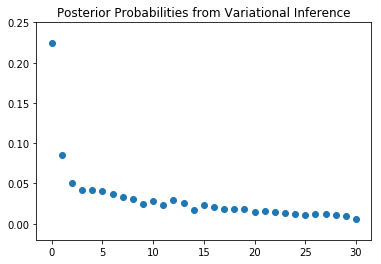

In [18]:
plt.scatter([x for x in range (31)], post_prob_VI)
plt.title('Posterior Probabilities from Variational Inference')
plt.show()

We can also do posterior predictive checks (Rubin, 1984, Gelman el al., 1996). The simplest PPC works by applying a test statistic on new data generated from the posterior predictive $T(X_{new})$.
Applying $T(X_{new})$ to new data over many data replications induces a distribution. We compare this distribution to the test statistic on the real data $T(X)$.

In [19]:
post_prob = np.concatenate((post_prob_VI, [1 - np.sum(post_prob_VI)]))
T_X = np.zeros(100)
for i in range (100):
    X = np.argmax(np.random.multinomial(1, post_prob, size = N), axis = 1)
    X = [x for x in X if x <= 30]
    T_X[i] = np.percentile(X, 75)

We see that the new datasets generated from the variational posterior distributions are somewhat different from our original dataset.

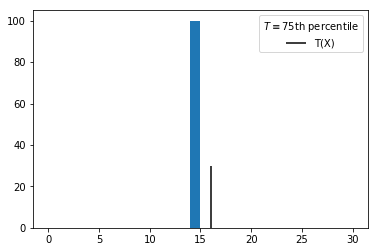

In [20]:
plt.hist(T_X, bins = range(31))
plt.vlines(np.percentile(delay, 75), ymin = 0, ymax = 30, label = 'T(X)')
plt.legend(title = r'$T \equiv$75th percentile')
plt.show()

We can also use the trained posteriors as proposals for the Metropolis Hastings algorithm. But we see that the acceptance rate is almost always $0$, so it also shows that our variational posteriors are not very good.

In [21]:
#MCMC - Metropolis Hastings
T = 500  # number of MCMC samples
qpi_MH = Empirical(tf.get_variable("qpi_MH/params", [T, K], initializer = tf.constant_initializer(1.0 / K)))
qlam_MH = Empirical(tf.get_variable("qlam_MH/params", [T, K], initializer = tf.zeros_initializer()))

inference = ed.MetropolisHastings({pi: qpi_MH, lam: qlam_MH}, {pi: qpi, lam: qlam}, data = {x: delay})
inference.initialize()

sess = ed.get_session()
tf.global_variables_initializer().run()

t_ph = tf.placeholder(tf.int32, [])
running_cluster_means = tf.reduce_mean(qlam_MH.params[:t_ph], 0)

for _ in range(inference.n_iter):
    info_dict = inference.update()
    inference.print_progress(info_dict)
    t = info_dict['t']
    if t % inference.n_print == 0:
        print("\nInferred cluster means:")
        print(sess.run(running_cluster_means, {t_ph: t - 1}))

  5/500 [  1%]                                ETA: 3182s | Acceptance Rate: 0.000
Inferred cluster means:
[0. 0. 0. 0.]
 10/500 [  2%]                                ETA: 1950s | Acceptance Rate: 0.000
Inferred cluster means:
[0. 0. 0. 0.]

Inferred cluster means:
[0. 0. 0. 0.]
 20/500 [  4%] █                              ETA: 955s | Acceptance Rate: 0.000 
Inferred cluster means:
[0. 0. 0. 0.]

Inferred cluster means:
[0. 0. 0. 0.]
 30/500 [  6%] █                              ETA: 624s | Acceptance Rate: 0.000
Inferred cluster means:
[0. 0. 0. 0.]

Inferred cluster means:
[0. 0. 0. 0.]
 40/500 [  8%] ██                             ETA: 458s | Acceptance Rate: 0.000
Inferred cluster means:
[0. 0. 0. 0.]

Inferred cluster means:
[0. 0. 0. 0.]
 50/500 [ 10%] ███                            ETA: 358s | Acceptance Rate: 0.000
Inferred cluster means:
[0. 0. 0. 0.]

Inferred cluster means:
[0. 0. 0. 0.]
 60/500 [ 12%] ███                            ETA: 292s | Acceptance Rate: 0.000
Inferre

435/500 [ 87%] ██████████████████████████     ETA: 6s | Acceptance Rate: 0.000
Inferred cluster means:
[0. 0. 0. 0.]
440/500 [ 88%] ██████████████████████████     ETA: 5s | Acceptance Rate: 0.000
Inferred cluster means:
[0. 0. 0. 0.]

Inferred cluster means:
[0. 0. 0. 0.]
450/500 [ 90%] ███████████████████████████    ETA: 4s | Acceptance Rate: 0.000
Inferred cluster means:
[0. 0. 0. 0.]
455/500 [ 91%] ███████████████████████████    ETA: 4s | Acceptance Rate: 0.000
Inferred cluster means:
[0. 0. 0. 0.]

Inferred cluster means:
[0. 0. 0. 0.]
465/500 [ 93%] ███████████████████████████    ETA: 3s | Acceptance Rate: 0.000
Inferred cluster means:
[0. 0. 0. 0.]

Inferred cluster means:
[0. 0. 0. 0.]
475/500 [ 95%] ████████████████████████████   ETA: 2s | Acceptance Rate: 0.000
Inferred cluster means:
[0. 0. 0. 0.]

Inferred cluster means:
[0. 0. 0. 0.]
485/500 [ 97%] █████████████████████████████  ETA: 1s | Acceptance Rate: 0.000
Inferred cluster means:
[0. 0. 0. 0.]

Inferred cluster means:


$\LARGE \mathbf {Better\; Inference}$

Fortunately, it's been shown (Dellaportas et al., 1997) that if we use a Dirichlet prior for $p's$ and Gamma priors for $\lambda's$, then the sampling steps are readily found to be:
$$\begin{align*}
z_{ik}\sim & Multinomial(1,w_{i1},...,w_{iK}),\quad i=1,...,N,\quad k=1,...,K\\
 & where\quad w_{ik}=\frac{p_{k}f(X_{i}|\lambda_{k})}{f(X_{i})},\quad k=1,...,K\\
p\sim & Dirichlet(d_{1}+\sum_{i=1}^{N}w_{i1},...,d_{K}+\sum_{i=1}^{N}w_{iK})\\
\lambda_{k}\sim & Gamma(a+\sum_{i=1}^{N}z_{ik}X_{i},b+\sum_{i=1}^{N}z_{ik})I(\lambda_{k-1},\lambda_{k+1}),\quad k=1,...,K
\end{align*}$$
So we can now implement Gibbs sampling.

In [22]:
#MCMC - Gibbs
pi = Dirichlet(tf.ones(K))
lam = Gamma(1.0, 0.1, sample_shape = K)
x = ParamMixture(pi, {'rate': lam}, Poisson, sample_shape = N)
z = x.cat

qpi_Gibbs = Empirical(tf.get_variable("qpi_Gibbs/params", [T, K], initializer = tf.constant_initializer(1.0 / K)))
qlam_Gibbs = Empirical(tf.get_variable("qlam_Gibbs/params", [T, K], initializer = tf.zeros_initializer()))
qz_Gibbs = Empirical(tf.get_variable("qz_Gibbs/params", [T, N], initializer = tf.zeros_initializer(), dtype = tf.int32))

inference = ed.Gibbs({pi: qpi_Gibbs, lam: qlam_Gibbs, z: qz_Gibbs}, data = {x: delay})
inference.initialize()

sess = ed.get_session()
tf.global_variables_initializer().run()

t_ph = tf.placeholder(tf.int32, [])
running_cluster_means = tf.reduce_mean(qlam_Gibbs.params[:t_ph], 0)

for _ in range(inference.n_iter):
    info_dict = inference.update()
    inference.print_progress(info_dict)
    t = info_dict['t']
    if t % inference.n_print == 0:
        print("\nInferred cluster means:")
        print(sess.run(running_cluster_means, {t_ph: t - 1}))

  5/500 [  1%]                                ETA: 580s | Acceptance Rate: 1.000
Inferred cluster means:
[17.836128    4.000001    5.7860107   0.68027484]
 10/500 [  2%]                                ETA: 415s | Acceptance Rate: 1.000
Inferred cluster means:
[19.2195     4.6801133  6.451284   0.5346445]
 15/500 [  3%]                                ETA: 356s | Acceptance Rate: 1.000
Inferred cluster means:
[19.803654    4.769235    6.9020414   0.48892954]
 20/500 [  4%] █                              ETA: 329s | Acceptance Rate: 1.000
Inferred cluster means:
[20.213594   4.7074685  7.3341227  0.4617399]
 25/500 [  5%] █                              ETA: 310s | Acceptance Rate: 1.000
Inferred cluster means:
[20.553385    4.6432805   7.734693    0.43992284]
 30/500 [  6%] █                              ETA: 300s | Acceptance Rate: 1.000
Inferred cluster means:
[20.838787    4.618323    8.10344     0.42236763]
 35/500 [  7%] ██                             ETA: 288s | Acceptance Rate: 1.0

270/500 [ 54%] ████████████████               ETA: 134s | Acceptance Rate: 1.000
Inferred cluster means:
[23.216042    5.4404745  12.774439    0.38221952]
275/500 [ 55%] ████████████████               ETA: 131s | Acceptance Rate: 1.000
Inferred cluster means:
[23.22303     5.4436107  12.789564    0.38225198]
280/500 [ 56%] ████████████████               ETA: 128s | Acceptance Rate: 1.000
Inferred cluster means:
[23.229685    5.446721   12.804046    0.38225925]
285/500 [ 56%] █████████████████              ETA: 125s | Acceptance Rate: 1.000
Inferred cluster means:
[23.235725    5.4496326  12.817413    0.38228908]
290/500 [ 57%] █████████████████              ETA: 122s | Acceptance Rate: 1.000
Inferred cluster means:
[23.241291    5.45226    12.830168    0.38227886]
295/500 [ 59%] █████████████████              ETA: 119s | Acceptance Rate: 1.000
Inferred cluster means:
[23.247328    5.454658   12.842742    0.38225147]
300/500 [ 60%] ██████████████████             ETA: 116s | Acceptance R

Since we don't have to marginalize out $z's$ anymore, we can use the posterior distributions of $z's$ to predict which cluster each element belongs to. In contrast to the EM algorithm, the clusters are no longer clear-cut, and each data point has certain probabilities of belonging to two adjacent clusters.

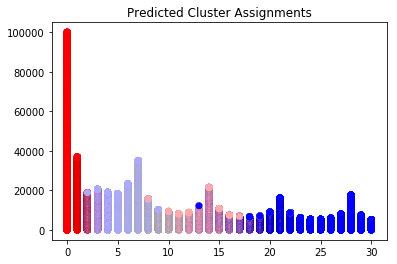

In [23]:
y = np.zeros(N)
for i in range (31):
    indices = [j for j, x in enumerate(delay) if x == i]
    values = [j for j in range (len(indices))]
    y[indices] = values
clusters = qz_Gibbs.sample().eval()
plt.scatter(delay, y, c = clusters, cmap = cm.bwr)
plt.title("Predicted Cluster Assignments")
plt.show()

$\LARGE \mathbf {Criticism\; Again}$

We can use Edward to calculate the log-likelihood.

In [24]:
x_post = ed.copy(x, {pi: qpi_Gibbs, lam: qlam_Gibbs, z: qz_Gibbs})
ed.evaluate('log_likelihood', data = {x_post: delay})

-11.925665

Since AIC is the same, we can again calculate DIC, WAIC and lppd. Compared to the information criteria we calculated previously for variational inference, we see that Gibbs sampling provides better inference.

In [25]:
DIC_Gibbs, WAIC_Gibbs, lppd_Gibbs, post_prob_Gibbs = info_crit(qpi_Gibbs, qlam_Gibbs, K, delay)
print('DIC: ', DIC_Gibbs)
print('WAIC: ', WAIC_Gibbs)
print('lppd:', lppd_Gibbs)

DIC:  3124975.3177859983
WAIC:  3123673.5486360057
lppd: -1551430.6165341947


We can again plot the posterior probabilities calculated through sampling from the posterior distributions. It's still not exactly like the histogram of the dataset, but it looks better than the plot from variational inference.

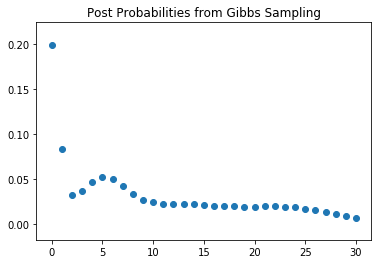

In [26]:
plt.scatter([x for x in range (31)], post_prob_Gibbs)
plt.title('Post Probabilities from Gibbs Sampling')
plt.show()

And we can do posterior predictive checks directly with Edward. And we see that the new datasets generated by sampling $p's$ and $\lambda's$ from the results of using Gibbs are quite similar to our original dataset.

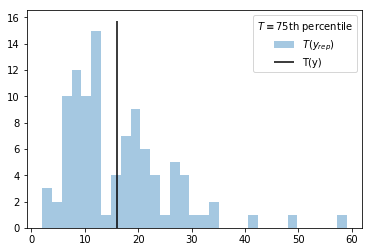

In [27]:
x_post = ed.copy(x, {pi: qpi_Gibbs, lam: qlam_Gibbs, z: qz_Gibbs})
y_rep, y = ed.ppc(lambda xs, zs: tf.contrib.distributions.percentile(xs[x_post], q = 75), data = {x_post: delay})
ed.ppc_stat_hist_plot(y[0], y_rep, stat_name = r'$T \equiv$75th percentile', bins = 31)
plt.show()

$\LARGE \mathbf {Changing\; K}$

We can check if the model is better if we have one more or one less cluster. We start with having $5$ clusters instead of $4$. We run Gibbs sampling and do some ppc.

In [28]:
K = 5
pi = Dirichlet(tf.ones(K))
lam = Gamma(1.0, 0.1, sample_shape = K)
x = ParamMixture(pi, {'rate': lam}, Poisson, sample_shape = N)
z = x.cat

qpi_5 = Empirical(tf.get_variable("qpi_5/params", [T, K], initializer = tf.constant_initializer(1.0 / K)))
qlam_5 = Empirical(tf.get_variable("qlam_5/params", [T, K], initializer = tf.zeros_initializer()))
qz_5 = Empirical(tf.get_variable("qz_5/params", [T, N], initializer = tf.zeros_initializer(), dtype = tf.int32))

inference = ed.Gibbs({pi: qpi_5, lam: qlam_5, z: qz_5}, data = {x: delay})
inference.initialize()

sess = ed.get_session()
tf.global_variables_initializer().run()

for _ in range(inference.n_iter):
    inference.update()

print('mixing proportion: ', qpi_5.mean().eval())
print('cluster mean: ', qlam_5.mean().eval())

DIC_5, WAIC_5, lppd_5, post_prob_5 = info_crit(qpi_5, qlam_5, K, delay)
print('DIC: ', DIC_5)
print('WAIC: ', WAIC_5)
print('lppd:', lppd_5)

mixing proportion:  [0.29082248 0.16073678 0.30570266 0.05825847 0.18447983]
cluster mean:  [ 0.39166424 23.505274    5.616259   23.621998   13.516057  ]
DIC:  3099918.396171991
WAIC:  3101674.650854291
lppd: -1549787.7265697713


In [29]:
x_post = ed.copy(x, {pi: qpi_5, lam: qlam_5, z: qz_5})
ed.evaluate('log_likelihood', data = {x_post: delay})   

-11.850383

We see that although the information criteria are pretty close to that from $4$ clusters, two of the cluster means now are very close and the rest are pretty much the same as before. So it's probably not a better model. We can also do the same for $3$ clusters. But we again see that the statistics are quite similar, so the model is not much better.

In [30]:
K = 3
pi = Dirichlet(tf.ones(K))
lam = Gamma(1.0, 0.1, sample_shape = K)
x = ParamMixture(pi, {'rate': lam}, Poisson, sample_shape = N)
z = x.cat

qpi_3 = Empirical(tf.get_variable("qpi_3/params", [T, K], initializer = tf.constant_initializer(1.0 / K)))
qlam_3 = Empirical(tf.get_variable("qlam_3/params", [T, K], initializer = tf.zeros_initializer()))
qz_3 = Empirical(tf.get_variable("qz_3/params", [T, N], initializer = tf.zeros_initializer(), dtype = tf.int32))

inference = ed.Gibbs({pi: qpi_3, lam: qlam_3, z: qz_3}, data = {x: delay})
inference.initialize()

sess = ed.get_session()
tf.global_variables_initializer().run()

for _ in range(inference.n_iter):
    inference.update()

print('mixing proportion: ', qpi_3.mean().eval())
print('cluster mean: ', qlam_3.mean().eval())

DIC_3, WAIC_3, lppd_3, post_prob_3 = info_crit(qpi_3, qlam_3, K, delay)
print('DIC: ', DIC_3)
print('WAIC: ', WAIC_3)
print('lppd:', lppd_3)

mixing proportion:  [0.3302855  0.31166458 0.35804978]
cluster mean:  [20.803007    0.56329054  6.847982  ]
DIC:  3153385.6848593536
WAIC:  3165714.4998440505
lppd: -1567335.0829180682


In [31]:
x_post = ed.copy(x, {pi: qpi_3, lam: qlam_3, z: qz_3})
ed.evaluate('log_likelihood', data = {x_post: delay})   

-11.9229555

$\LARGE \mathbf {Conclusion}$

In this project, we aim to make inference about how far in advance people usually make appointments. Because there are distinct peaks in the data, we adopt a mixtures of Poissons model. We can use EM algorithm to find the maximum likelihood estimators, but doing Bayesian analysis is harder. Because there is too much variance in BBVI, it's hard to get good variational posteriors, and one can try to include control variates in the future to make better variational inference. Fortunately, with certain choices of priors, we can use Gibbs sampling to get posteriors that yield good posterior predictive checks. It seems that we have a reasonable model for the data, but it's also interesting to explore other models.

$\LARGE \mathbf {References}$

Box, G. E. (1976). Science and statistics. Journal of the American Statistical Association, 71(356):791–799.
<br>
Dinov, I. D. (2008). Expectation maximization and mixture modeling tutorial.
<br>
Gelman, A., Hwang, J., & Vehtari, A. (2014). Understanding predictive information criteria for Bayesian models. Statistics and computing, 24(6), 997-1016.
<br>
Akaike, H. (1973). Information theory and an extension of the maximum likelihood principle. In Proceedings of the Second International Symposium on Information Theory, ed. B. N. Petrov and F. Csaki, 267–281. Budapest: Akademiai Kiado. Reprinted in Breakthroughs in Statistics, ed. S. Kotz, 610–624. New York: Springer (1992).
<br>
Spiegelhalter, D. J., Best, N. G., Carlin, B. P., and van der Linde, A. (2002). Bayesian measures
of model complexity and fit (with discussion). Journal of the Royal Statistical Society B. 
<br>
van der Linde, A. (2005). DIC in variable selection. Statistica Neerlandica 1, 45–56.
<br>
Watanabe, S. (2010). Asymptotic equivalence of Bayes cross validation and widely applicable
information criterion in singular learning theory. Journal of Machine Learning Research 11,
3571–3594.
<br>
Rubin, D. B. (1984). Bayesianly justifiable and relevant frequency calculations for the applied statistician. The Annals of Statistics, 12(4), 1151–1172.
<br>
Gelman, A., Meng, X.-L., & Stern, H. (1996). Posterior predictive assessment of model fitness via realized discrepancies. Statistica Sinica, 733–760.
<br>
Dellaportas, P., Karlis, D., & Xekalaki, E. (1997). Bayesian analysis of finite poisson mixtures. Manuscript.